## Resources
- [How to Generate Music Using a LSTM Neural Network in Keras](https://towardsdatascience.com/how-to-generate-music-using-a-lstm-neural-network-in-keras-68786834d4c5)
    - [The Github (Using Music21 Library)](https://github.com/Skuldur/Classical-Piano-Composer)

In [1]:
from music21 import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from ipywidgets import FloatProgress
import os
import time
import pickle
from KojakLibrary import ProcessMusic as KJPM
from KojakLibrary import MongoQuery as KJMQ
from bson.binary import Binary
import pickle
import codecs, json 
from IPython.display import clear_output

%matplotlib inline

In [2]:
# try:
#     with open('song_notes.pkl', 'rb') as pkl:
#         song_notes = pickle.load(pkl)
# except:
#     song_notes = {}
# dir_contents = os.listdir('midi_files/')
# for i, file in enumerate(dir_contents):
#     print('%d/%d' % (i+1, len(dir_contents)))
#     if file.lower().endswith('.mid') and file not in song_notes.keys():
#         print('Loading File: %s' % file)
#         midi_data = KJPM.load_midi('midi_files/' + file)
#         parts = [p for p in midi_data.parts]
#         notes_list = {}
#         unnamed_counter = 1
#         for part in parts:
#             part_name = part.partName
#             if not part_name:
#                 part_name = 'Unnamed ' + str(unnamed_counter)
#                 unnamed_counter += 1
#             notes_list[part_name] = [element for element in part.recurse()]
#         song_notes[file] = notes_list
#         with open('song_notes.pkl', 'wb') as pkl:
#             pickle.dump(song_notes, pkl)
#     else:
#         print('File already in dictionary: %s' % file)

In [3]:
with open('song_notes.pkl', 'rb') as pkl:
    song_notes = pickle.load(pkl)

In [3]:
track_names = {song_title: list(tracks.keys()) for song_title, tracks in song_notes.items()}

NameError: name 'song_notes' is not defined

In [4]:
sequences = {}
for song, track_list in track_names.items():
    sequences[song] = {}
    for track in track_list:
        sequences[song][track] = [elem for elem in song_notes[song][track] if type(elem) in [note.Note, chord.Chord]]

NameError: name 'track_names' is not defined

In [5]:
# intervalVectorString: [semitones, whole-tones, minor-thirds/augmented-seconds, major-thirds, perfect fourths, and tritones]
x = sequences['automnminnewyork.mid']['Guitar'][35]
x, x.root(), x.intervalVectorString

KeyError: 'automnminnewyork.mid'

In [7]:
sequences['roundmidnight.mid'].keys()

dict_keys(['Acoustic Bass', 'Trombone', 'Unnamed 1', 'Trumpet', 'Mandolin'])

In [8]:
x = song_notes['roundmidnight.mid']['Unnamed 1'][0]
int(x.duration.quarterLength)

391

In [9]:
X = []
y = []

In [10]:
for song_idx, song in enumerate(sequences.keys()):
    clear_output(wait=True)
    print('(%d/%d) %s' % (song_idx+1, len(sequences.keys()), song))
    if len(sequences[song].keys()) < 6:
        continue
    for track_name, track in sequences[song].items():
        vector_array = []
        note_durations = []
        for event in [x for x in track if x.isChord]:
            vector = event.intervalVectorString
            vector_array.append([int(x) for x in vector.replace('<', '').replace('>','')])
        for event in track:
            note_durations.append(float(event.duration.quarterLength))
        vector_array = np.array(vector_array)
        events_per_duration = float(len(track) / song_notes[song][track_name][0].duration.quarterLength)
        frac_chords = float(len([x for x in track if x.isChord])/len(track))
        try:
            min_bass_note = int(min([x.bass().ps for x in track if x.isChord]))
            max_bass_note = int(max([x.bass().ps for x in track if x.isChord]))
            min_root_note = int(min([x.root().ps for x in track if x.isChord]))
            max_root_note = int(max([x.root().ps for x in track if x.isChord]))
            [semitones, 
             wholetones,
             minorthirds,
             majorthirds,
             perfectfourths,
             tritones] = vector_array.mean(axis=0)
        except:
            min_bass_note = int(min([x.ps for x in track]))
            max_bass_note = int(max([x.ps for x in track]))
            min_root_note = min_bass_note
            max_root_note = max_bass_note
            [semitones, 
             wholetones,
             minorthirds,
             majorthirds,
             perfectfourths,
             tritones] = [0, 0, 0, 0, 0, 0]
        bass_note_range = max_bass_note - min_bass_note
        root_note_range = max_root_note - min_root_note
        unique_vals = len(set([str(x) for x in track]))
        if len([x for x in track if x.isNote]) > 0:
            mean_pitch = np.mean([x.pitch.ps for x in track if x.isNote])
        else:
            mean_pitch = 0
        y.append([song, track_name])
        X.append([events_per_duration, frac_chords, np.median(note_durations), unique_vals, 
                  mean_pitch, bass_note_range, root_note_range, 
                  semitones, wholetones, minorthirds, majorthirds, perfectfourths, tritones])

(154/154) SOLAR.MID


In [11]:
X = np.array(X)
y = np.array(y)

In [12]:
print(X.shape)
print(y.shape)

(631, 13)
(631, 2)


In [13]:
df_melodic_framework = pd.DataFrame(X, columns=['Events_Per_Duration', 'Frac_Chords', 'Median_Note_Duration',
                                                'Num_Unique_Notes', 'Mean_Unique_Notes', 'Bass_Note_Range',
                                                'Root_Note_Range', 'Semitones', 'Wholetones', 'Minorthirds',
                                                'Majorthirds', 'Perfectfourths', 'Tritones'])

In [10]:
def filter_song_structure(row):
    if (row['Frac_Chords'] < 0.01) and (row['Median_Note_Duration'] > 0) and (row['Num_Unique_Notes'] > 5) and (row['Mean_Unique_Notes'] > 50):
        return 'Melody'
    elif (row['Frac_Chords'] > 0.5) and (row['Median_Note_Duration'] > 0.25) and (row['Events_Per_Duration'] > 0.1):
        return 'Chords'
    elif (row['Frac_Chords'] < 0.01) and (row['Median_Note_Duration'] > 0) and (row['Num_Unique_Notes'] > 5) and (row['Mean_Unique_Notes'] <= 50):
        return 'Bass'
    else:
        return 'Other'
def structure_colors(x):
    if x == 'Melody':
        return 'red'
    if x == 'Chords':
        return 'blue'
    if x == 'Bass':
        return 'yellow'
    return 'black'

def structure_subclass(x):
    if x < 0.01:
        return 'Monophonic'
    elif x > 0.5:
        return 'Polyphonic'
    else:
        return 'Not Valid'
#     if x == 'Melody' or x == 'Bass':
#         return 'Monophonic'
#     else:
#         return 'Polyphonic'

In [11]:
df_melodic_framework['Classification'] = df_melodic_framework.apply(filter_song_structure, axis=1)
df_melodic_framework['Color'] = df_melodic_framework['Classification'].apply(structure_colors)
df_melodic_framework['Subclass'] = df_melodic_framework['Frac_Chords'].apply(structure_subclass)
# df_melodic_framework = df_melodic_framework[df_melodic_framework['Classification'].isin(['Melody', 'Bass', 'Chords'])]

In [41]:
with open('df_melodic_framework.pkl', 'wb') as pkl:
    pickle.dump(df_melodic_framework, pkl)

In [2]:
with open('df_melodic_framework.pkl', 'rb') as pkl:
    df_melodic_framework = pickle.load(pkl)

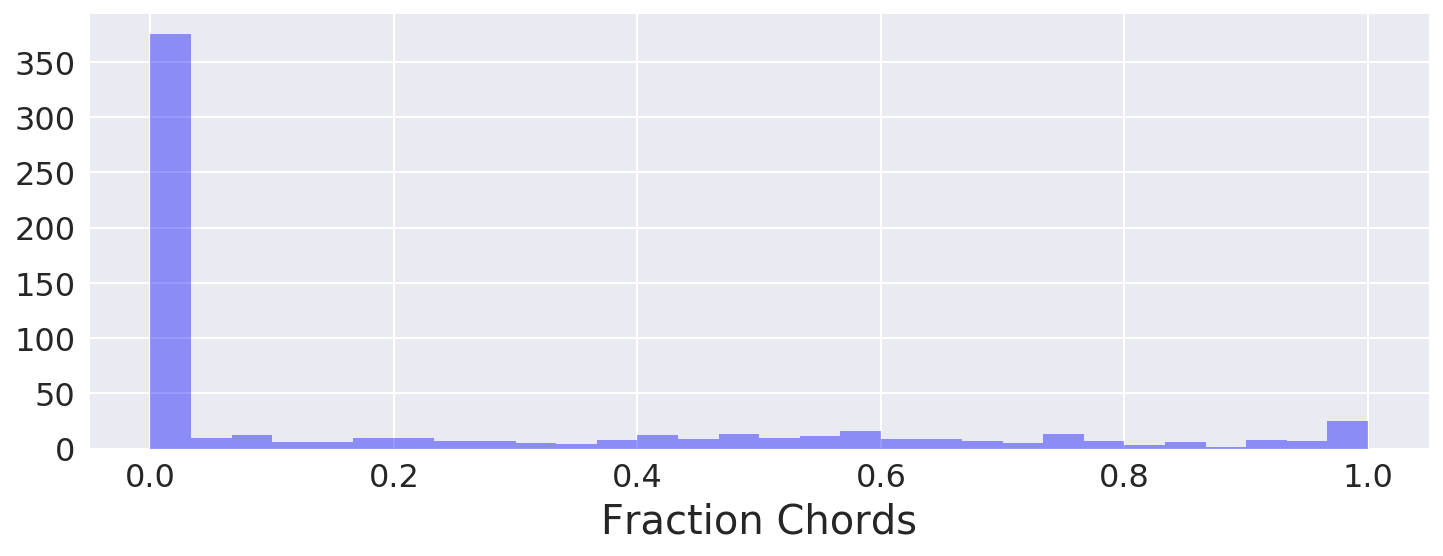

In [3]:
plt.figure(figsize=(12,4))
sns.distplot(df_melodic_framework['Frac_Chords'], kde=False, bins=30, color='blue')
plt.xlabel('Fraction Chords', fontsize=20)
plt.yticks(fontsize=16);
plt.xticks(fontsize=16);

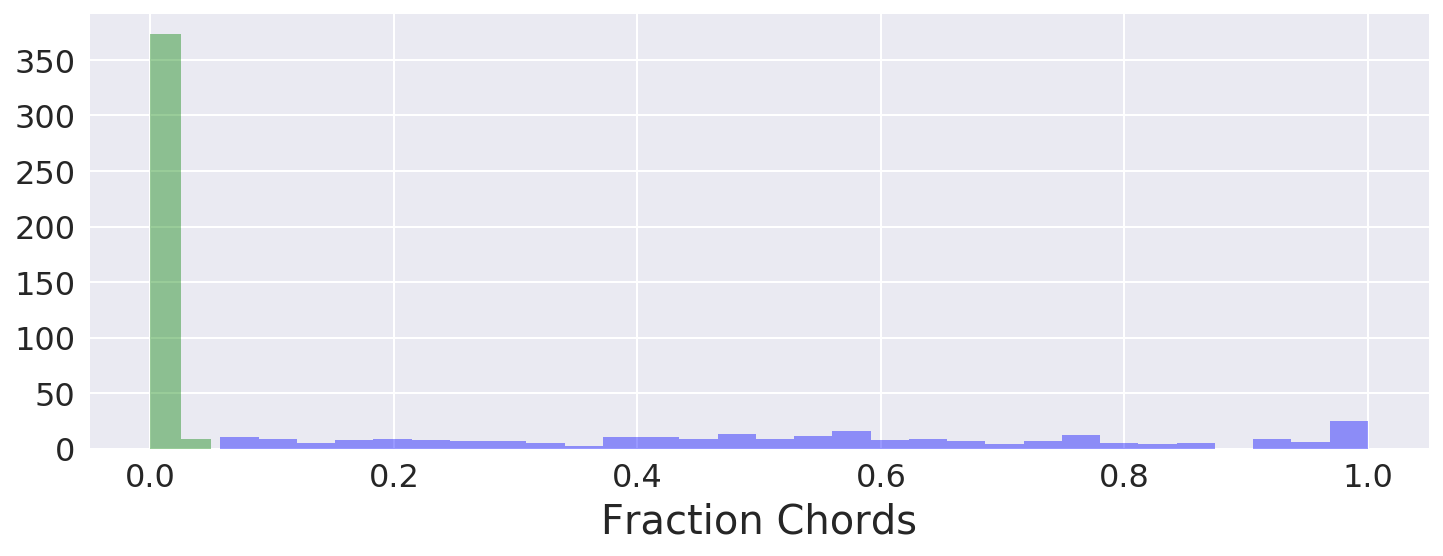

In [4]:
plt.figure(figsize=(12,4))
sns.distplot(df_melodic_framework[df_melodic_framework['Frac_Chords'] > 0.05]['Frac_Chords'], kde=False, bins=30, color='blue')
plt.xlabel('Fraction Chords', fontsize=20)
plt.yticks(fontsize=16);
plt.xticks(fontsize=16);
# plt.figure(figsize=(12,4))
sns.distplot(df_melodic_framework[df_melodic_framework['Frac_Chords'] < 0.05]['Frac_Chords'], kde=False, bins=2, color='green')
plt.xlabel('Fraction Chords', fontsize=20)
plt.yticks(fontsize=16);
plt.xticks(fontsize=16);

(array([0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1]),
 <a list of 8 Text yticklabel objects>)

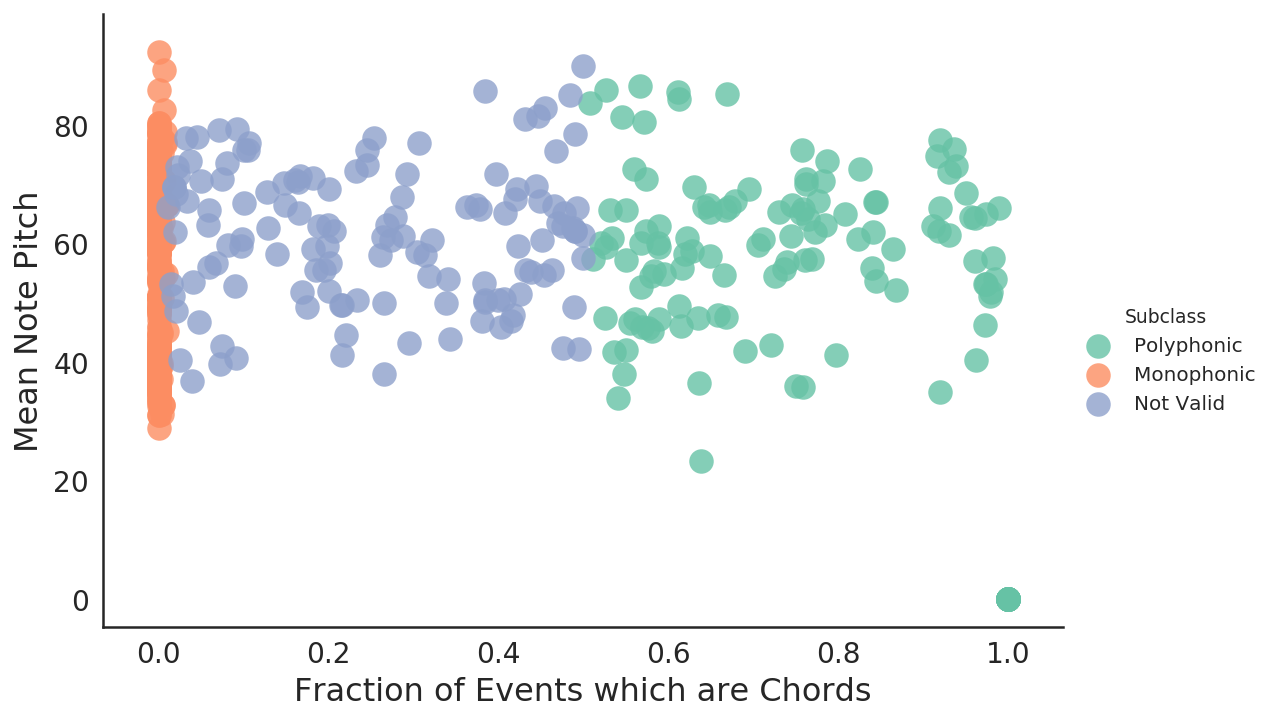

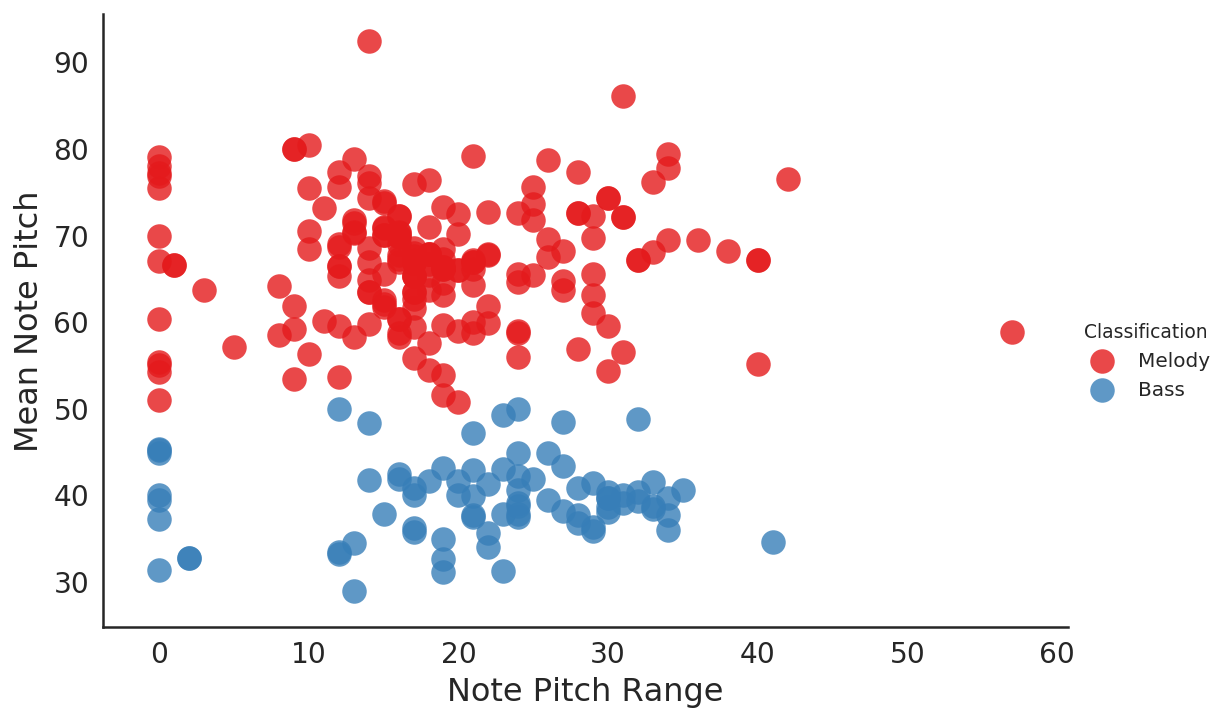

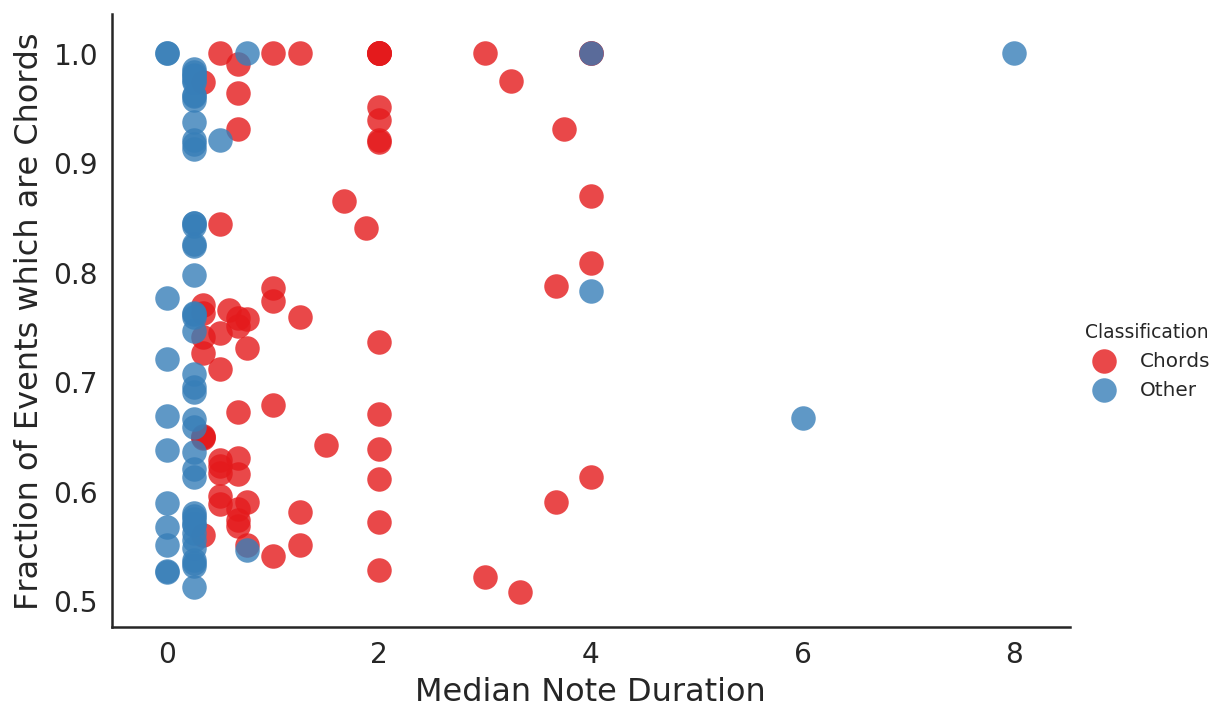

In [28]:
# sns.pairplot(data=df_melodic_framework.drop(['Color', 'Root_Note_Range', 'Semitones', 'Wholetones', 'Minorthirds',
#                                                 'Majorthirds', 'Perfectfourths', 'Tritones'], axis=1),
#                                                  size=10, aspect=1.5, hue='Classification')
sns.set_style('white')
sns.lmplot(data=df_melodic_framework, x='Frac_Chords', y='Mean_Unique_Notes', hue='Subclass',
           fit_reg=False, size=5, aspect=1.5, palette='Set2', scatter_kws={'s': 150, 'alpha': .8})
plt.ylabel('Mean Note Pitch', fontsize=16)
plt.xlabel('Fraction of Events which are Chords', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
sns.lmplot(data=df_melodic_framework[((df_melodic_framework['Subclass'] == 'Monophonic') &
                                      (df_melodic_framework['Classification'] != 'Other'))],
           x='Bass_Note_Range', y='Mean_Unique_Notes', hue='Classification',
           fit_reg=False, size=5, aspect=1.5, palette='Set1', scatter_kws={'s': 150, 'alpha': .8})
plt.ylabel('Mean Note Pitch', fontsize=16)
plt.xlabel('Note Pitch Range', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
sns.lmplot(data=df_melodic_framework[df_melodic_framework['Subclass'] == 'Polyphonic'],
           y='Frac_Chords', x='Median_Note_Duration', hue='Classification', hue_order=['Chords', 'Other'],
           fit_reg=False, size=5, aspect=1.5, palette='Set1', scatter_kws={'s': 150, 'alpha': .8})
plt.xlabel('Median Note Duration', fontsize=16)
plt.ylabel('Fraction of Events which are Chords', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

In [30]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
new_X = pca.fit_transform(df_melodic_framework.drop(['Classification', 'Color'], axis=1))

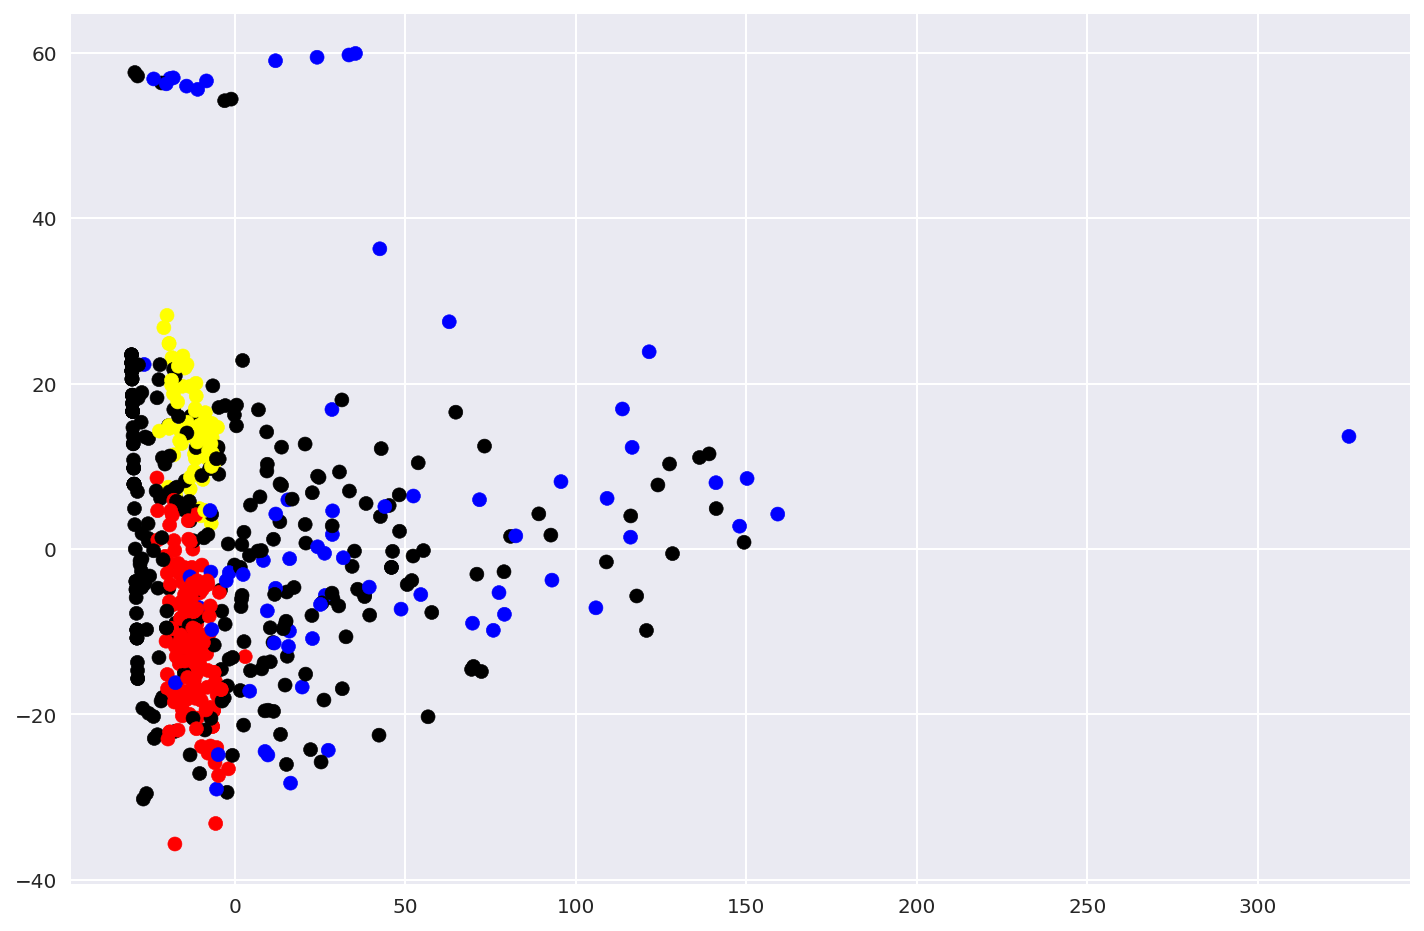

In [31]:
plt.figure(figsize=(12,8))
plt.scatter(new_X[:,0], new_X[:,1], c=df_melodic_framework['Color'])

In [55]:
melody_filt = ((X[:, 1] < 0.01) & (X[:, 2] > 0) & (X[:, 3] > 5)) # For Melodies
chord_filt = ((X[:, 1] > 0.5) & (X[:, 2] > 0.25) & (X[:, 0] > 0.1)) # For Chords
print(str(len(y[melody_filt])) + " Plots...")
print(str(len(y[chord_filt])) + " Plots...")

263 Plots...
73 Plots...


In [56]:
def get_key(song_notes, midi_file, track):
    return song_notes[midi_file][track][0].analyze('key')
#     if song_key.mode == 'minor':
#         song_key = song_key.relative
#     return song_key

In [57]:
chords = []
for item in y[chord_filt]:
    song_key = get_key(song_notes, item[0], item[1])
    chords.append([item[0], item[1], str(song_key.tonic), str(song_key.mode), str(song_key.correlationCoefficient)])

In [58]:
df_chords = pd.DataFrame(chords, columns=['Song', 'Chord_Track', 'Key_Tonic', 'Key_Mode', 'Key_Corr_Coef'])
df_chords.head()

Song Chord_Track Key_Tonic Key_Mode       Key_Corr_Coef
0  flymetothemoon.mid   Unnamed 3         C    major  0.7773800340254029
1  flymetothemoon.mid   Unnamed 1         D    minor  0.8882259728446914
2        Bornblue.mid      Guitar         B    major  0.8106664456377491
3        Bornblue.mid   Unnamed 2         B    major  0.6540467311406448
4        Bornblue.mid  Vibraphone         B    major  0.6764046906432448

In [59]:
df_melody = pd.DataFrame(y[melody_filt], columns=['Song', 'Melody_Track'])
df_melody.head()

Song     Melody_Track
0  flymetothemoon.mid        Saxophone
1  flymetothemoon.mid    Acoustic Bass
2  flymetothemoon.mid        Unnamed 2
3        Bornblue.mid  Tenor Saxophone
4        Bornblue.mid    Acoustic Bass

In [60]:
df_song_links = df_melody.merge(df_chords, on='Song')
df_song_links.head(25)

Song     Melody_Track Chord_Track Key_Tonic Key_Mode  \
0       flymetothemoon.mid        Saxophone   Unnamed 3         C    major   
1       flymetothemoon.mid        Saxophone   Unnamed 1         D    minor   
2       flymetothemoon.mid    Acoustic Bass   Unnamed 3         C    major   
3       flymetothemoon.mid    Acoustic Bass   Unnamed 1         D    minor   
4       flymetothemoon.mid        Unnamed 2   Unnamed 3         C    major   
5       flymetothemoon.mid        Unnamed 2   Unnamed 1         D    minor   
6             Bornblue.mid  Tenor Saxophone      Guitar         B    major   
7             Bornblue.mid  Tenor Saxophone   Unnamed 2         B    major   
8             Bornblue.mid  Tenor Saxophone  Vibraphone         B    major   
9             Bornblue.mid    Acoustic Bass      Guitar         B    major   
10            Bornblue.mid    Acoustic Bass   Unnamed 2         B    major   
11            Bornblue.mid    Acoustic Bass  Vibraphone         B    major   
12              Brazil.mid    Fretless Bass      Guitar         E    minor   
13              Brazil.mid        Unnamed 1      Guitar         E    minor   
14              Brazil.mid        Unnamed 2      Guitar         E    minor   
15              Brazil.mid       Vibraphone      Guitar         E    minor   
16  Georgia_on_my_mind.mid    Electric Bass    Mandolin         F    major   
17  Georgia_on_my_mind.mid             Oboe    Mandolin         F    major   
18         Reflections.mid    Acoustic Bass       Piano        B-    minor   
19         Reflections.mid       Vibraphone       Piano        B-    minor   
20         Reflections.mid        Unnamed 1       Piano        B-    minor   
21             maputo2.mid        Saxophone   Unnamed 1         G    minor   
22             maputo2.mid        Saxophone   Unnamed 5         G    minor   
23             maputo2.mid    Acoustic Bass   Unnamed 1         G    minor   
24             maputo2.mid    Acoustic Bass   Unnamed 5         G    minor   

         Key_Corr_Coef  
0   0.7773800340254029  
1   0.8882259728446914  
2   0.7773800340254029  
3   0.8882259728446914  
4   0.7773800340254029  
5   0.8882259728446914  
6   0.8106664456377491  
7   0.6540467311406448  
8   0.6764046906432448  
9   0.8106664456377491  
10  0.6540467311406448  
11  0.6764046906432448  
12  0.7958576890830514  
13  0.7958576890830514  
14  0.7958576890830514  
15  0.7958576890830514  
16  0.8313987722363312  
17  0.8313987722363312  
18  0.8171463916443986  
19  0.8171463916443986  
20  0.8171463916443986  
21  0.7961667304316912  
22  0.8915485602766045  
23  0.7961667304316912  
24  0.8915485602766045

In [19]:
len(df_song_links)

248

In [20]:
with open('df_song_links.pkl', 'wb') as pkl:
    pickle.dump(df_song_links, pkl)
    
with open('sequences.pkl', 'wb') as pkl:
    pickle.dump(sequences, pkl)

In [62]:
print("Loading Song Links DataFrame")
with open('df_song_links.pkl', 'rb') as pkl:
    df_song_links = pickle.load(pkl)
print("Complete")

Loading Song Links DataFrame
Complete


In [61]:
print("Loading Sequences")
with open('sequences.pkl', 'rb') as pkl:
    sequences = pickle.load(pkl)
print("Complete")

Loading Sequences
Complete


In [8]:
print("Loading Song Notes")
with open('song_notes.pkl', 'rb') as pkl:
    song_notes = pickle.load(pkl)
print("Complete")

Loading Song Notes
Complete


In [7]:
my_midi = KJPM.load_midi('midi_files/automnminnewyork.mid')
music = KJPM.music_unjsonify('automnminnewyork.json')

Loading automnminnewyork.json


In [8]:
music['instruments'].keys()

dict_keys(['Unnamed 1', 'Trombone', 'Piccolo', 'Lute', 'Acoustic Bass', 'Unnamed 2', 'Unnamed 3', 'Alto Saxophone'])

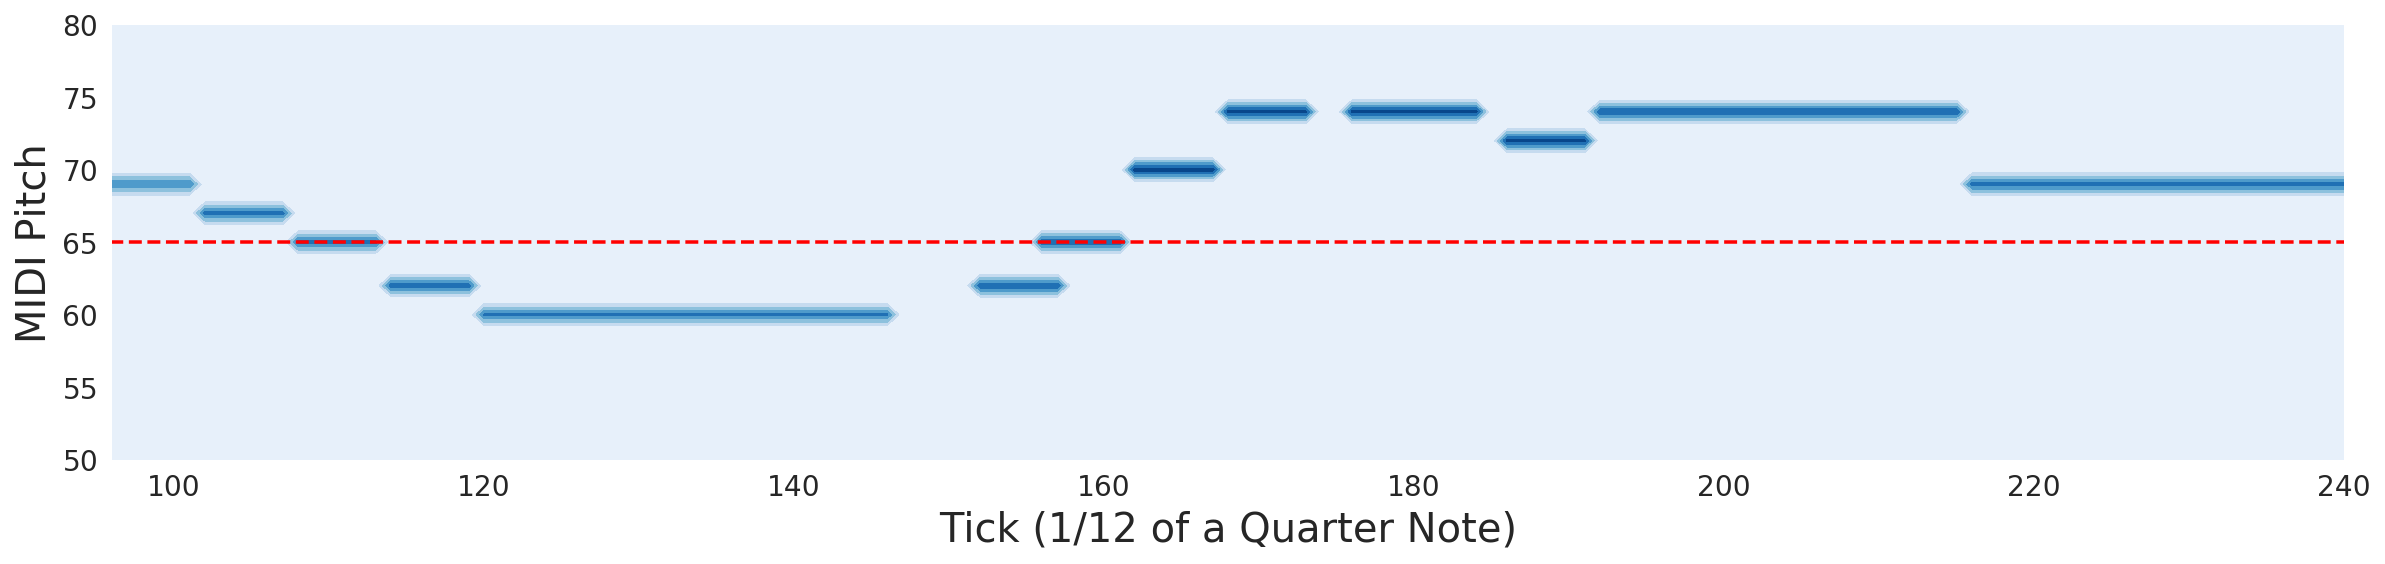

In [9]:
parts = [p for p in my_midi.parts]
part_names = [p.partName for p in parts]
part_names
plt.figure(figsize=(20,4))
# plt.contourf(KJPM.create_grid(my_midi.parts[2]), cmap='Blues')
plt.contourf(music['instruments']['Piccolo'], cmap='Blues')
plt.ylabel('MIDI Pitch', fontsize=20)
plt.xlabel('Tick (1/12 of a Quarter Note)', fontsize=20)
plt.plot([0, 400], [65, 65], 'r--')
plt.xlim(48+48, 48+48 + (48*3))
plt.ylim(50,80)
plt.xticks(fontsize=14);
plt.yticks(np.arange(50,81,5), fontsize=14);

In [16]:
names = ['Acoustic Bass', 'Unnamed 1', 'Piccolo', 'Unnamed 3', 'Lute']

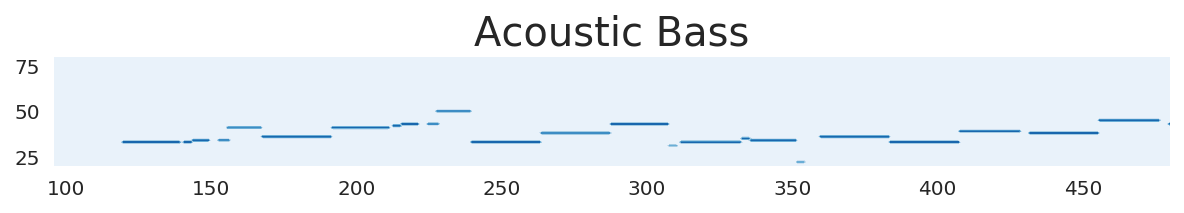

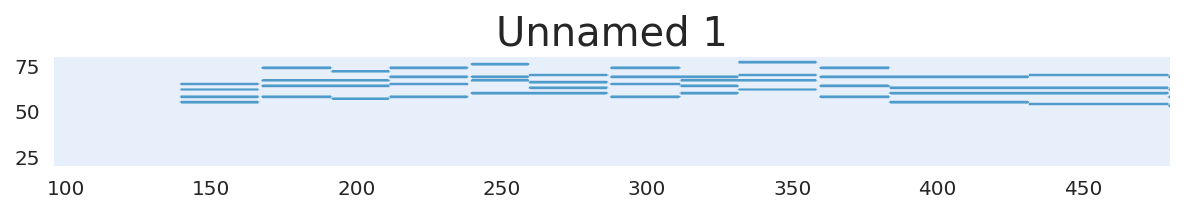

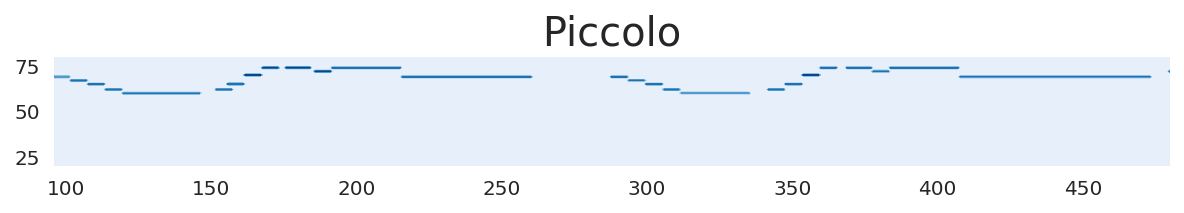

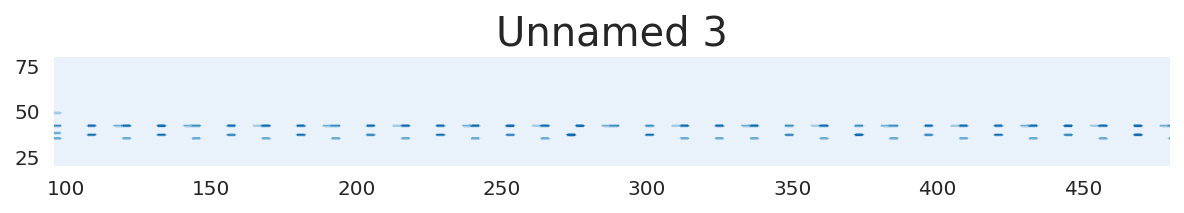

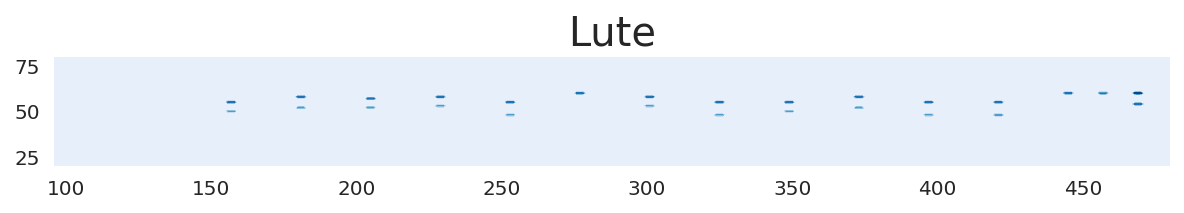

In [25]:
for p in names:
    plt.figure(figsize=(10,1))
    plt.contourf(music['instruments'][p], cmap='Blues')
    plt.title(p, fontsize=20)
    plt.ylim(20, 80)
    plt.xlim(96, 96+8*48)

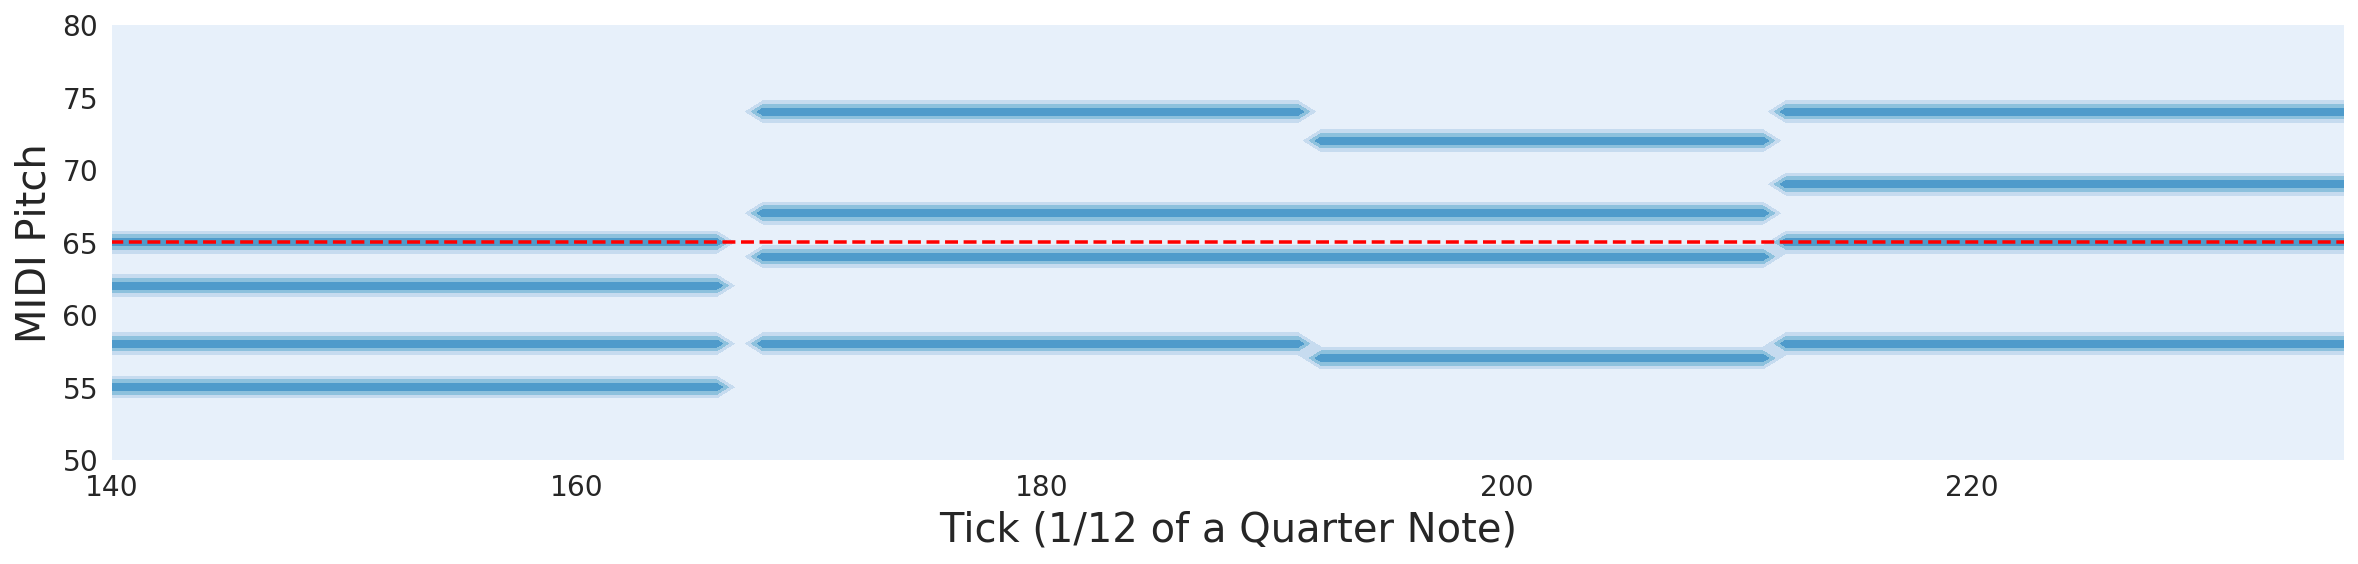

In [125]:
plt.figure(figsize=(20,4))
# plt.contourf(KJPM.create_grid(my_midi.parts[2]), cmap='Blues')
plt.contourf(music['instruments']['Unnamed 1'], cmap='Blues')
plt.ylabel('MIDI Pitch', fontsize=20)
plt.xlabel('Tick (1/12 of a Quarter Note)', fontsize=20)
plt.plot([0, 400], [65, 65], 'r--')

plt.xlim(140, 140 + (12*8))
plt.ylim(50,80)
plt.xticks(fontsize=14);
plt.yticks(np.arange(50,81,5), fontsize=14);

In [126]:
[[0,2,5,9],[2,5,9,11],[2,4,7,11],[0,4,5,9]]

[[0, 2, 5, 9], [2, 5, 9, 11], [2, 4, 7, 11], [0, 4, 5, 9]]

In [55]:
music['primary_key']

0

In [80]:
my_key = key.Key('F', 'major')

In [82]:
my_key.pitches[0].midi

65

In [1]:
with open('df_song_links_chord_melody_seq.pkl', 'rb') as pkl:
    df_song_links_chord_melody_seq = pickle.load(pkl)

NameError: name 'pickle' is not defined

In [83]:
df_song_links_chord_melody_seq[((df_song_links_chord_melody_seq['Song'] == 'automnminnewyork.mid') &
                                (df_song_links_chord_melody_seq['Melody_Track'] == 'Piccolo'))].iloc[0]['Melody_Data'][:13]

[4, 2, 0, 9, 7, 9, 0, 5, 9, 9, 7, 9, 4]

In [124]:
df_song_links_chord_melody_seq[((df_song_links_chord_melody_seq['Song'] == 'automnminnewyork.mid') &
                                (df_song_links_chord_melody_seq['Melody_Track'] == 'Piccolo'))].iloc[0]['Chord_Data'][:4]

[{'Chord_Root': 'G',
  'Chord_Root_Num': 7,
  'Normal_Form': [0, 3, 5, 8],
  'Normal_Order': [2, 5, 7, 10],
  'PitchCommonName': 'G3-minor seventh chord',
  'Pitch_Names': ['G', 'B-', 'D', 'F'],
  'Raw_Chord': '<music21.roman.RomanNumeral ii7 in F major>',
  'Roman_Numeral': 'ii',
  'Song_Root': 'F',
  'Song_Root_Mode': 'major',
  'Song_Root_Num': 7},
 {'Chord_Root': 'E',
  'Chord_Root_Num': 4,
  'Normal_Form': [0, 2, 5, 8],
  'Normal_Order': [2, 4, 7, 10],
  'PitchCommonName': 'E4-half-diminished seventh chord',
  'Pitch_Names': ['B-', 'D', 'E', 'G'],
  'Raw_Chord': '<music21.roman.RomanNumeral vii/o43 in F major>',
  'Roman_Numeral': 'vii',
  'Song_Root': 'F',
  'Song_Root_Mode': 'major',
  'Song_Root_Num': 4},
 {'Chord_Root': 'A',
  'Chord_Root_Num': 9,
  'Normal_Form': [0, 3, 5, 8],
  'Normal_Order': [4, 7, 9, 0],
  'PitchCommonName': 'A3-minor seventh chord',
  'Pitch_Names': ['E', 'G', 'A', 'C'],
  'Raw_Chord': '<music21.roman.RomanNumeral iii7 in F major>',
  'Roman_Numeral': 'i

In [30]:
part_names[2]

'Piano'

Loading 502blues.json


In [29]:
music

{'ending_bpm': 154,
 'instruments': {'Acoustic Bass': array([[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]),
  'Lute': array([[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]),
  'Piano': array([[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]),
  'Unnamed 1': array([[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0.

In [4]:
sequences[df_song_links['Song'][5]][df_song_links['Melody_Track'][5]][:10]

[<music21.note.Note G>,
 <music21.note.Note G#>,
 <music21.note.Note A>,
 <music21.note.Note B->,
 <music21.note.Note G#>,
 <music21.note.Note E>,
 <music21.note.Note F>,
 <music21.note.Note F#>,
 <music21.note.Note G>,
 <music21.note.Note F>]

In [6]:
def chords2roman(seq, inp_key, inp_mode):
    roman_seq = []
    for i, s in enumerate(seq):
        clear_output(wait=True)
        print('%d/%d' % (i+1, len(seq)))
        if s.isChord:
            new_roman = roman.romanNumeralFromChord(s, key.Key(tonic=inp_key, mode=inp_mode))
            if (len(roman_seq) > 0) and (str(roman_seq[-1]) == str(new_roman)):
                continue
            else:
                roman_seq.append(new_roman)
    return roman_seq

def notes2seq(seq, inp_key, inp_mode):
    primary_key = key.Key(inp_key, inp_mode)
    primary_root = primary_key.getTonic().pitchClass
    note_seq = []
    for i, s in enumerate(seq):
        clear_output(wait=True)
        print('%d/%d' % (i+1, len(seq)))
        
        if s.isNote:
            new_note = s.pitchClass
            note_offset = new_note - primary_root
            note_offset = new_note - primary_root
            if note_offset < 0:
                note_offset = note_offset + 12
                
            if (len(note_seq) > 0) and (note_seq[-1] == note_offset):
                continue
            else:
                note_seq.append(note_offset)
    return note_seq

In [57]:
f = FloatProgress(min=1, max=len(df_song_links), value=1)
f.description = str('%0.2f%%' % 0)

display(f)

In [58]:
df_chord_data = df_song_links.drop_duplicates(subset=['Song', 'Chord_Track'])
df_chord_data['Chord_Data'] = [[]]*len(df_chord_data)
for row, item in df_chord_data.iterrows():
    
    f.value = row+1
    f.description = str('%0.2f%%' % ((row+1)/len(df_chord_data)*100))
    song_key = key.Key(item['Key_Tonic'], item['Key_Mode'])
    chord_array = chords2roman(sequences[item['Song']][item['Chord_Track']],
                               item['Key_Tonic'], item['Key_Mode'])
    chord_info = []
    for c_elem in chord_array:
        chord_info.append({'Raw_Chord': str(c_elem), 
                           'Song_Root': str(c_elem.key.tonic), 
                           'Song_Root_Num': c_elem.root().pitchClass,
                           'Song_Root_Mode': str(c_elem.key.mode),
                           'Roman_Numeral': c_elem.romanNumeral, 
                           'Normal_Form': c_elem.normalForm,
                           'Normal_Order': c_elem.normalOrder,
                           'Pitch_Names': c_elem.pitchNames, 
                           'PitchCommonName': c_elem.pitchedCommonName, 
                           'Chord_Root': c_elem.root().name,
                           'Chord_Root_Num': c_elem.root().pitchClass})
        
#     melody_array = sequences[item['Song']][item['Melody_Track']]
    print(item)
    df_chord_data['Chord_Data'][row] = chord_info

167/167
Song                noisynights.mid
Melody_Track          Fretless Bass
Chord_Track               Unnamed 1
Key_Tonic                        F#
Key_Mode                      minor
Key_Corr_Coef    0.7218853728442278
Chord_Data                       []
Name: 246, dtype: object


In [59]:
df_song_links_chord_seq = df_song_links.merge(df_chord_data[['Song', 'Chord_Track', 'Chord_Data']], on=['Song', 'Chord_Track'])
df_song_links_chord_seq.head(10)

Song   Melody_Track Chord_Track Key_Tonic Key_Mode  \
0        Triste.mid      Unnamed 1   Unnamed 4        B-    major   
1   AFelicidade.mid          Piano    Mandolin        E-    major   
2   AFelicidade.mid  Acoustic Bass    Mandolin        E-    major   
3   AFelicidade.mid          Piano   Unnamed 1         C    minor   
4   AFelicidade.mid  Acoustic Bass   Unnamed 1         C    minor   
5      Igetakik.mid     Vibraphone       Piano         F    minor   
6      Igetakik.mid      Unnamed 1       Piano         F    minor   
7      Igetakik.mid      Pan Flute       Piano         F    minor   
8      Igetakik.mid  Acoustic Bass       Piano         F    minor   
9  maidenvoyage.mid  Bass clarinet   Unnamed 1         C    minor   

        Key_Corr_Coef                                         Chord_Data  
0  0.8212995570265337  [{'Normal_Form': [0, 4, 7], 'Roman_Numeral': '...  
1  0.8611870651773542  [{'Normal_Form': [0, 5], 'Roman_Numeral': 'vi'...  
2  0.8611870651773542  [{'Normal_Form': [0, 5], 'Roman_Numeral': 'vi'...  
3  0.8903395836498903  [{'Normal_Form': [0, 3, 7], 'Roman_Numeral': '...  
4  0.8903395836498903  [{'Normal_Form': [0, 3, 7], 'Roman_Numeral': '...  
5  0.8800689242004679  [{'Normal_Form': [0, 3, 5, 8], 'Roman_Numeral'...  
6  0.8800689242004679  [{'Normal_Form': [0, 3, 5, 8], 'Roman_Numeral'...  
7  0.8800689242004679  [{'Normal_Form': [0, 3, 5, 8], 'Roman_Numeral'...  
8  0.8800689242004679  [{'Normal_Form': [0, 3, 5, 8], 'Roman_Numeral'...  
9   0.932745468702888  [{'Normal_Form': [0, 2, 7], 'Roman_Numeral': '...

In [60]:
with open('df_song_links_chord_seq.pkl', 'wb') as pkl:
    pickle.dump(df_song_links_chord_seq, pkl)

In [7]:
with open('df_song_links_chord_seq.pkl', 'rb') as pkl:
    df_song_links_chord_seq = pickle.load(pkl)

In [10]:
df_song_links_chord_seq.head(20)

Song   Melody_Track      Chord_Track Key_Tonic Key_Mode  \
0          Triste.mid      Unnamed 1        Unnamed 4        B-    major   
1     AFelicidade.mid          Piano         Mandolin        E-    major   
2     AFelicidade.mid  Acoustic Bass         Mandolin        E-    major   
3     AFelicidade.mid          Piano        Unnamed 1         C    minor   
4     AFelicidade.mid  Acoustic Bass        Unnamed 1         C    minor   
5        Igetakik.mid     Vibraphone            Piano         F    minor   
6        Igetakik.mid      Unnamed 1            Piano         F    minor   
7        Igetakik.mid      Pan Flute            Piano         F    minor   
8        Igetakik.mid  Acoustic Bass            Piano         F    minor   
9    maidenvoyage.mid  Bass clarinet        Unnamed 1         C    minor   
10   maidenvoyage.mid      Unnamed 3        Unnamed 1         C    minor   
11   maidenvoyage.mid        Piccolo        Unnamed 1         C    minor   
12   maidenvoyage.mid      Unnamed 2        Unnamed 1         C    minor   
13   maidenvoyage.mid   English Horn        Unnamed 1         C    minor   
14   maidenvoyage.mid  Acoustic Bass        Unnamed 1         C    minor   
15        ipanema.mid      Unnamed 2           Guitar         D    minor   
16        ipanema.mid  Acoustic Bass           Guitar         D    minor   
17  cantaloup-isl.mid  Fretless Bass  Tenor Saxophone         F    minor   
18       songbird.mid      Unnamed 7        Unnamed 6         A    minor   
19       songbird.mid      Unnamed 9        Unnamed 6         A    minor   

         Key_Corr_Coef                                         Chord_Data  
0   0.8212995570265337  [{'Song_Root_Mode': 'major', 'Song_Root_Num': ...  
1   0.8611870651773542  [{'Song_Root_Mode': 'major', 'Song_Root_Num': ...  
2   0.8611870651773542  [{'Song_Root_Mode': 'major', 'Song_Root_Num': ...  
3   0.8903395836498903  [{'Song_Root_Mode': 'minor', 'Song_Root_Num': ...  
4   0.8903395836498903  [{'Song_Root_Mode': 'minor', 'Song_Root_Num': ...  
5   0.8800689242004679  [{'Song_Root_Mode': 'minor', 'Song_Root_Num': ...  
6   0.8800689242004679  [{'Song_Root_Mode': 'minor', 'Song_Root_Num': ...  
7   0.8800689242004679  [{'Song_Root_Mode': 'minor', 'Song_Root_Num': ...  
8   0.8800689242004679  [{'Song_Root_Mode': 'minor', 'Song_Root_Num': ...  
9    0.932745468702888  [{'Song_Root_Mode': 'minor', 'Song_Root_Num': ...  
10   0.932745468702888  [{'Song_Root_Mode': 'minor', 'Song_Root_Num': ...  
11   0.932745468702888  [{'Song_Root_Mode': 'minor', 'Song_Root_Num': ...  
12   0.932745468702888  [{'Song_Root_Mode': 'minor', 'Song_Root_Num': ...  
13   0.932745468702888  [{'Song_Root_Mode': 'minor', 'Song_Root_Num': ...  
14   0.932745468702888  [{'Song_Root_Mode': 'minor', 'Song_Root_Num': ...  
15  0.6328344666013302  [{'Song_Root_Mode': 'minor', 'Song_Root_Num': ...  
16  0.6328344666013302  [{'Song_Root_Mode': 'minor', 'Song_Root_Num': ...  
17  0.7160691486740252  [{'Song_Root_Mode': 'minor', 'Song_Root_Num': ...  
18  0.8901228032357763  [{'Song_Root_Mode': 'minor', 'Song_Root_Num': ...  
19  0.8901228032357763  [{'Song_Root_Mode': 'minor', 'Song_Root_Num': ...

In [11]:
f = FloatProgress(min=1, max=len(df_song_links_chord_seq), value=1)
f.description = str('%0.2f%%' % 0)

display(f)

In [ ]:
df_melody_data = df_song_links_chord_seq.drop_duplicates(subset=['Song', 'Melody_Track'])
df_melody_data['Melody_Data'] = [[]]*len(df_melody_data)
for row, item in df_melody_data.iterrows():
    f.value = row+1
    f.description = str('%0.2f%%' % ((row+1)/len(df_song_links_chord_seq)*100))
    
    melody_array = notes2seq(sequences[item['Song']][item['Melody_Track']],
                                      item['Key_Tonic'], item['Key_Mode'])
    df_melody_data['Melody_Data'][row] = melody_array

150/150


In [ ]:
df_melody_data.head()

In [ ]:
df_song_links_chord_melody_seq = df_song_links_chord_seq.merge(df_melody_data[['Song', 'Melody_Track', 'Melody_Data']], on=['Song', 'Melody_Track'])
df_song_links_chord_melody_seq.head(10)

In [ ]:
with open('df_song_links_chord_melody_seq_2.pkl', 'wb') as pkl:
    pickle.dump(df_song_links_chord_melody_seq, pkl)

In [9]:
with open('df_song_links_chord_melody_seq.pkl', 'rb') as pkl:
    df_song_links_chord_melody_seq = pickle.load(pkl)

In [10]:
df_song_links_chord_melody_seq.iloc[0]

Song                                                    Triste.mid
Melody_Track                                             Unnamed 1
Chord_Track                                              Unnamed 4
Key_Tonic                                                       B-
Key_Mode                                                     major
Key_Corr_Coef                                   0.8212995570265337
Chord_Data       [{'Song_Root': 'B-', 'Normal_Order': [8, 0, 3]...
Melody_Data      [10, 9, 3, 2, 8, 7, 1, 0, 7, 7, 1, 1, 8, 8, 0,...
Name: 0, dtype: object

In [11]:
y = notes2roman(sequences[df_song_links['Song'][6]][df_song_links['Melody_Track'][6]], 
                           df_song_links['Key_Tonic'][6],
                           df_song_links['Key_Mode'][6])

NameError: name 'notes2roman' is not defined

In [12]:
y

NameError: name 'y' is not defined

In [ ]:
df_song_links['Key_Tonic'][5]

In [57]:
g = sequences[df_song_links['Song'][5]][df_song_links['Melody_Track'][5]][:10][0]

In [66]:
g.ps

60.0

In [54]:
x0.pitches

(<music21.pitch.Pitch C4>, <music21.pitch.Pitch B-3>, <music21.pitch.Pitch E4>)

In [48]:
x0.forteClass

'3-8A'

In [28]:
k = key.Key('C', 'minor').transpose(3)

In [32]:
music = KJPM.music_unjsonify('howhightthemoon.mid'.lower().replace('.mid', '.json'))

Loading howhightthemoon.json


In [40]:
print(song_notes['songbird.mid']['Unnamed 4'][0].analyze('key'))
print(song_notes['songbird.mid']['Unnamed 5'][0].analyze('key'))
print(song_notes['songbird.mid']['Unnamed 6'][0].analyze('key'))
print(song_notes['songbird.mid']['Unnamed 8'][0].analyze('key'))

a minor
a minor
a minor
a minor


In [31]:
get_key('howhightthemoon.mid')

Loading howhightthemoon.json


<music21.key.Key of e minor>

In [13]:
def get_key(song_notes, midi_file, track):
    return song_notes[midi_file][track][0].analyze('key')

SpeakLow.mid
Unnamed 3
Georgia_on_my_mind.mid
Mandolin
howhightthemoon.mid
Unnamed 3
caravan.mid
Unnamed 3
songbird.mid
Unnamed 5
songbird.mid
Unnamed 8
songbird.mid
Unnamed 4
songbird.mid
Unnamed 6
so_what.mid
Unnamed 2
MasQueNada.mid
Unnamed 3
MasQueNada.mid
Unnamed 2
funnyvalentine.mid
Guitar
funnyvalentine.mid
Mandolin
ipanema.mid
Guitar
ornithology.mid
Piano
AprilInParis.mid
Vibraphone
AprilInParis.mid
Unnamed 3
SaltPeanuts.mid
Bass Trombone
SaltPeanuts.mid
Piano
SaltPeanuts.mid
Trumpet
SaltPeanuts.mid
Tenor Saxophone


/home/chrisgiler/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


flymetothemoon.mid
Unnamed 1
flymetothemoon.mid
Unnamed 3
tutu.mid
Unnamed 2
foolishthings.mid
Piano
Gentrain.mid
Guitar
Gentrain.mid
Mandolin
resolution.mid
Ocarina
resolution.mid
Unnamed 4
resolution.mid
Unnamed 3
harlemnocturne.mid
Trombone
Nobodykn.mid
Mandolin
killerjoe.mid
Unnamed 2
Brazil.mid
Guitar
cantaloup-isl.mid
Tenor Saxophone
fever.mid
Piano
Triste.mid
Unnamed 4
noisynights.mid
Unnamed 1
Reflections.mid
Piano
AFelicidade.mid
Mandolin
AFelicidade.mid
Unnamed 1
igotyouundermyskin.mid
Trumpet


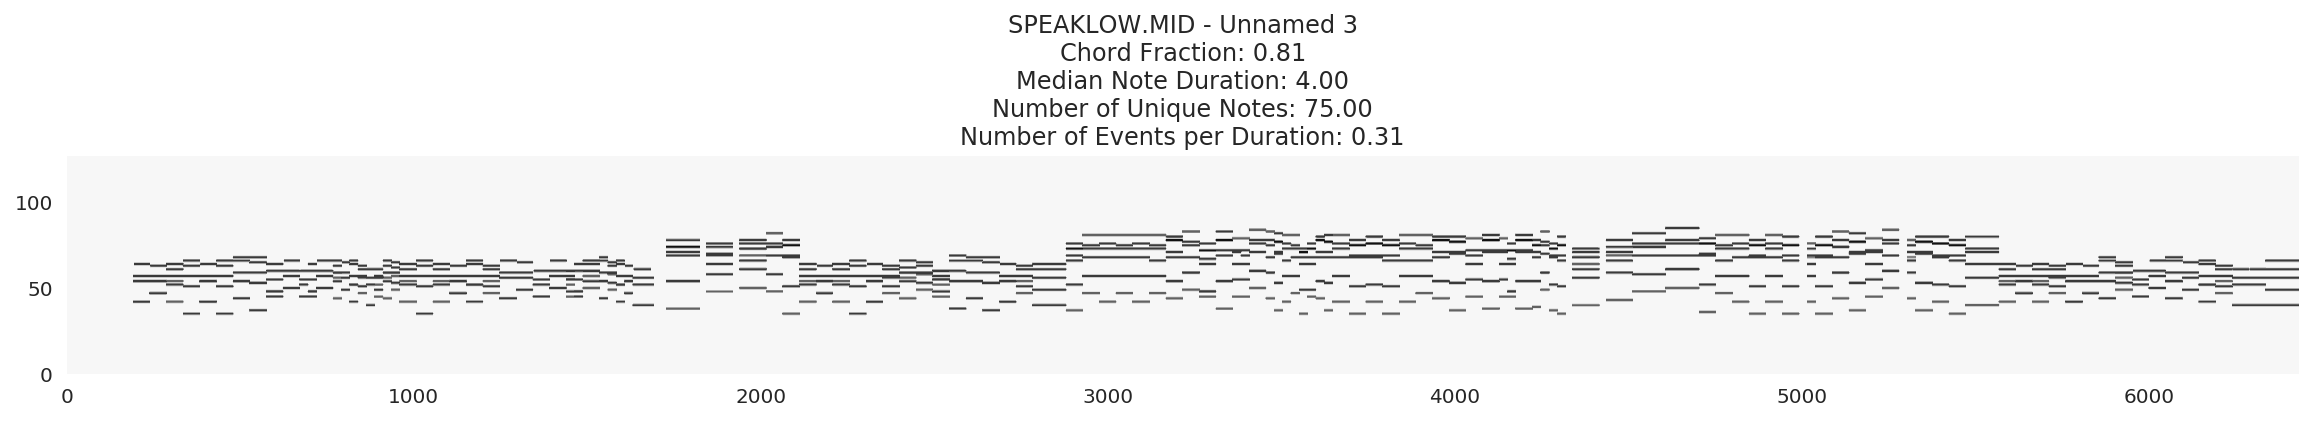

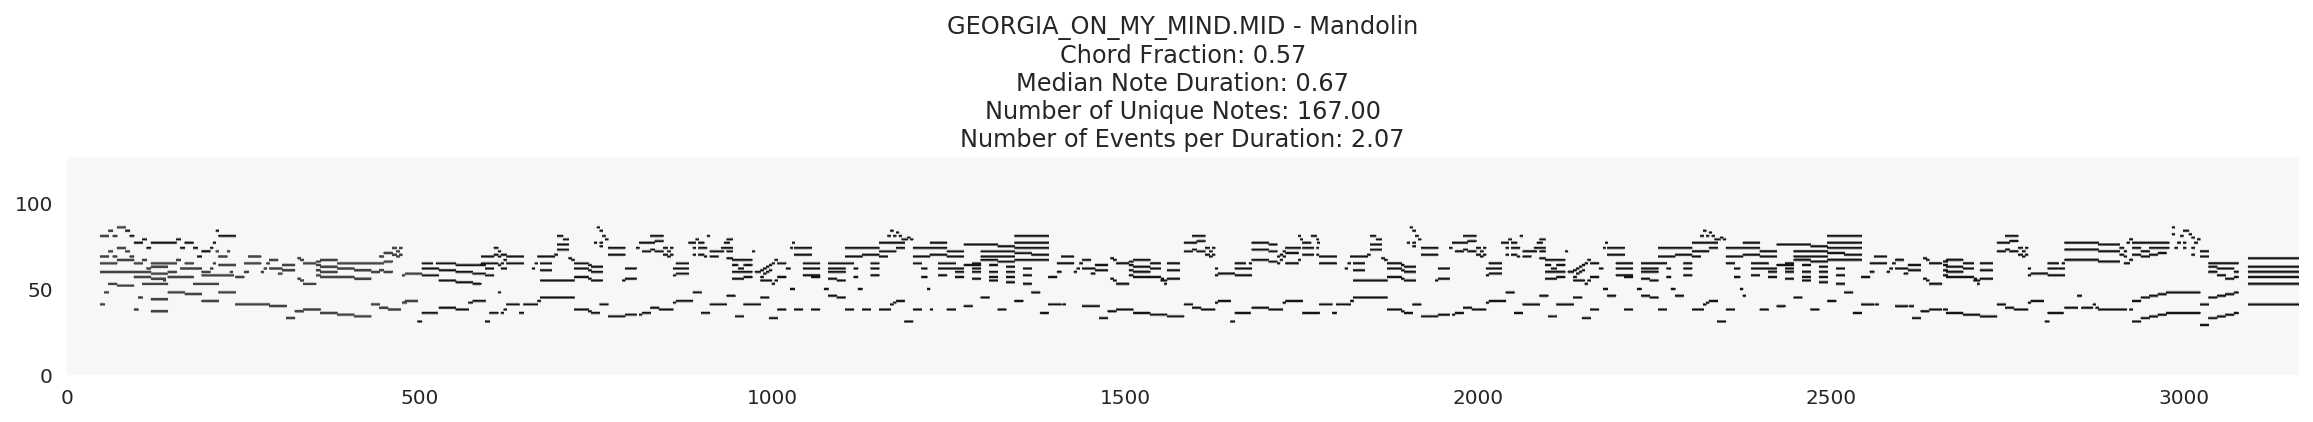

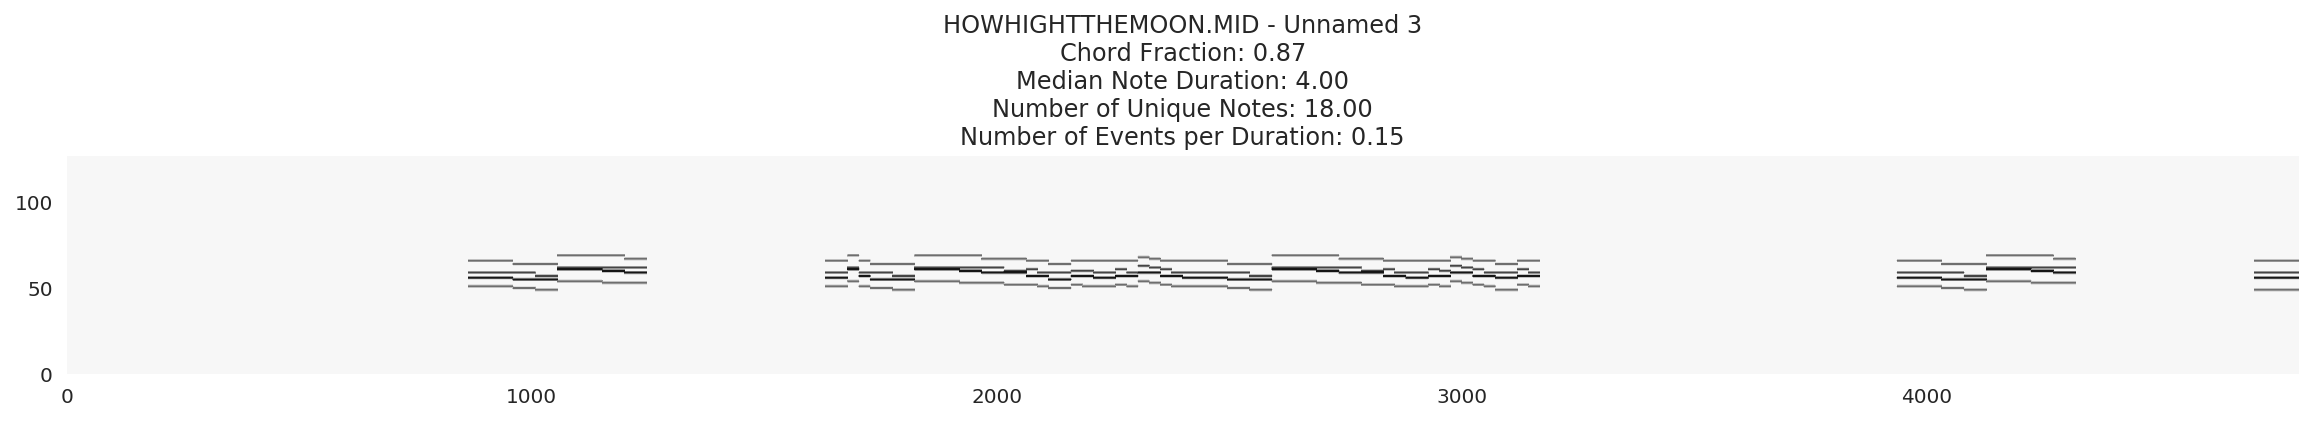

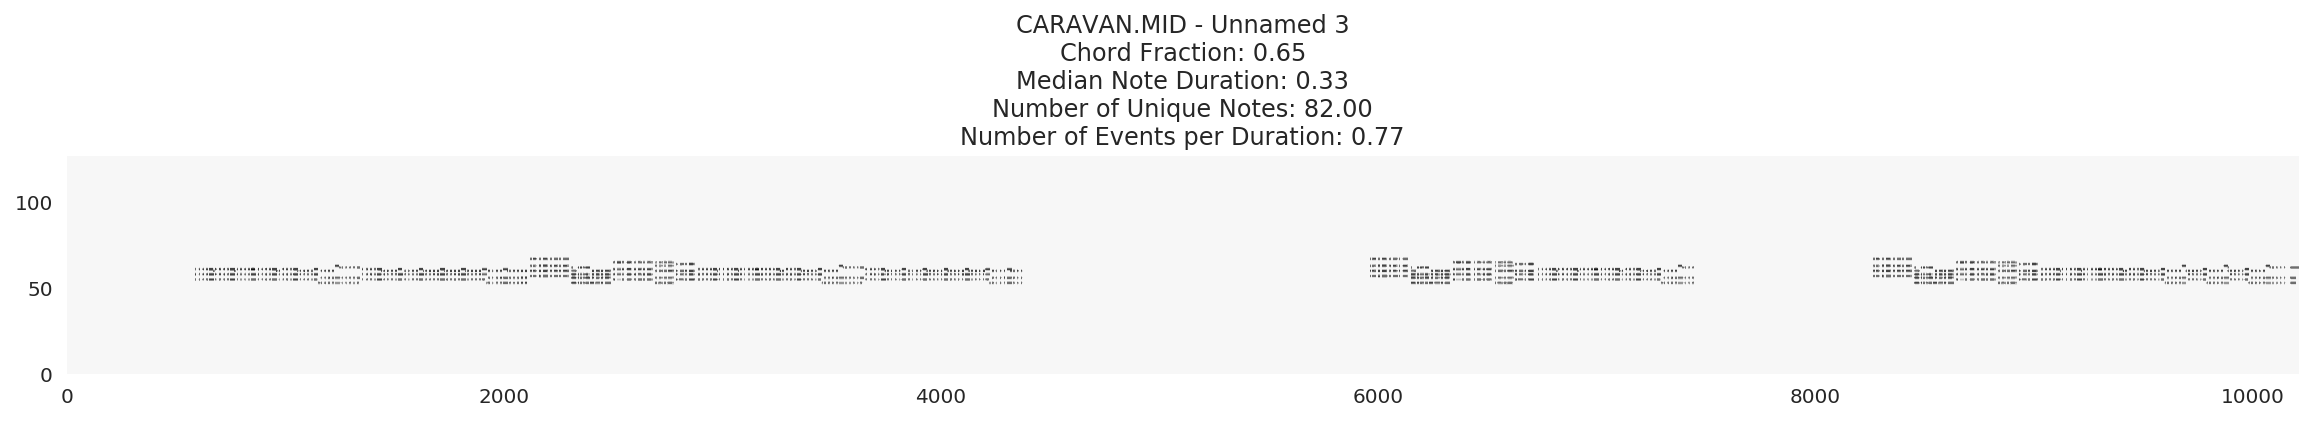

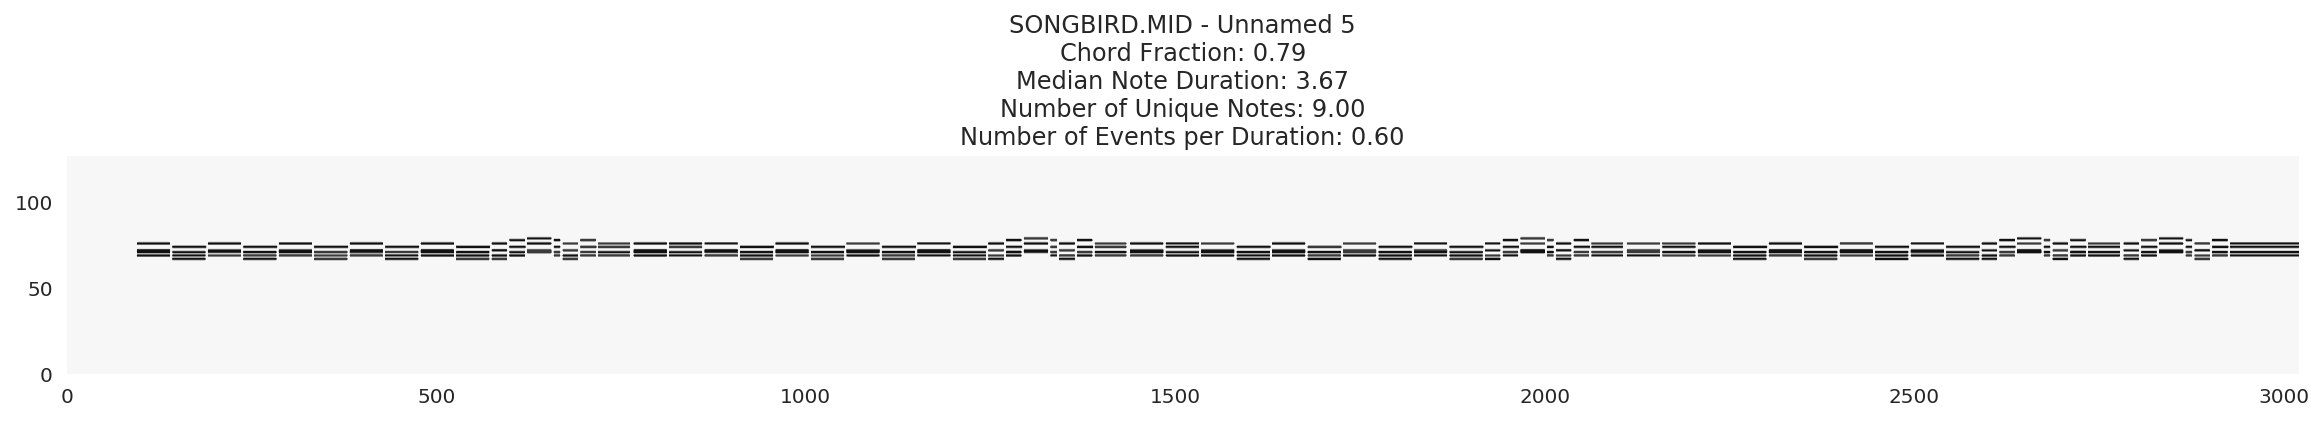

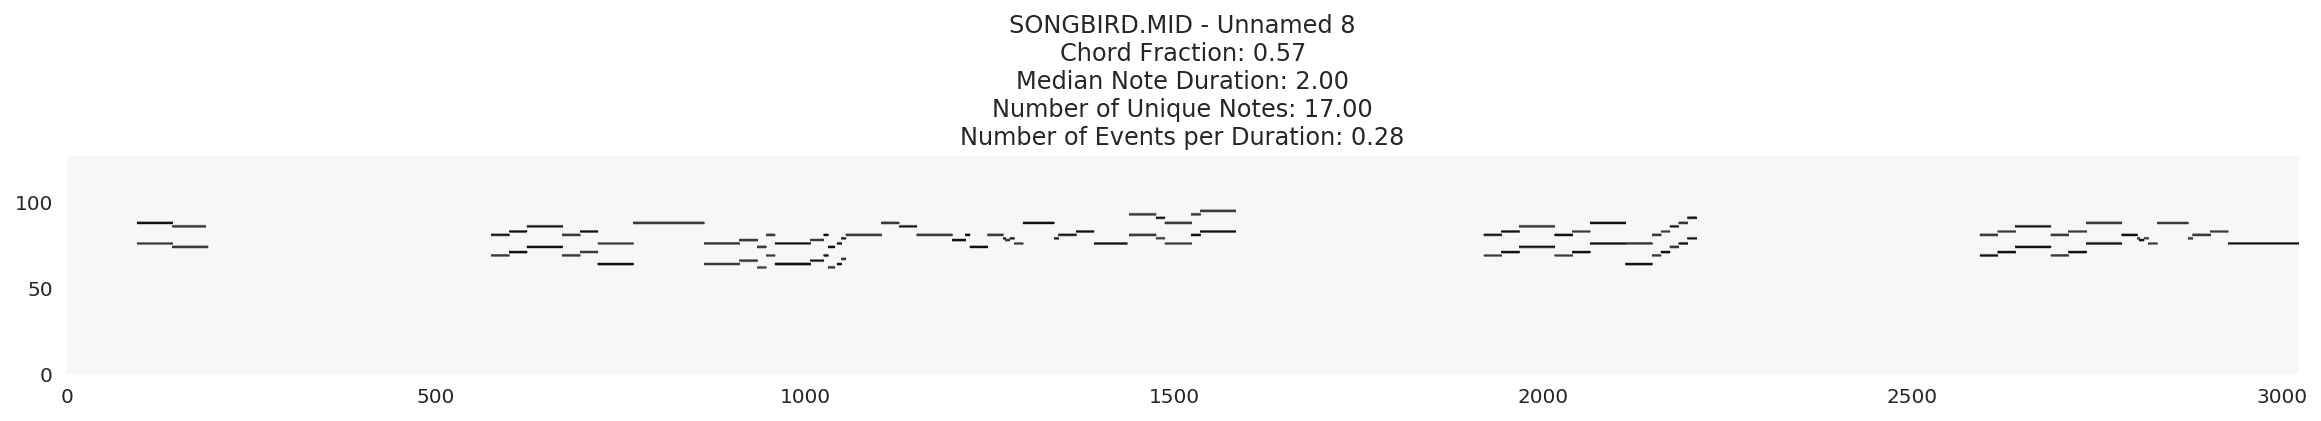

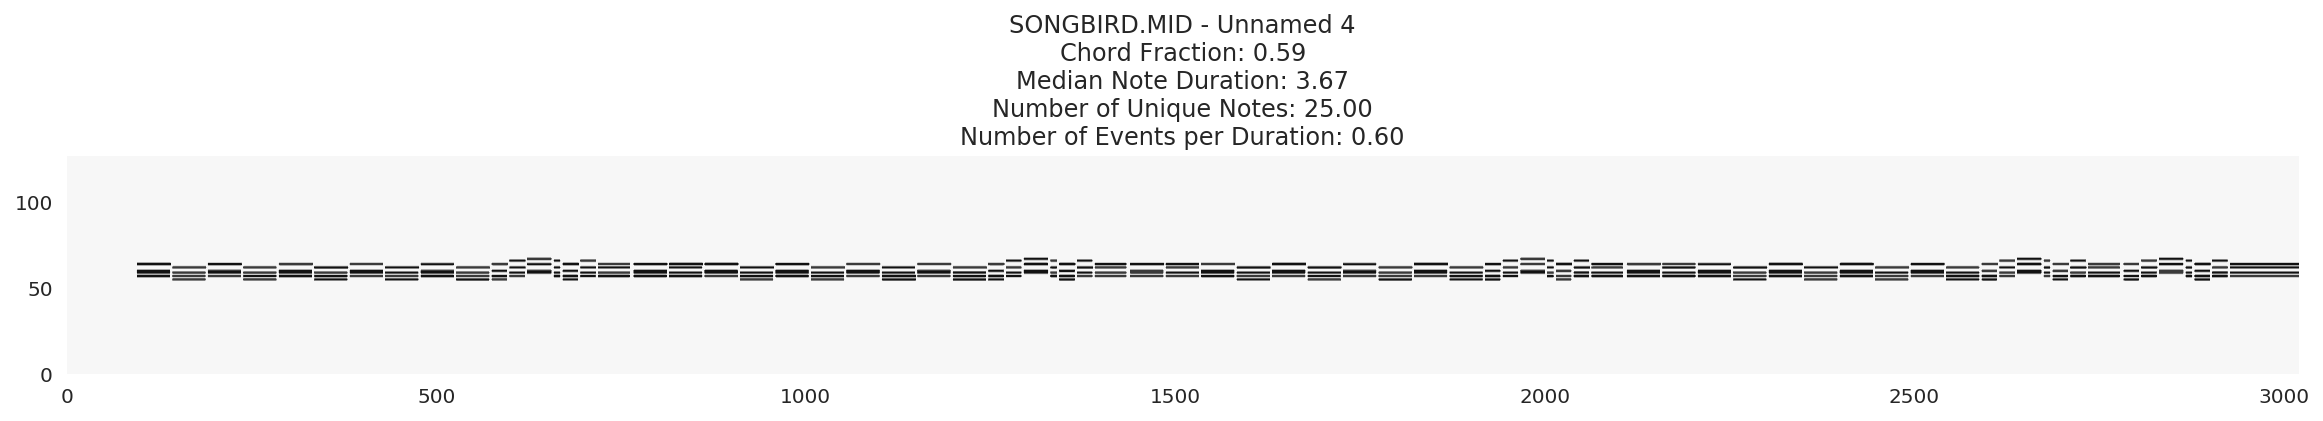

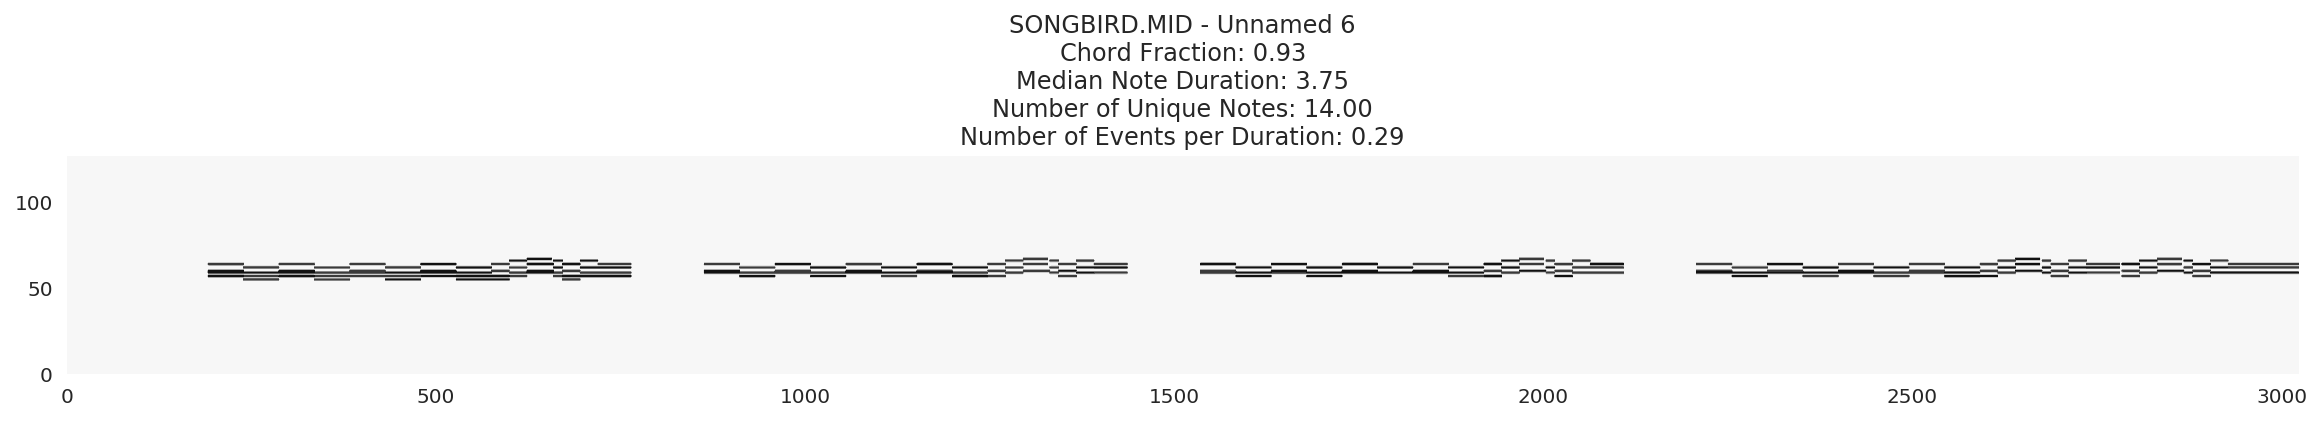

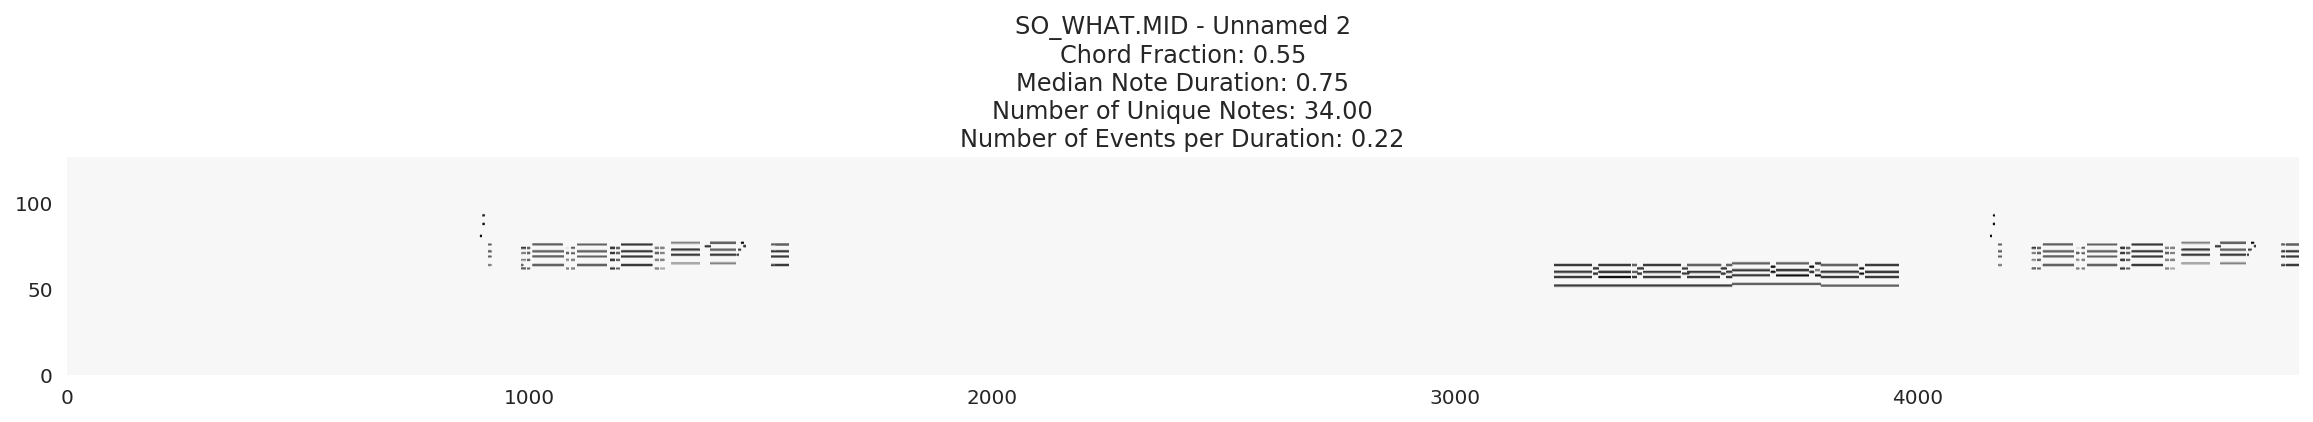

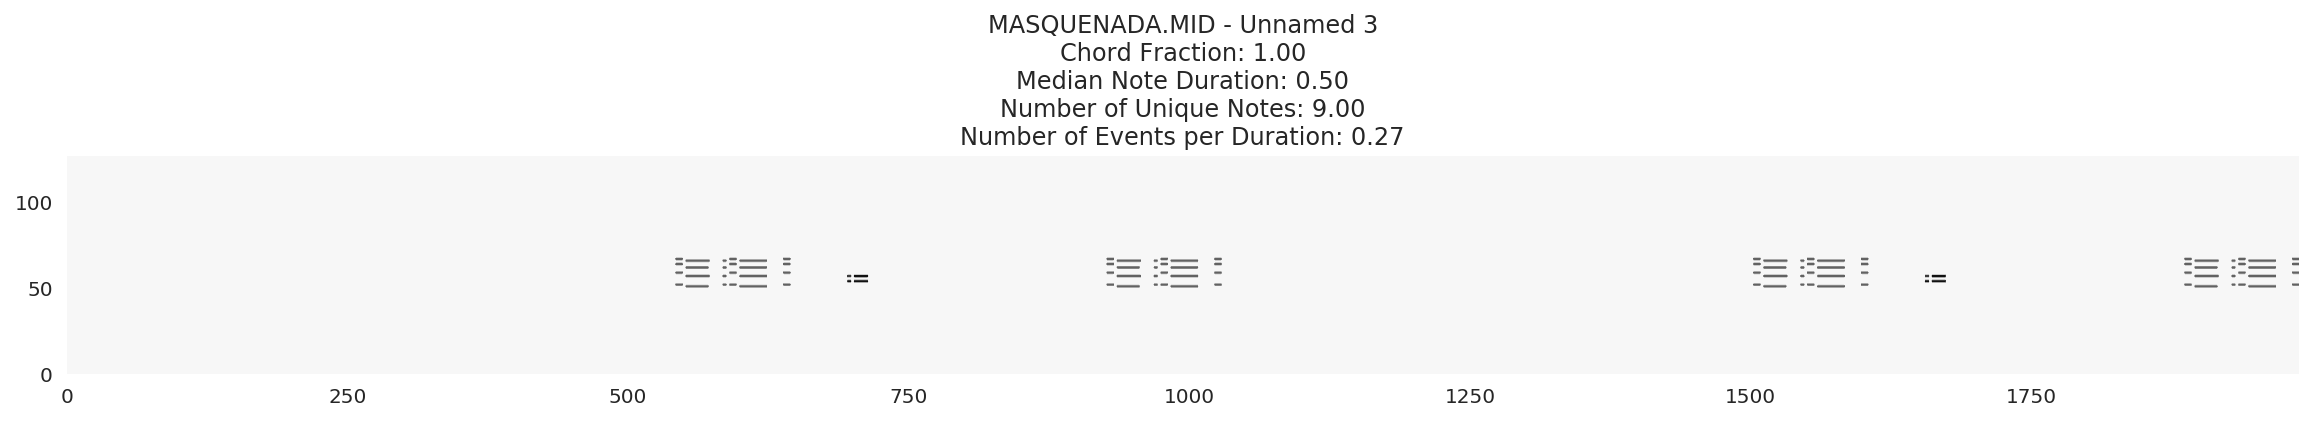

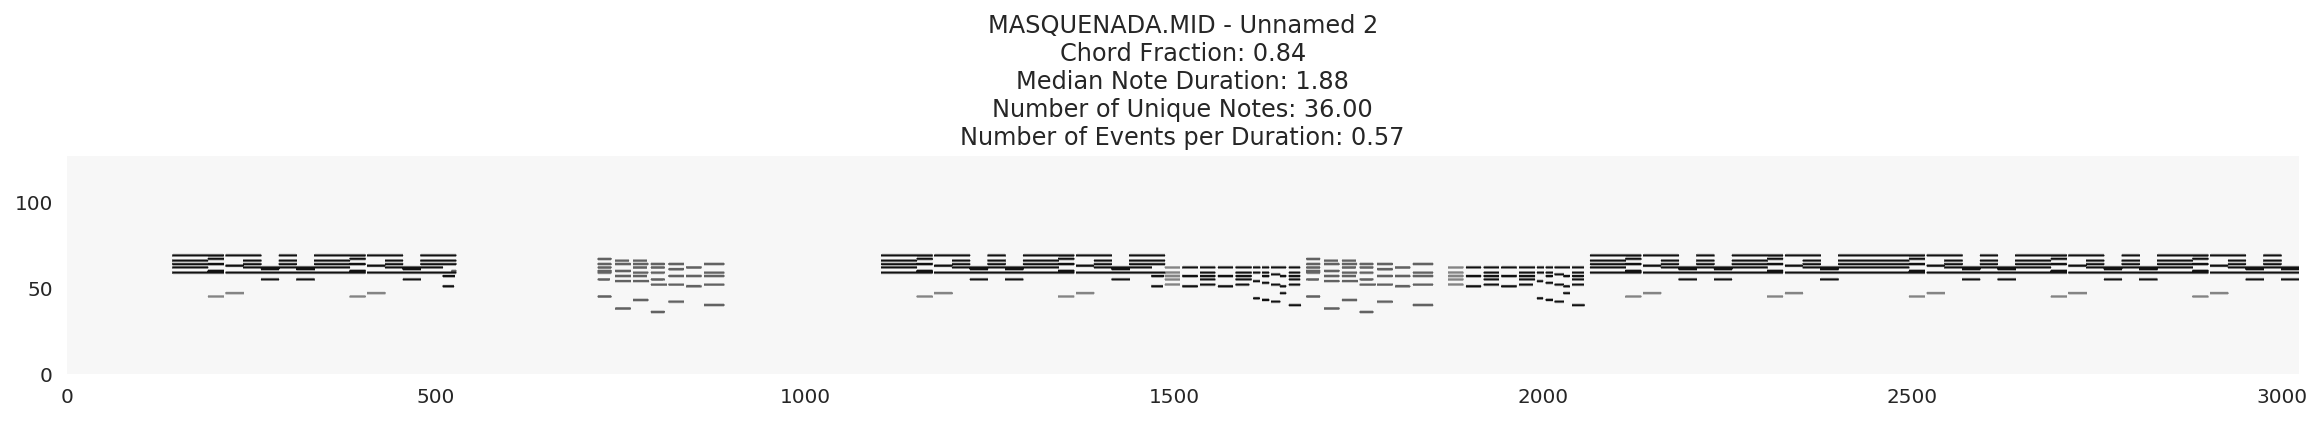

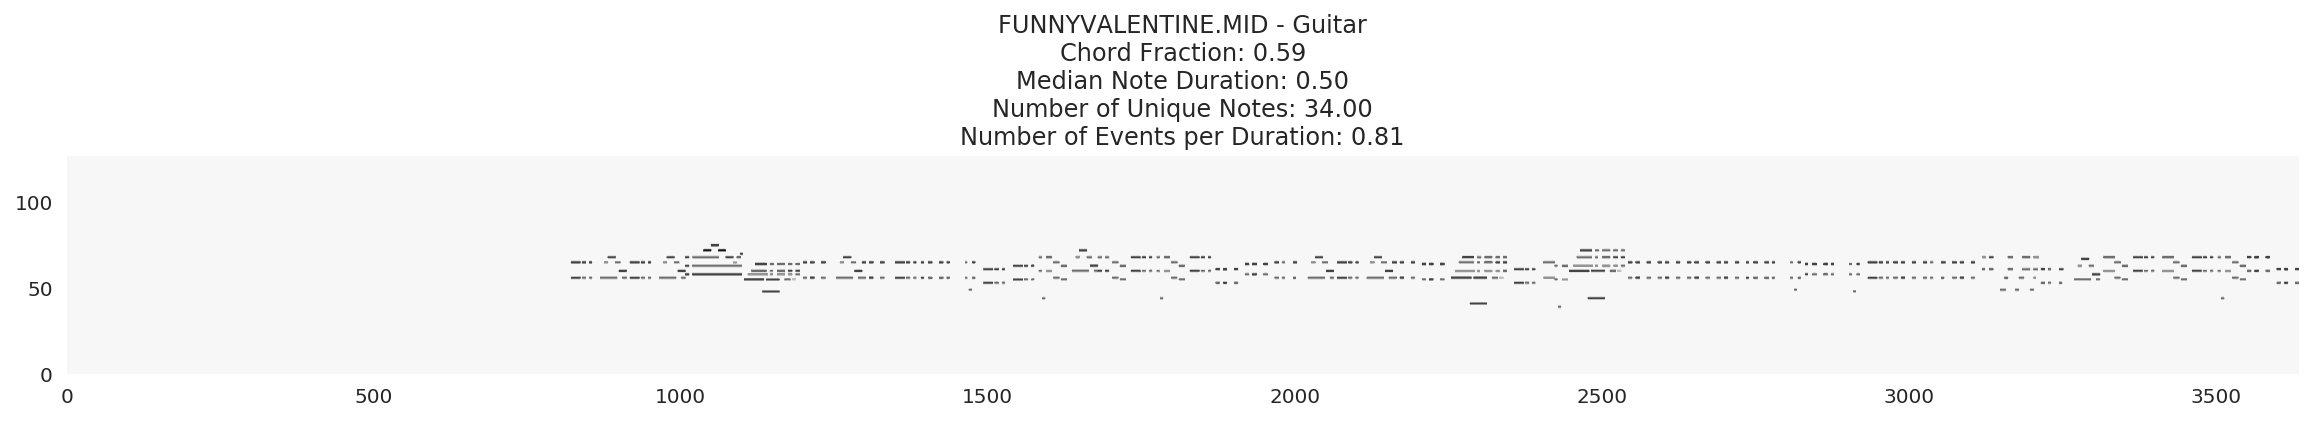

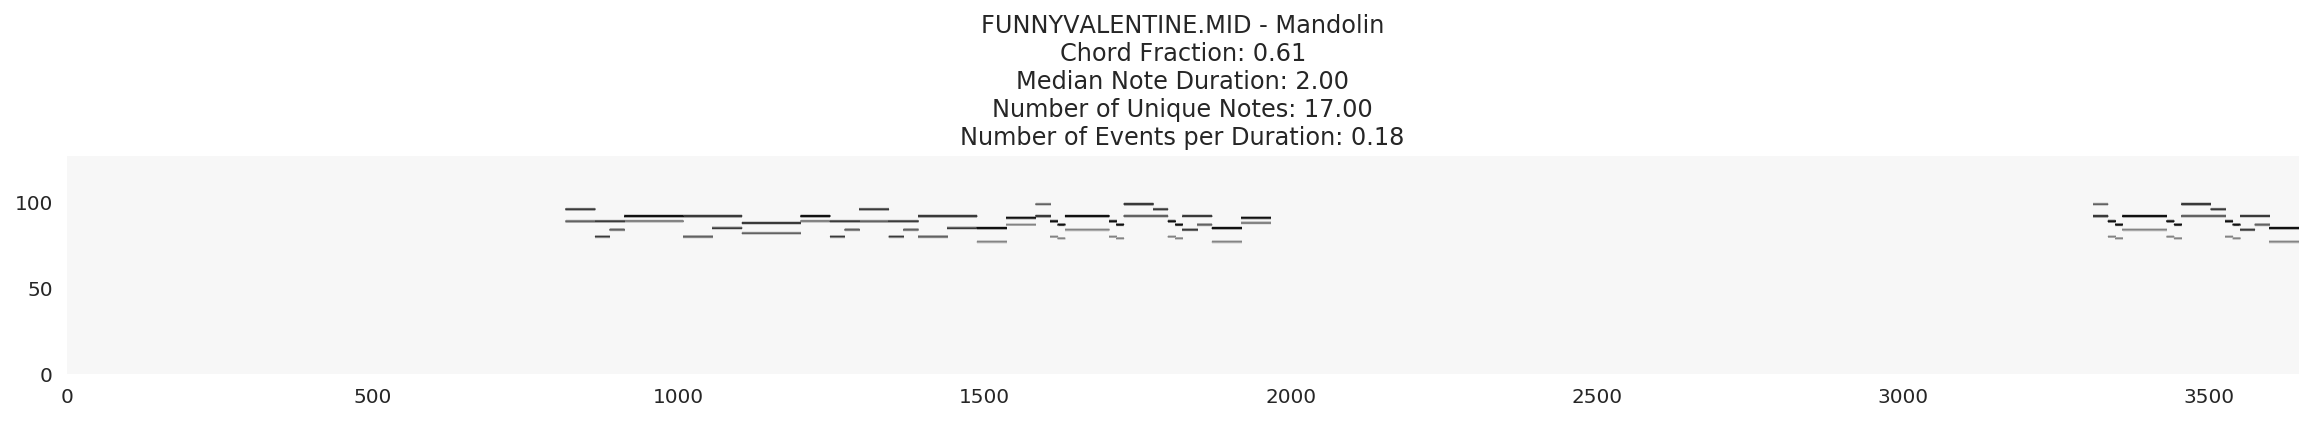

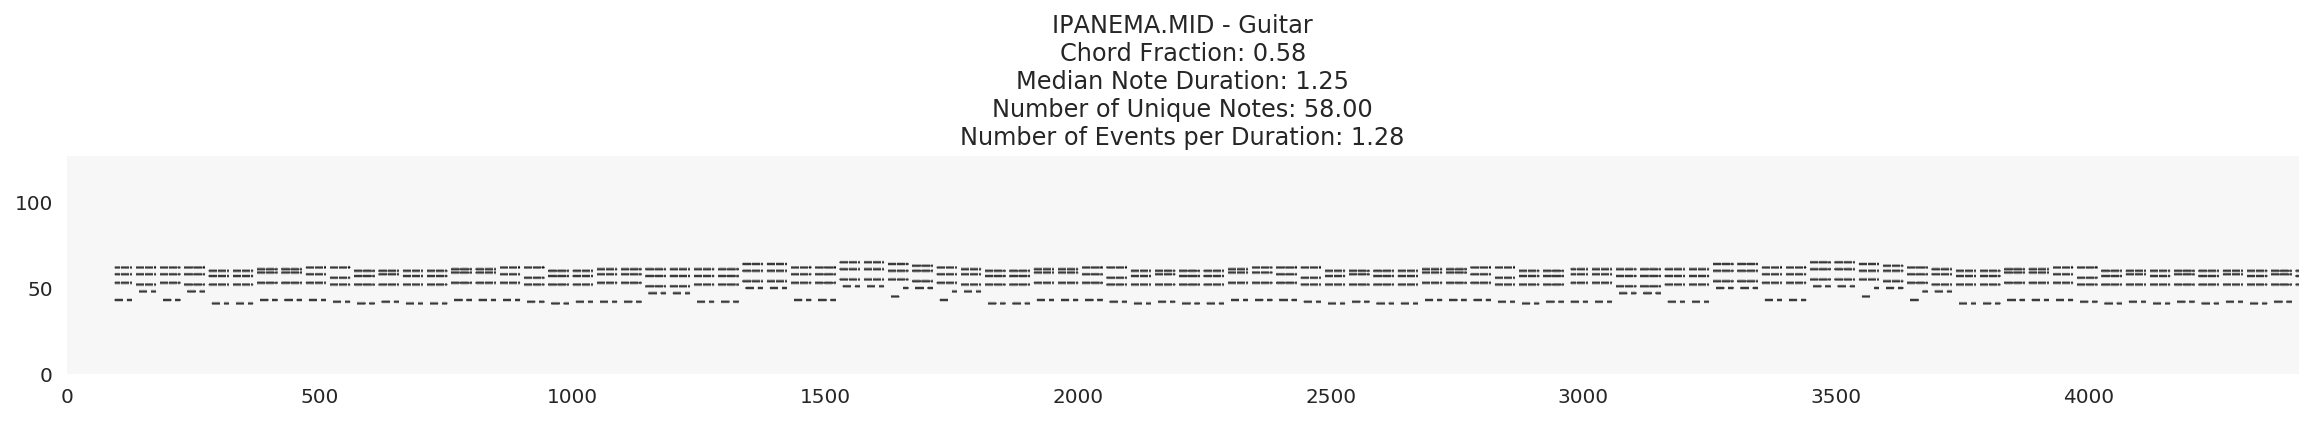

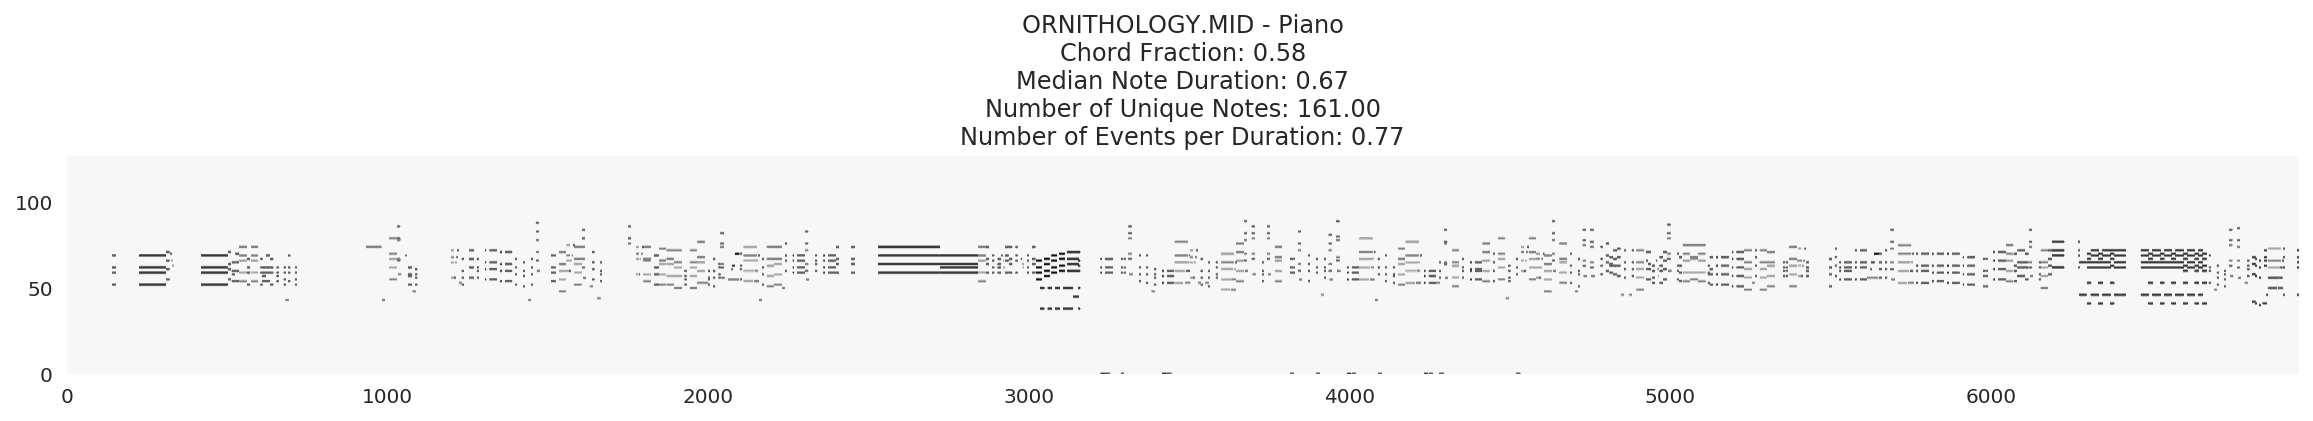

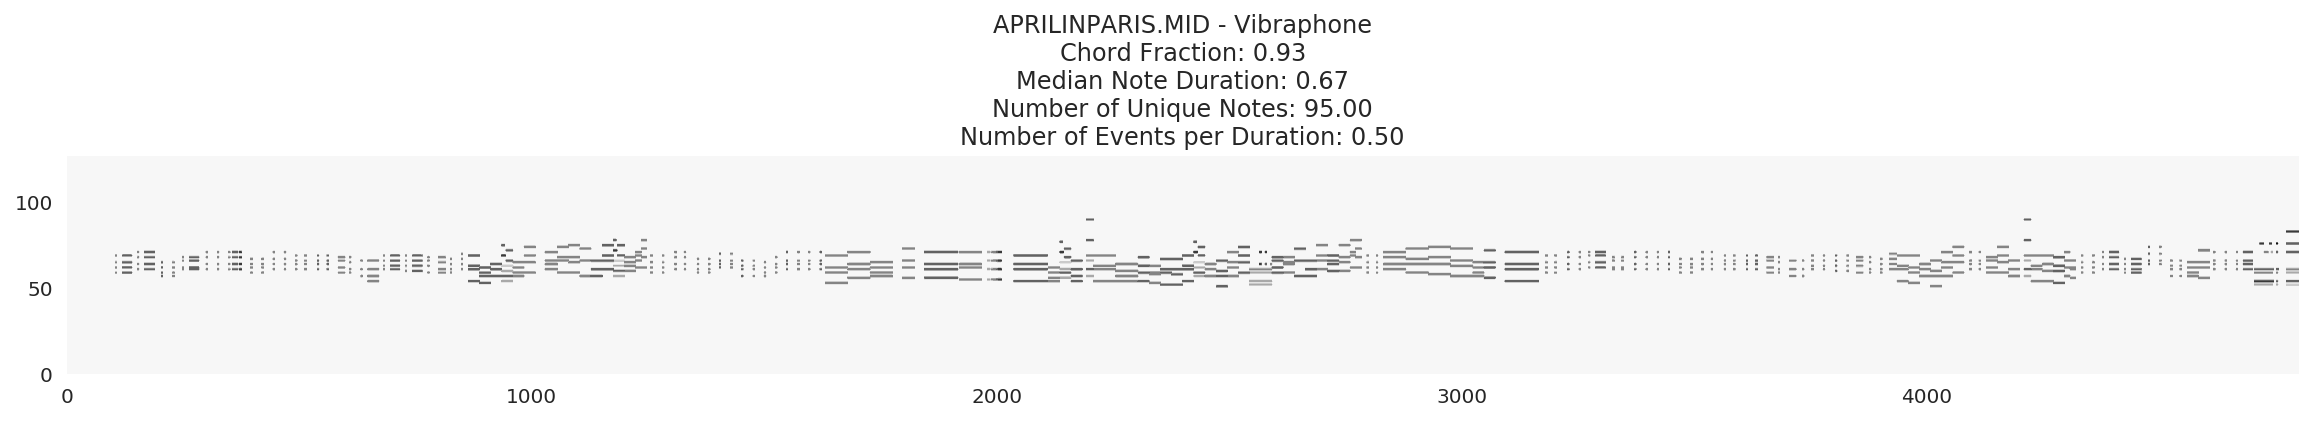

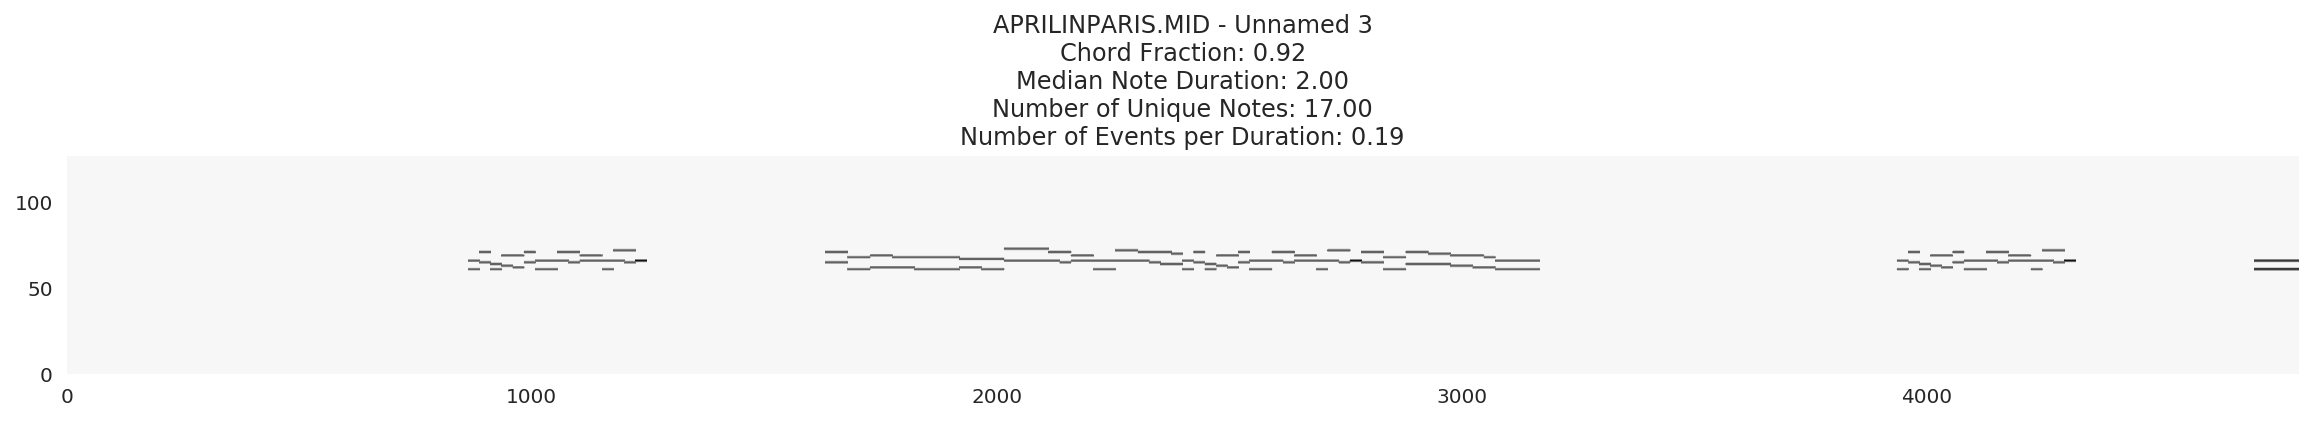

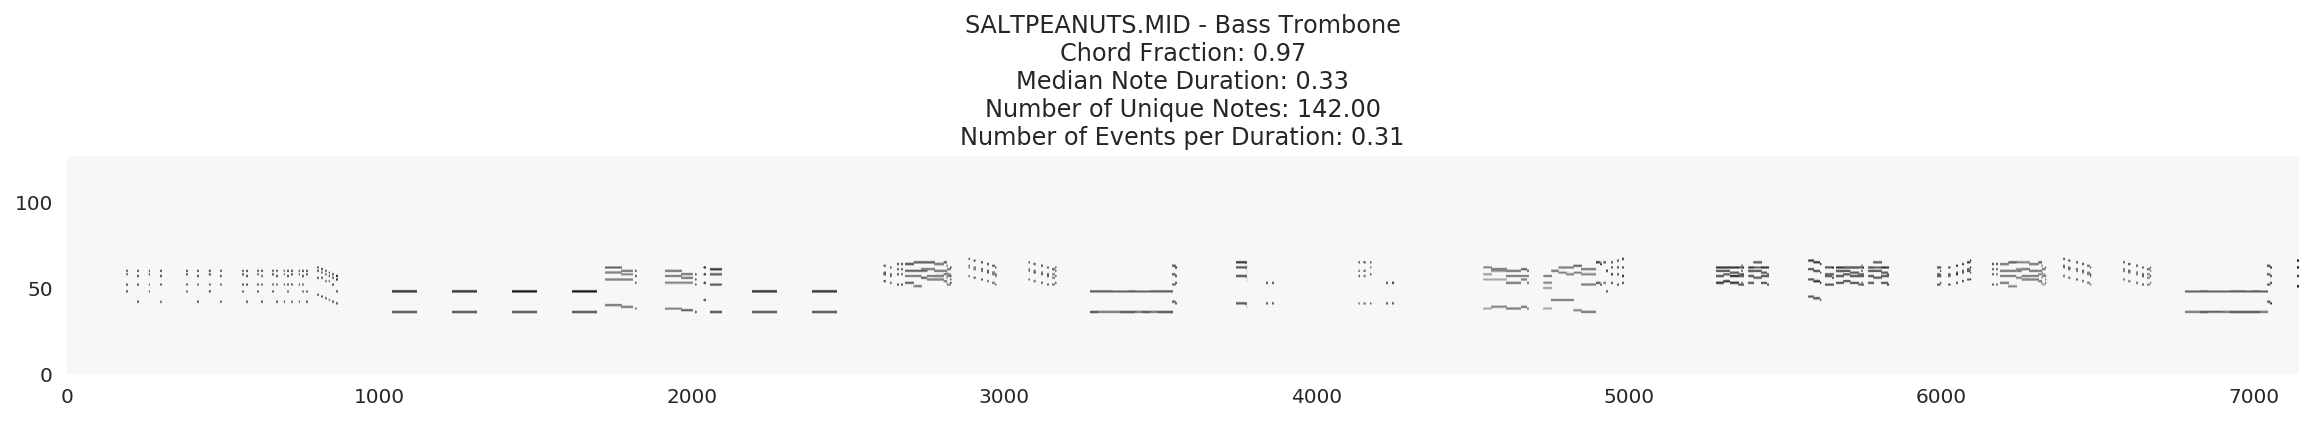

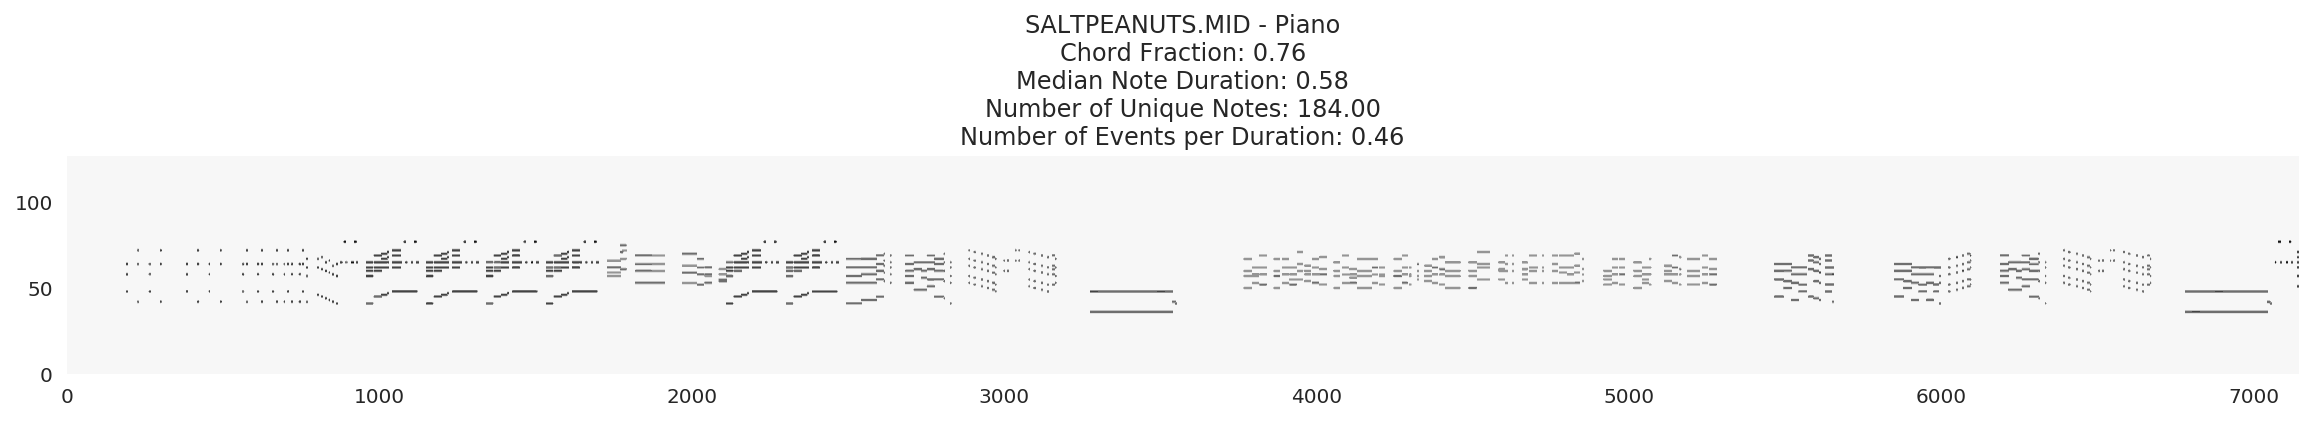

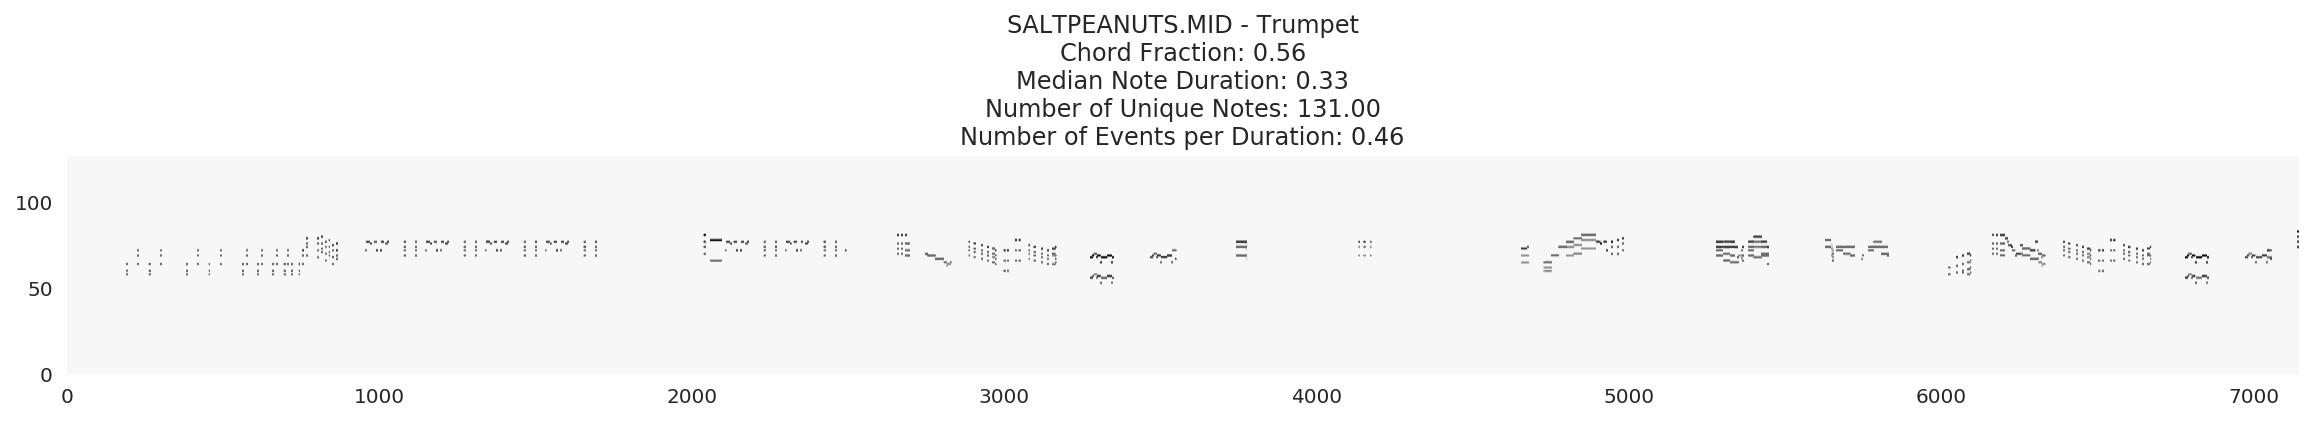

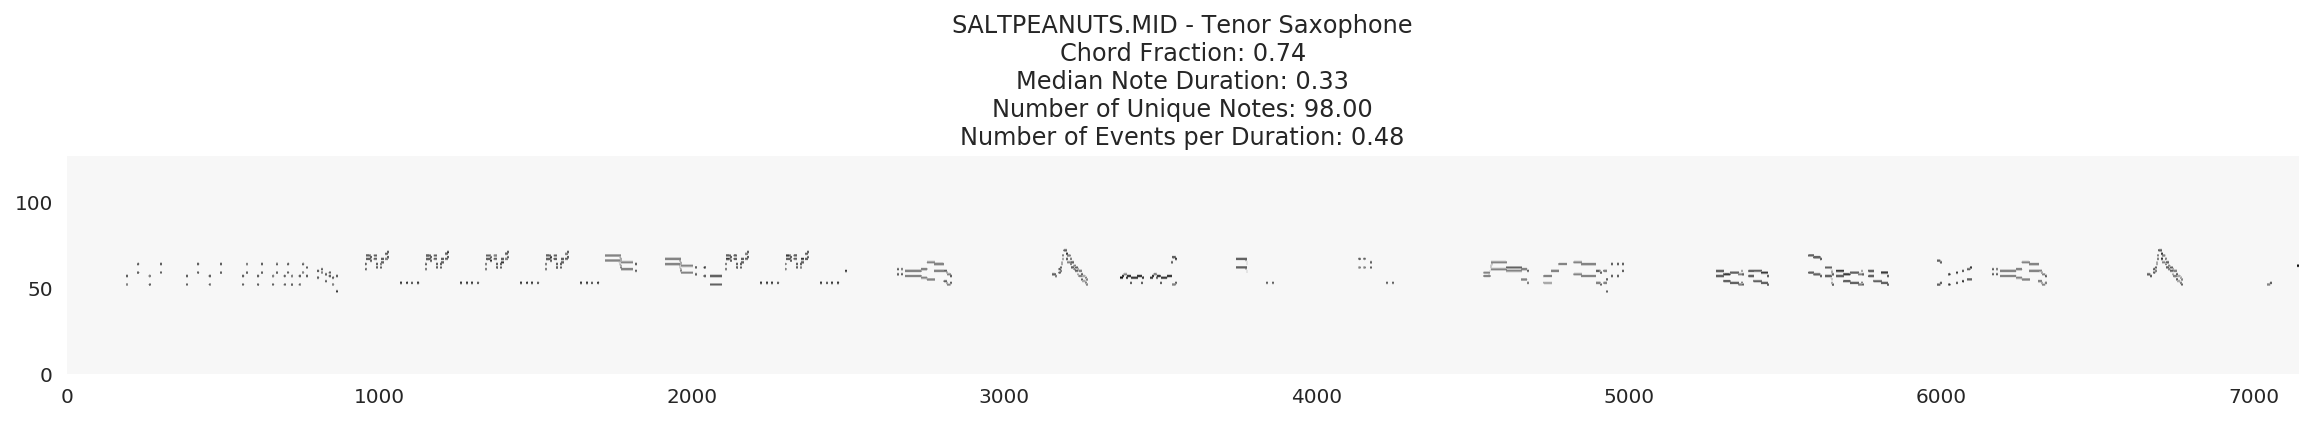

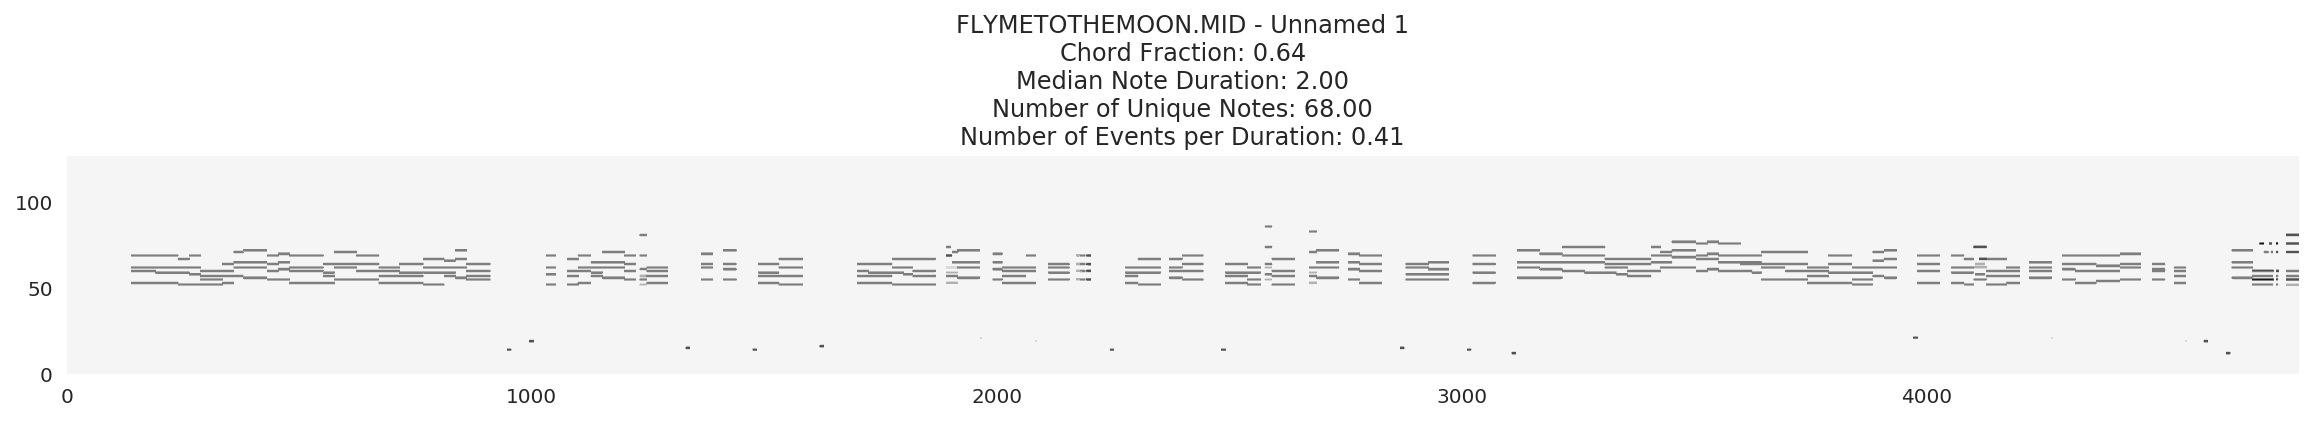

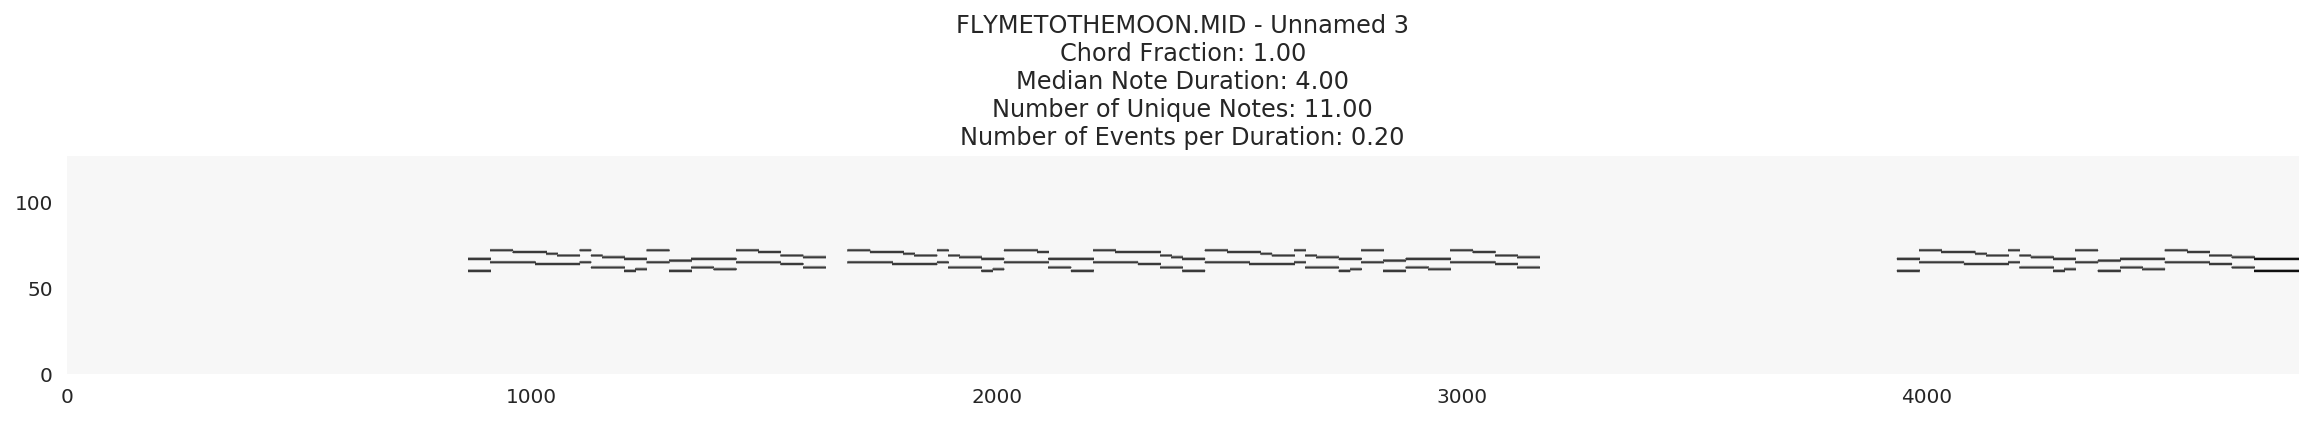

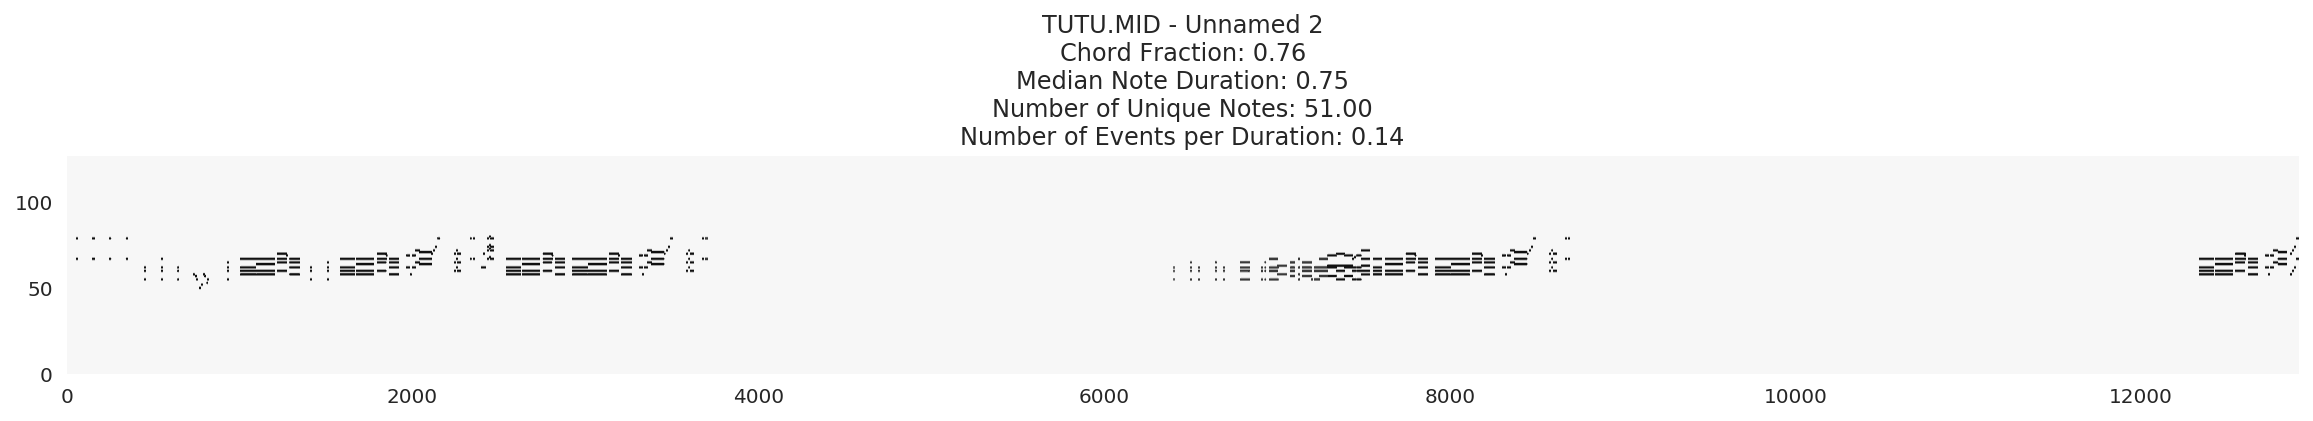

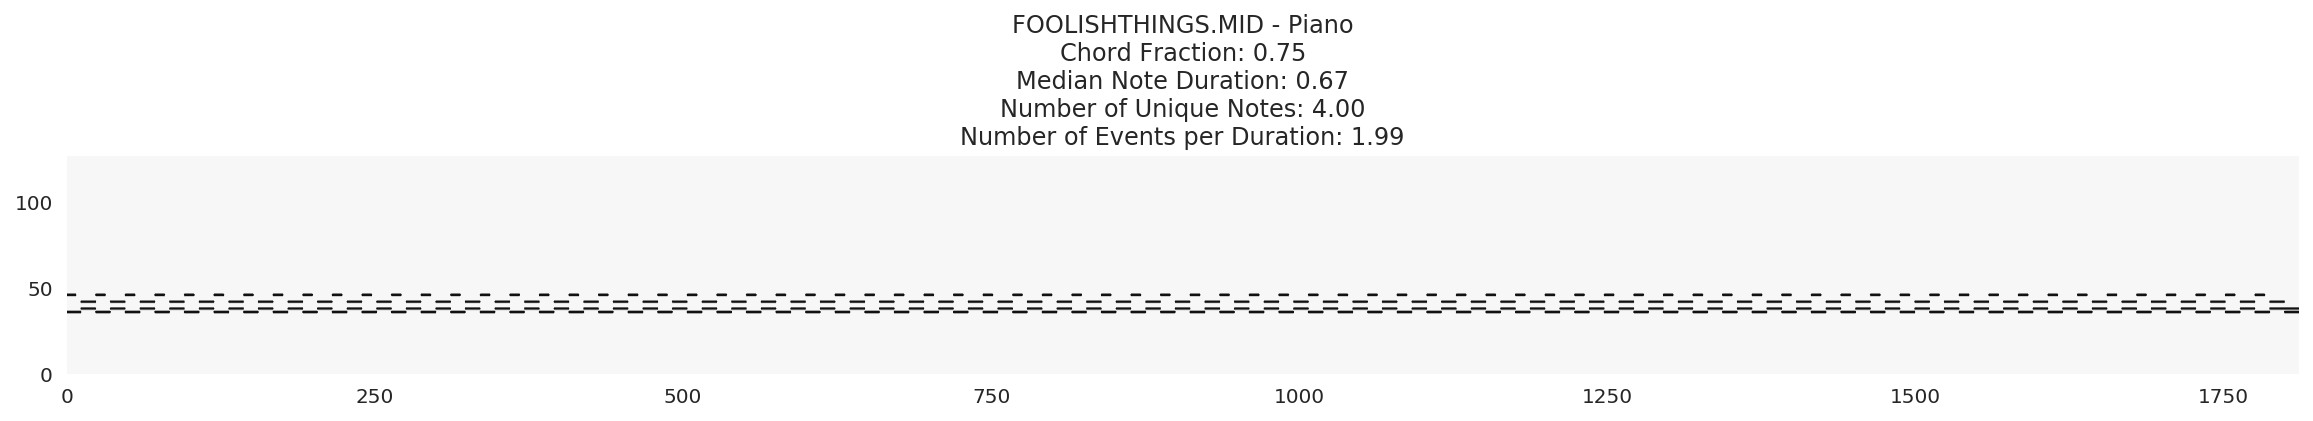

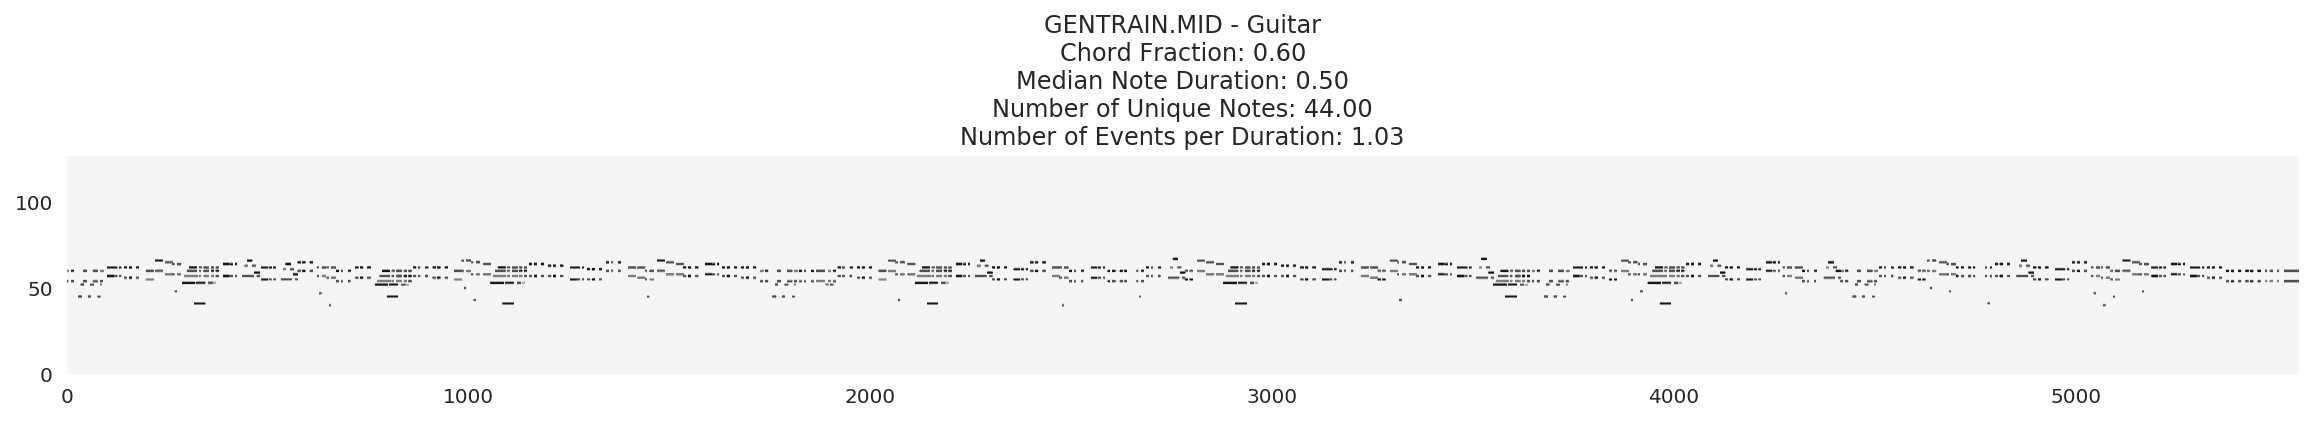

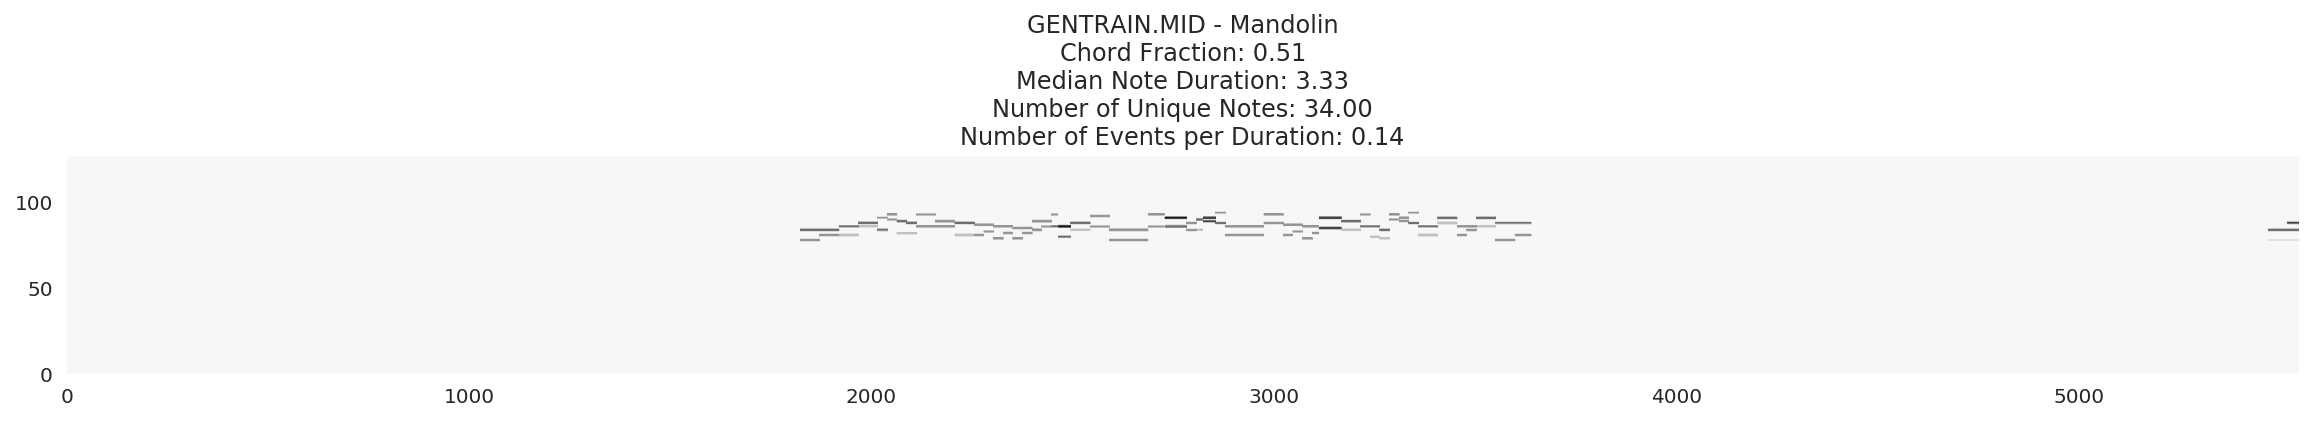

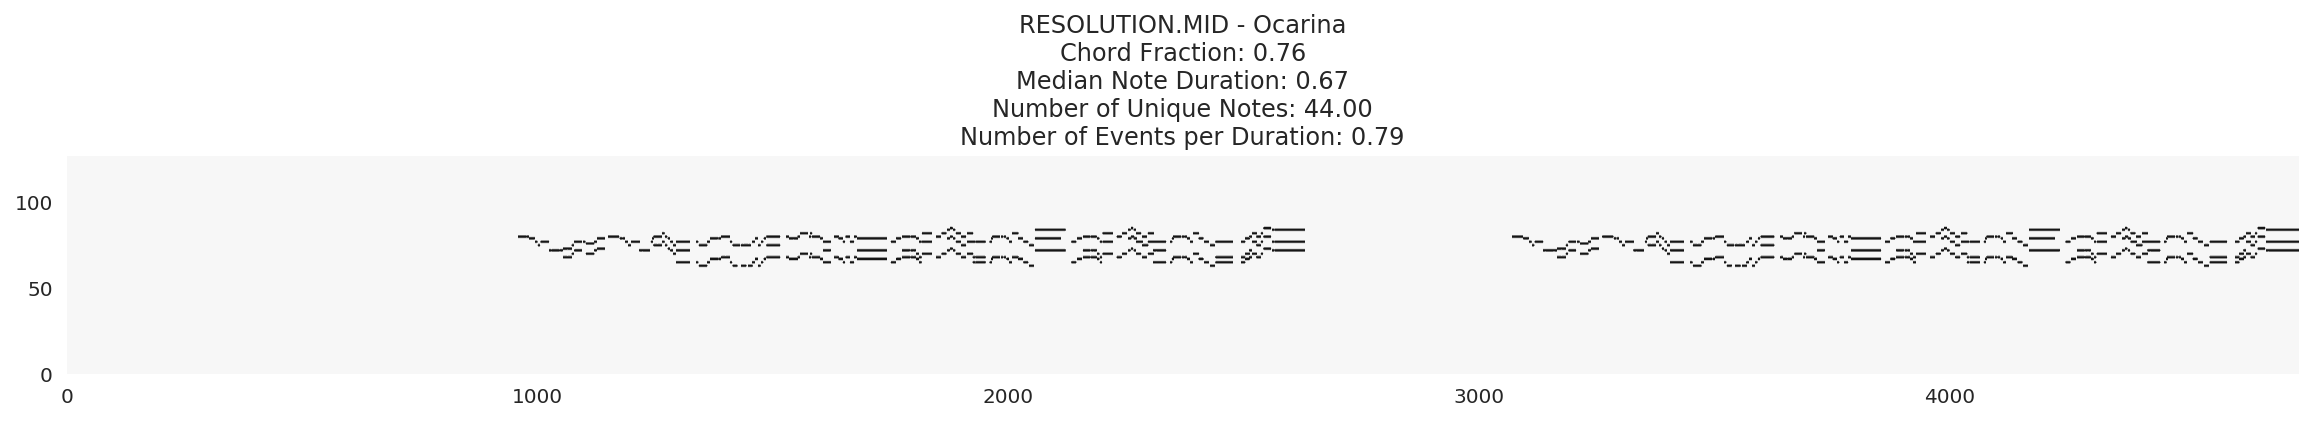

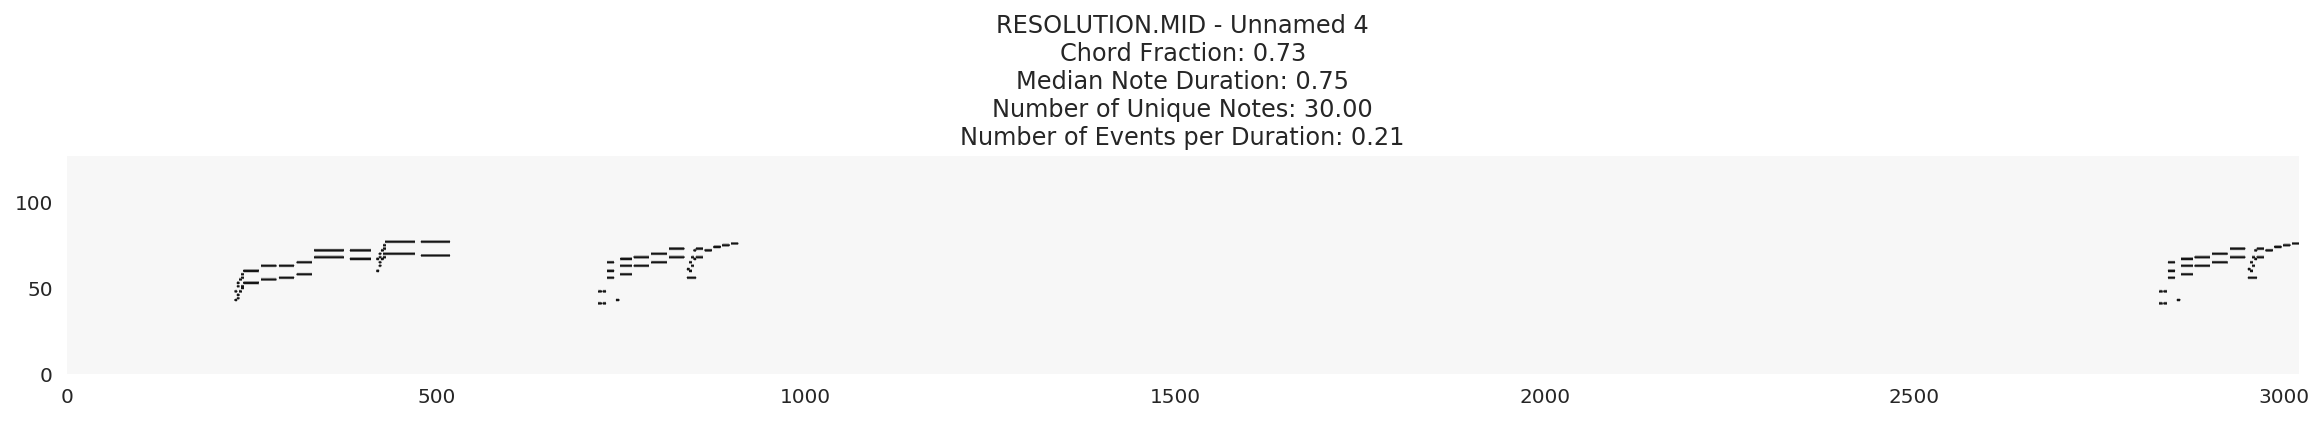

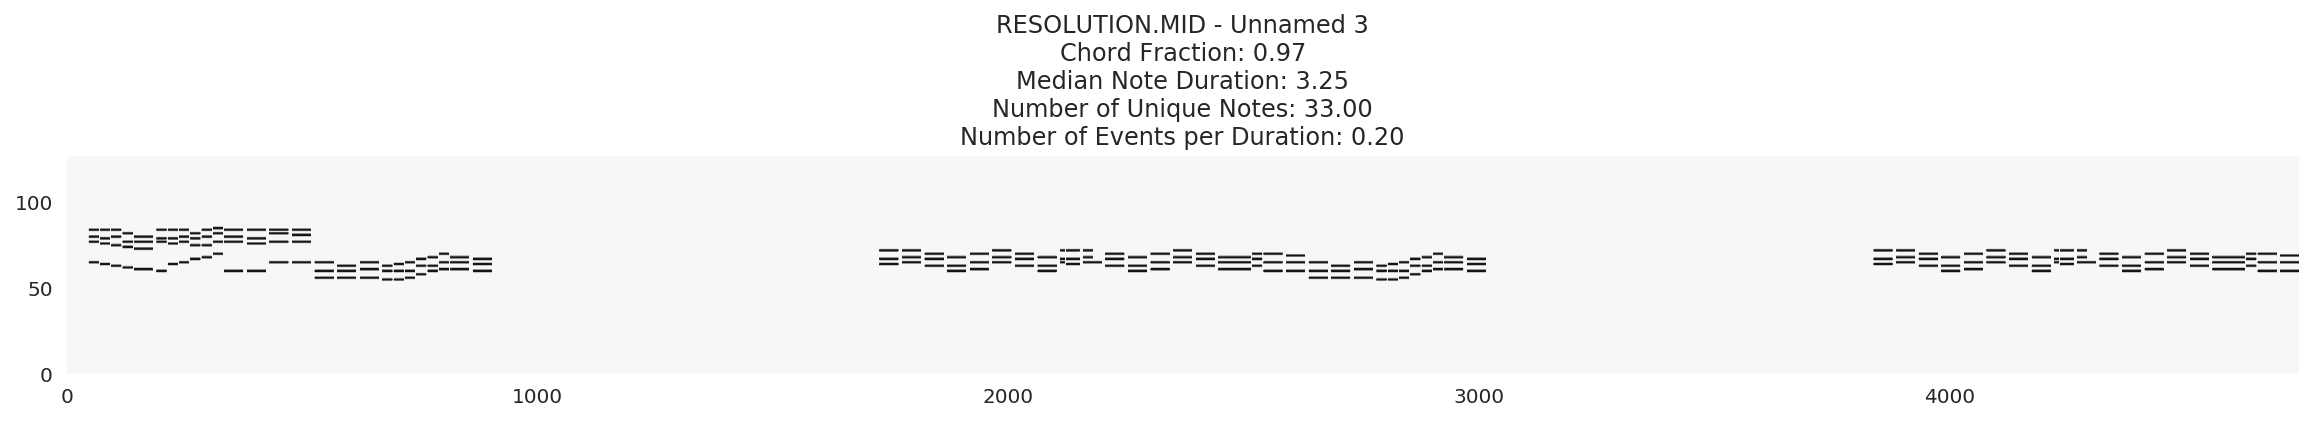

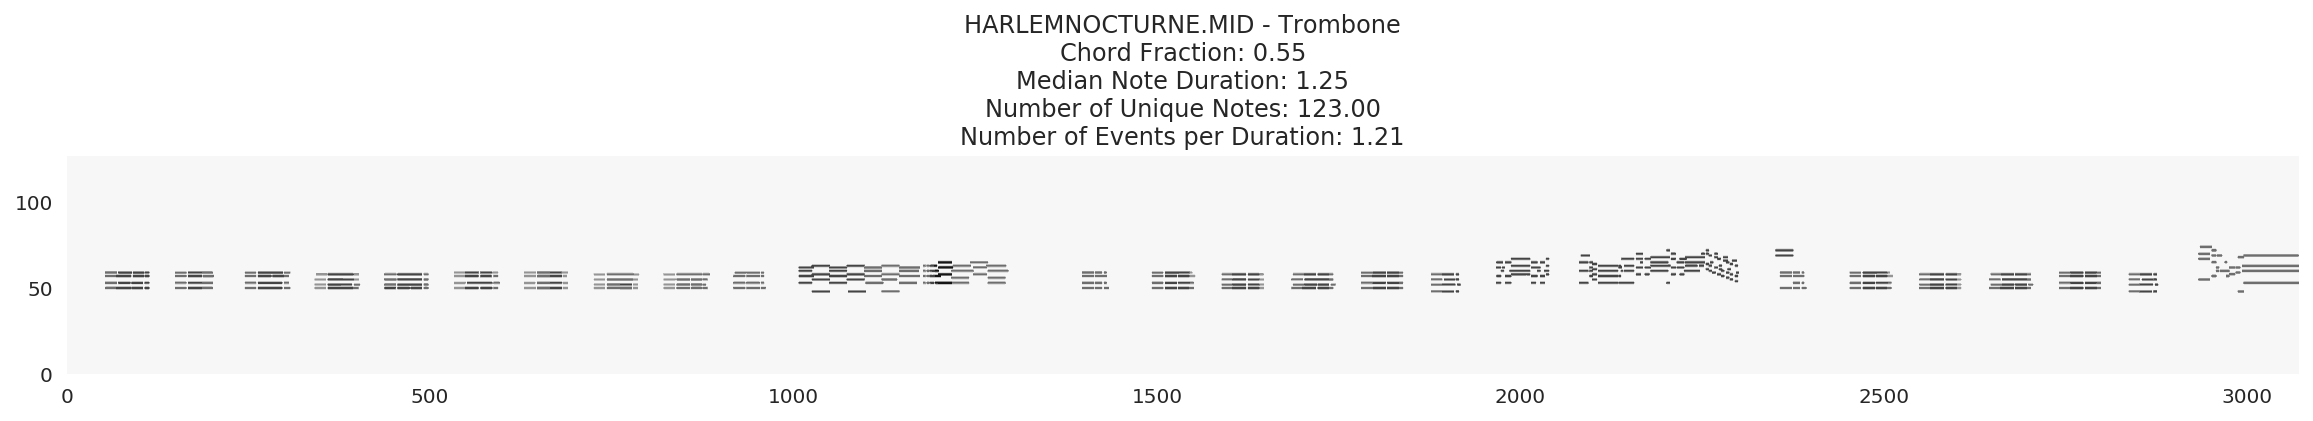

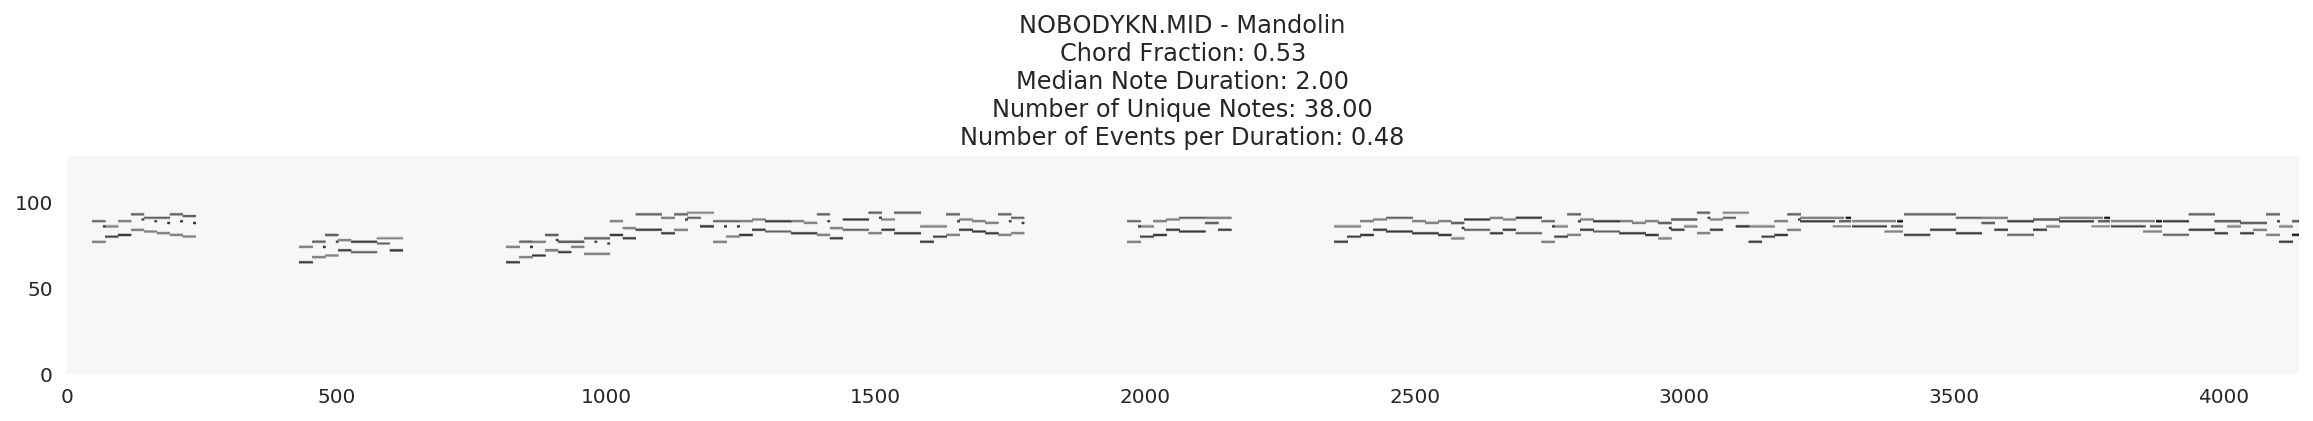

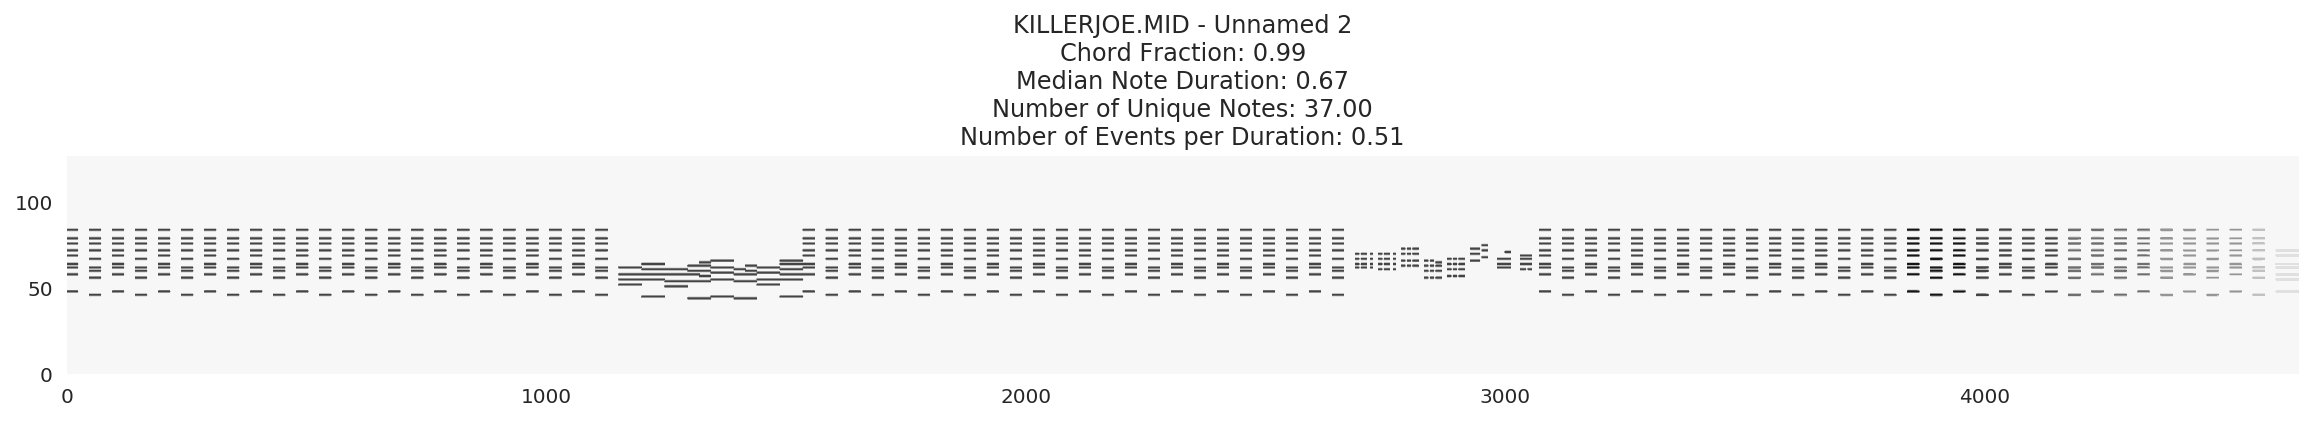

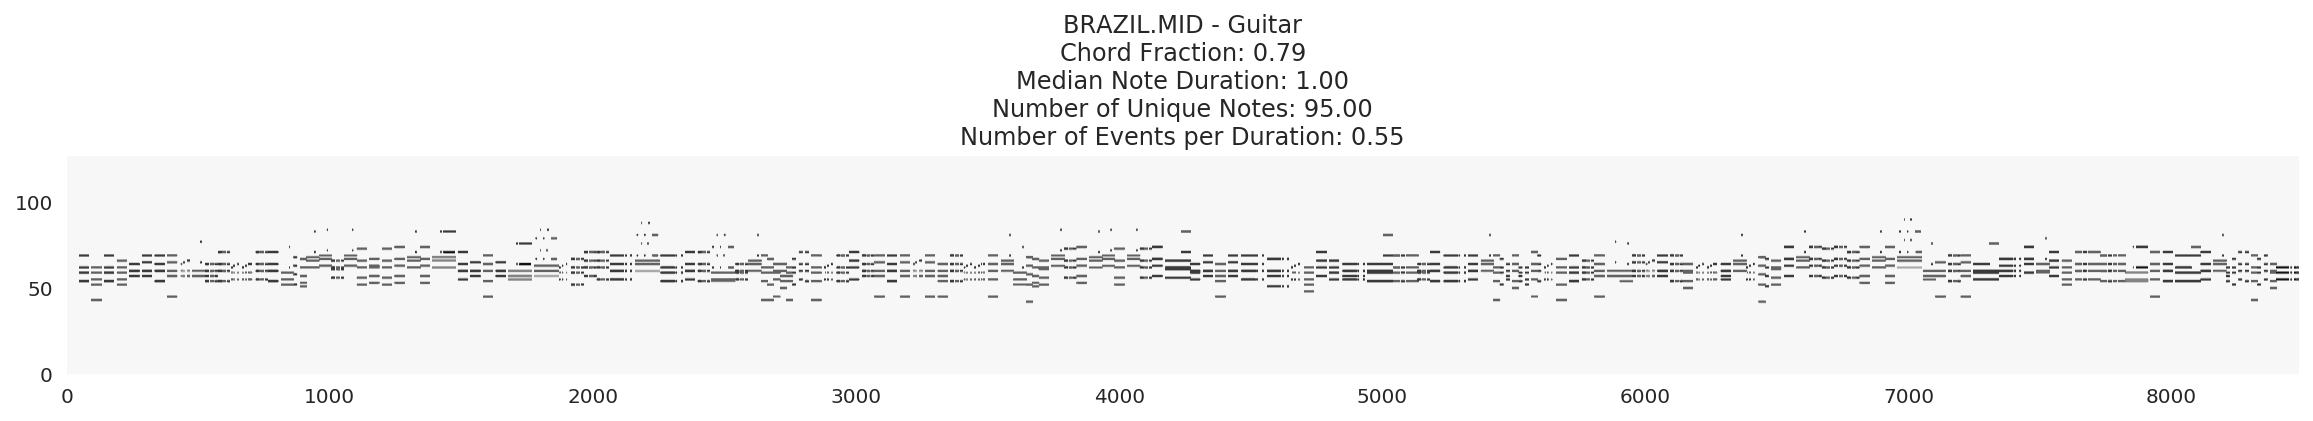

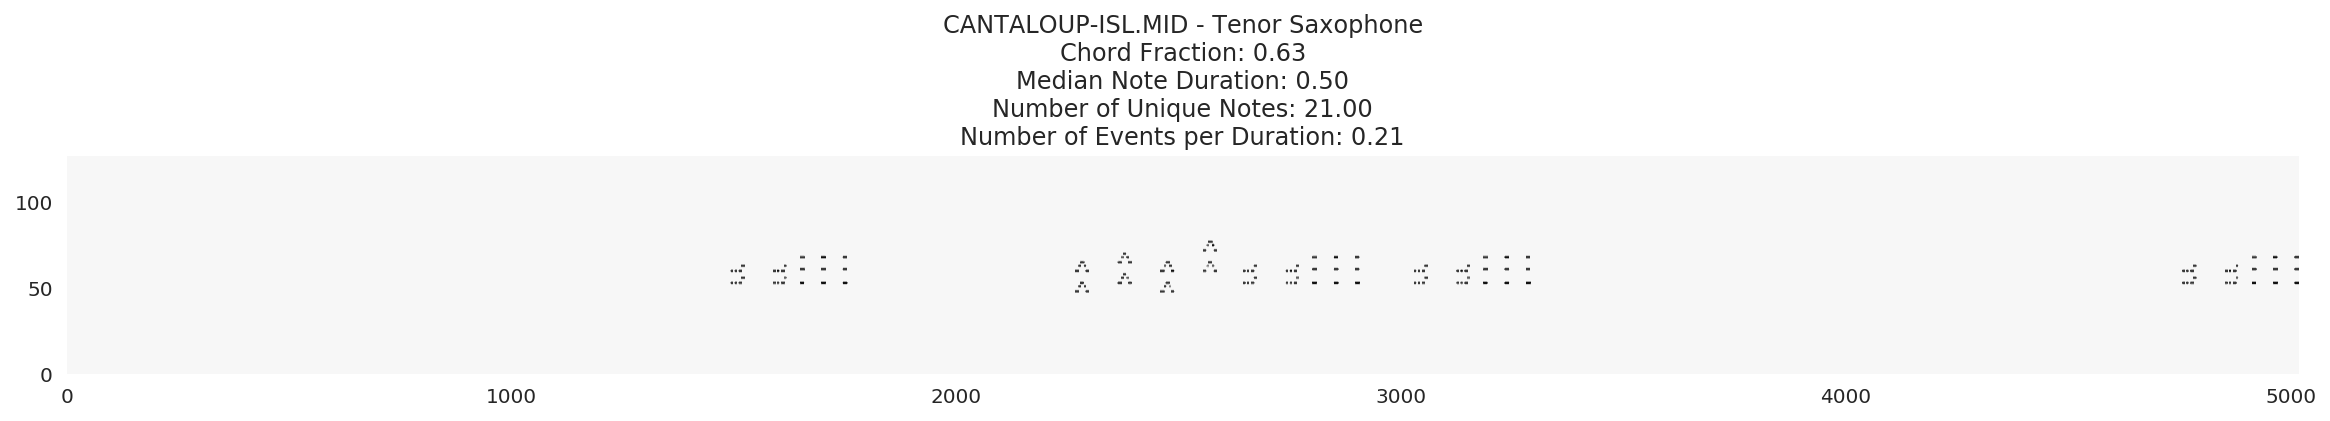

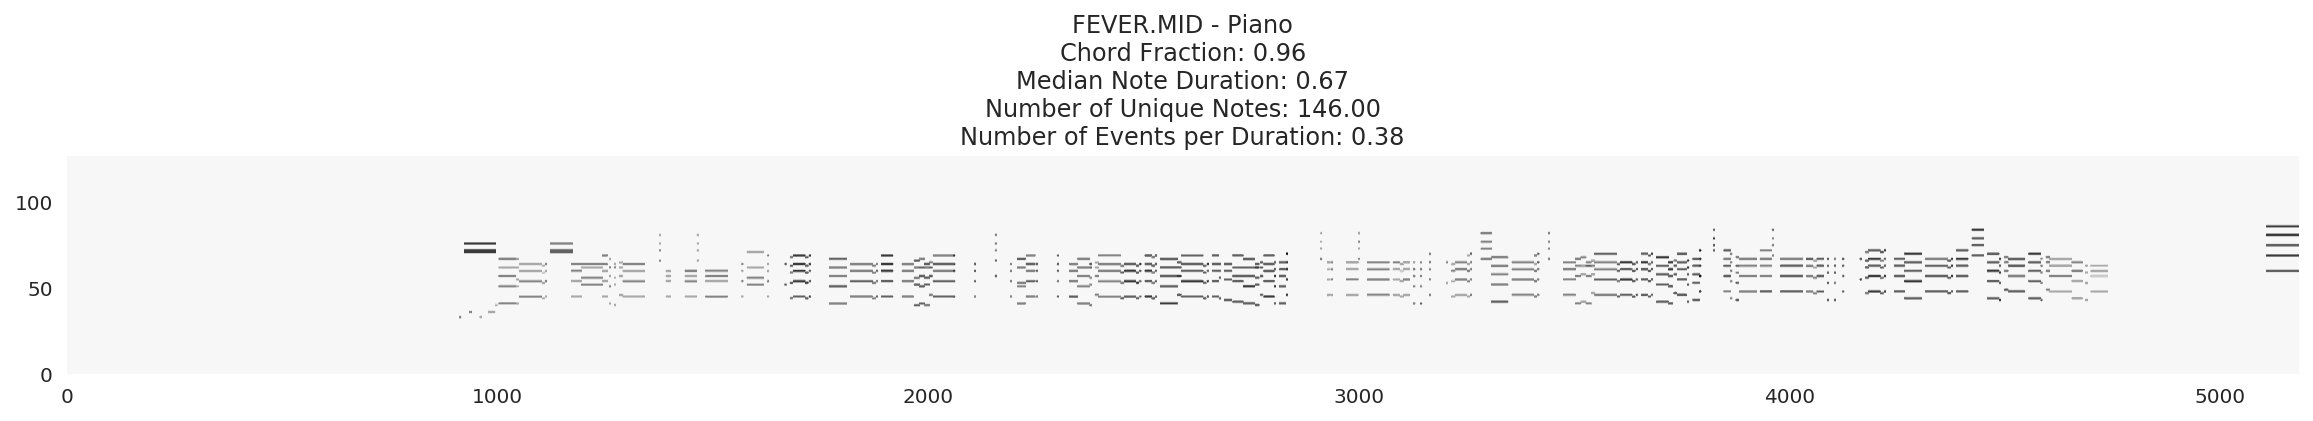

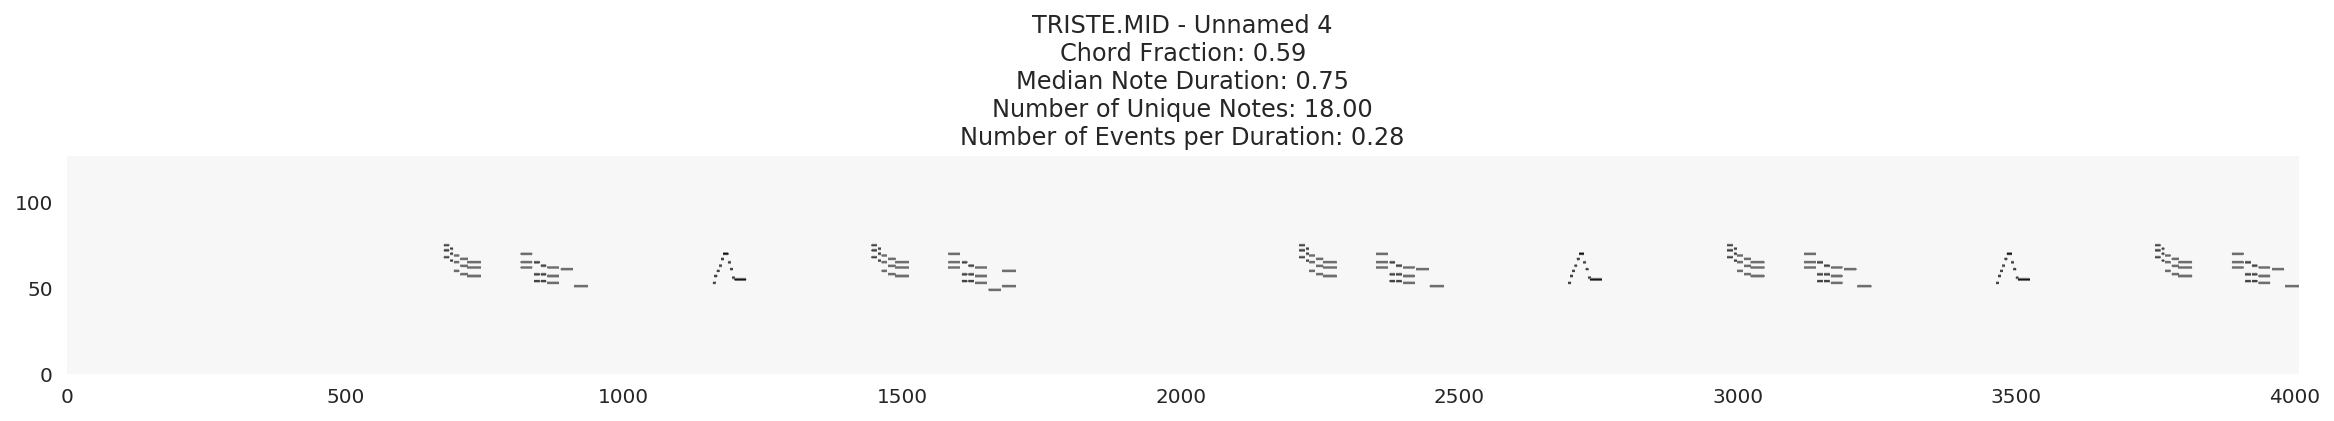

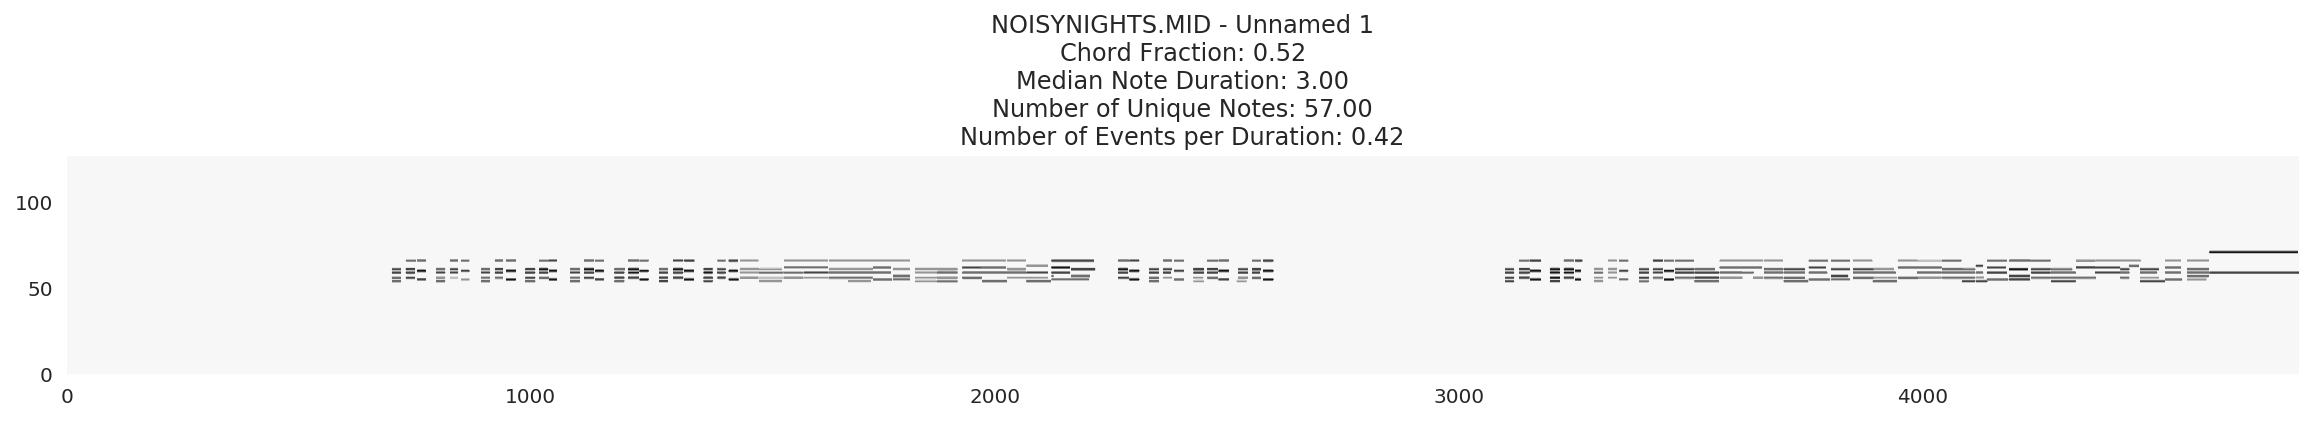

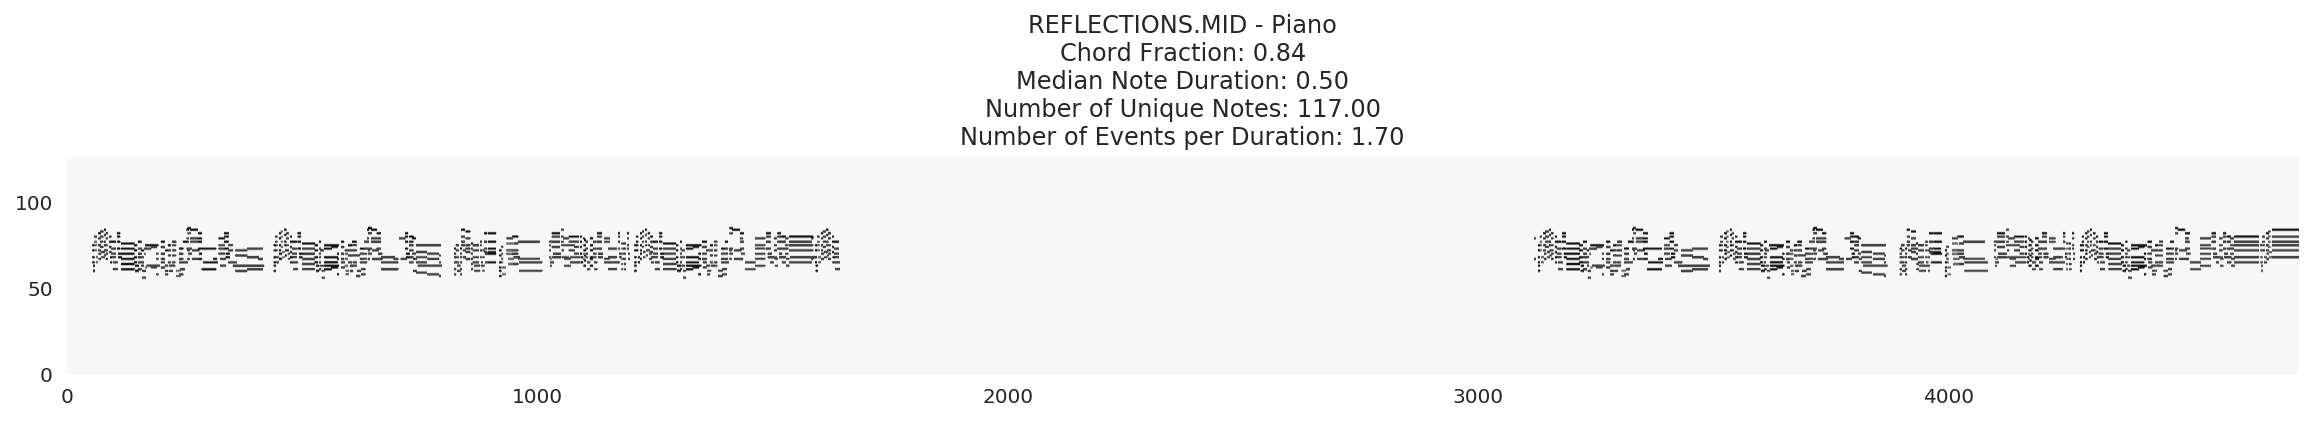

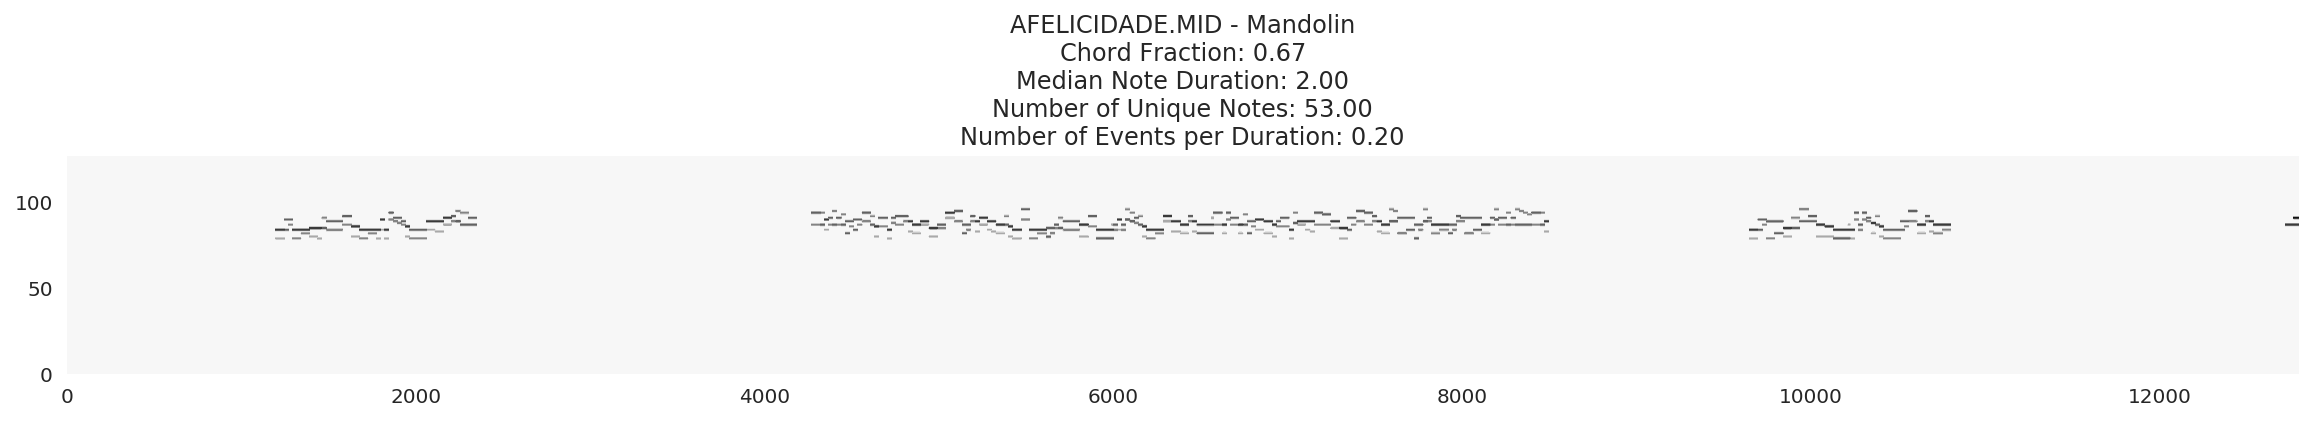

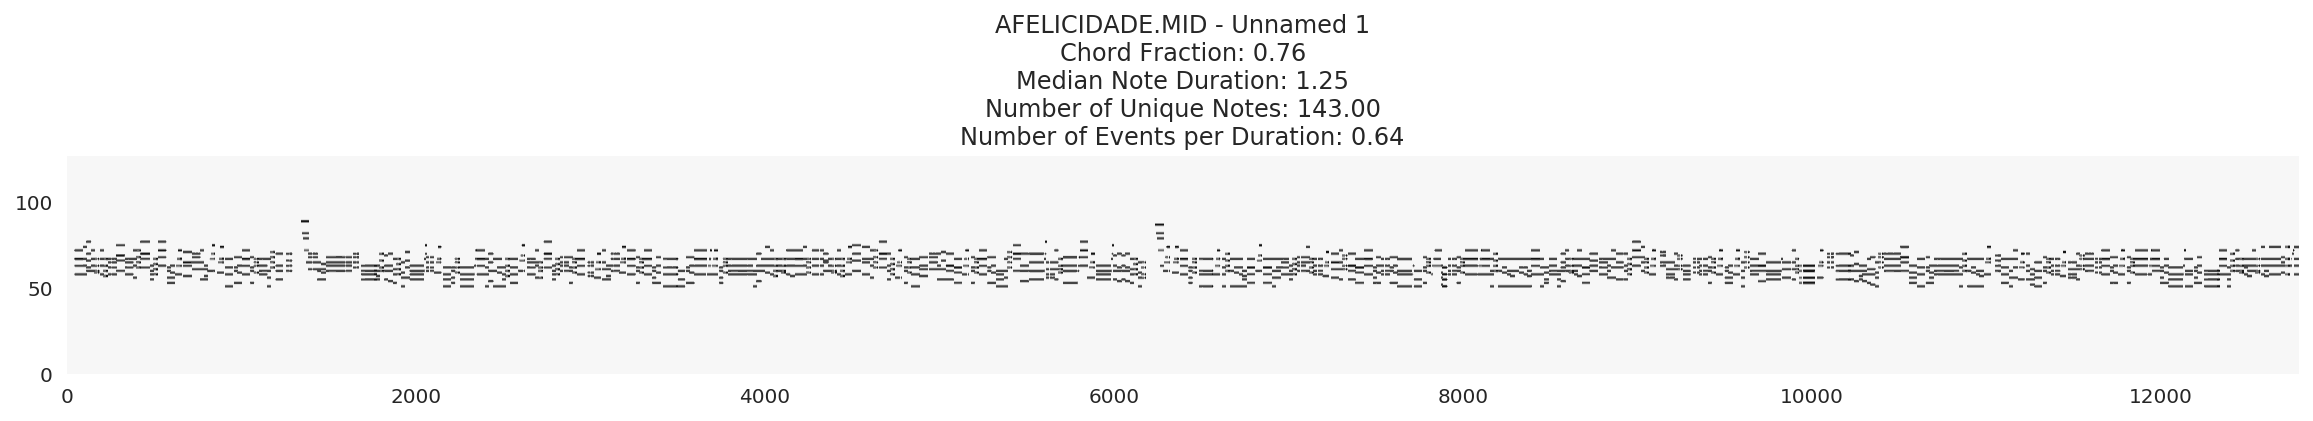

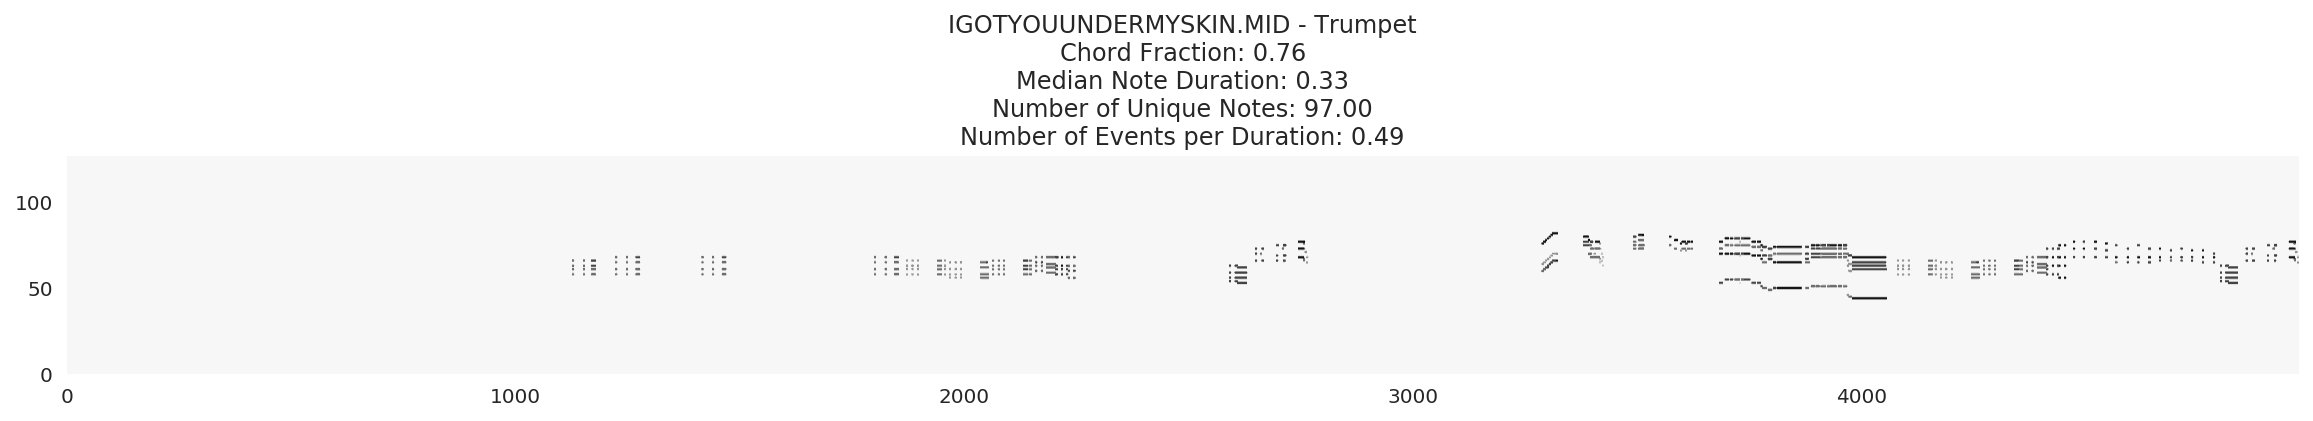

In [85]:
use_filt = chord_filt
for i, (song, track) in enumerate(y[use_filt]):
    print(song)
    print(track)
    plt.figure(figsize=(20,2))
    plt.contourf(KJPM.create_grid(song_notes[song][track][0]))
    plt.title("%s - %s\nChord Fraction: %0.2f\nMedian Note Duration: %0.2f\nNumber of Unique Notes: %0.2f\nNumber of Events per Duration: %0.2f" 
              % (song.upper(), 
                 track, 
                 X[use_filt][i,1],
                 X[use_filt][i,2],
                 X[use_filt][i,3],
                 X[use_filt][i,0]))
    if i > 40:
        break

HadtobeU.mid
Piano
HadtobeU.mid
Acoustic Bass
HadtobeU.mid
Unnamed 3
HadtobeU.mid
Unnamed 1
HadtobeU.mid
Unnamed 2
unforgetable.mid
Soprano Saxophone
unforgetable.mid
Tenor Saxophone
SpeakLow.mid
Acoustic Bass
SpeakLow.mid
Unnamed 1
F500MILES.MID
Acoustic Bass
F500MILES.MID
Trumpet
EasierSaidThanDone.mid
Electric Bass
birdland.mid
Trumpet
birdland.mid
Saxophone
birdland.mid
Baritone Saxophone
birdland.mid
Tenor Saxophone
birdland.mid
Trombone
birdland.mid
Electric Bass
birdland.mid
Brass
Georgia_on_my_mind.mid
Oboe
Georgia_on_my_mind.mid
Electric Bass


/home/chrisgiler/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


howhightthemoon.mid
Unnamed 5
howhightthemoon.mid
Trumpet
howhightthemoon.mid
Unnamed 8
howhightthemoon.mid
Unnamed 4
howhightthemoon.mid
Unnamed 9
howhightthemoon.mid
Acoustic Bass
howhightthemoon.mid
Unnamed 6
howhightthemoon.mid
Unnamed 7
greenonions.mid
Electric Bass
greenonions.mid
Acoustic Bass
caravan.mid
Unnamed 2
songbird.mid
Unnamed 9
songbird.mid
Unnamed 7
songbird.mid
Unnamed 10
stolen.mid
Acoustic Bass
stolen.mid
Electric Guitar
stolen.mid
Flute
stolen.mid
Unnamed 1
so_what.mid
Acoustic Bass
so_what.mid
Unnamed 1
airegin.mid
Trumpet


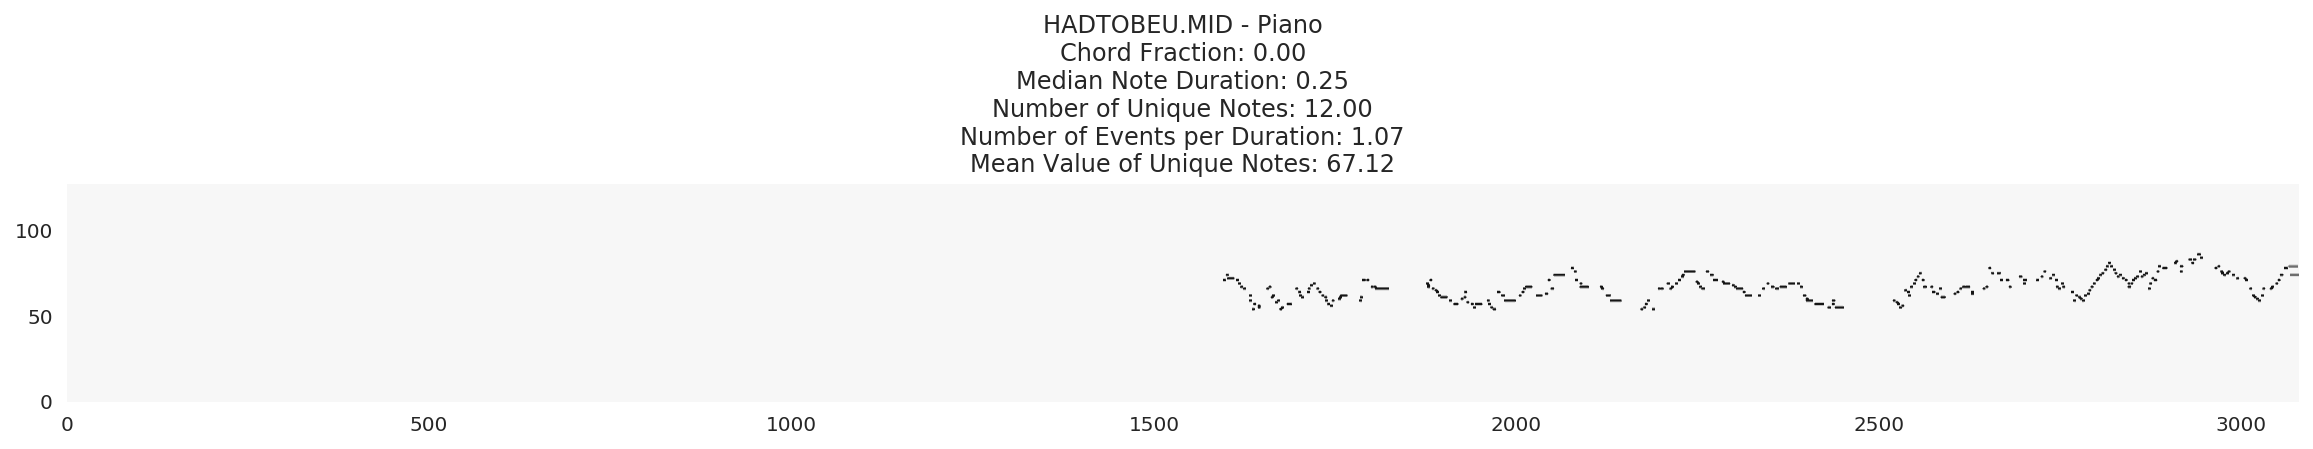

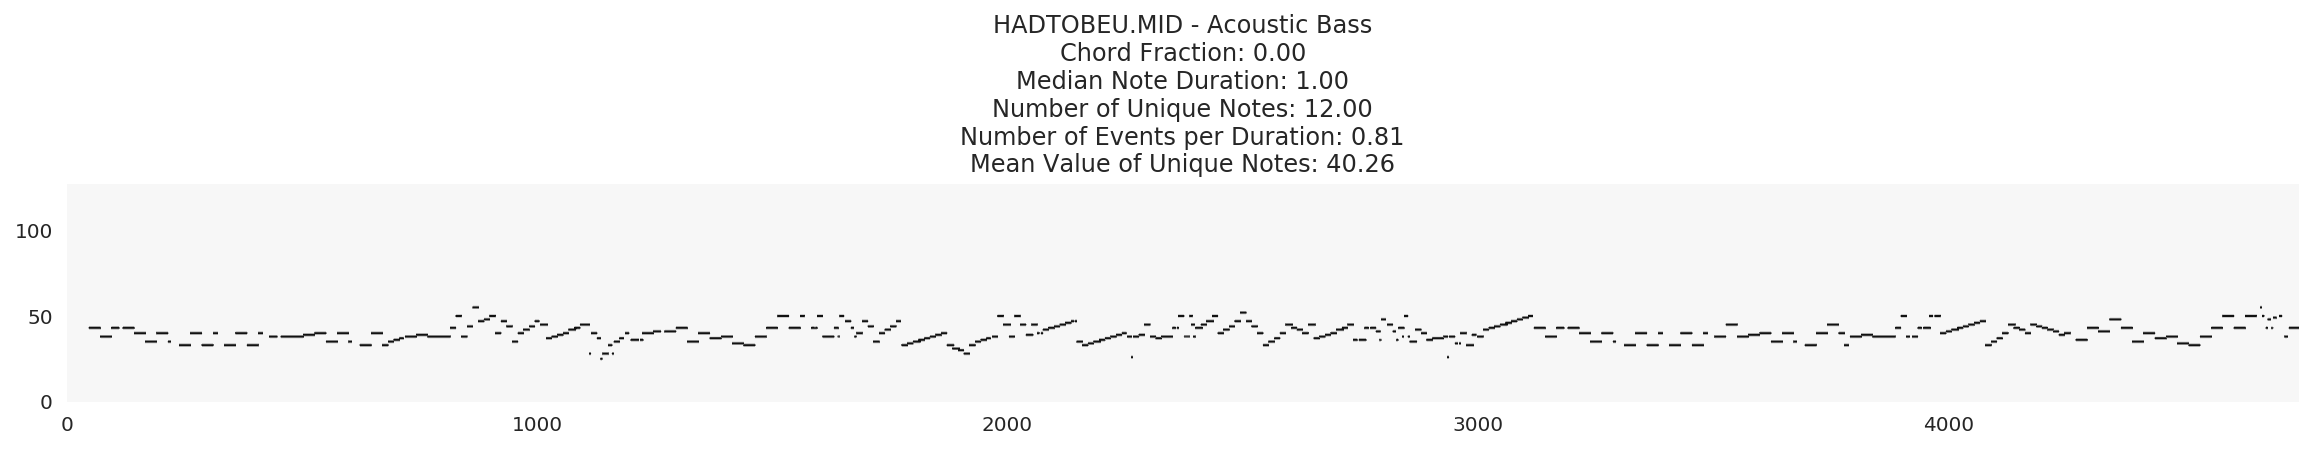

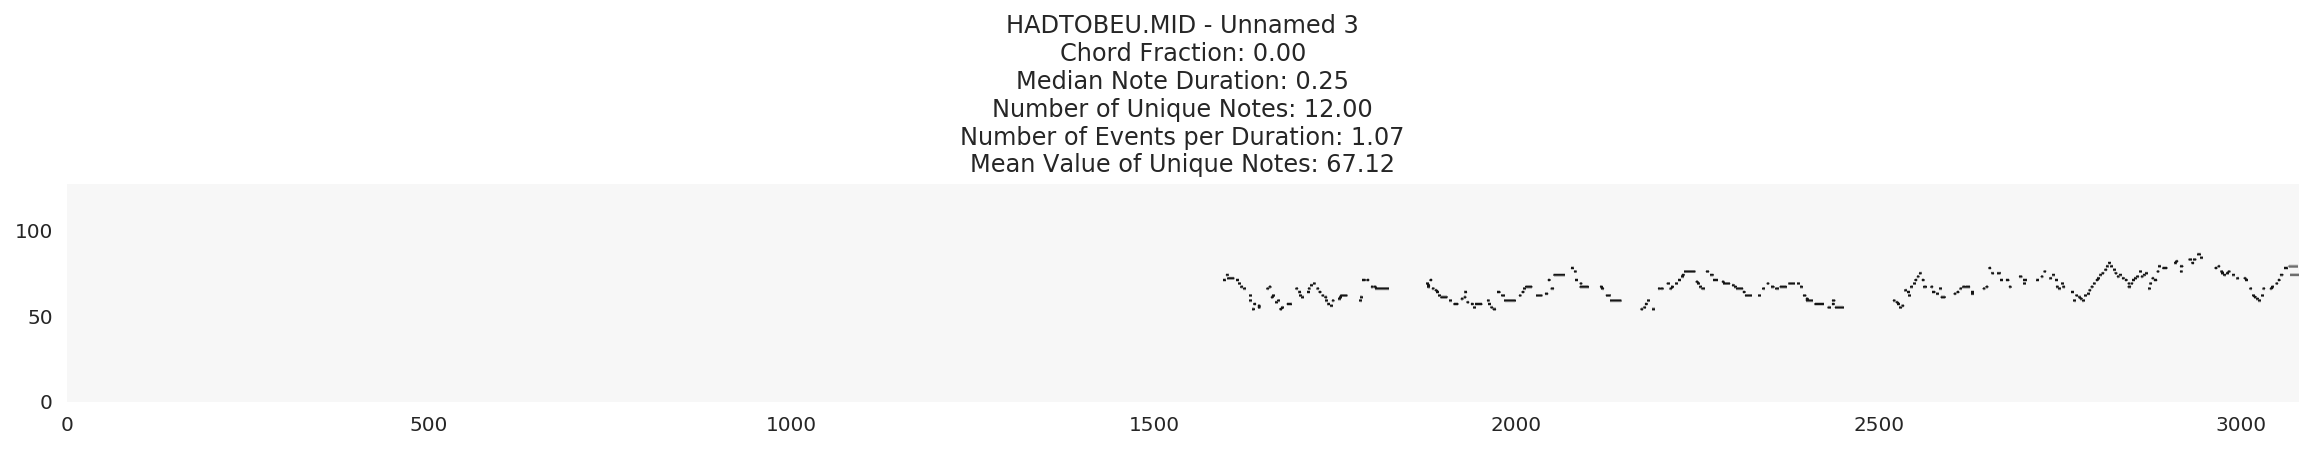

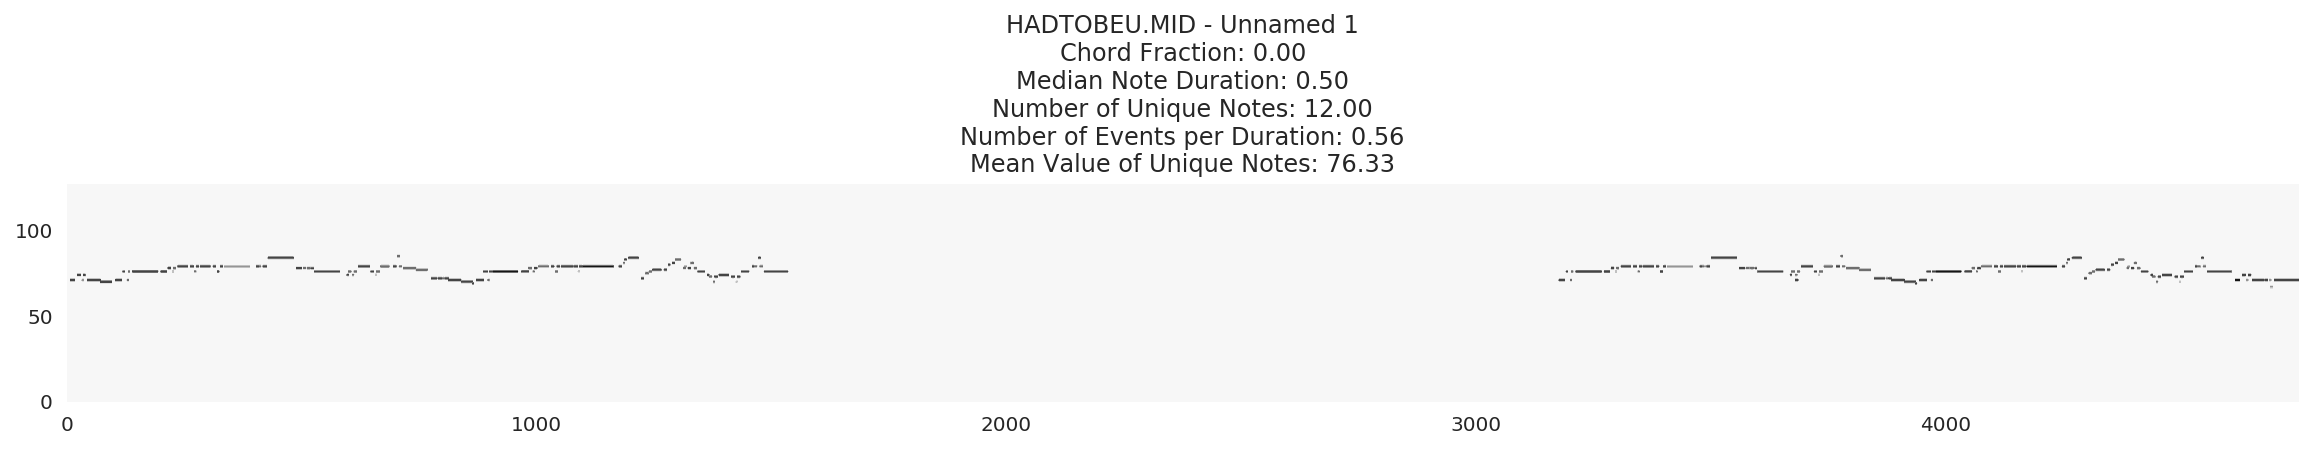

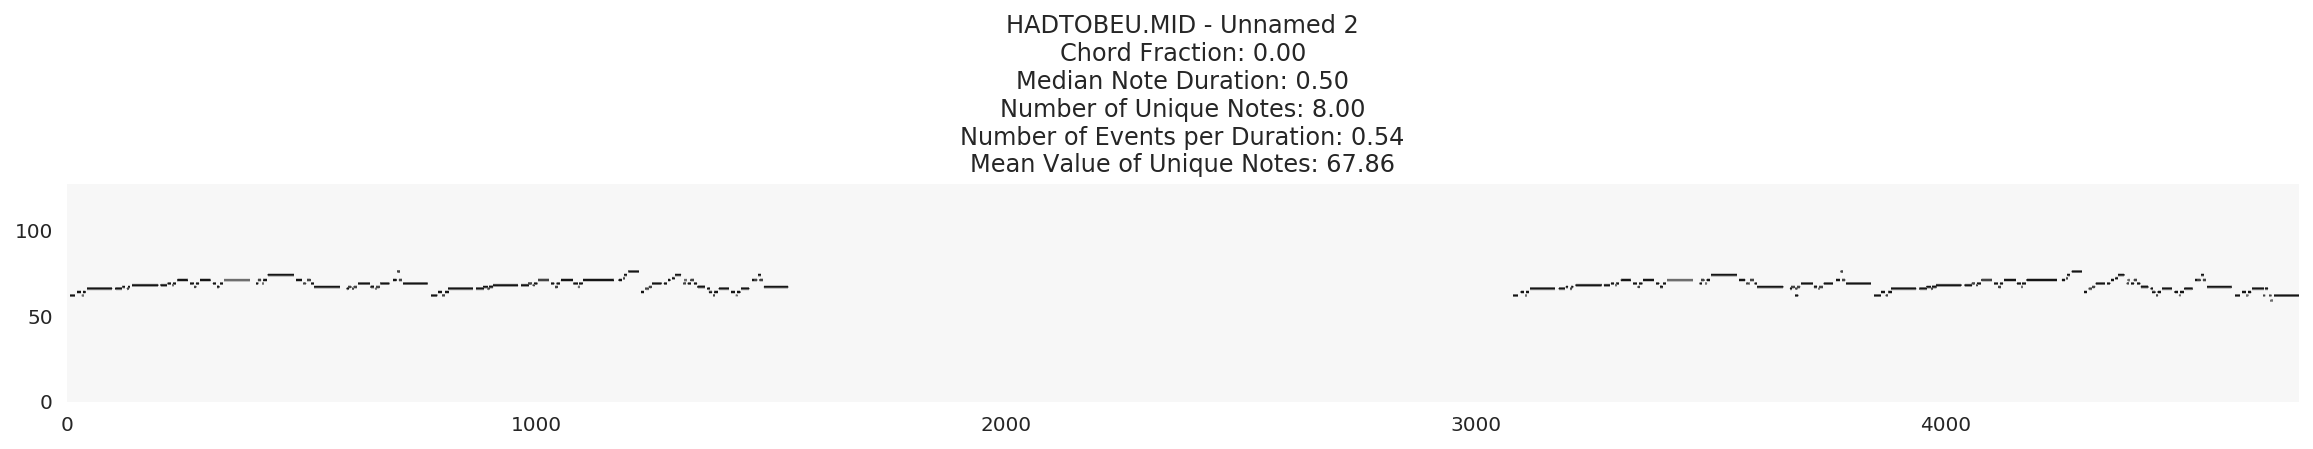

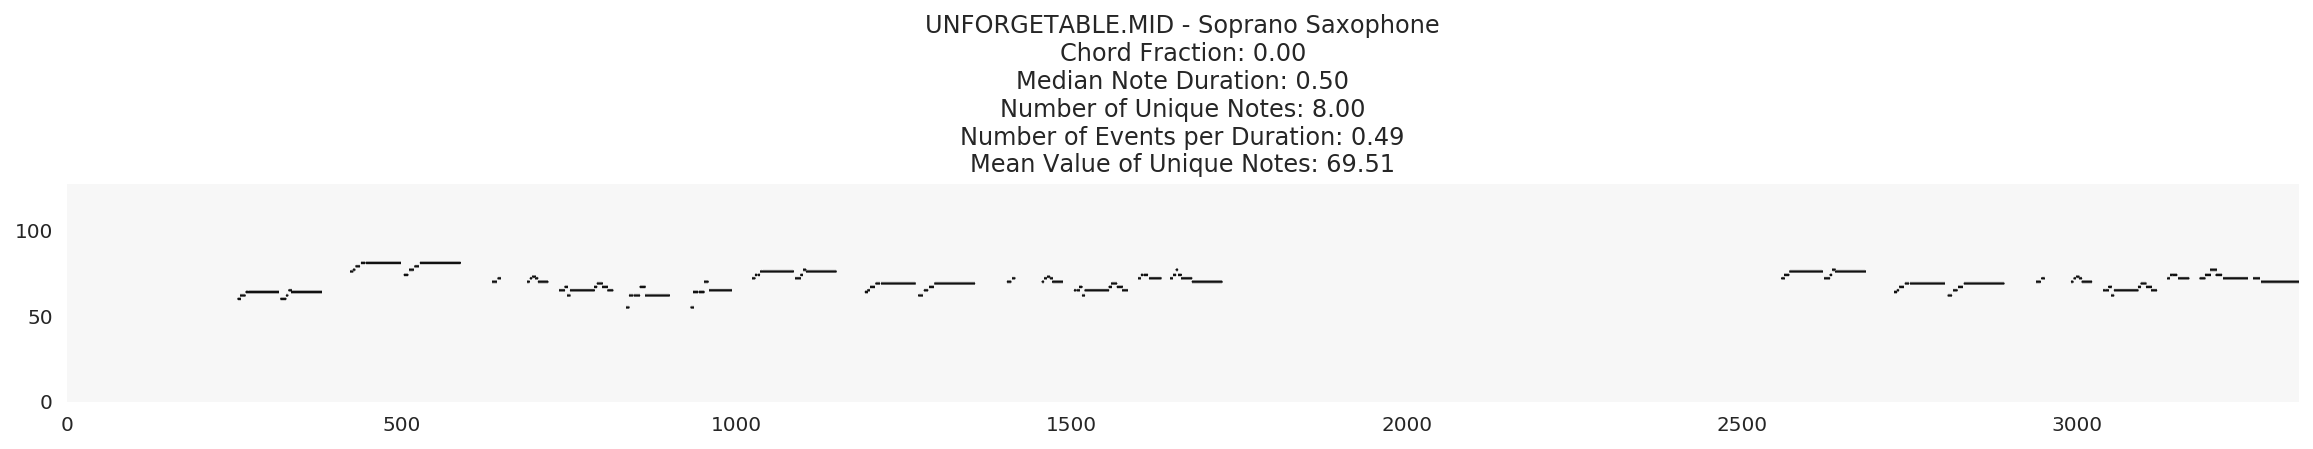

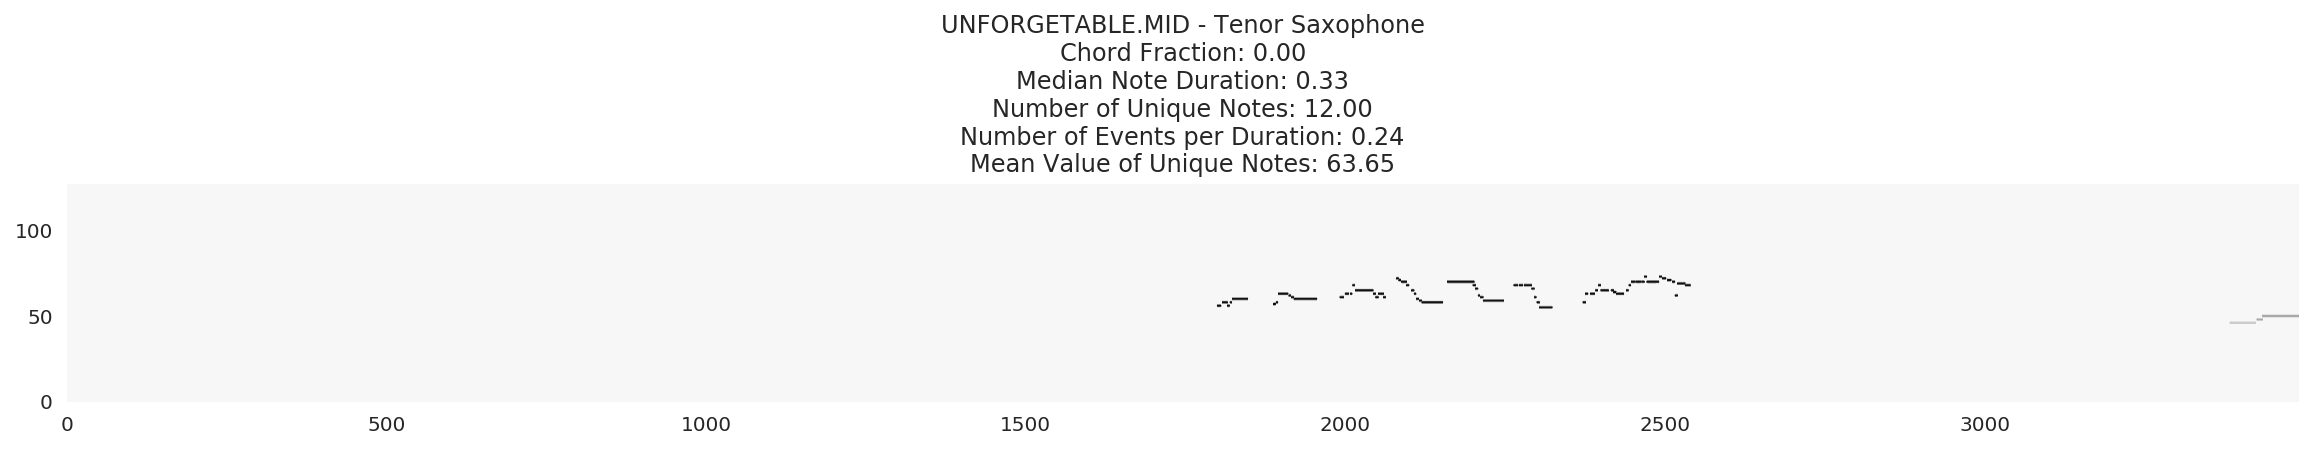

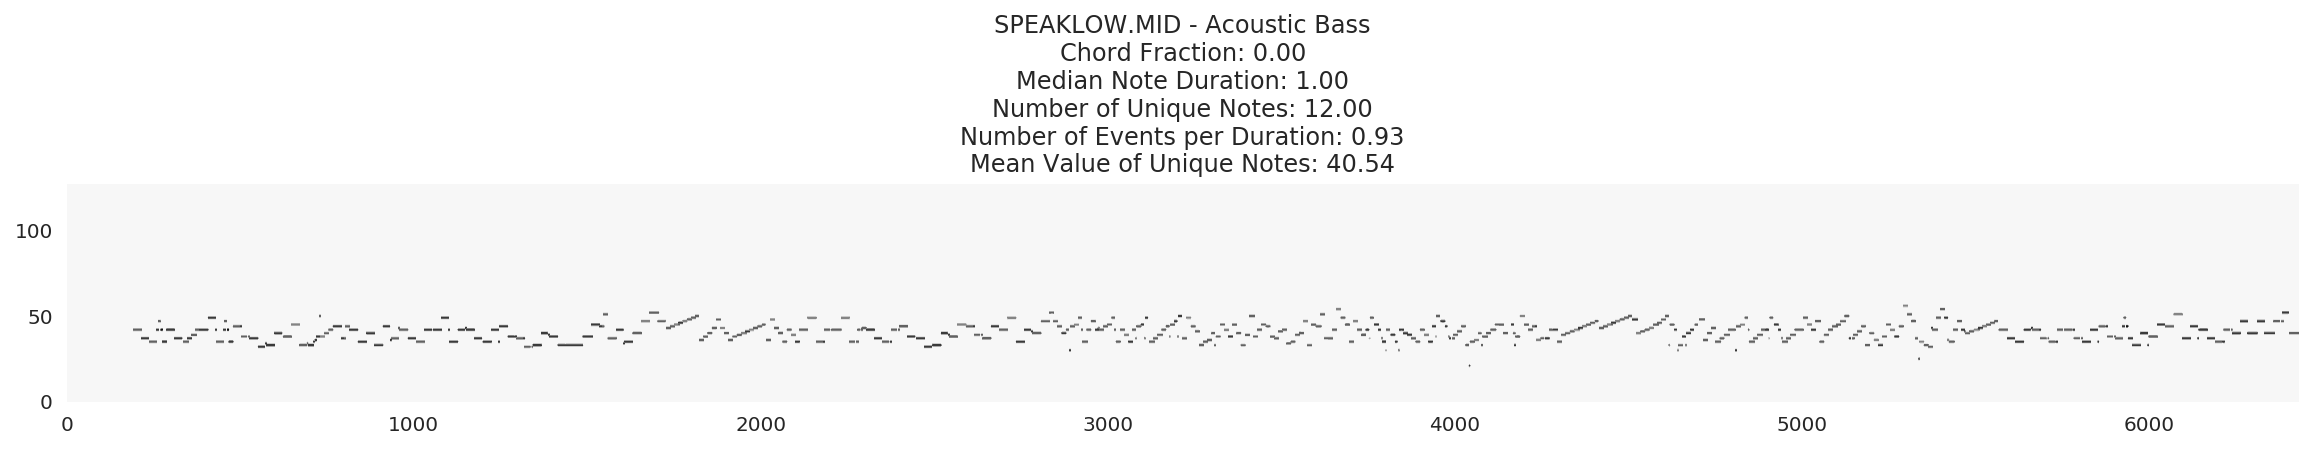

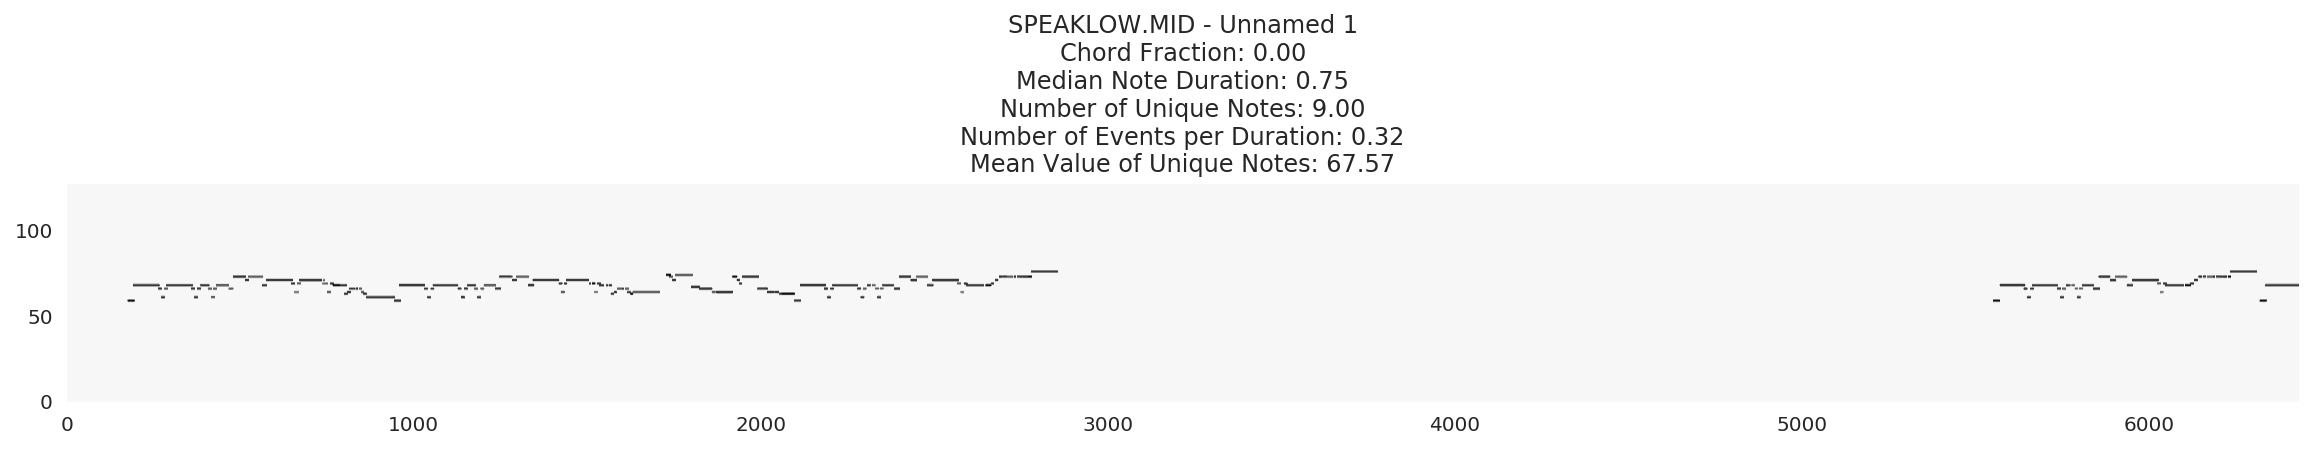

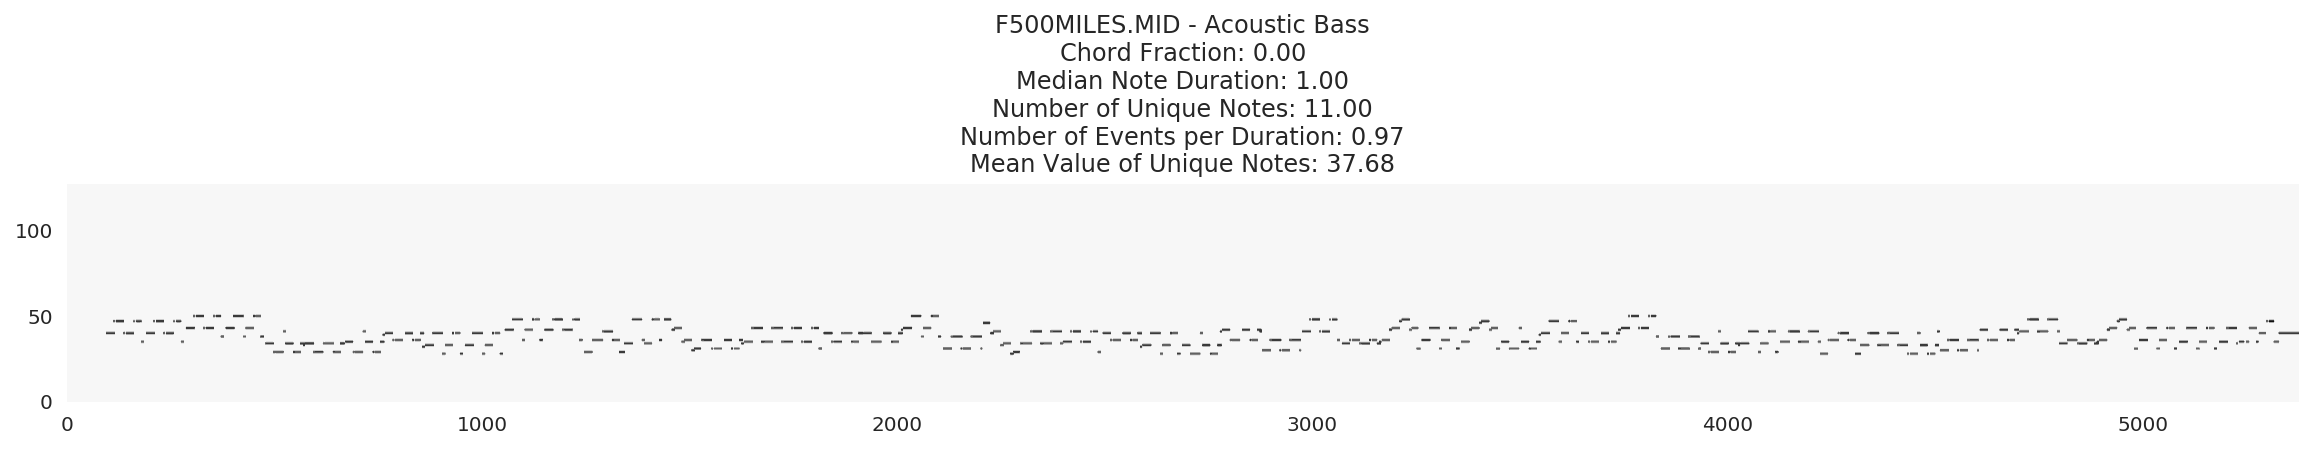

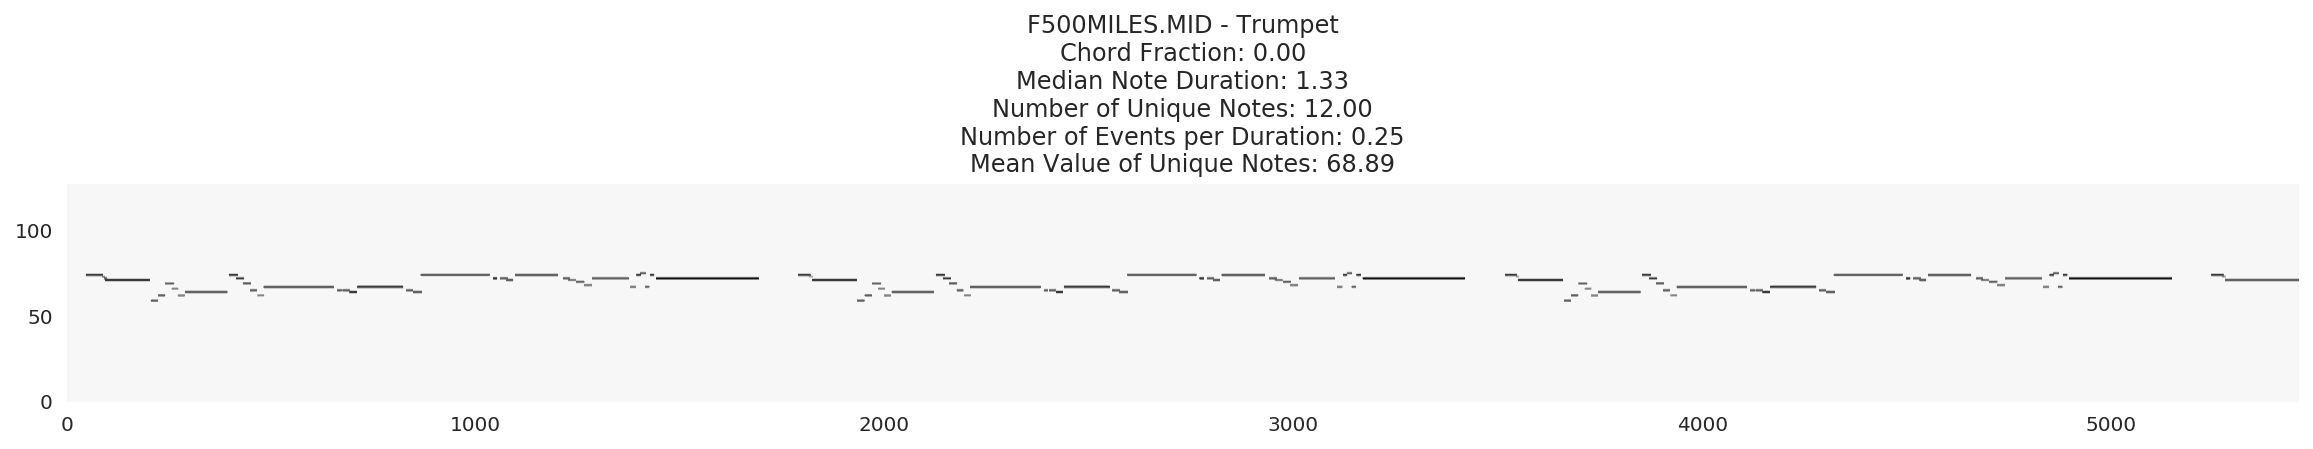

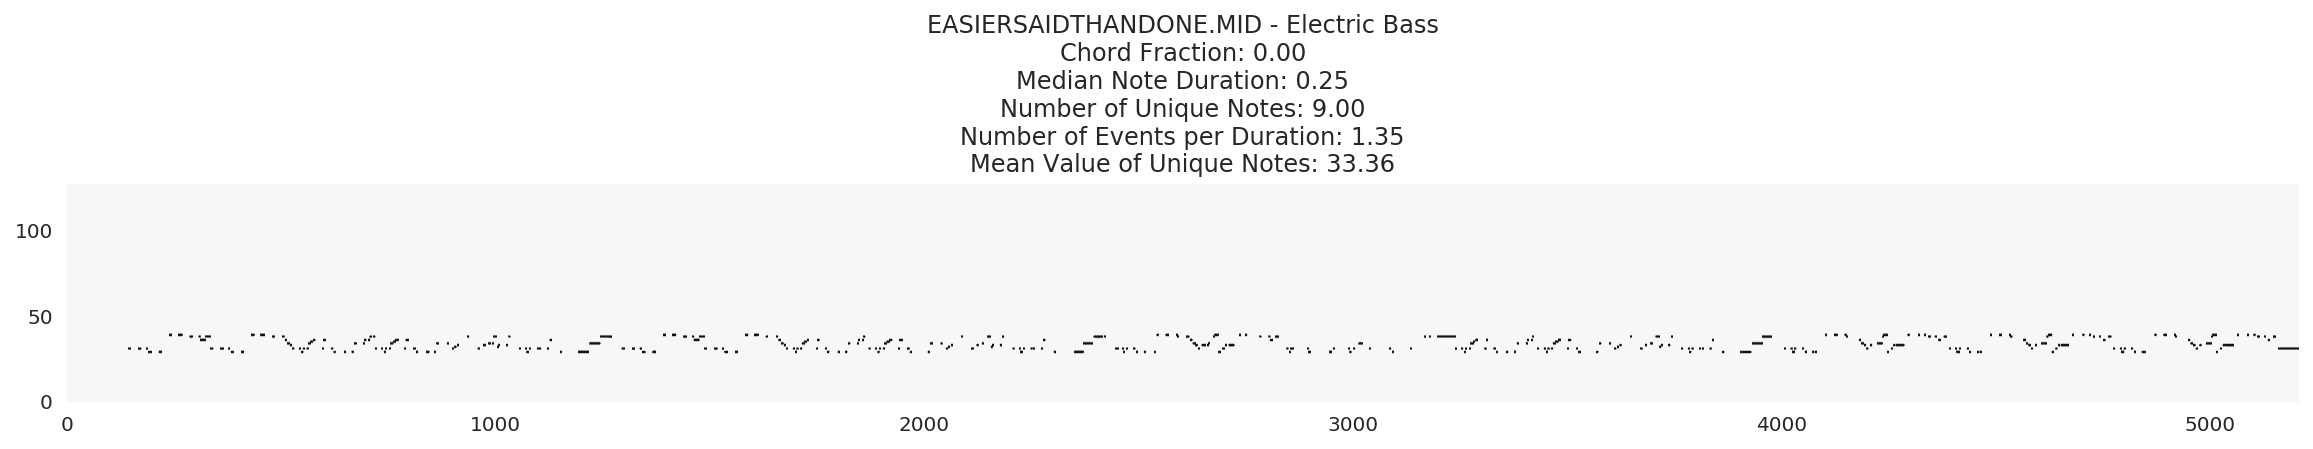

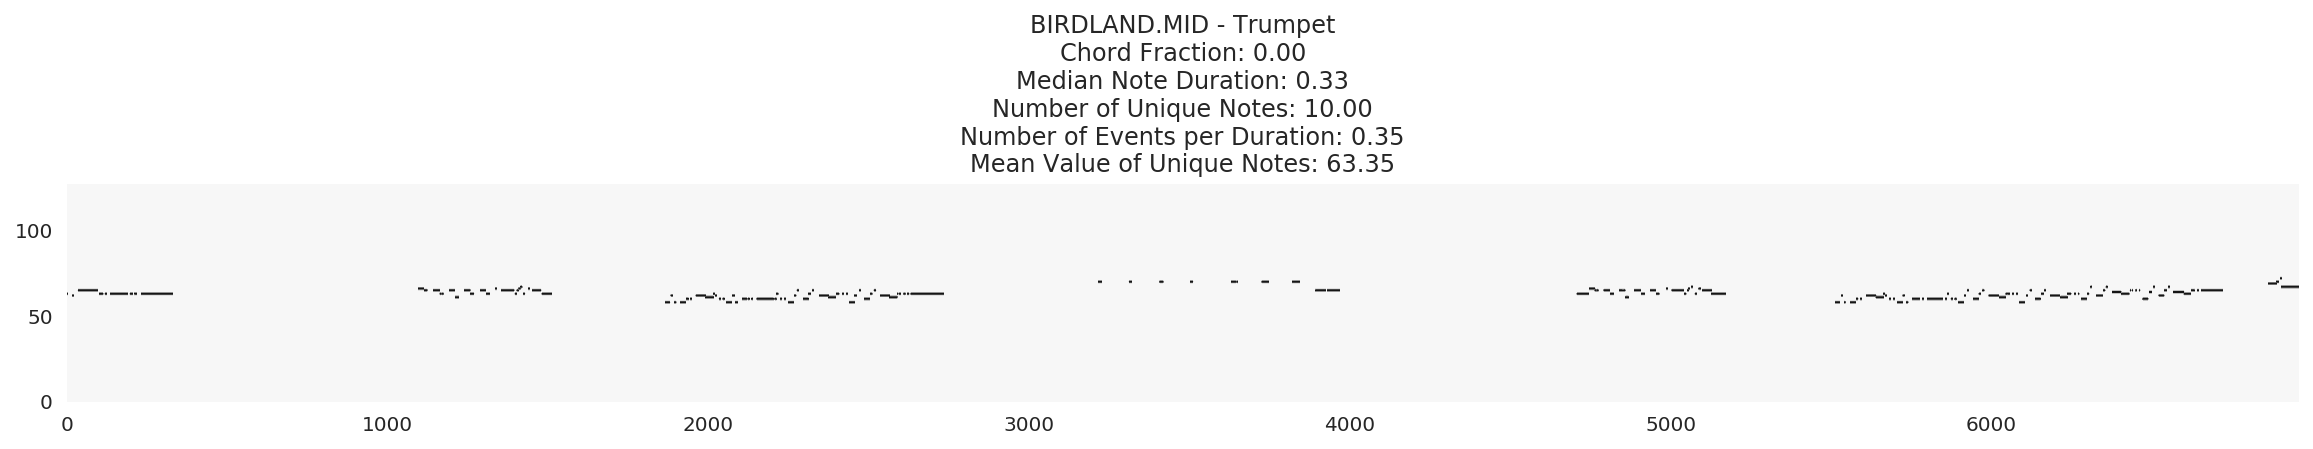

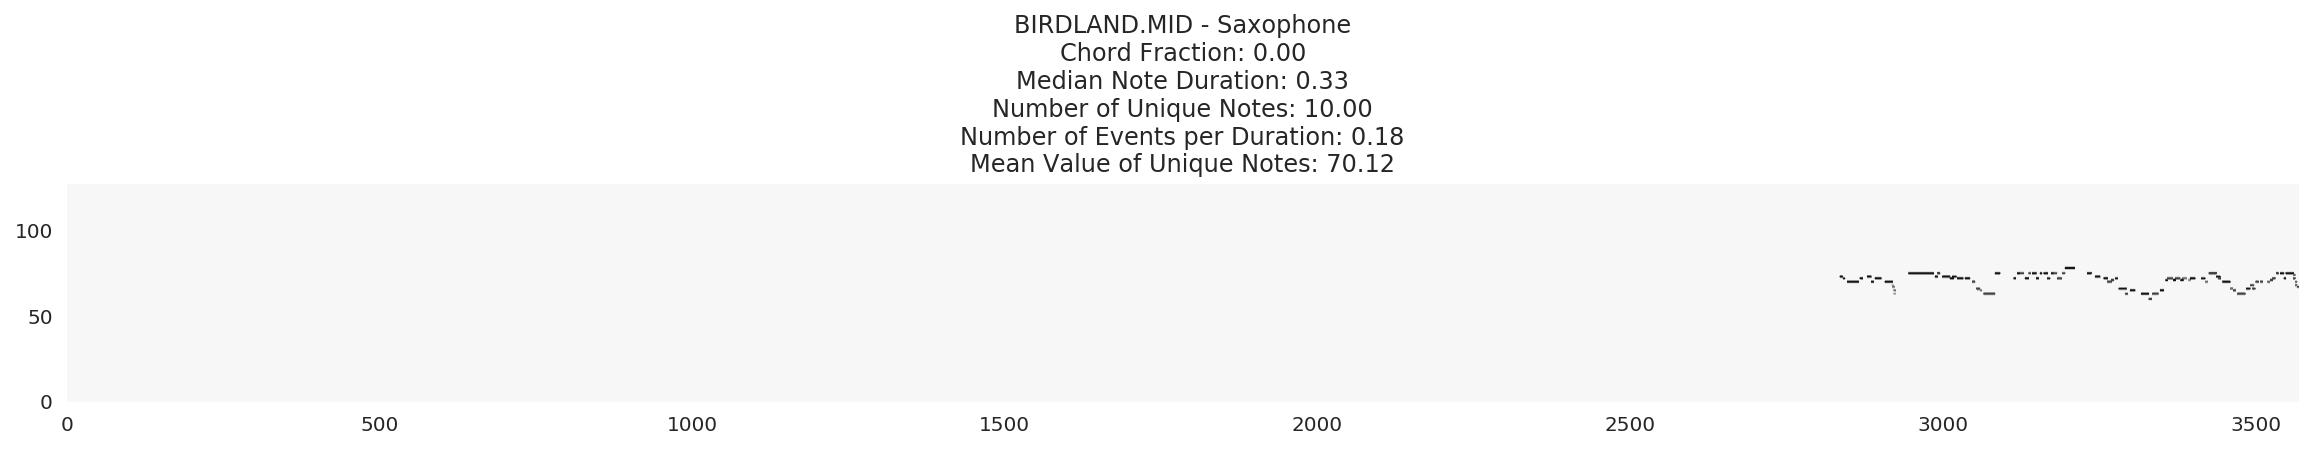

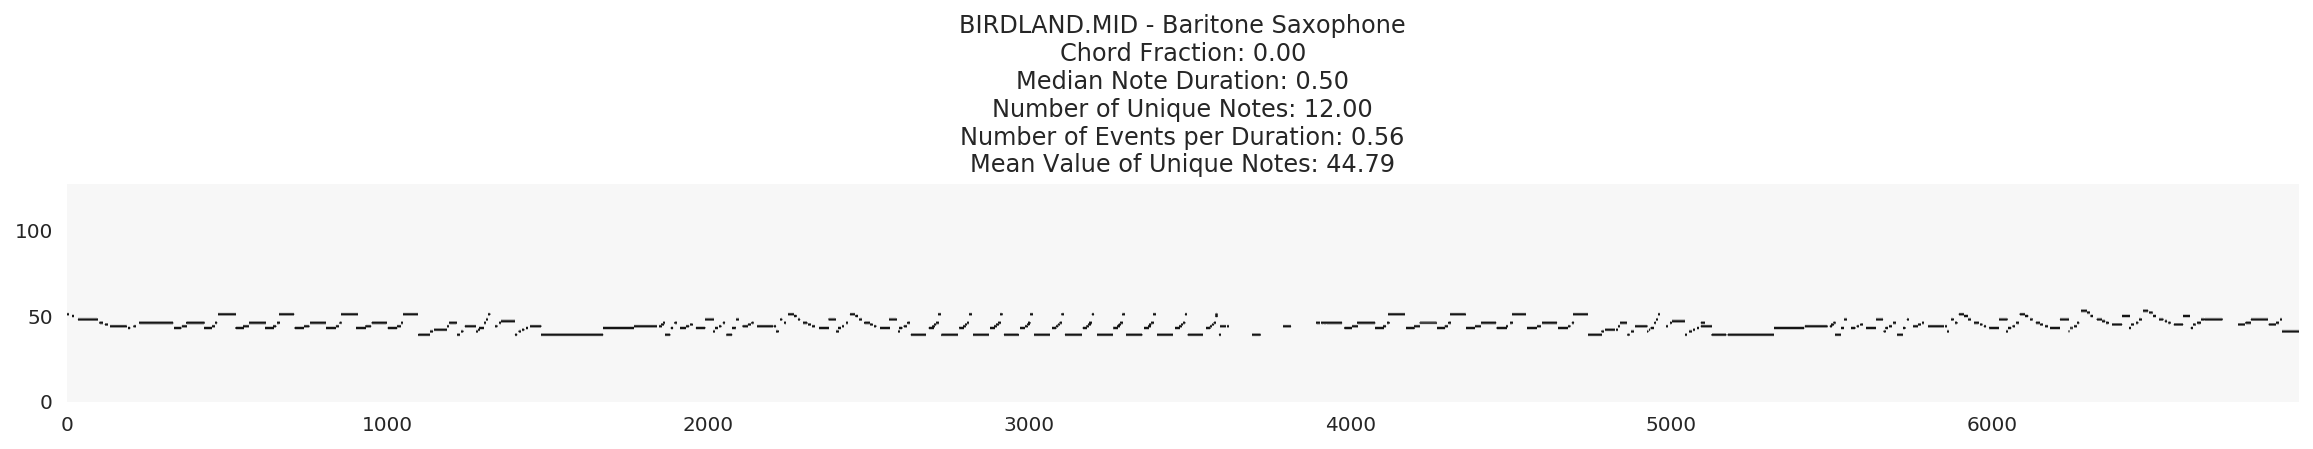

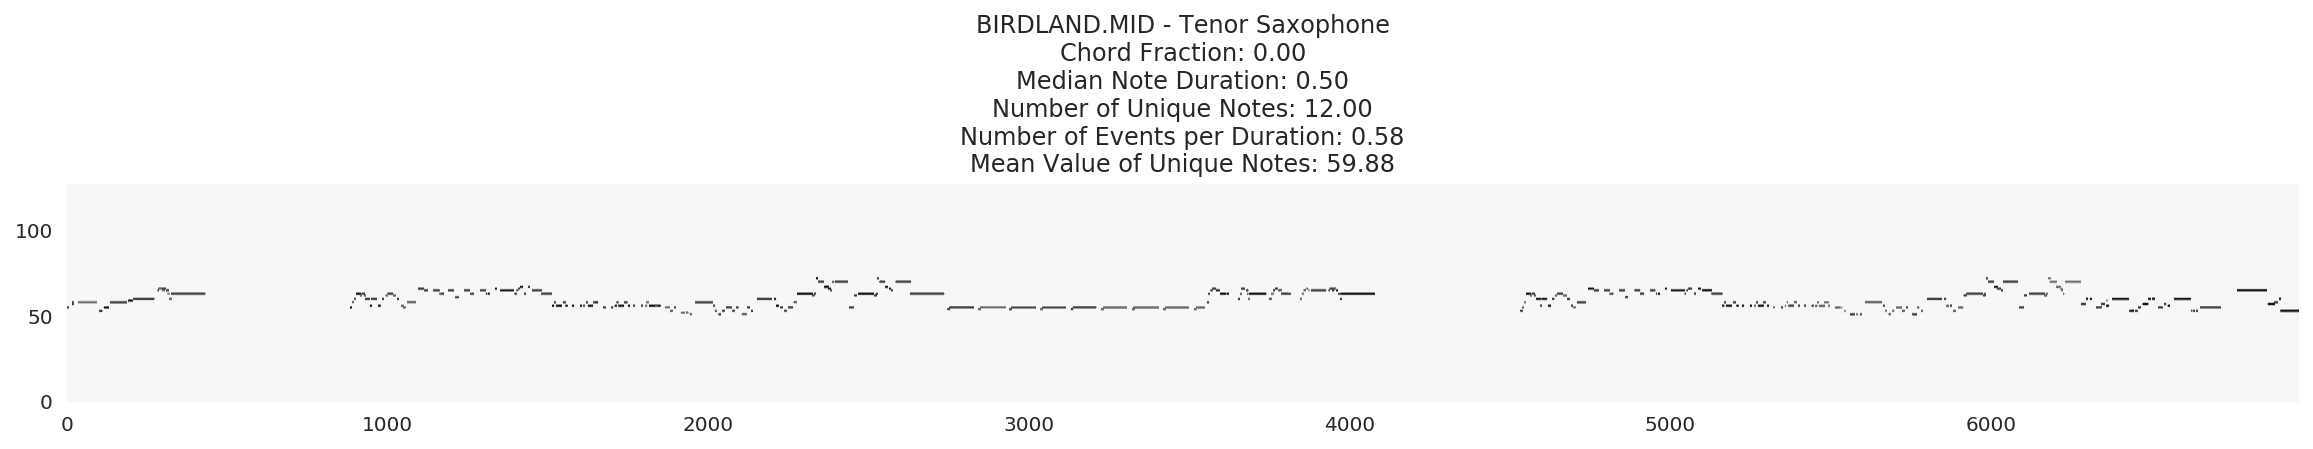

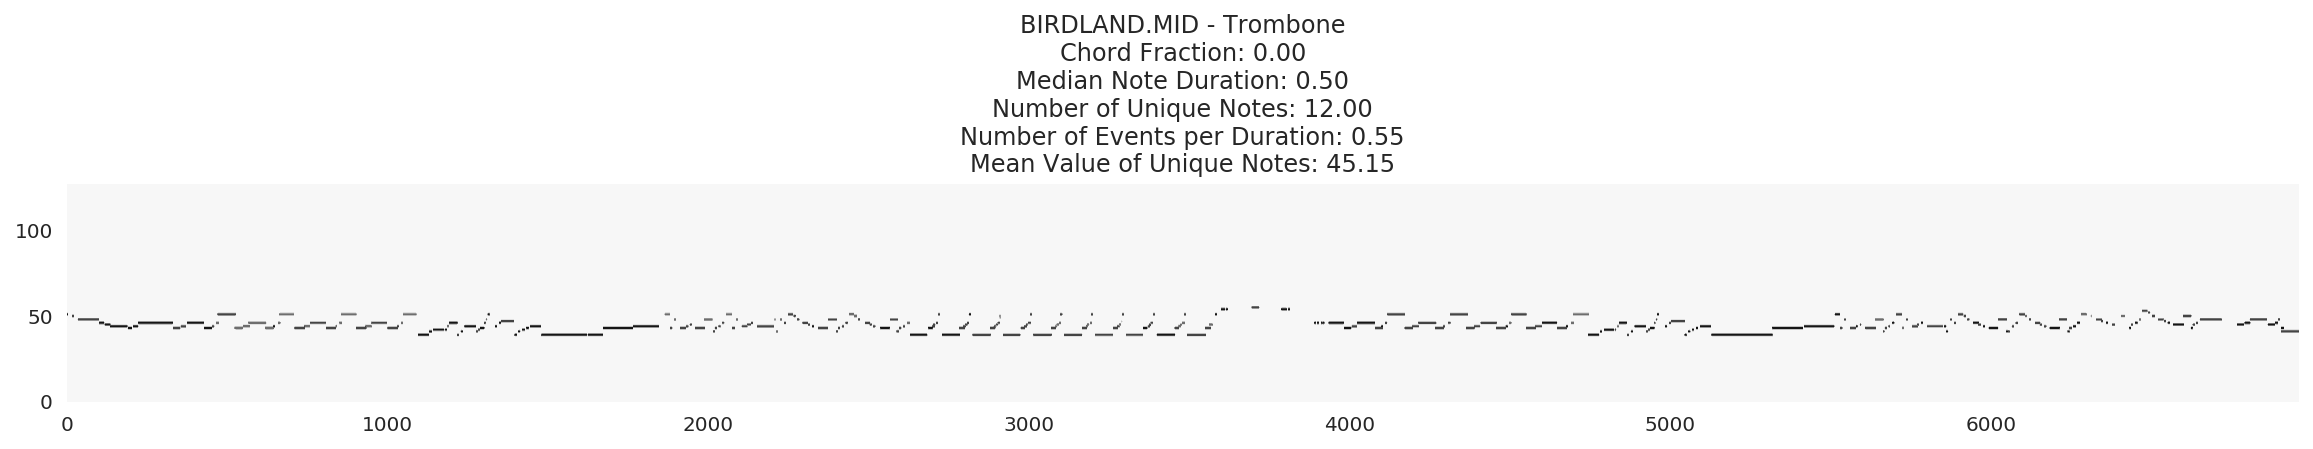

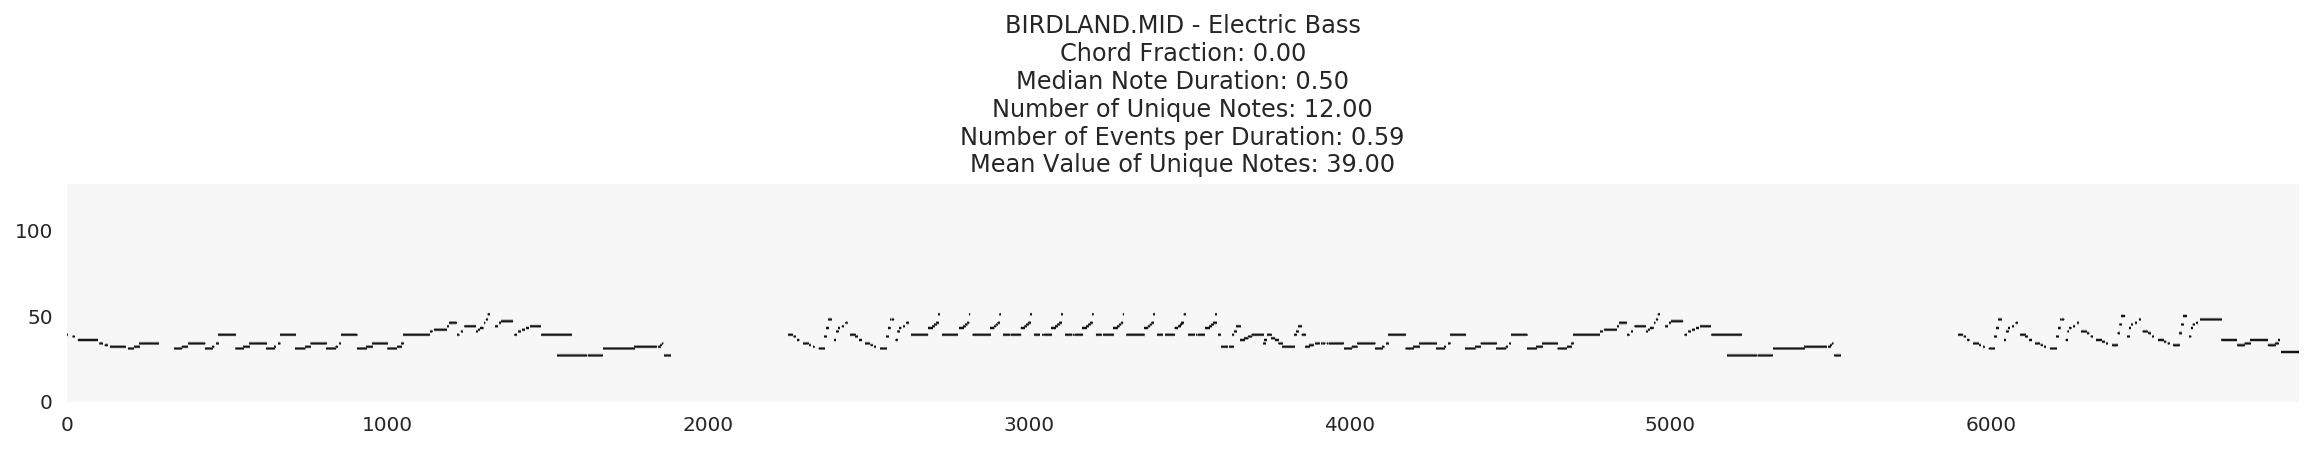

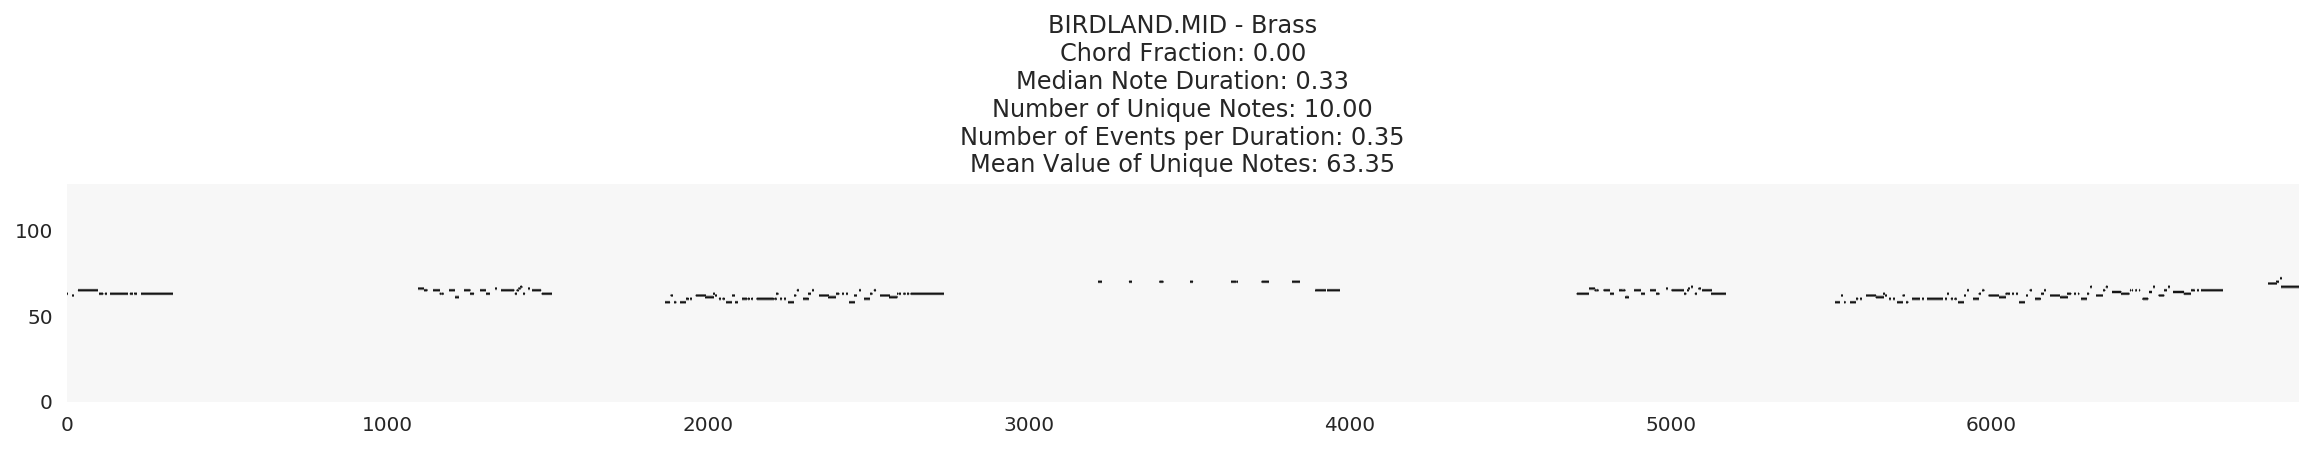

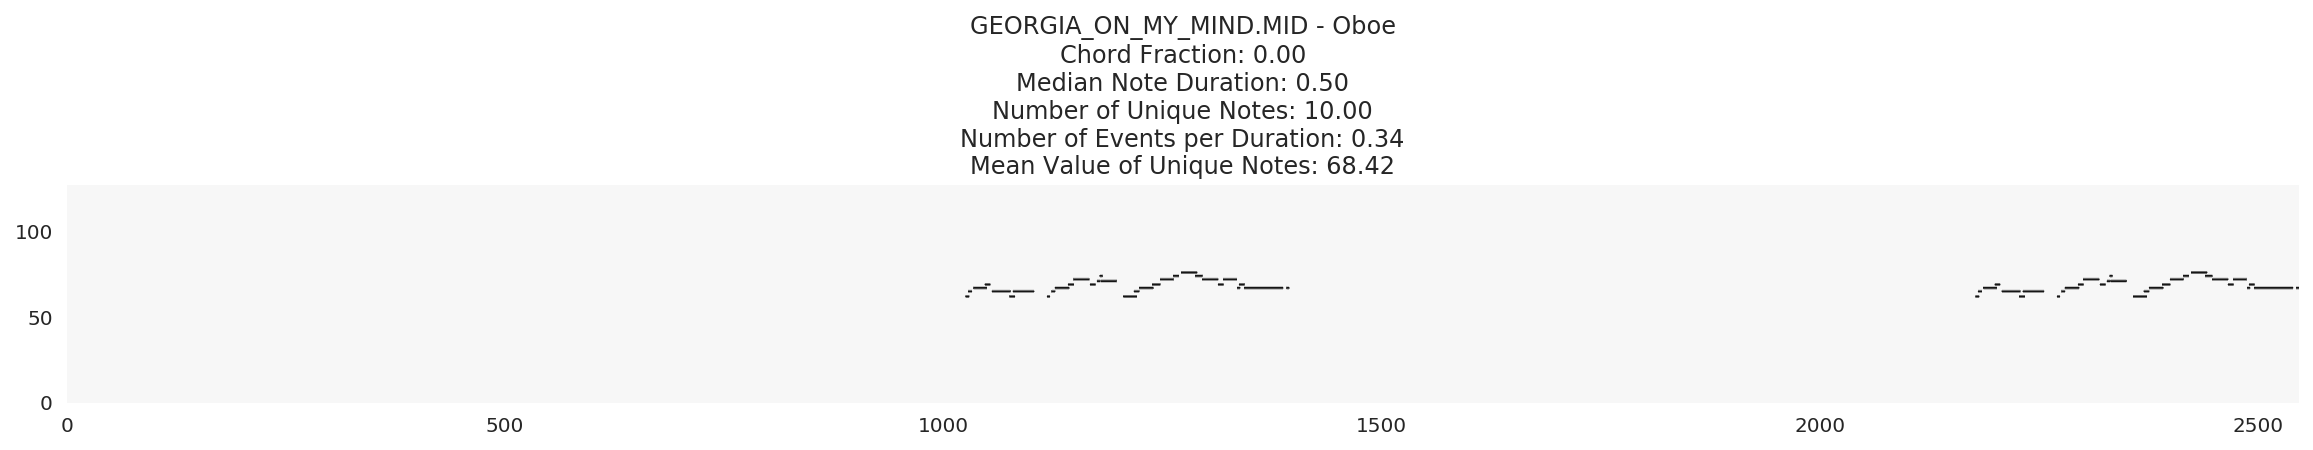

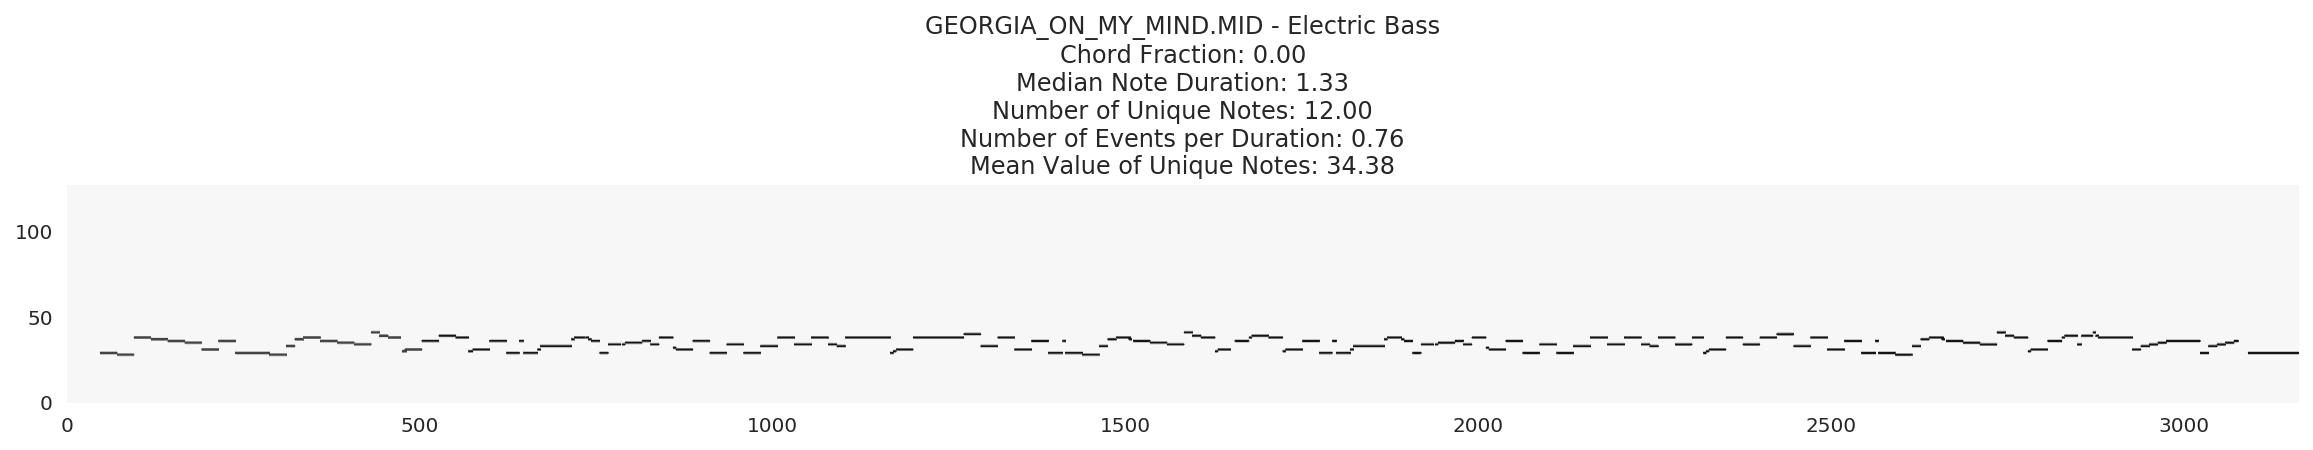

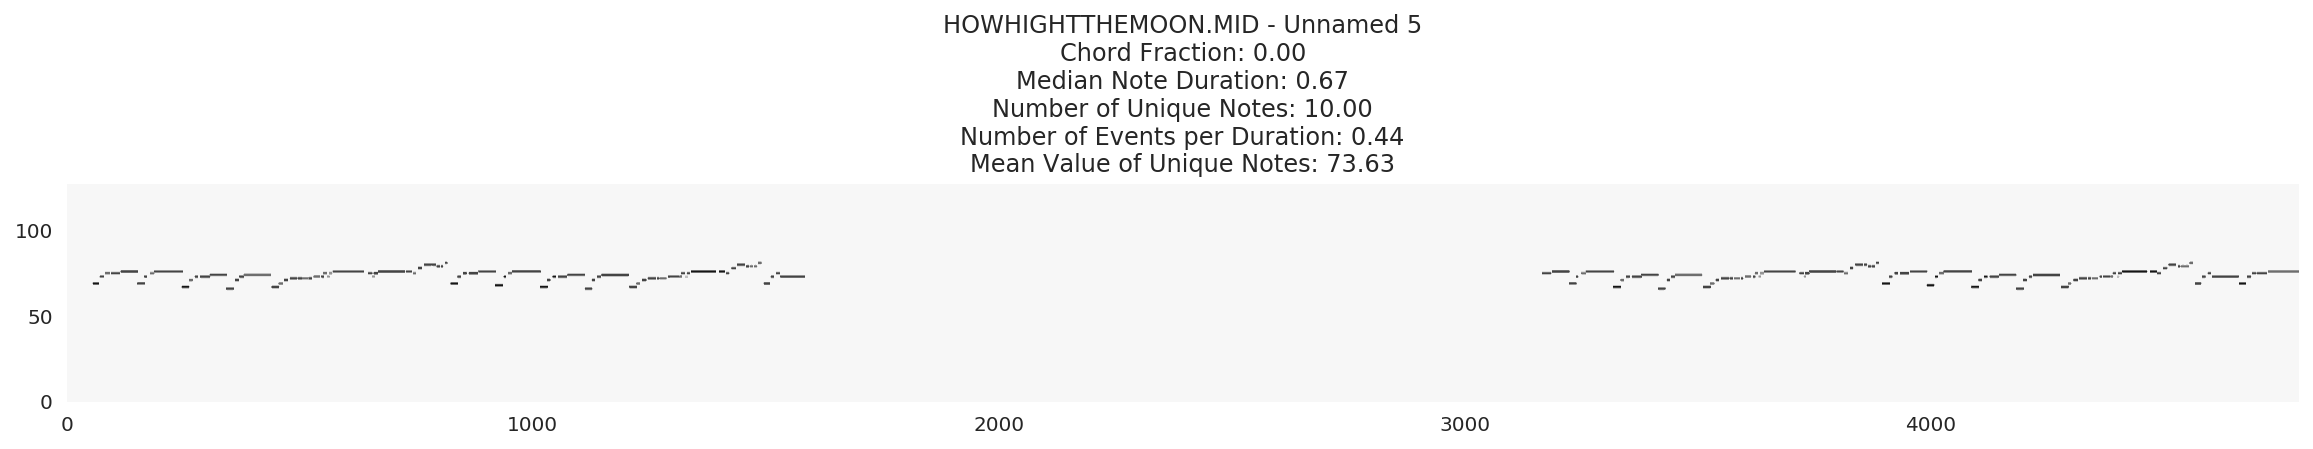

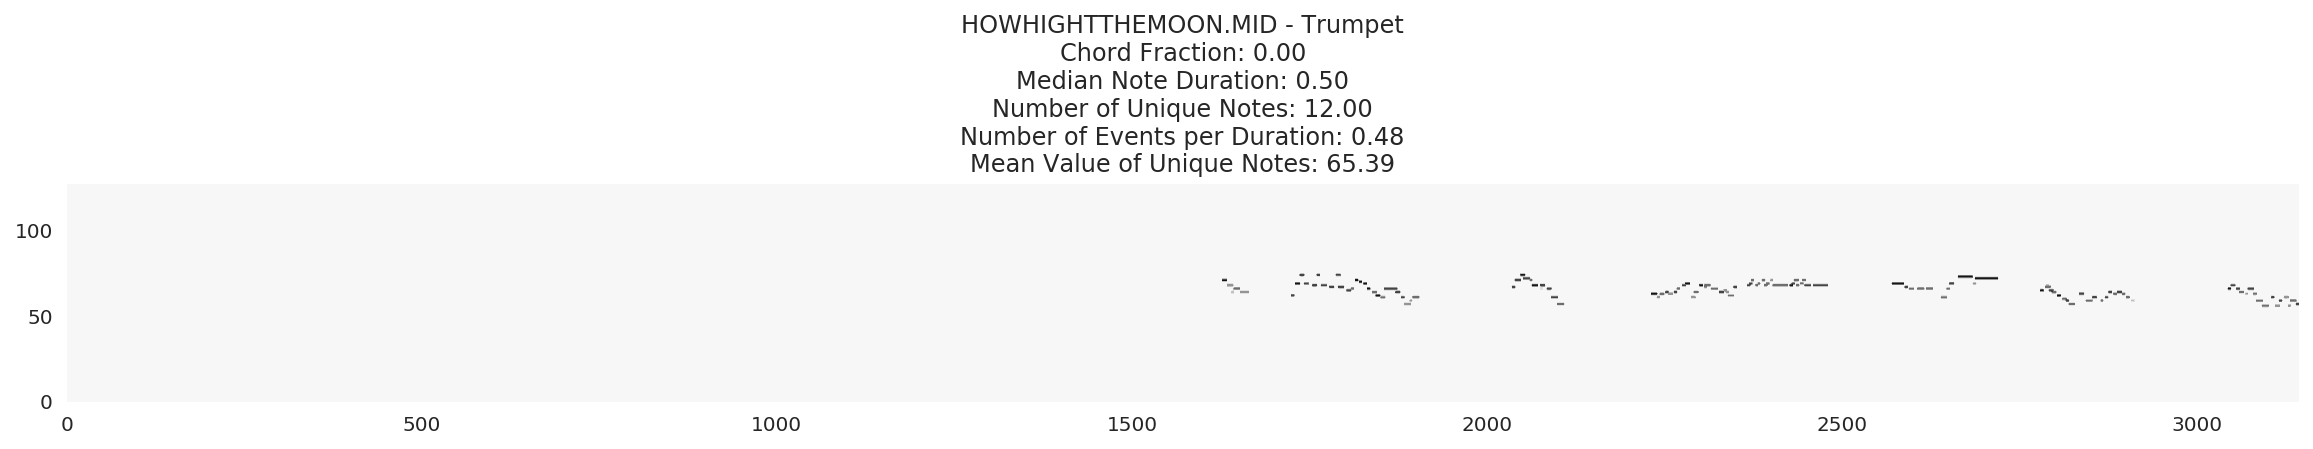

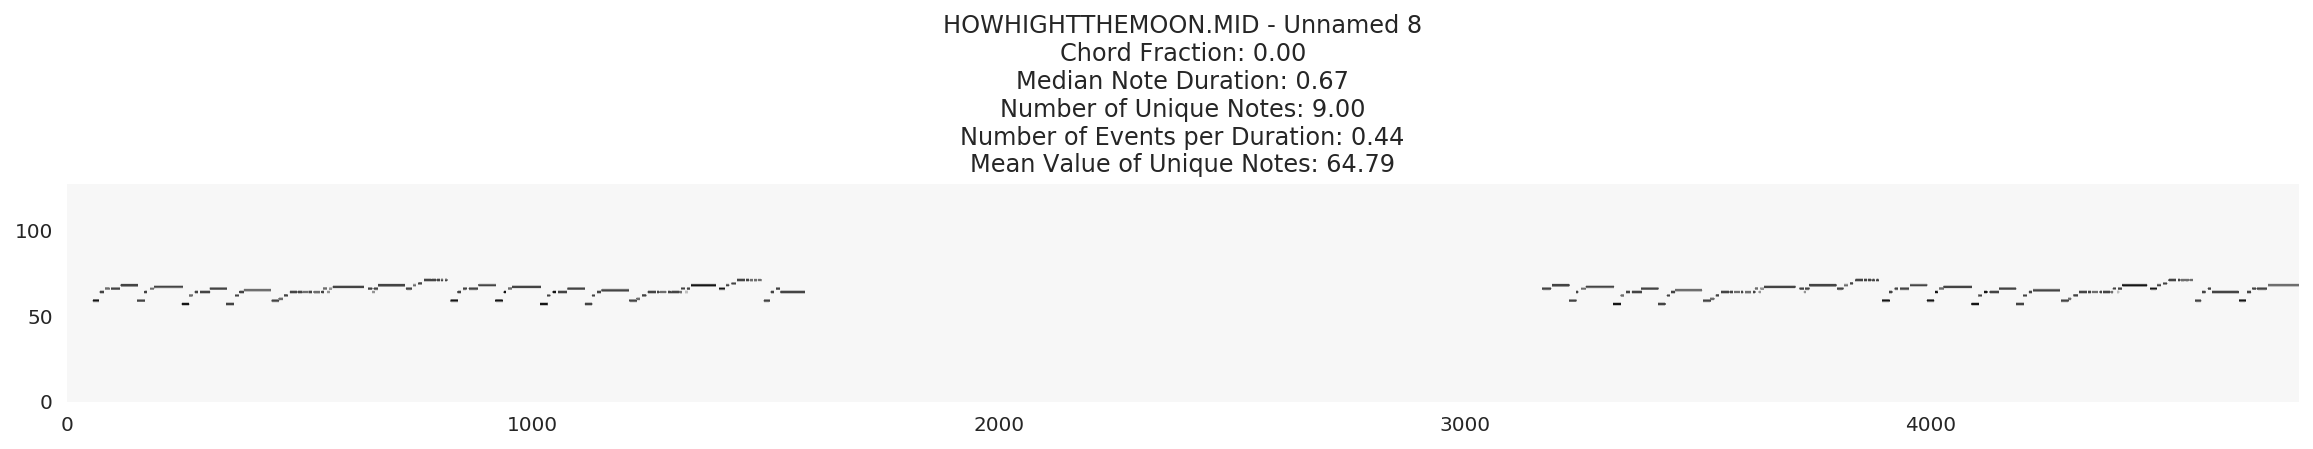

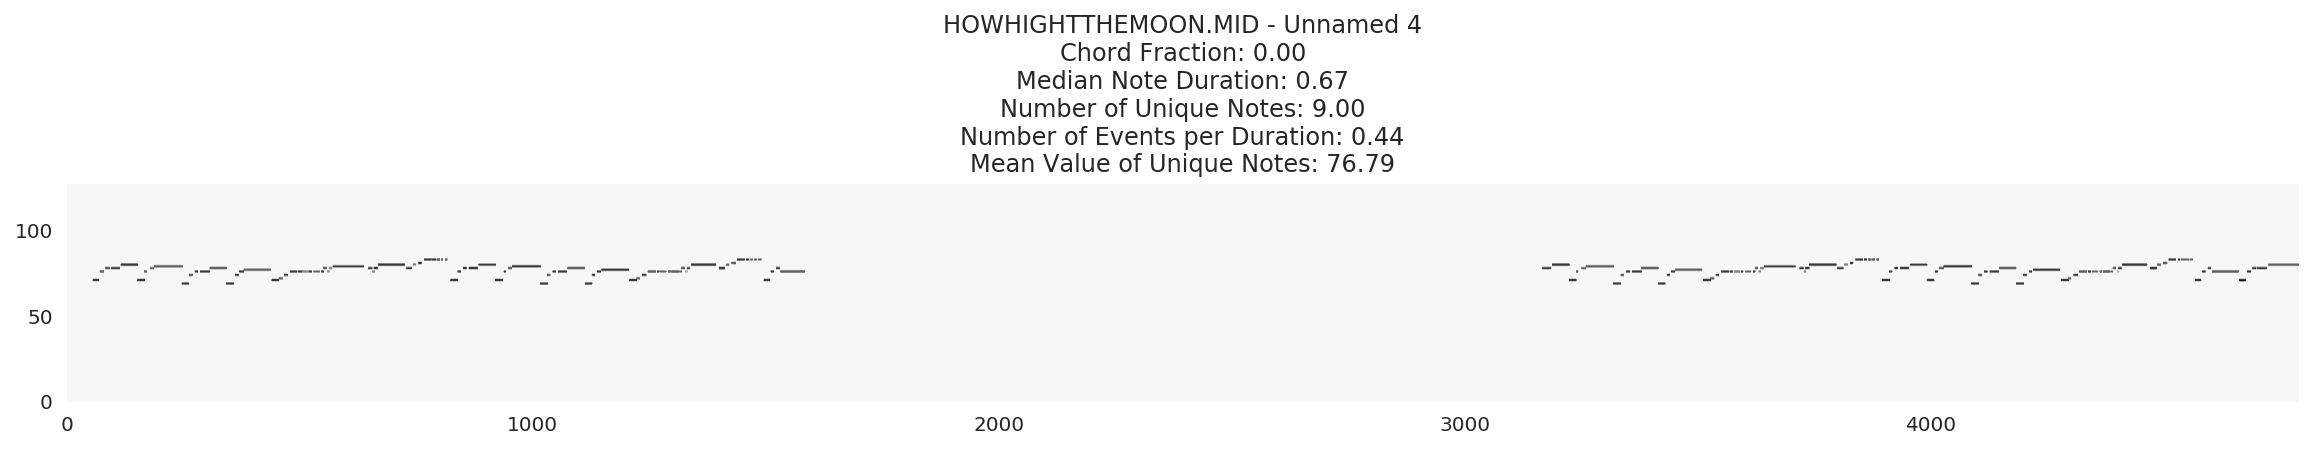

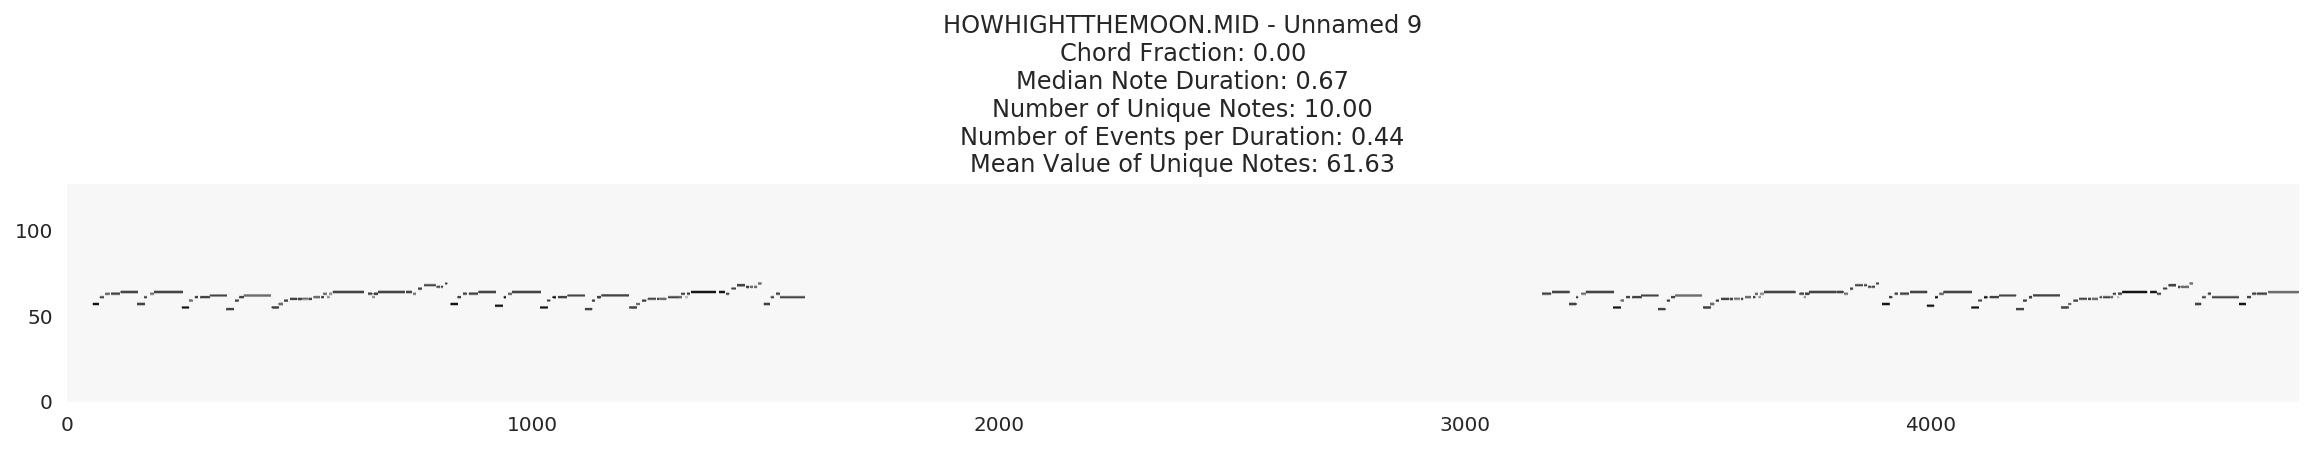

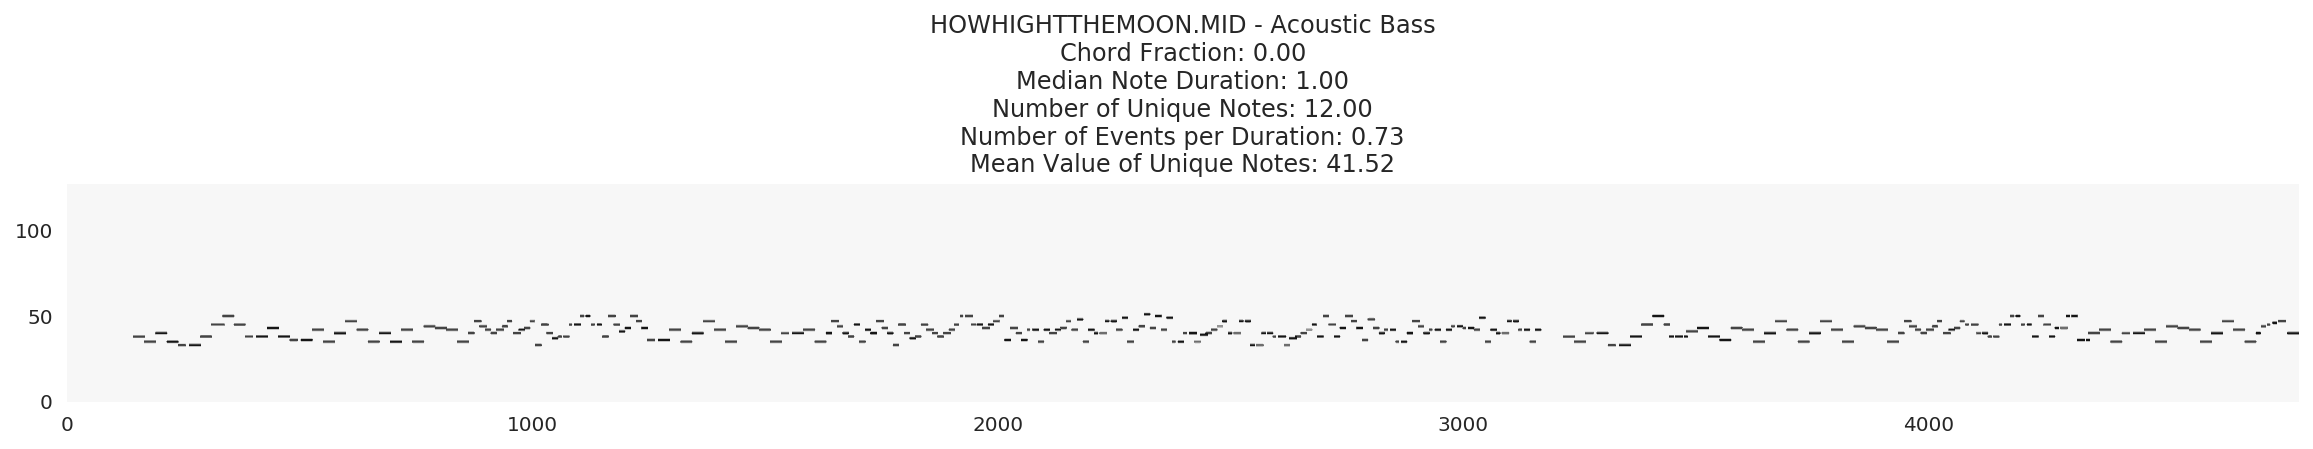

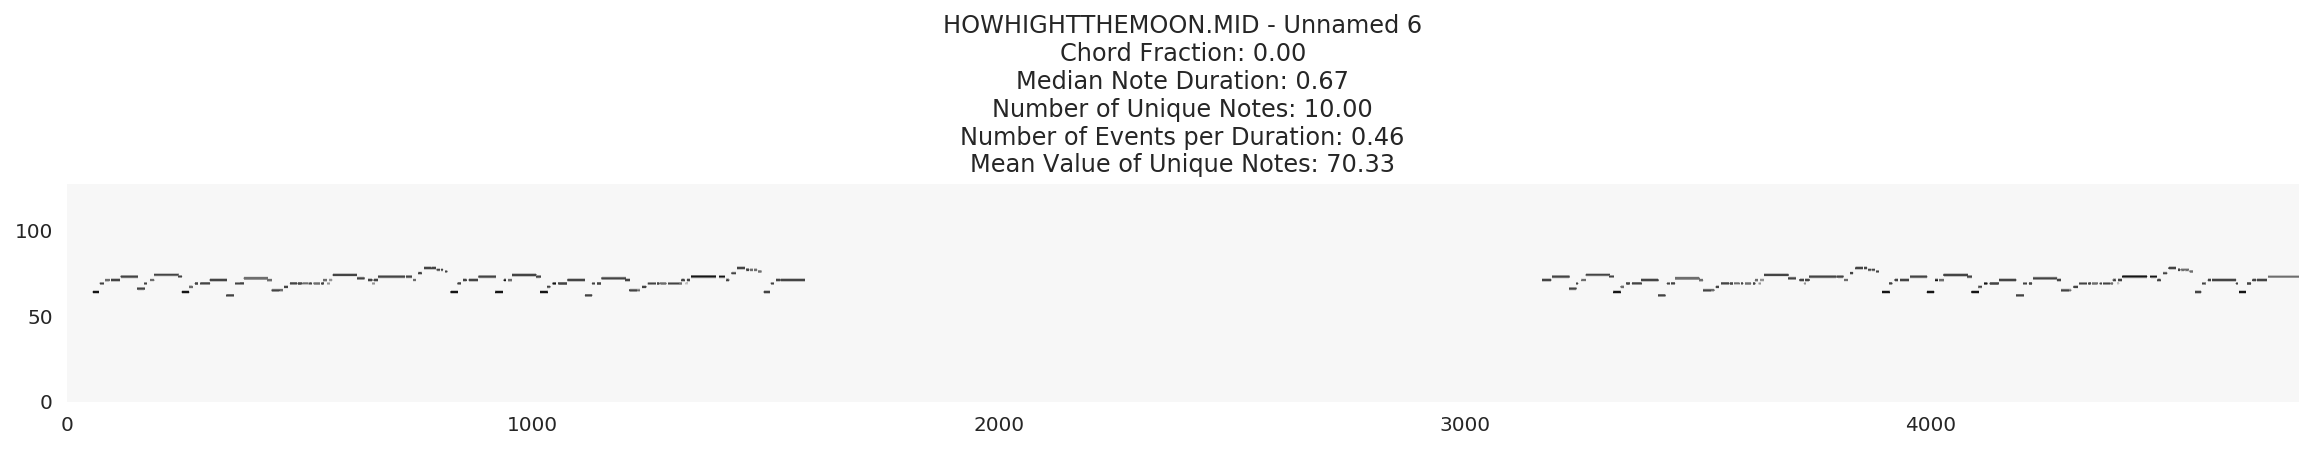

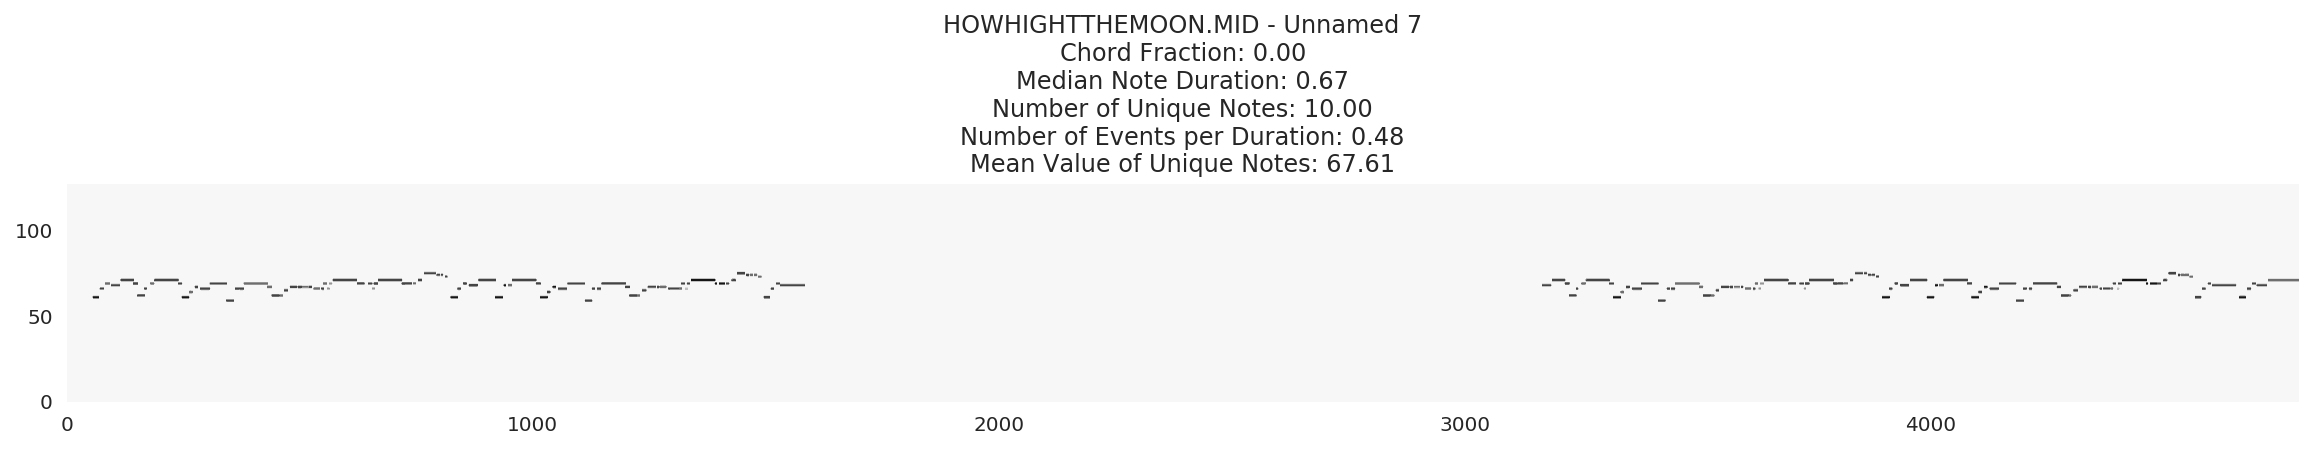

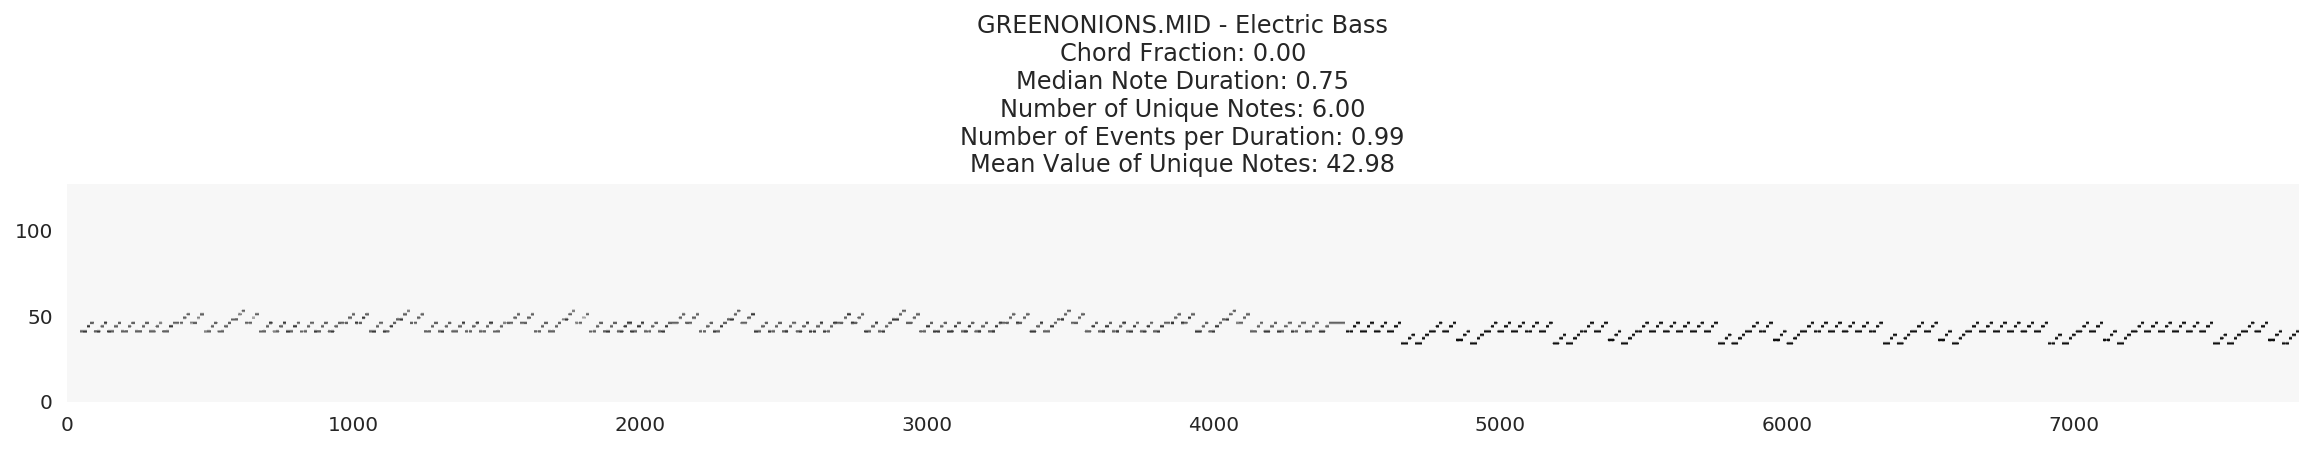

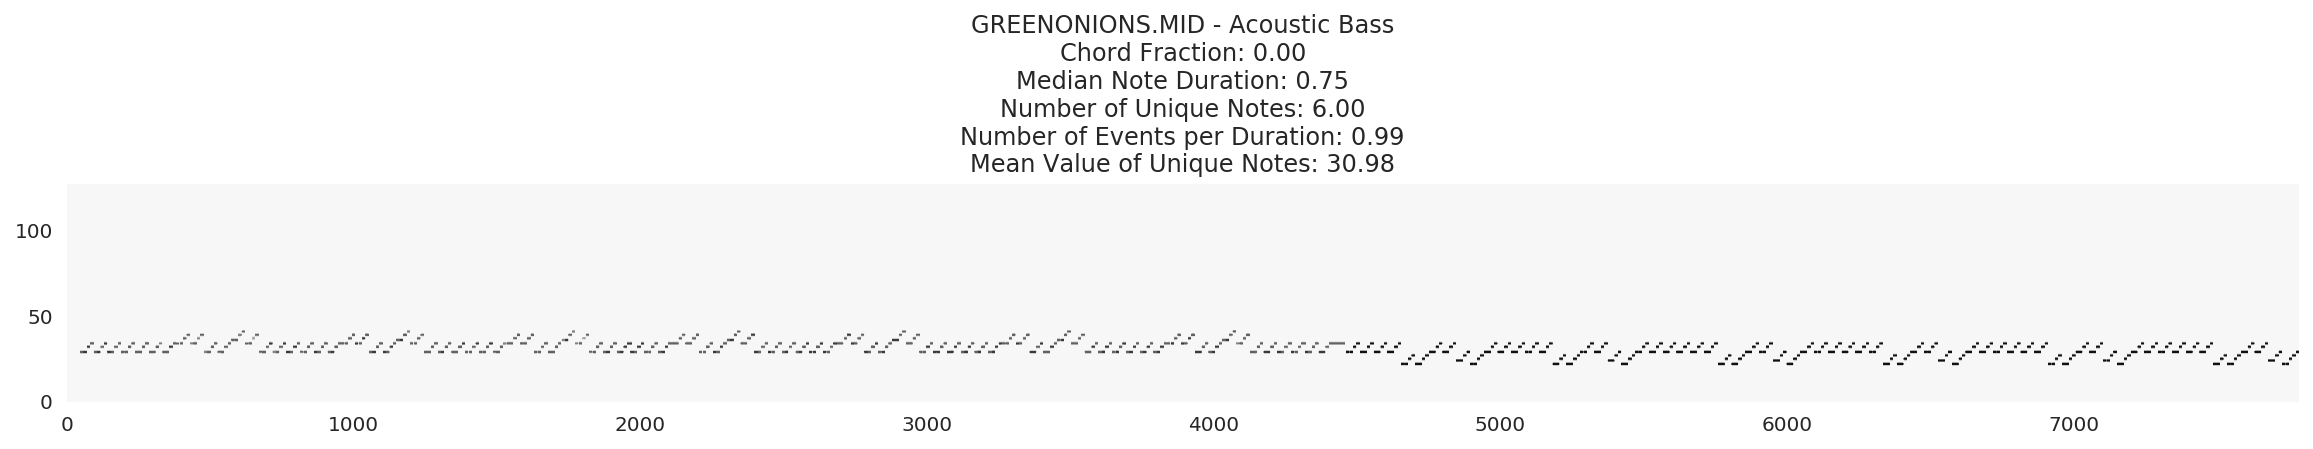

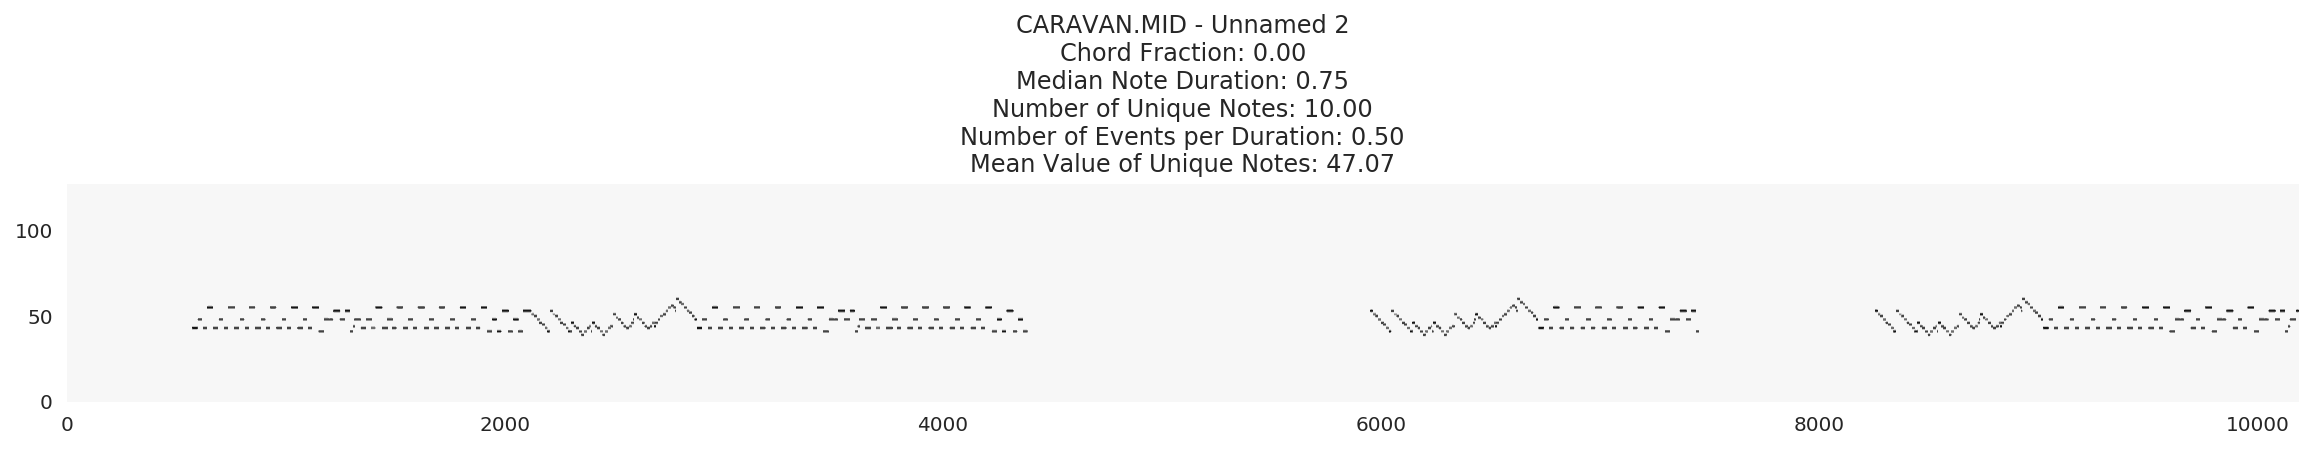

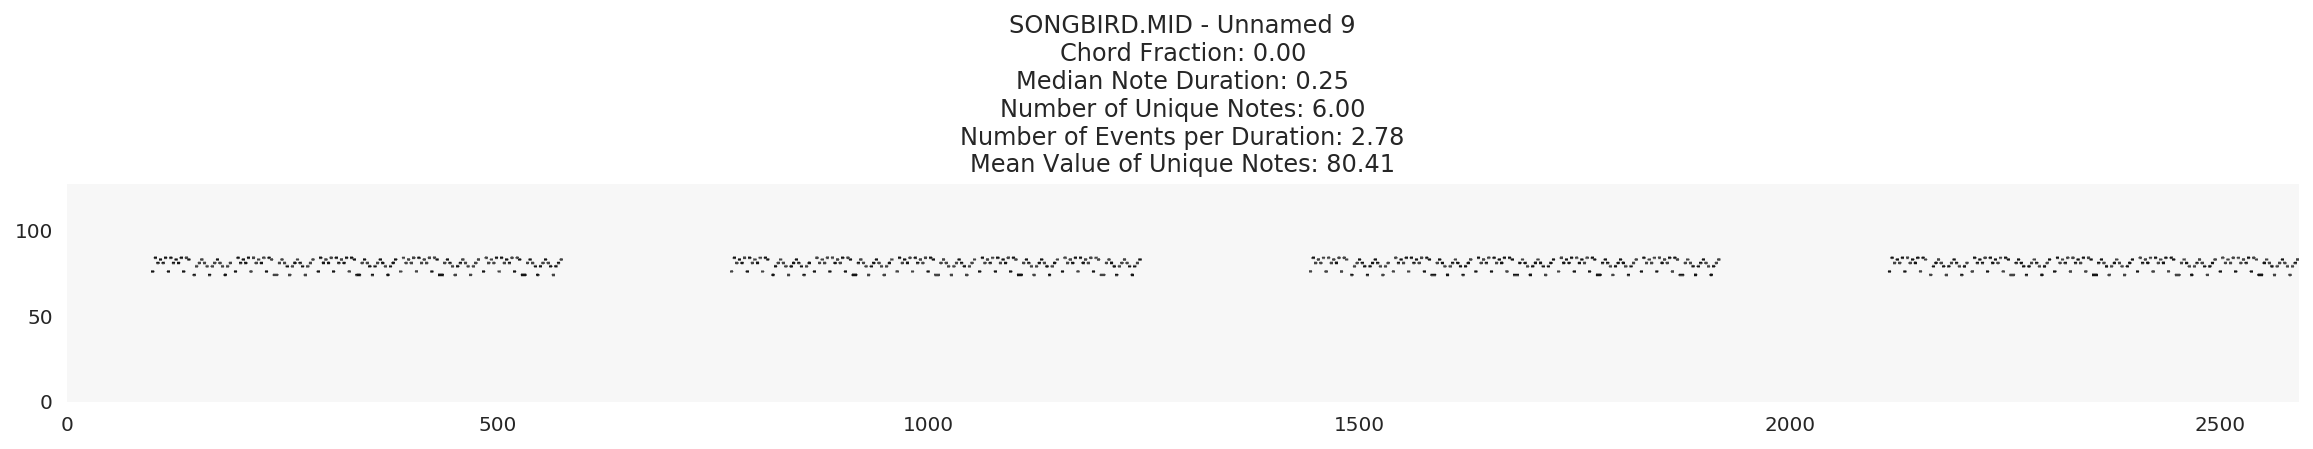

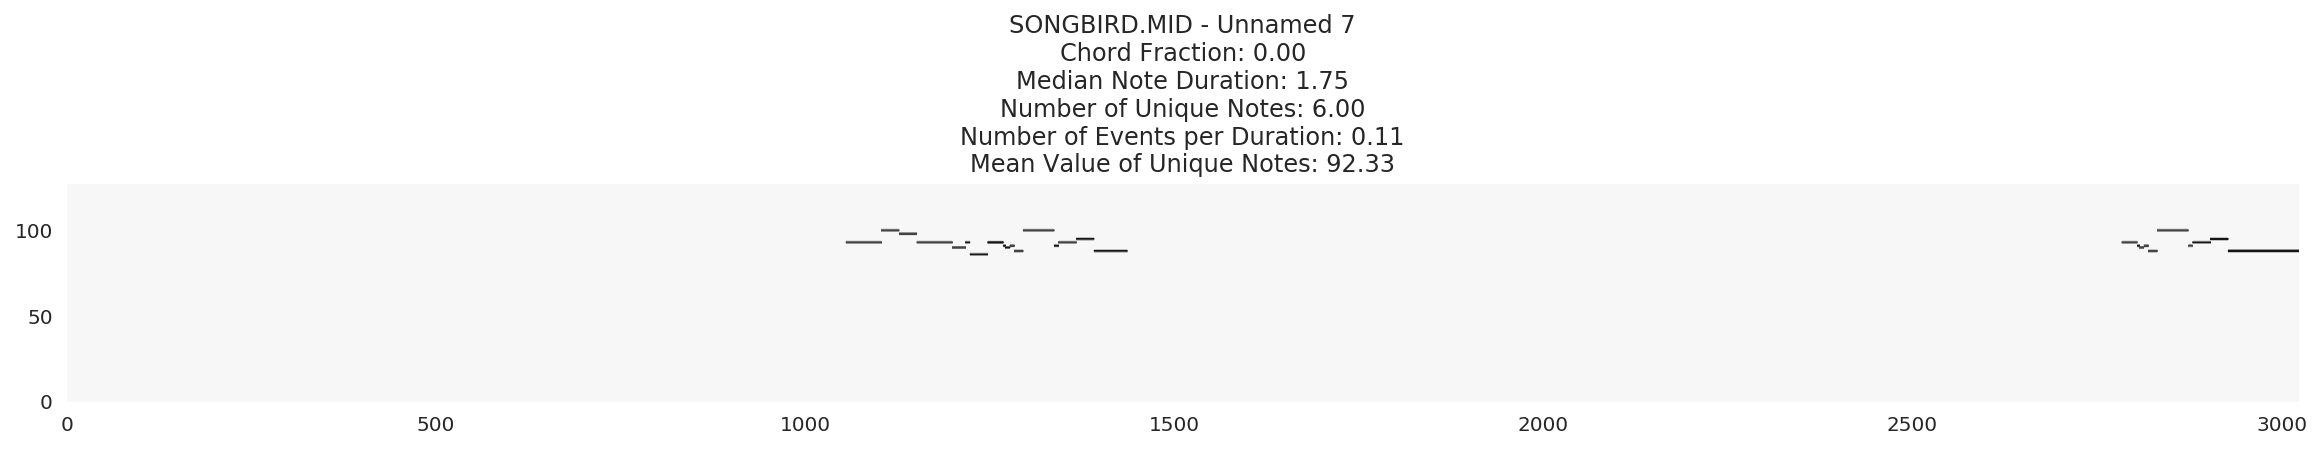

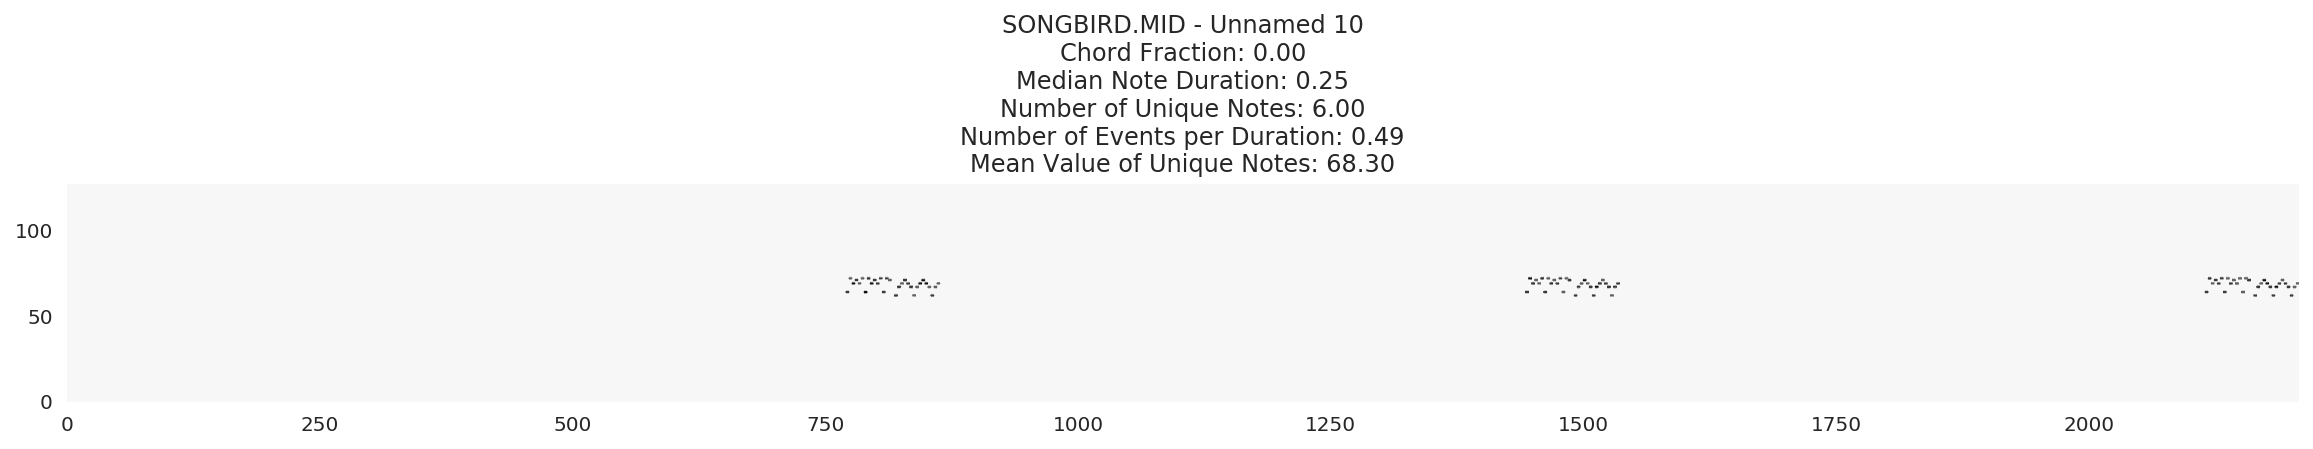

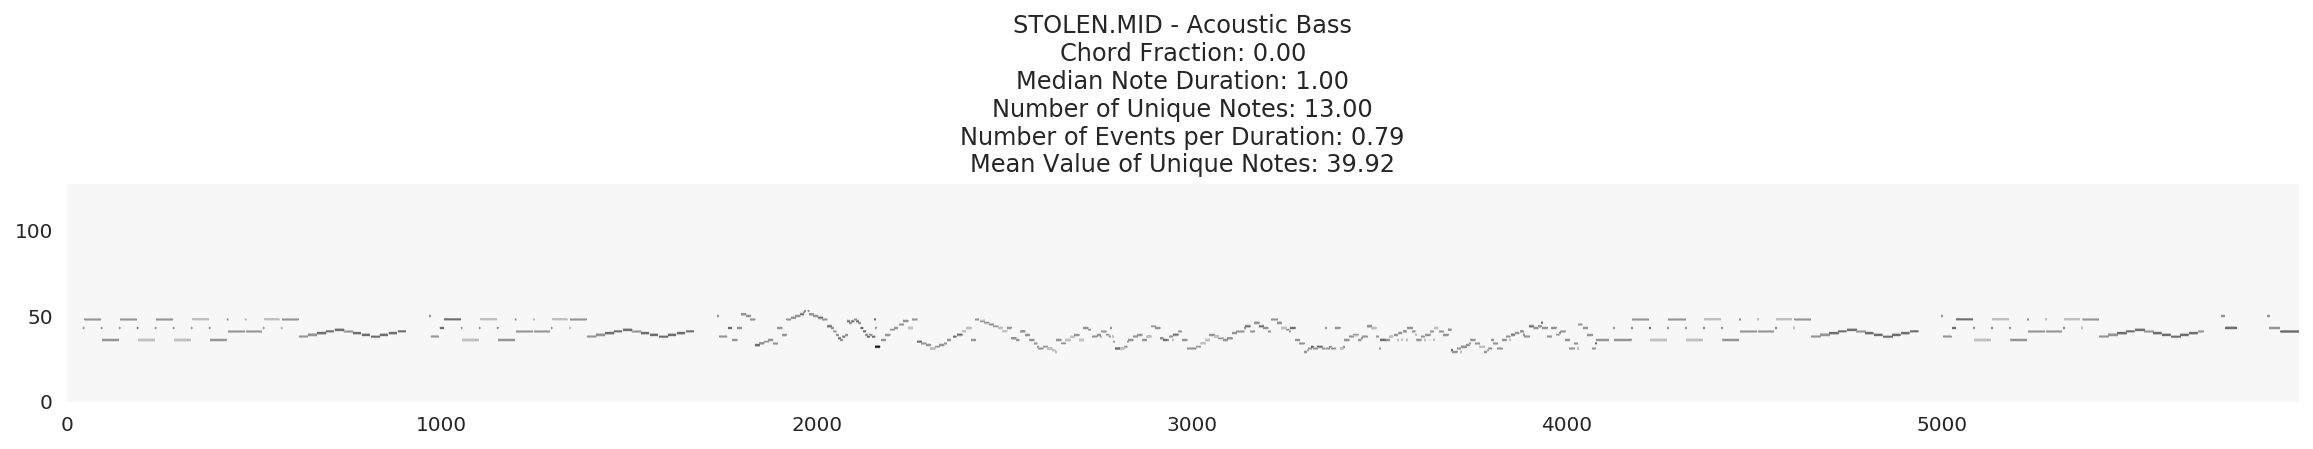

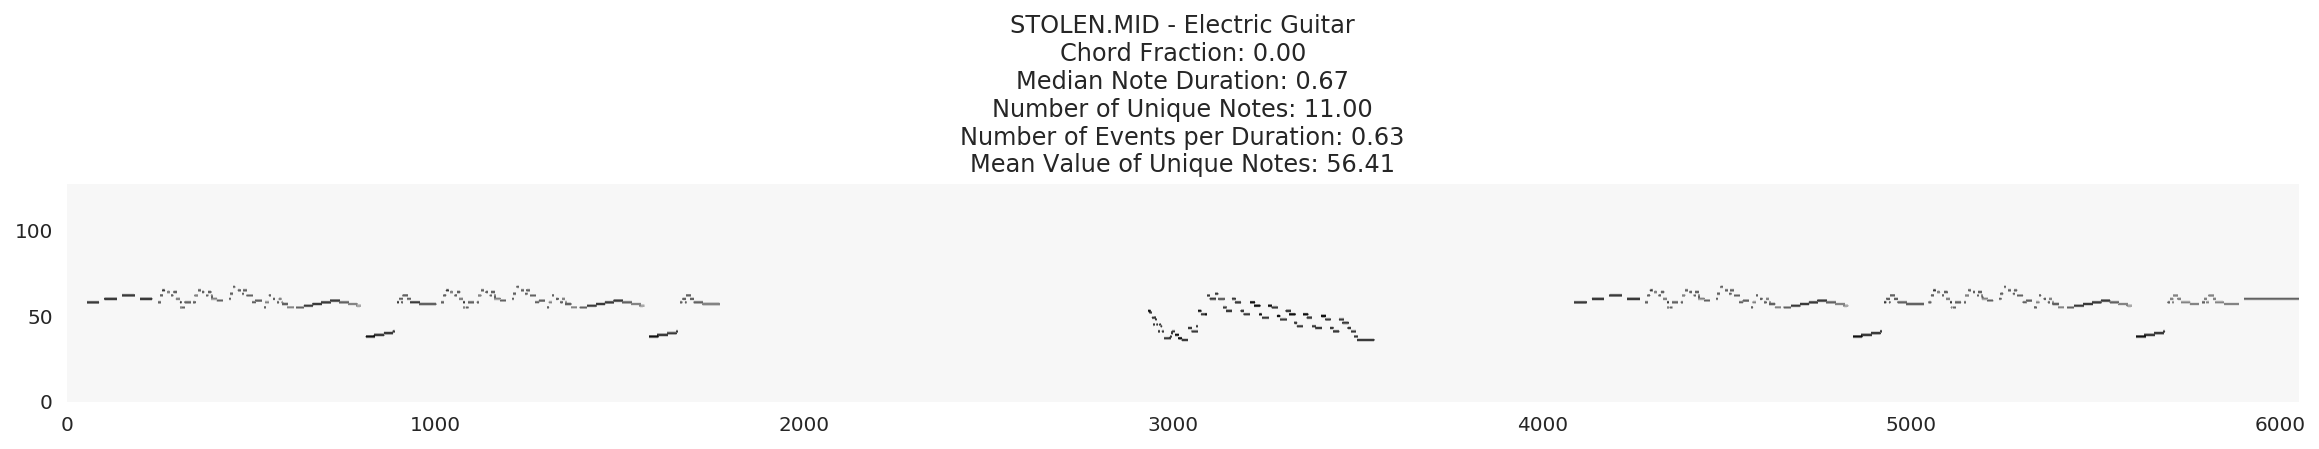

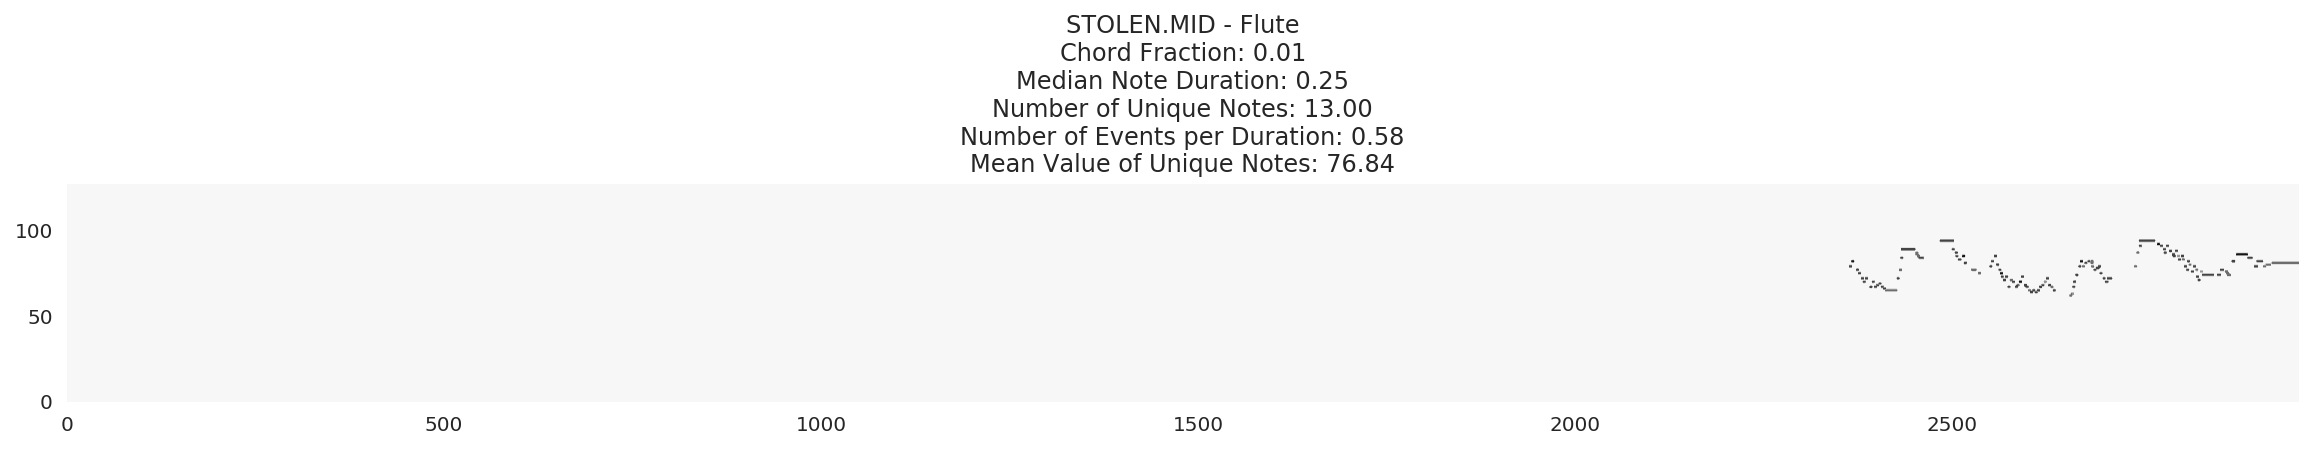

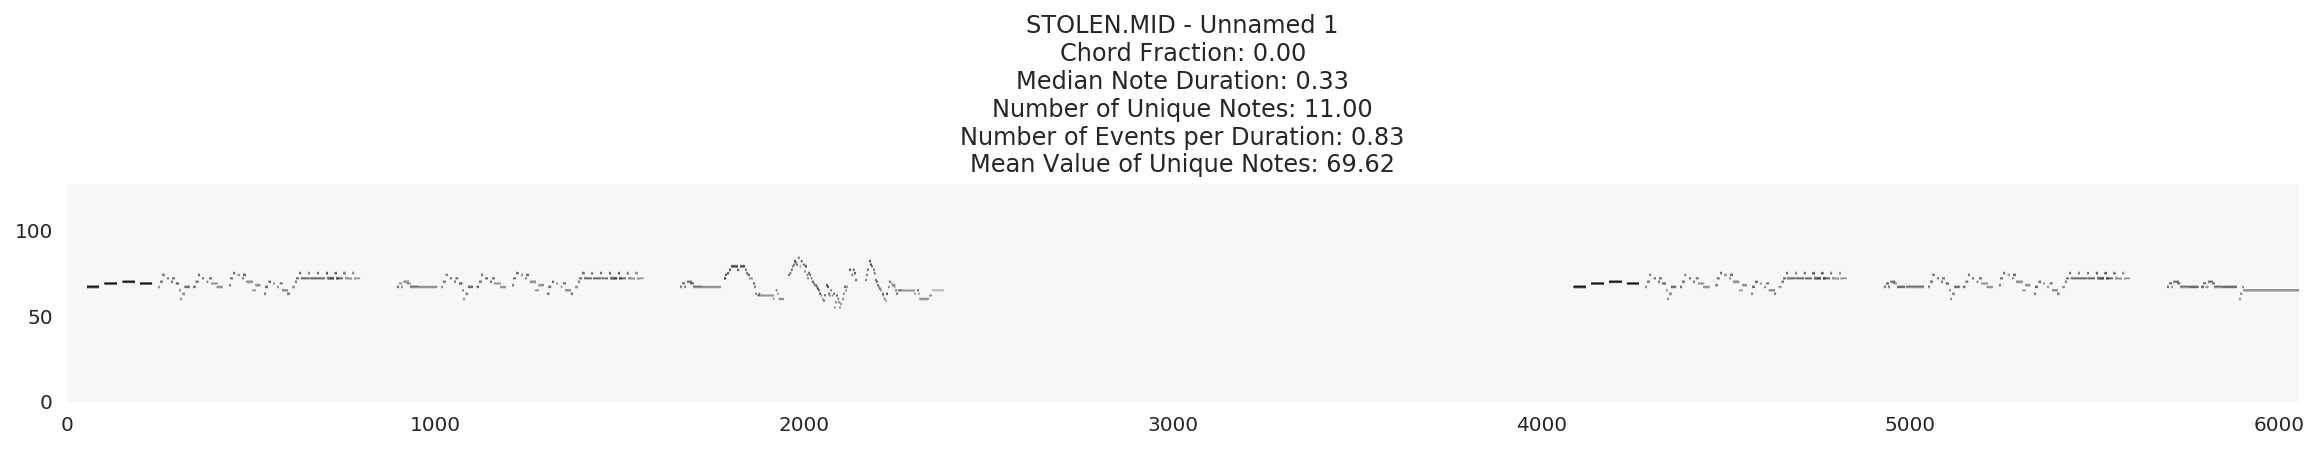

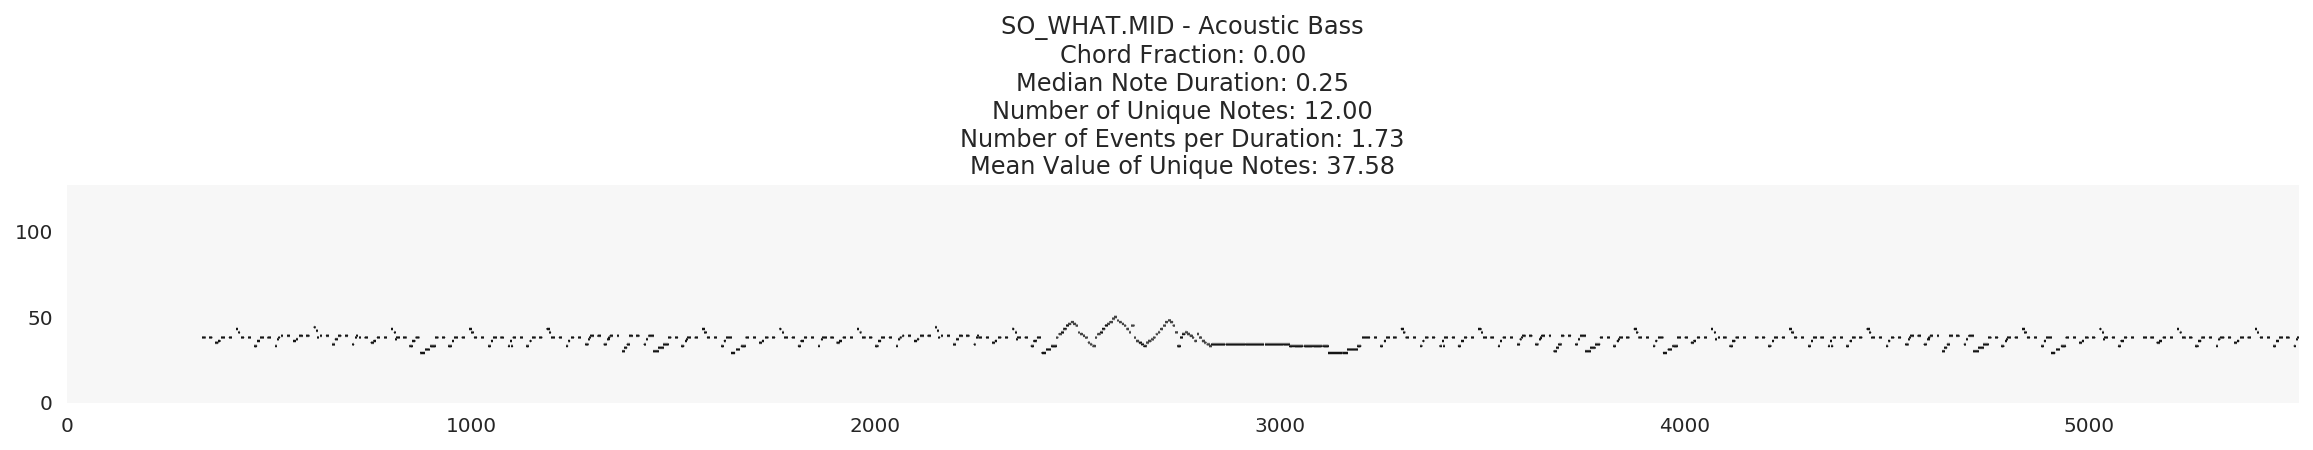

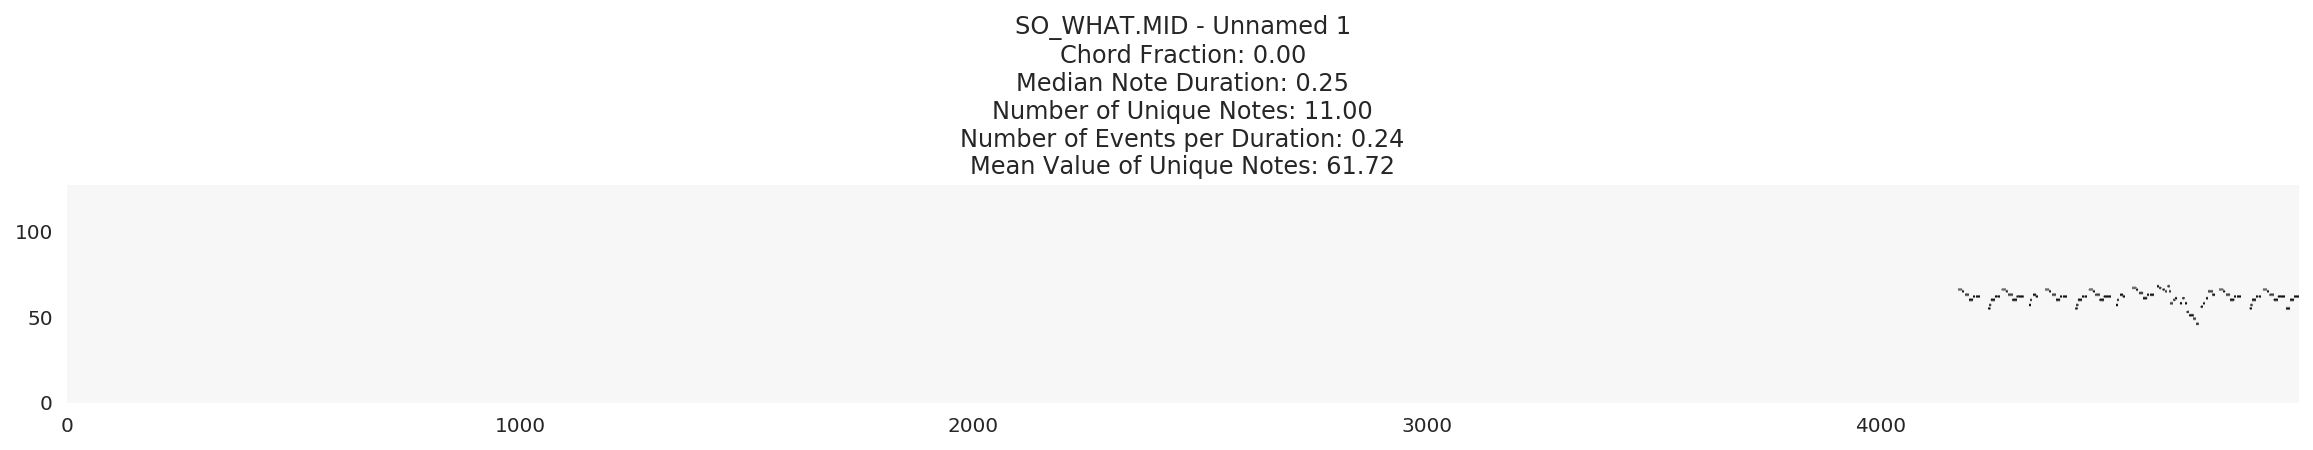

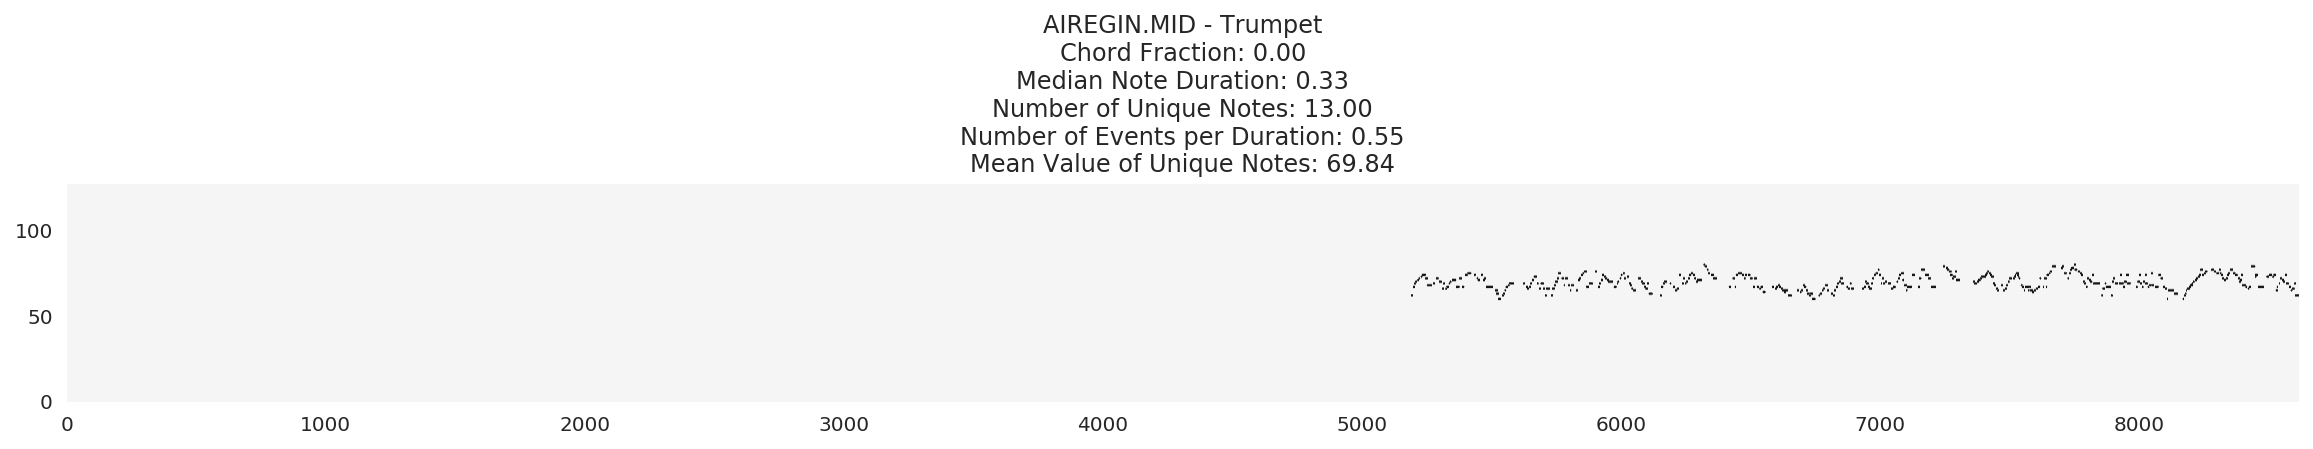

In [86]:
use_filt = melody_filt
for i, (song, track) in enumerate(y[use_filt]):
    print(song)
    print(track)
    plt.figure(figsize=(20,2))
    plt.contourf(KJPM.create_grid(song_notes[song][track][0]))
    plt.title("%s - %s\nChord Fraction: %0.2f\nMedian Note Duration: %0.2f\nNumber of Unique Notes: %0.2f\nNumber of Events per Duration: %0.2f\nMean Value of Unique Notes: %0.2f" 
              % (song.upper(), 
                 track, 
                 X[use_filt][i,1],
                 X[use_filt][i,2],
                 X[use_filt][i,3],
                 X[use_filt][i,0],
                 X[use_filt][i,4]))
    if i > 40:
        break

In [ ]:
def extract_melody_sequence(melody):
    pass

def extract_chord_sequence(chords):
    pass

In [367]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, MeanShift

In [368]:
clf = KMeans(n_clusters=3)
# clf = DBSCAN()
# clf = AgglomerativeClustering(n_clusters=4)
# clf = MeanShift()

In [369]:
y_pred = clf.fit_predict(X)

In [370]:
import pandas as pd
df = pd.DataFrame([list(np.append(a, int(b))) for a,b in zip(y, y_pred)], columns=['Song', 'Track', 'Class'])

In [371]:
df

Song               Track Class
0             bebop.mid           Unnamed 1     0
1             bebop.mid           Unnamed 4     0
2             bebop.mid               Piano     0
3             bebop.mid           Unnamed 5     0
4             bebop.mid           Unnamed 3     0
5             bebop.mid       Acoustic Bass     0
6             bebop.mid           Unnamed 2     0
7     foolishthings.mid           Unnamed 1     1
8     foolishthings.mid            Trombone     0
9     foolishthings.mid               Piano     0
10    foolishthings.mid  Baritone Saxophone     0
11    foolishthings.mid             Trumpet     0
12    foolishthings.mid       Acoustic Bass     0
13    foolishthings.mid           Saxophone     0
14          so_what.mid     Electric Guitar     1
15          so_what.mid           Unnamed 1     0
16          so_what.mid               Piano     1
17          so_what.mid       Acoustic Bass     0
18          so_what.mid           Unnamed 2     0
19          so_what.mid           Saxophone     0
20          ipanema.mid           Unnamed 1     0
21          ipanema.mid               Piano     0
22          ipanema.mid               Flute     0
23          ipanema.mid              Guitar     1
24          ipanema.mid            Mandolin     0
25          ipanema.mid           Unnamed 2     0
26          ipanema.mid       Acoustic Bass     0
27          ipanema.mid             Piccolo     0
28            fever.mid            Trombone     0
29            fever.mid               Piano     2
..                  ...                 ...   ...
601       killerjoe.mid               Flute     0
602       killerjoe.mid           Unnamed 2     1
603       killerjoe.mid           Unnamed 4     0
604       killerjoe.mid           Saxophone     0
605      chicken(3).mid     Tenor Saxophone     0
606      chicken(3).mid  Baritone Saxophone     0
607      chicken(3).mid       Bass Trombone     0
608      chicken(3).mid       Electric Bass     0
609      chicken(3).mid             Trumpet     0
610      chicken(3).mid               Piano     0
611            tutu.mid           Unnamed 1     0
612            tutu.mid               Piano     0
613            tutu.mid           Unnamed 5     0
614            tutu.mid       Electric Bass     0
615            tutu.mid           Unnamed 7     0
616            tutu.mid           Unnamed 6     0
617            tutu.mid           Unnamed 4     0
618            tutu.mid           Unnamed 9     0
619            tutu.mid           Unnamed 8     0
620            tutu.mid           Unnamed 3     0
621            tutu.mid               Flute     0
622            tutu.mid           Unnamed 2     1
623  funnyvalentine.mid       Fretless Bass     0
624  funnyvalentine.mid           Unnamed 1     0
625  funnyvalentine.mid               Piano     1
626  funnyvalentine.mid          Vibraphone     0
627  funnyvalentine.mid              Guitar     0
628  funnyvalentine.mid            Mandolin     0
629  funnyvalentine.mid           Unnamed 2     0
630  funnyvalentine.mid           Saxophone     0

[631 rows x 3 columns]

2
Loading bebop.json
Piano
9
Loading foolishthings.json
Piano
16
Loading so_what.json
Piano
21
Loading ipanema.json
Piano
23
Loading ipanema.json
Guitar
Guitar not in song grid file
29
Loading fever.json
Piano
38
Loading thestripper.json
Piano
49
Loading aprilinparis.json
Guitar
Guitar not in song grid file
61
Loading birdland.json
Piano
63
Loading greenonions.json
Piano
70
Loading reflections.json
Piano
72
Loading reflections.json
Guitar
Guitar not in song grid file
76
Loading thismasquerade.json
Piano
79
Loading thismasquerade.json
Guitar
Guitar not in song grid file
87
Loading iremclif.json
Piano
90
Loading iremclif.json
Guitar
Guitar not in song grid file
93
Loading saltpeanuts.json
Piano
102
Loading theverythoughtofyou.json
Piano


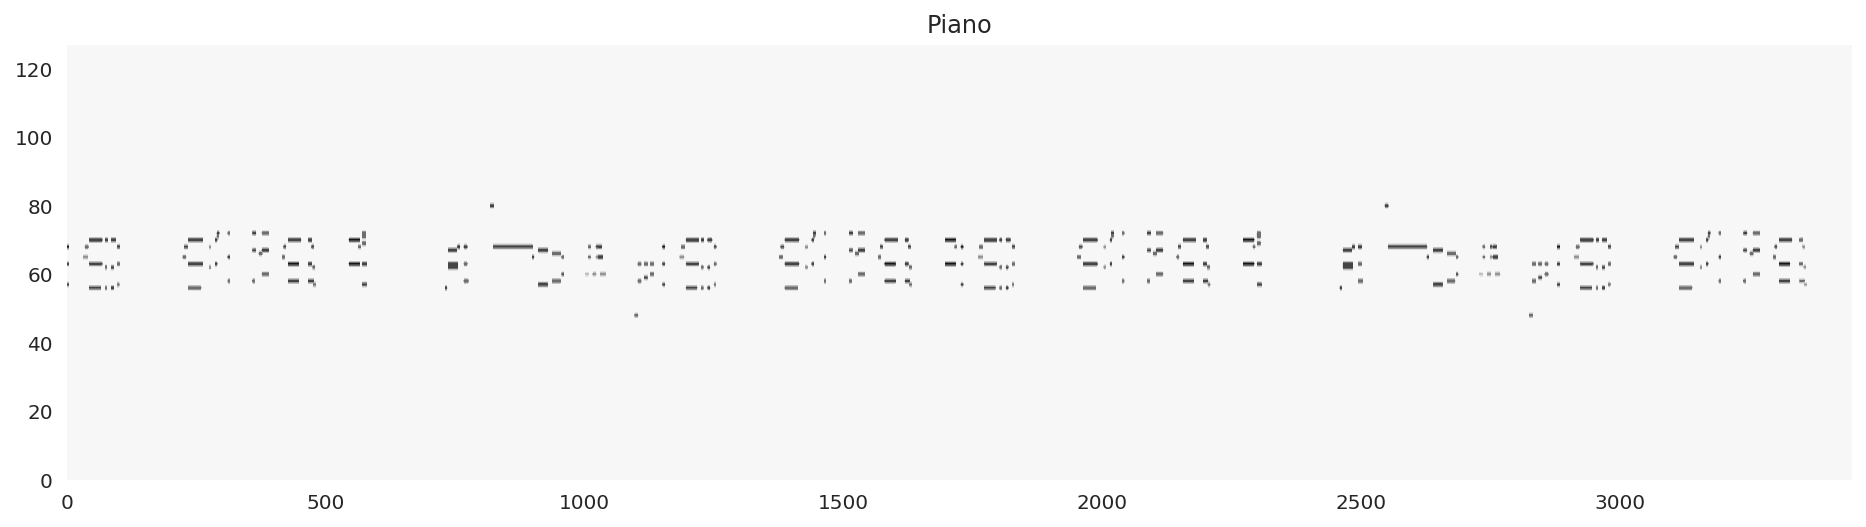

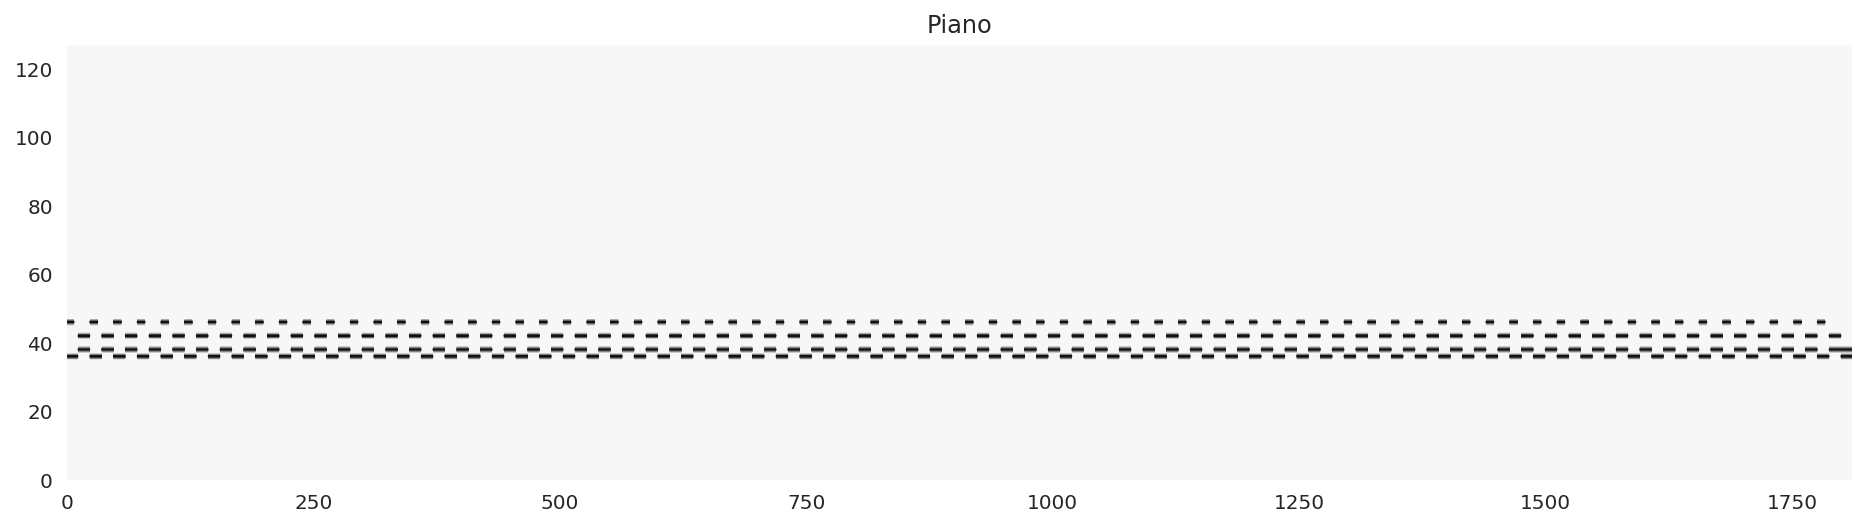

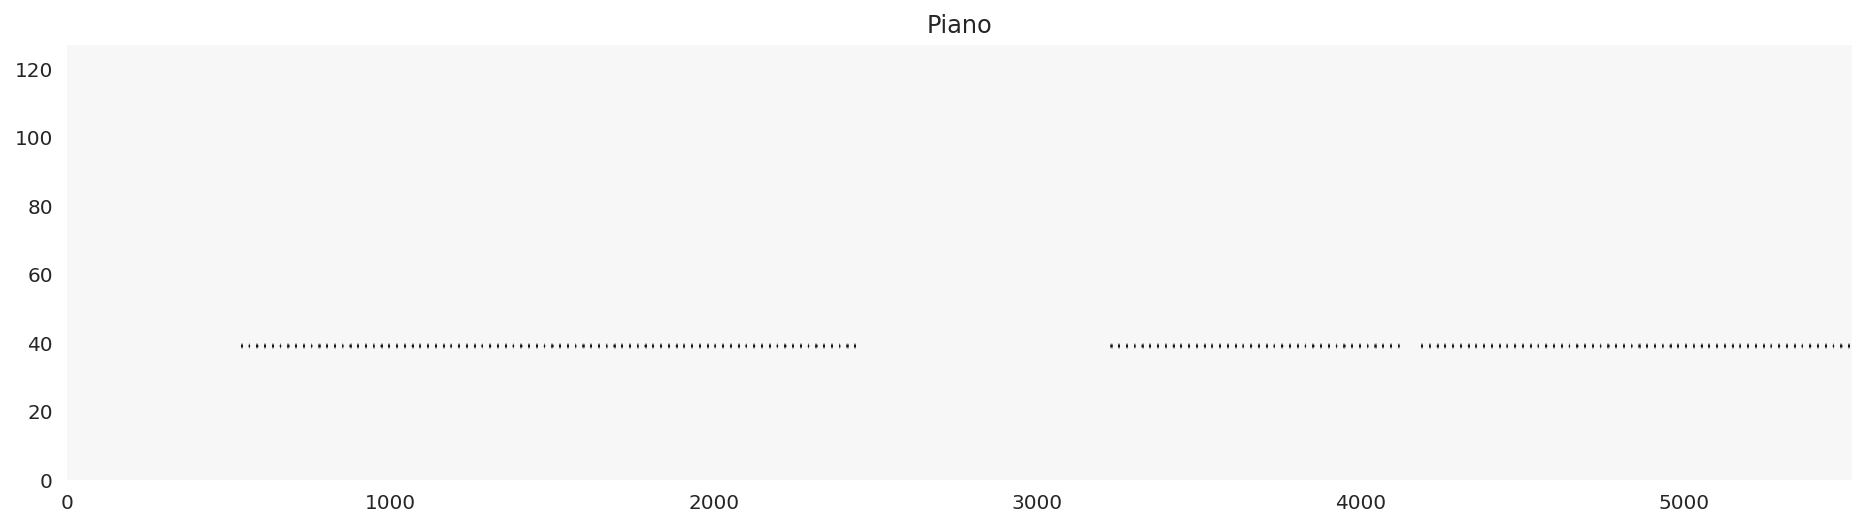

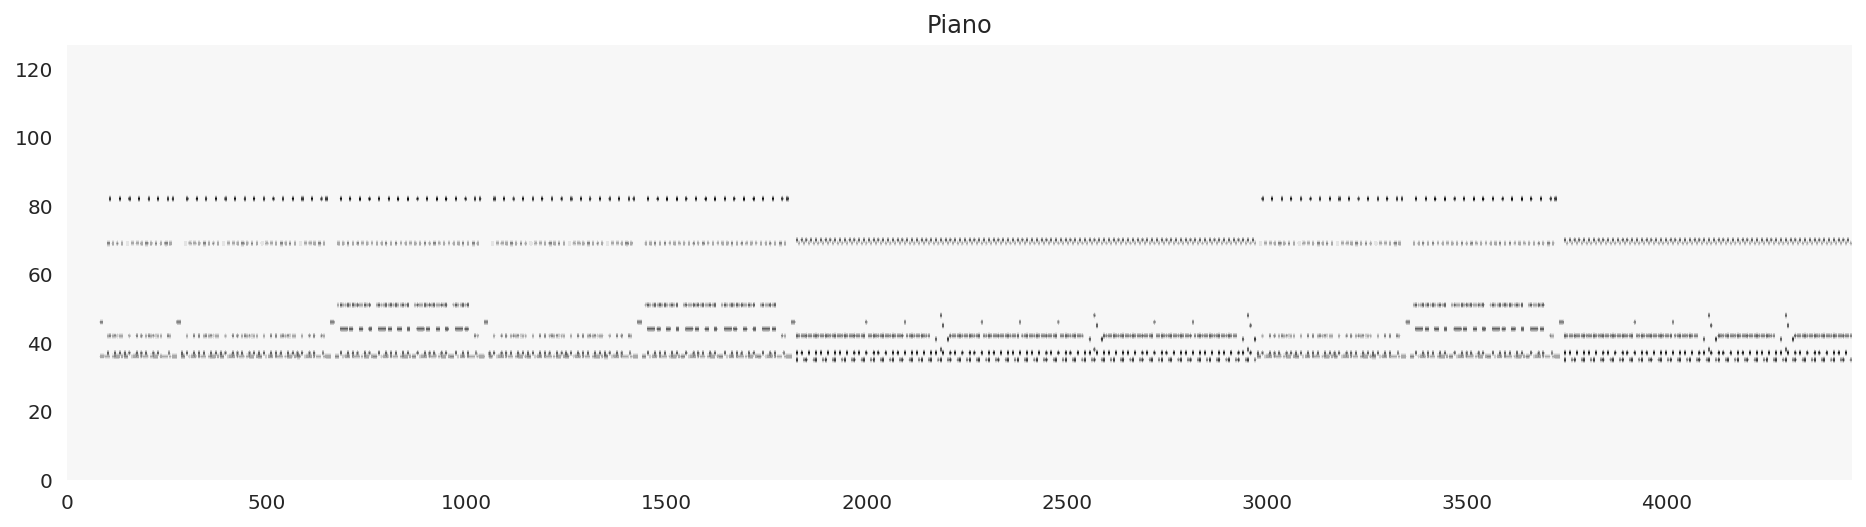

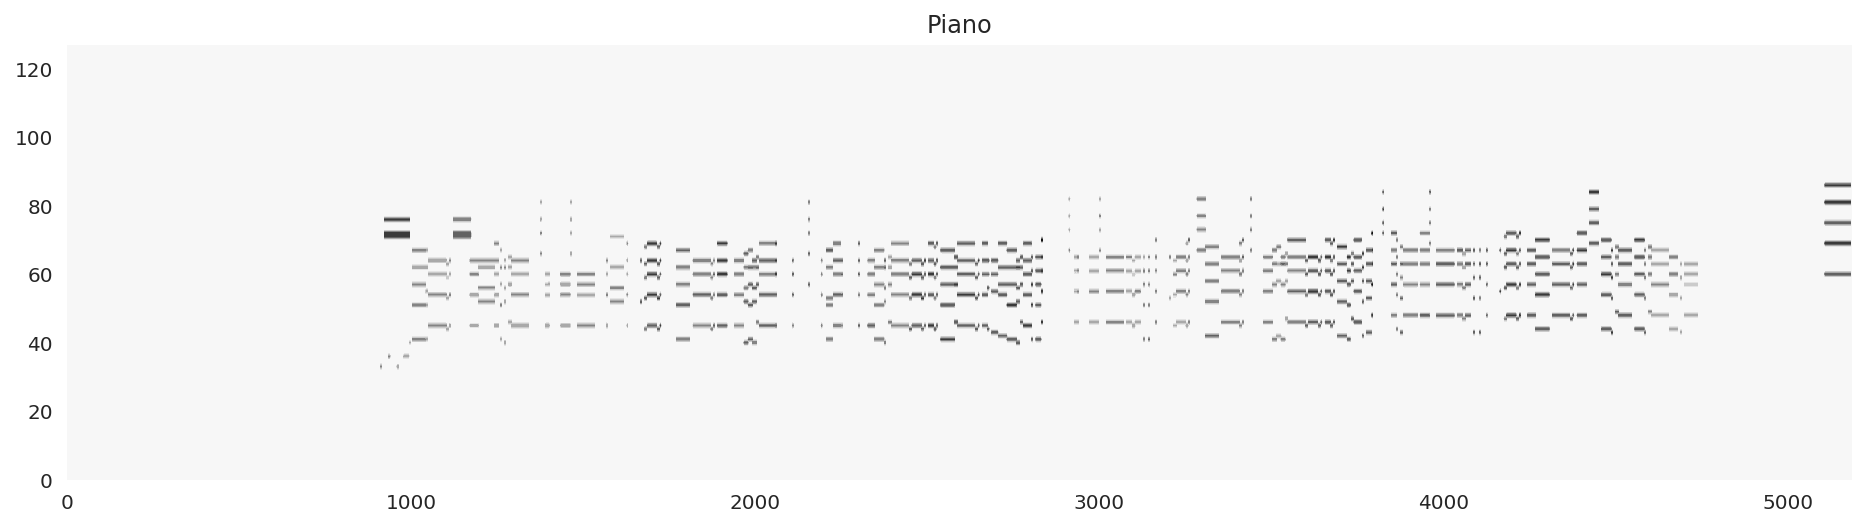

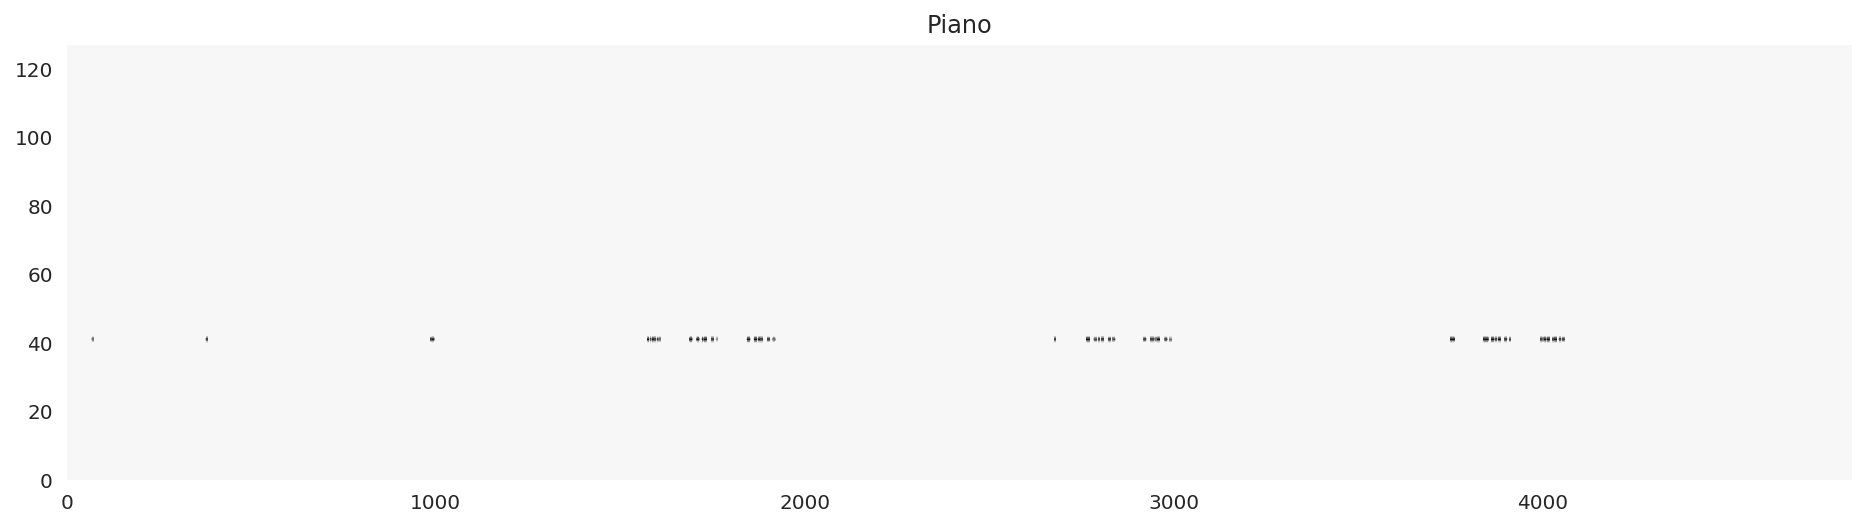

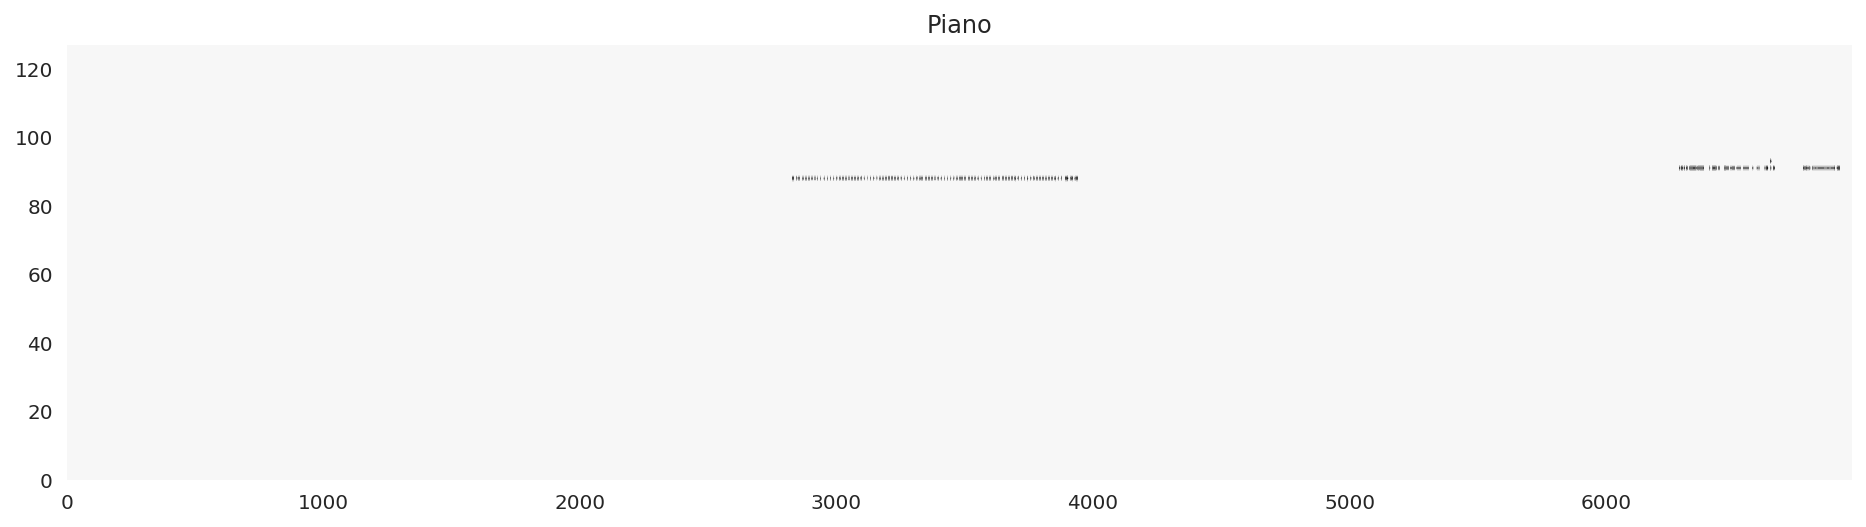

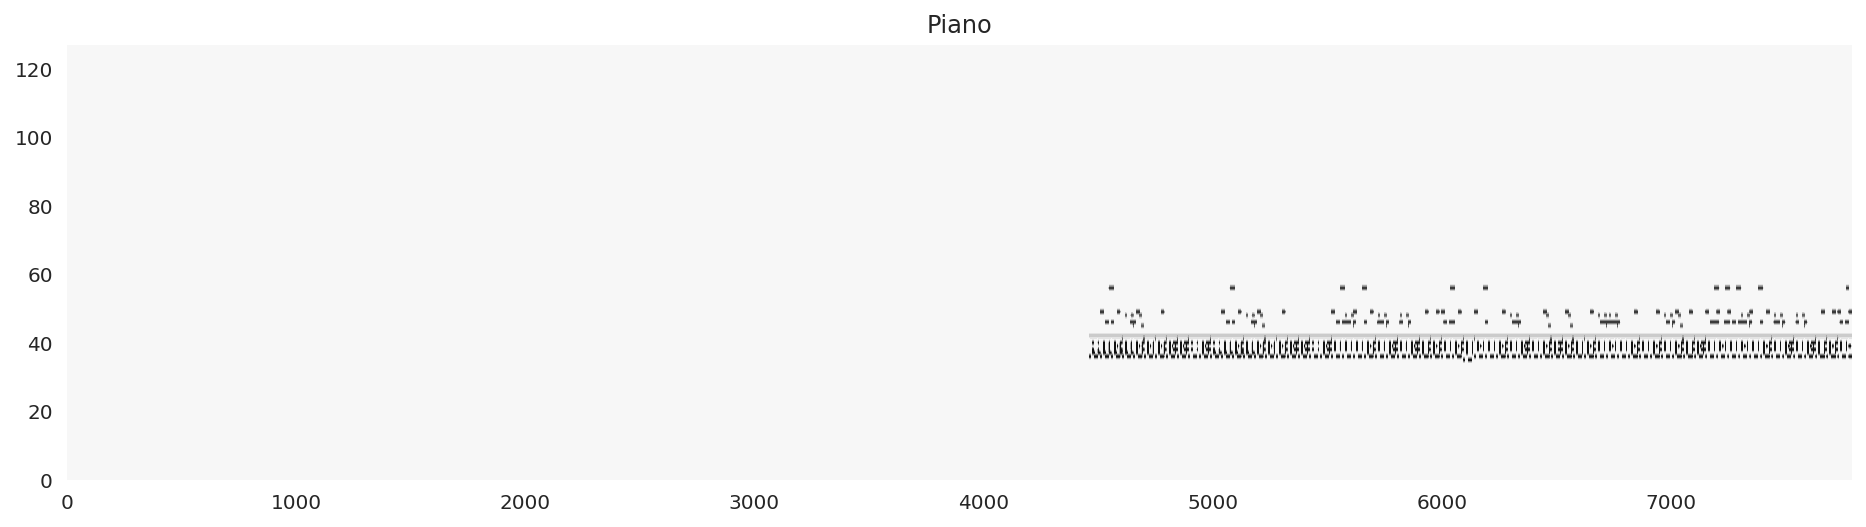

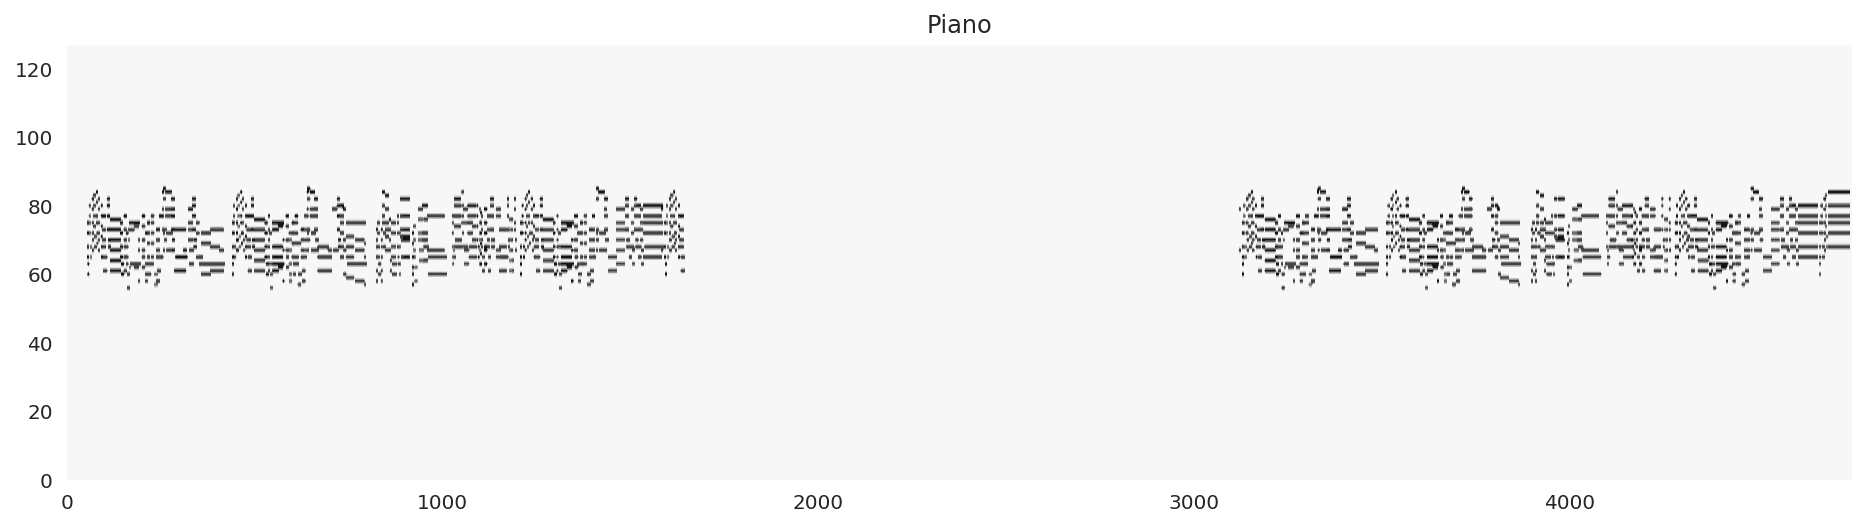

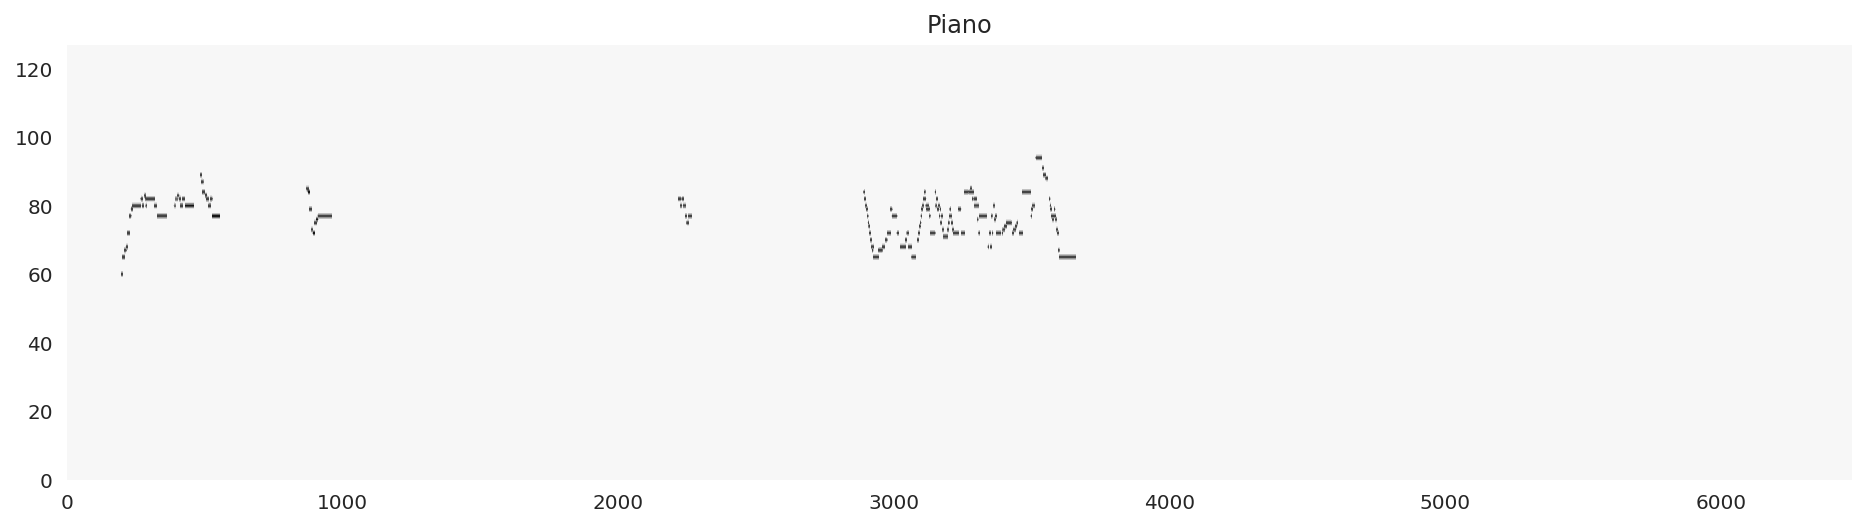

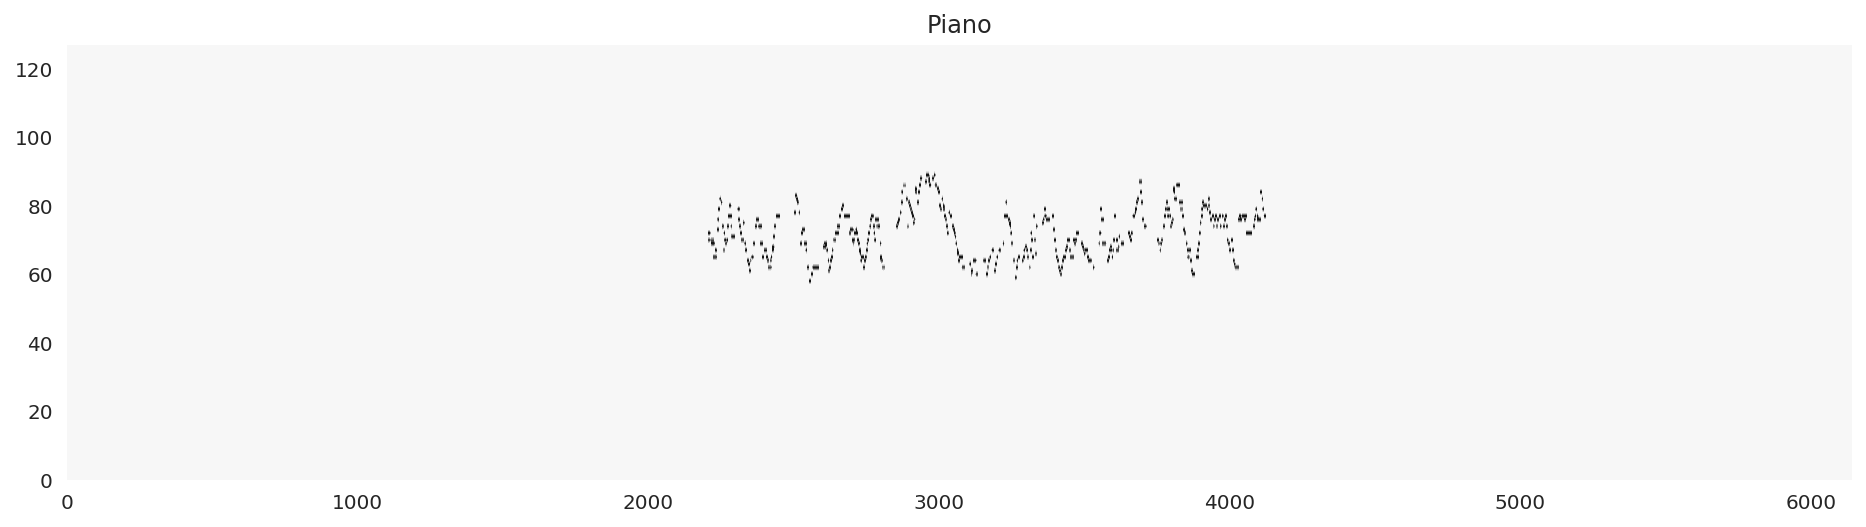

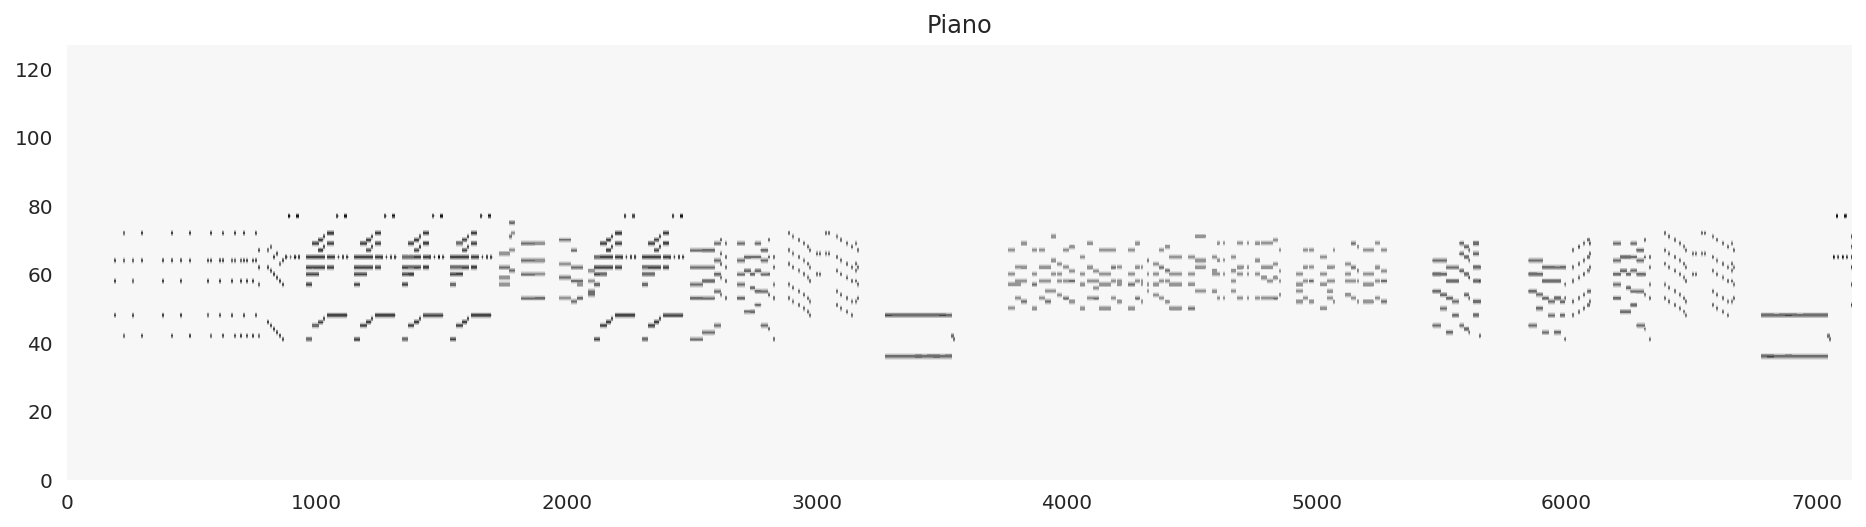

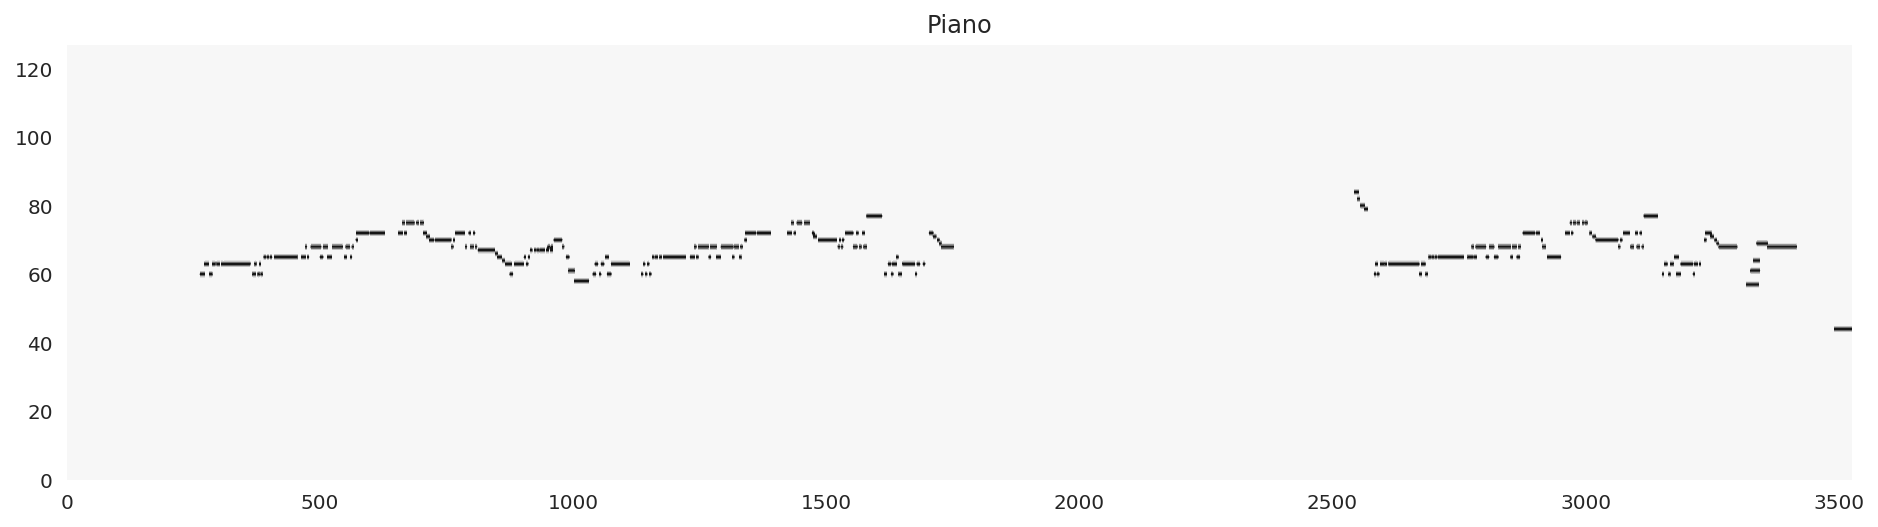

In [374]:
for row, item in df[df['Track'].isin(['Piano', 'Guitar'])].iterrows():
    print(row)
    track_name = item['Track']
    song_name = item['Song']
    song_grid = KJPM.music_unjsonify(item['Song'].lower().replace('.mid', '.json'))
    try:
        print(track_name)
        plt.figure(figsize=(16,4))
        plt.contourf(song_grid['instruments'][track_name])
        plt.title(track_name)
    except:
        print(track_name + " not in song grid file")
        continue
    if row > 100:
        break

In [243]:
song_grid

{'ending_bpm': 120,
 'instruments': {'Acoustic Bass': array([[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]),
  'Alto Saxophone': array([[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]),
  'Electric Guitar': array([[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]),
  'Flute': array([[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,


In [21]:
for song, tracks in sequences.items():
    if 'automn' not in song:
        continue
    for track, seq in tracks.items():
        print(track, sum([x.isChord for x in seq])/len(seq))

Saxophone 0.0
Bass Trombone 0.0
Piccolo 0.0
Acoustic Bass 0.0
Guitar 0.5793450881612091
Unnamed 3 0.5546623794212219
Unnamed 1 0.5405405405405406
Unnamed 2 0.9504132231404959


In [76]:
x = [elem for elem in song_notes[item]['Piano'] if type(elem) in [note.Note, chord.Chord]]

In [78]:
musicnote = x[0]

In [79]:
musicnote.

/home/chrisgiler/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: Music21DeprecationWarning: Note._getPs was deprecated on May 2014 and will disappear at or after September 2017, v.5. use pitch.ps instead
  if __name__ == '__main__':


69.0

In [37]:
environment

<module 'music21.environment' from '/home/chrisgiler/anaconda3/lib/python3.5/site-packages/music21/environment.py'>

In [97]:
midi_data = KJPM.load_midi('midi_files/Brazil.mid')

In [98]:
midi_data.analyze('key')

<music21.key.Key of D major>

In [99]:
parts = [p for p in midi_data.parts]

In [100]:
print(parts[0].partName)

Fretless Bass


In [101]:
notes_list = {}
unnamed_counter = 1
for part in parts:
    part_name = part.partName
    if not part_name:
        part_name = 'Unnamed ' + str(unnamed_counter)
        unnamed_counter += 1
    notes_list[part_name] = [element for element in part.recurse()]

In [102]:
notes_list.keys()

dict_keys(['Unnamed 2', 'Vibraphone', 'Unnamed 1', 'Unnamed 3', 'Fretless Bass', 'Guitar'])

In [125]:
from collections import Counter
all_events = []
for note in notes_list['Guitar']:
    try:
        if note.isChord:
            all_events.append('chord')
        if note.isNote:
            all_events.append('note')
    except:
        pass
Counter(all_events)

Counter({'chord': 307, 'note': 84})

In [128]:
with open('test.pkl', 'wb') as pkl:
    pickle.dump(notes_list, pkl)

In [3]:
song_key = midi_data.analyze('key')
print(song_key)
print(song_key.mode)
print(song_key.sharps)
print(song_key.tonic.pitchClass)

C# major
major
7
1


In [13]:
song_key.mode

'major'

In [10]:
print(song_key.relative)
print(song_key.relative.mode)
print(song_key.relative.sharps)
print(song_key.relative.tonic.pitchClass)

a# minor
minor
7
10


In [15]:
# track_grids = KJPM.get_track_grids(midi_data)
# [[k, v.shape ]for k,v in track_grids.items()]

In [99]:
# Load generated chords
with open('automn_chord_gen_16Mar18.pkl', 'rb') as pkl:
    pred_chords = pickle.load(pkl)

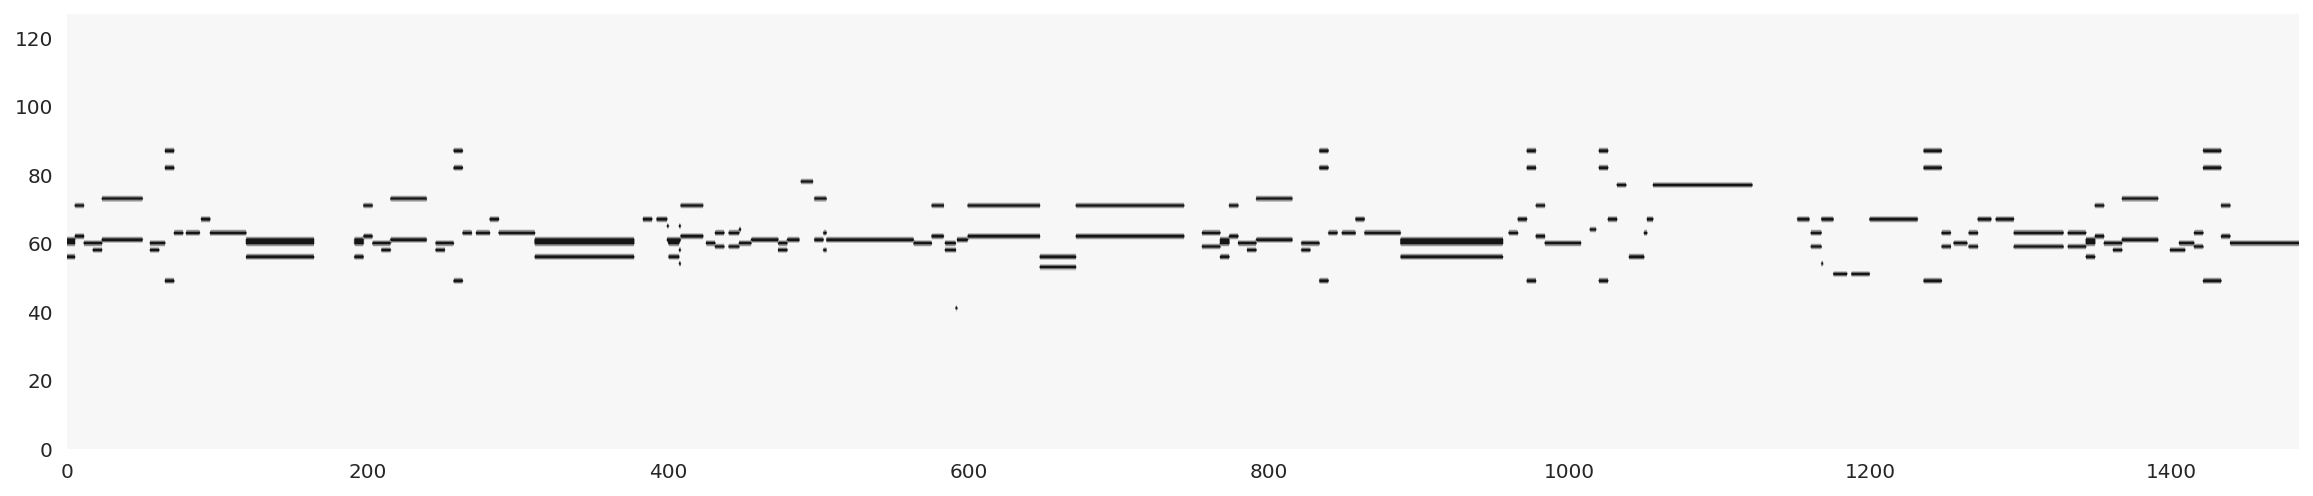

In [100]:
plt.figure(figsize=(20,4))
plt.contourf(pred_chords)

In [101]:
notes = []
for r, row in enumerate(pred_chords):
    counter = 0
    for c, val in enumerate(row):
        if val == 1:
            if counter == 0:
                note = r
                start_tick = c
                counter += 1
        elif val == 0:
            if counter > 0:
                end_tick = c
                notes.append([note, start_tick, end_tick - start_tick])
            counter = 0

In [102]:
notes[:10]

[[41, 592, 1],
 [49, 66, 6],
 [49, 258, 6],
 [49, 834, 6],
 [49, 972, 6],
 [49, 1020, 6],
 [49, 1236, 12],
 [49, 1422, 12],
 [51, 1176, 9],
 [51, 1188, 12]]

In [103]:
from midiutil import MIDIFile

In [104]:
MyMIDI = MIDIFile(1)

In [105]:
track = 0
time = 0
MyMIDI.addTrackName(track, time, "Sample Track")
MyMIDI.addTempo(track, time, 120)

In [106]:
for note in notes:
    pitch  = note[0]  # MIDI note number
    track    = 0
    channel  = 0
    time     = note[1]/12.    # In beats
    duration = note[2]/12.    # In beats
    tempo    = 120   # In BPM
    volume   = 100  # 0-127, as per the MIDI standard
    MyMIDI.addNote(track, channel, pitch, time, duration, volume)

In [107]:
with open("gen_chords_3.mid", "wb") as output_file:
    MyMIDI.writeFile(output_file)

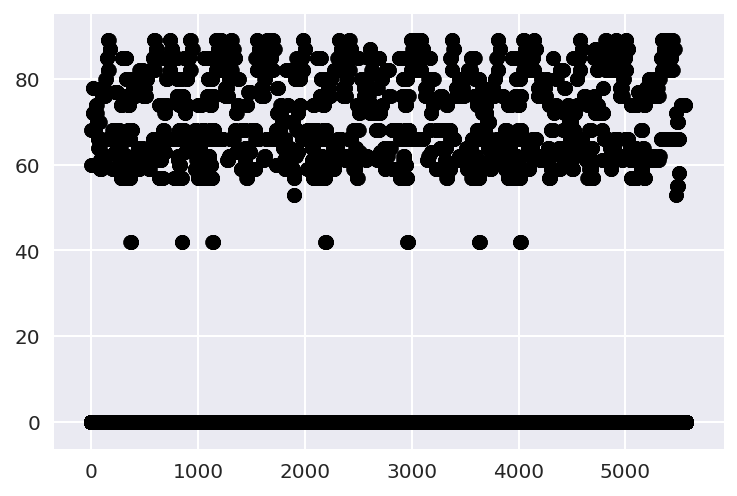

In [10]:
x = range(track_grids['Guitar'].shape[1])
for i in range(track_grids['Guitar'].shape[0]):
    plt.scatter(x, track_grids['Guitar'][i,:], c='k')

In [5]:
everything = []
for i, fn in enumerate(os.listdir('json_files/')):
    print('%d/%d' % (i+1, len(os.listdir('json_files/'))))
    try:
        midi = KJPM.music_unjsonify(fn)
    except:
        continue
    everything.append([midi['title'], midi['starting_bpm'], midi['ending_bpm'], len(midi['instruments'].keys())])

1/154
Loading quando.json
2/154
Loading justblue.json
3/154
Loading thestripper.json
4/154
Loading cotontail.json
5/154
Loading reflections.json
6/154
Loading afelicidade.json
7/154
Loading nothingbuttheblues.json
8/154
Loading aquademarco.json
9/154
Loading foolishthings.json
10/154
Loading juju.json
11/154
Loading stolen.json
12/154
Loading aintmisbehavin.json
13/154
Loading resolution.json
14/154
Loading chicken(3).json
15/154
Loading dontmean.json
16/154
Loading airegin.json
17/154
Loading birdland.json
18/154
Loading besame.json
19/154
Loading goodbyeporkpiehat.json
20/154
Loading sambadeverao1.json
21/154
Loading lullubyofbirdland.json
22/154
Loading nobodykn.json
23/154
Loading caravan.json
24/154
Loading just-in-time.json
25/154
Loading chegadesaudade.json
26/154
Loading ornithology.json
27/154
Loading georgia_on_my_mind.json
28/154
Loading fever.json
29/154
Loading icantgetstarted.json
30/154
Loading supersti.json
31/154
Loading take5.json
32/154
Loading cry_me_a_river.json
33

In [6]:
everything.sort(key=lambda x: x[1])

In [7]:
everything

[['funnyvalentine.mid', 45, 45, 8],
 ['GoodbyePorkPieHat.mid', 60, 60, 1],
 ['juju.mid', 64, 60, 1],
 ['Georgia_on_my_mind.mid', 65, 65, 7],
 ['cry_me_a_river.mid', 70, 70, 12],
 ['Triste.mid', 72, 72, 7],
 ['unforgetable.mid', 74, 85, 6],
 ['NothingButTheBlues.mid', 75, 75, 1],
 ['Bornblue.mid', 75, 75, 7],
 ['misty.mid', 75, 75, 4],
 ['roundmidnight.mid', 76, 76, 5],
 ['Prelude_to_a_kiss.mid', 78, 78, 1],
 ['foolishthings.mid', 79, 79, 7],
 ['BODY&SOUL.MID', 80, 80, 3],
 ['summertime.mid', 80, 80, 5],
 ['iaminthemoodforlove.mid', 85, 85, 7],
 ['harlemnocturne.mid', 85, 85, 6],
 ['ICantGiveYouAnythigbutlove.mid', 87, 87, 1],
 ['BLUEMOON.MID', 90, 90, 3],
 ['maputo2.mid', 90, 90, 10],
 ['Nobodykn.mid', 93, 93, 12],
 ['Reflections.mid', 95, 95, 6],
 ['Solitude.mid', 95, 95, 3],
 ['howinsensitive.MID', 96, 96, 7],
 ['Naima.mid', 98, 98, 5],
 ['JustBlue.mid', 100, 100, 1],
 ['besame.mid', 100, 100, 5],
 ['ICantGetStarted.mid', 100, 100, 1],
 ['BLUEMONK(12).MID', 100, 100, 2],
 ['Cantwebef

In [8]:
some_things = []
for item in everything:
    if item[1] >= 100 and item[1] <= 150 and item[3] > 4:
        some_things.append(item)

In [9]:
some_things

[['Iremclif.mid', 105, 105, 8],
 ['OnedayMyprince.mid', 105, 105, 7],
 ['thismasquerade.mid', 105, 105, 10],
 ['theverythoughtofyou.mid', 105, 105, 8],
 ['AprilInParis.mid', 106, 106, 10],
 ['maidenvoyage.mid', 109, 109, 8],
 ['cantaloup-isl.mid', 117, 117, 12],
 ['Aquarela.mid', 120, 120, 10],
 ['ppanther.mid', 120, 120, 11],
 ['Gentrain.mid', 120, 120, 9],
 ['vivosonhando.mid', 120, 120, 17],
 ['copabana.mid', 120, 120, 7],
 ['killerjoe.mid', 120, 120, 10],
 ['automnminnewyork.mid', 120, 84, 8],
 ['mustang_sally_rhino.mid', 120, 120, 9],
 ['Justjazz.mid', 120, 120, 9],
 ['SaltPeanuts.mid', 120, 187, 7],
 ['touchofyourlips.mid', 120, 120, 7],
 ['foggyday01.mid', 120, 160, 7],
 ['ipanema.mid', 125, 125, 8],
 ['greenonions.mid', 127, 127, 7],
 ['flymetothemoon.mid', 128, 128, 7],
 ['resolution.mid', 130, 130, 10],
 ['fever.mid', 130, 130, 9],
 ['HadtobeU.mid', 131, 131, 10],
 ['igotyouundermyskin.mid', 132, 110, 11],
 ['Desafinad.mid', 132, 132, 14],
 ['Onenote.mid', 135, 135, 8],
 ['th

In [10]:
use_songs = []
for thing in some_things:
    use_songs.append(KJPM.music_unjsonify(thing[0].lower().replace('.mid', '.json')))

Loading iremclif.json
Loading onedaymyprince.json
Loading thismasquerade.json
Loading theverythoughtofyou.json
Loading aprilinparis.json
Loading maidenvoyage.json
Loading cantaloup-isl.json
Loading aquarela.json
Loading ppanther.json
Loading gentrain.json
Loading vivosonhando.json
Loading copabana.json
Loading killerjoe.json
Loading automnminnewyork.json
Loading mustang_sally_rhino.json
Loading justjazz.json
Loading saltpeanuts.json
Loading touchofyourlips.json
Loading foggyday01.json
Loading ipanema.json
Loading greenonions.json
Loading flymetothemoon.json
Loading resolution.json
Loading fever.json
Loading hadtobeu.json
Loading igotyouundermyskin.json
Loading desafinad.json
Loading onenote.json
Loading thestripper.json
Loading igetakik.json
Loading howhightthemoon.json


In [12]:
with open('use_songs_17Mar17.pkl', 'wb') as pkl:
    pickle.dump(use_songs, pkl)

In [4]:
with open('use_songs_17Mar17.pkl', 'rb') as pkl:
    use_songs = pickle.load(pkl)

In [14]:
titles = [elem['title'] for elem in use_songs]

In [15]:
titles

['Iremclif.mid',
 'OnedayMyprince.mid',
 'thismasquerade.mid',
 'theverythoughtofyou.mid',
 'AprilInParis.mid',
 'maidenvoyage.mid',
 'cantaloup-isl.mid',
 'Aquarela.mid',
 'ppanther.mid',
 'Gentrain.mid',
 'vivosonhando.mid',
 'copabana.mid',
 'killerjoe.mid',
 'automnminnewyork.mid',
 'mustang_sally_rhino.mid',
 'Justjazz.mid',
 'SaltPeanuts.mid',
 'touchofyourlips.mid',
 'foggyday01.mid',
 'ipanema.mid',
 'greenonions.mid',
 'flymetothemoon.mid',
 'resolution.mid',
 'fever.mid',
 'HadtobeU.mid',
 'igotyouundermyskin.mid',
 'Desafinad.mid',
 'Onenote.mid',
 'thestripper.mid',
 'Igetakik.mid',
 'howhightthemoon.mid']

In [16]:
1824/48

38.0

In [23]:
song_areas = {'Gentrain.mid': {'Melody': 'Unnamed 1',
                               'Bass': 'Fretless Bass',
                               'Drums': 'Unnamed 3',
                               'Chords': 'Lute',
                               'Start_Tick': 0,
                               'End_Tick': 38*48},
             'killerjoe.mid': {'Melody': 'Flute',
                               'Bass': 'Fretless Bass',
                               'Drums': 'Unnamed 1',
                               'Chords': 'Unnamed 2',
                               'Start_Tick': 32*48,
                               'End_Tick': 72*48},
             'automnminnewyork.mid': {'Melody': 'Piccolo',
                                      'Bass': 'Acoustic Bass',
                                      'Drums': 'Unnamed 3',
                                      'Chords': 'Unnamed 1',
                                      'Start_Tick': 2*48,
                                      'End_Tick': 33*48},
             'touchofyourlips.mid': {'Melody': 'Unnamed 2',
                                     'Bass': 'Acoustic Bass',
                                     'Drums': 'Violin',
                                     'Chords': 'Unnamed 1',
                                     'Start_Tick': 1*48,
                                     'End_Tick': 34*48},
             'foggyday01.mid': {'Melody': 'Bass clarinet',
                                'Bass': 'Acoustic Bass',
                                'Drums': 'Violin',
                                'Chords': 'Unnamed 1',
                                'Start_Tick': 1*48,
                                'End_Tick': 35*48}}

In [28]:
for song in song_areas:
    track_grid = KJPM.music_unjsonify(song.lower().replace('.mid', '.json'))
    start_idx = song_areas[song]['Start_Tick']
    end_idx = song_areas[song]['End_Tick']
    song_areas[song]['Bass_Grid'] = track_grid['instruments'][song_areas[song]['Bass']][:,start_idx:end_idx]
    song_areas[song]['Melody_Grid'] = track_grid['instruments'][song_areas[song]['Melody']][:,start_idx:end_idx]
    song_areas[song]['Chords_Grid'] = track_grid['instruments'][song_areas[song]['Chords']][:,start_idx:end_idx]
    song_areas[song]['Drums_Grid'] = track_grid['instruments'][song_areas[song]['Drums']][:,start_idx:end_idx]
    song_areas[song]['primary_key'] = track_grid['primary_key']
    song_areas[song]['primary_mode'] = track_grid['primary_mode']
    song_areas[song]['relative_key'] = track_grid['relative_key']
    song_areas[song]['relative_mode'] = track_grid['relative_mode']

Loading gentrain.json
Loading automnminnewyork.json
Loading foggyday01.json
Loading touchofyourlips.json
Loading killerjoe.json


In [29]:
song_areas['touchofyourlips.mid']

{'Bass': 'Acoustic Bass', 'Bass_Grid': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]), 'Chords': 'Unnamed 1', 'Chords_Grid': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]), 'Drums': 'Violin', 'Drums_Grid': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]), 'End_Tick': 1632, 'Melody': 'Unnamed 2', 'Melody_Grid': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 

In [63]:
def pitch_shift_grid(grid, offset, direction):
    if direction == 'none':
        return grid
    if direction == 'up':
        X = grid[offset:,:]
        return np.append(X, np.zeros([offset, X.shape[1]]), axis=0)
    elif direction == 'down':
        X = grid[:-offset,:]
        return np.append(np.zeros([offset, X.shape[1]]), X, axis=0)

In [64]:
for song_name, song_data in song_areas.items():
    if song_data['primary_mode'] == 'major':
        mode = song_data['primary_mode']
        key = song_data['primary_key']
    else:
        mode = song_data['relative_mode']
        key = song_data['relative_key']
    if key == 0:
        offset = 0
        direction = 'none'
    elif key > 6:
        # pitch up
        offset = 12 - key
        direction = 'up'
    else:
        # pitch down
        offset = key
        direction = 'down'
    song_areas[song_name]['Melody_Grid_Shift'] = pitch_shift_grid(song_areas[song_name]['Melody_Grid'], offset, direction)
    song_areas[song_name]['Bass_Grid_Shift'] = pitch_shift_grid(song_areas[song_name]['Bass_Grid'], offset, direction)
    song_areas[song_name]['Chords_Grid_Shift'] = pitch_shift_grid(song_areas[song_name]['Chords_Grid'], offset, direction)

In [65]:
all_melodies = np.zeros([128,1])
all_chords = np.zeros([128,1])
for song, values in song_areas.items():
    all_melodies = np.append(all_melodies, values['Melody_Grid_Shift'], axis=1)
    all_chords = np.append(all_chords, values['Chords_Grid_Shift'], axis=1)

In [66]:
print(all_melodies.shape)
print(all_chords.shape)

(128, 8449)
(128, 8449)


In [67]:
with open('train_data.pkl', 'wb') as pkl:
    pickle.dump(song_areas, pkl)

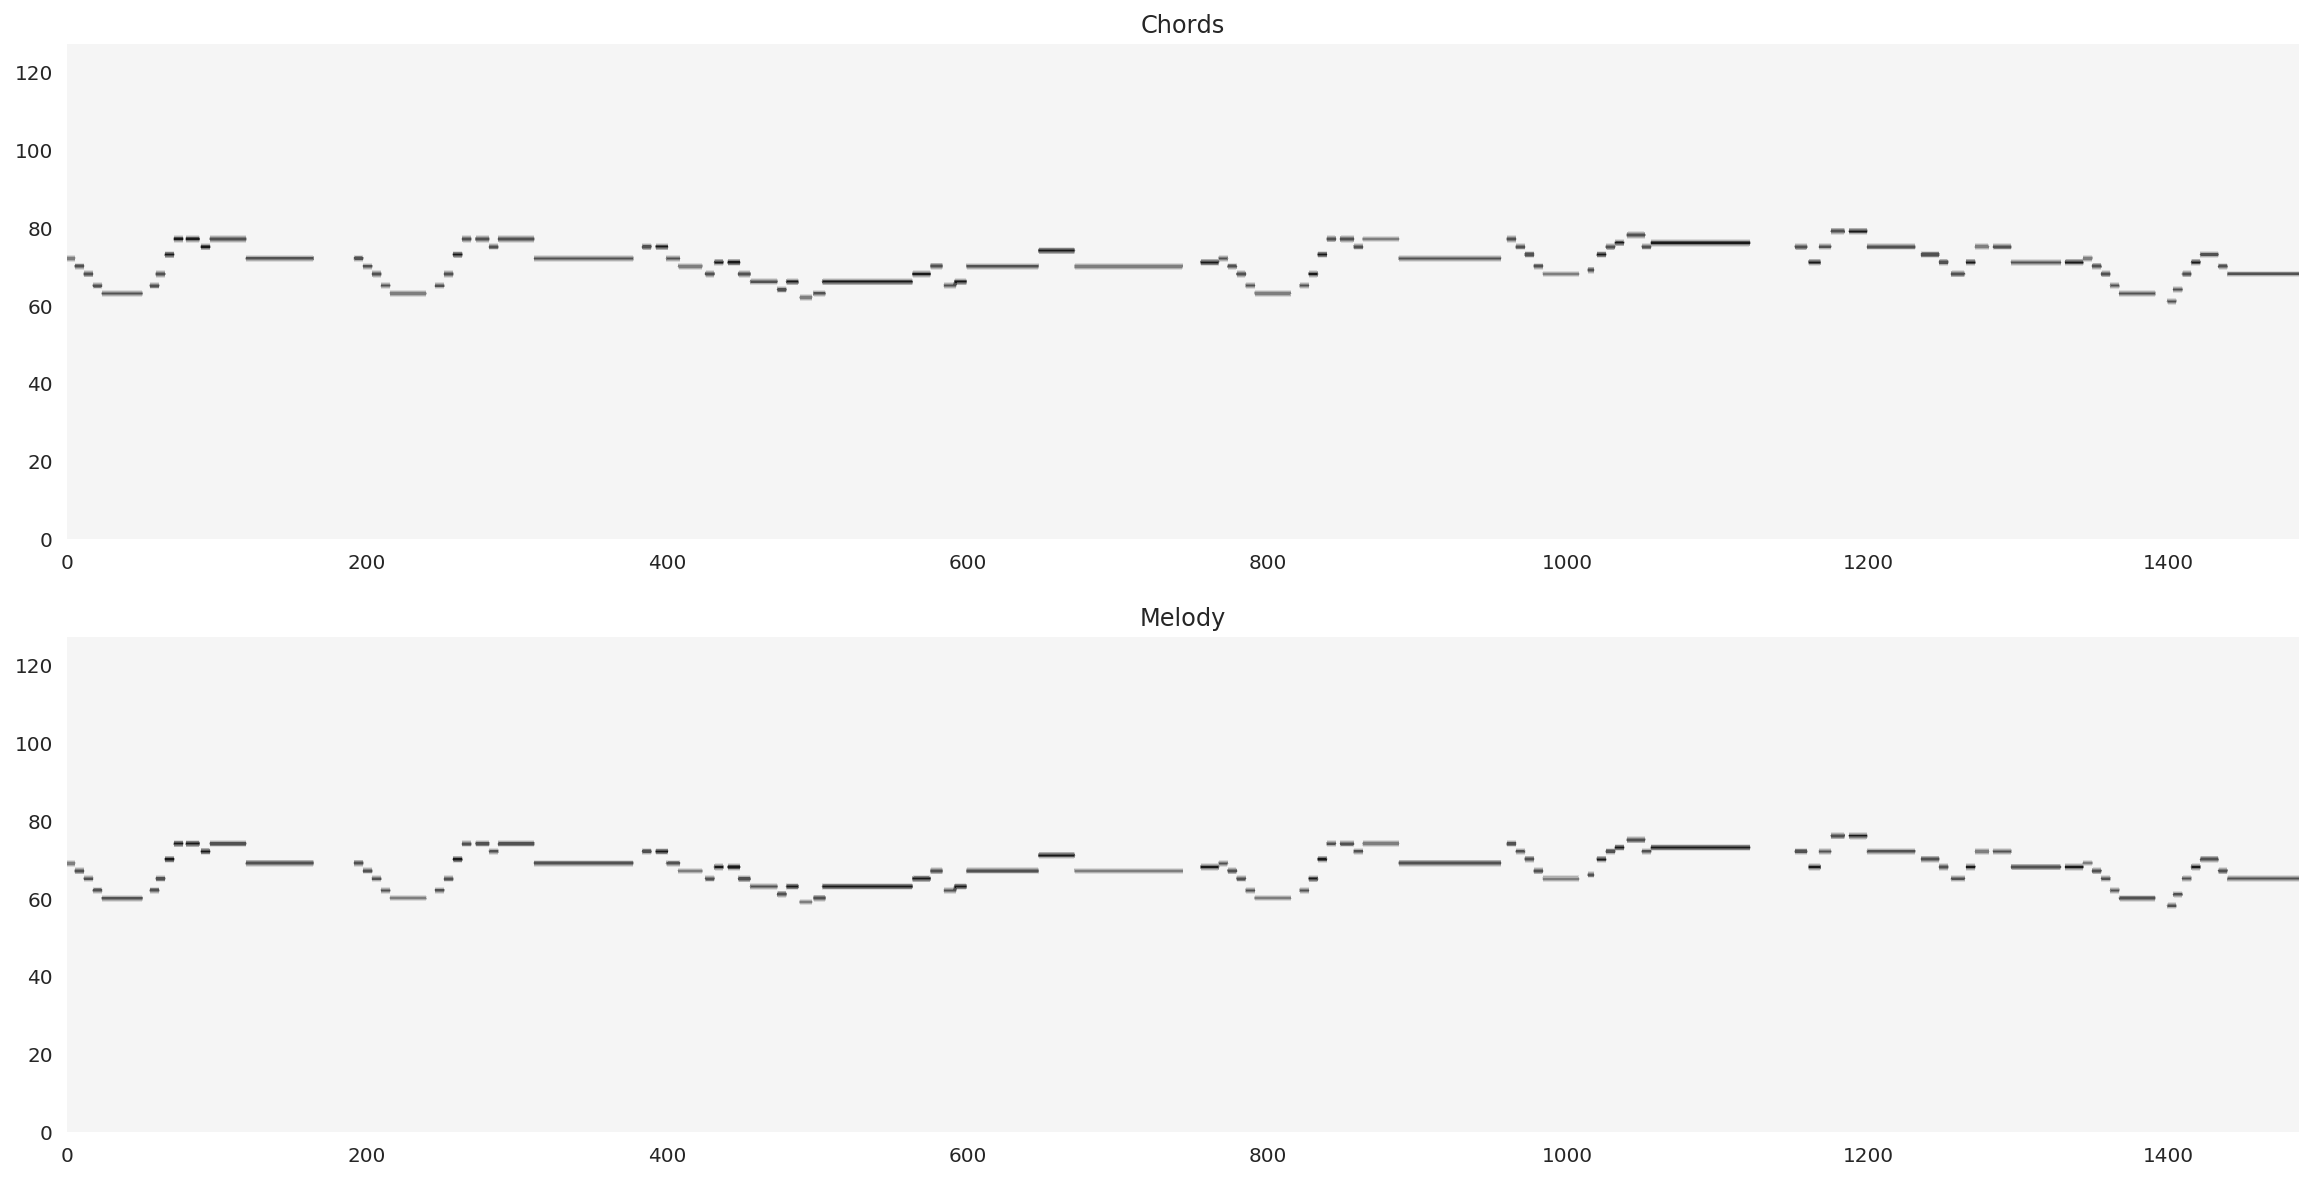

In [70]:
song_name = 'automnminnewyork.mid'

# fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(20,20))
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20,10))
# plt.sca(ax[0])
# plt.contourf(song_areas[song_name]['Bass_Grid'])
# plt.title('Bass')
plt.sca(ax[0])
plt.contourf(song_areas[song_name]['Melody_Grid_Shift'])
plt.title('Chords')
# plt.sca(ax[2])
# plt.contourf(song_areas[song_name]['Drums_Grid'])
# plt.title('Drums')
plt.sca(ax[1])
plt.contourf(song_areas[song_name]['Melody_Grid'])
plt.title('Melody')

In [71]:
titles

['Iremclif.mid',
 'OnedayMyprince.mid',
 'thismasquerade.mid',
 'theverythoughtofyou.mid',
 'AprilInParis.mid',
 'maidenvoyage.mid',
 'cantaloup-isl.mid',
 'Aquarela.mid',
 'ppanther.mid',
 'Gentrain.mid',
 'vivosonhando.mid',
 'copabana.mid',
 'killerjoe.mid',
 'automnminnewyork.mid',
 'mustang_sally_rhino.mid',
 'Justjazz.mid',
 'SaltPeanuts.mid',
 'touchofyourlips.mid',
 'foggyday01.mid',
 'ipanema.mid',
 'greenonions.mid',
 'flymetothemoon.mid',
 'resolution.mid',
 'fever.mid',
 'HadtobeU.mid',
 'igotyouundermyskin.mid',
 'Desafinad.mid',
 'Onenote.mid',
 'thestripper.mid',
 'Igetakik.mid',
 'howhightthemoon.mid']

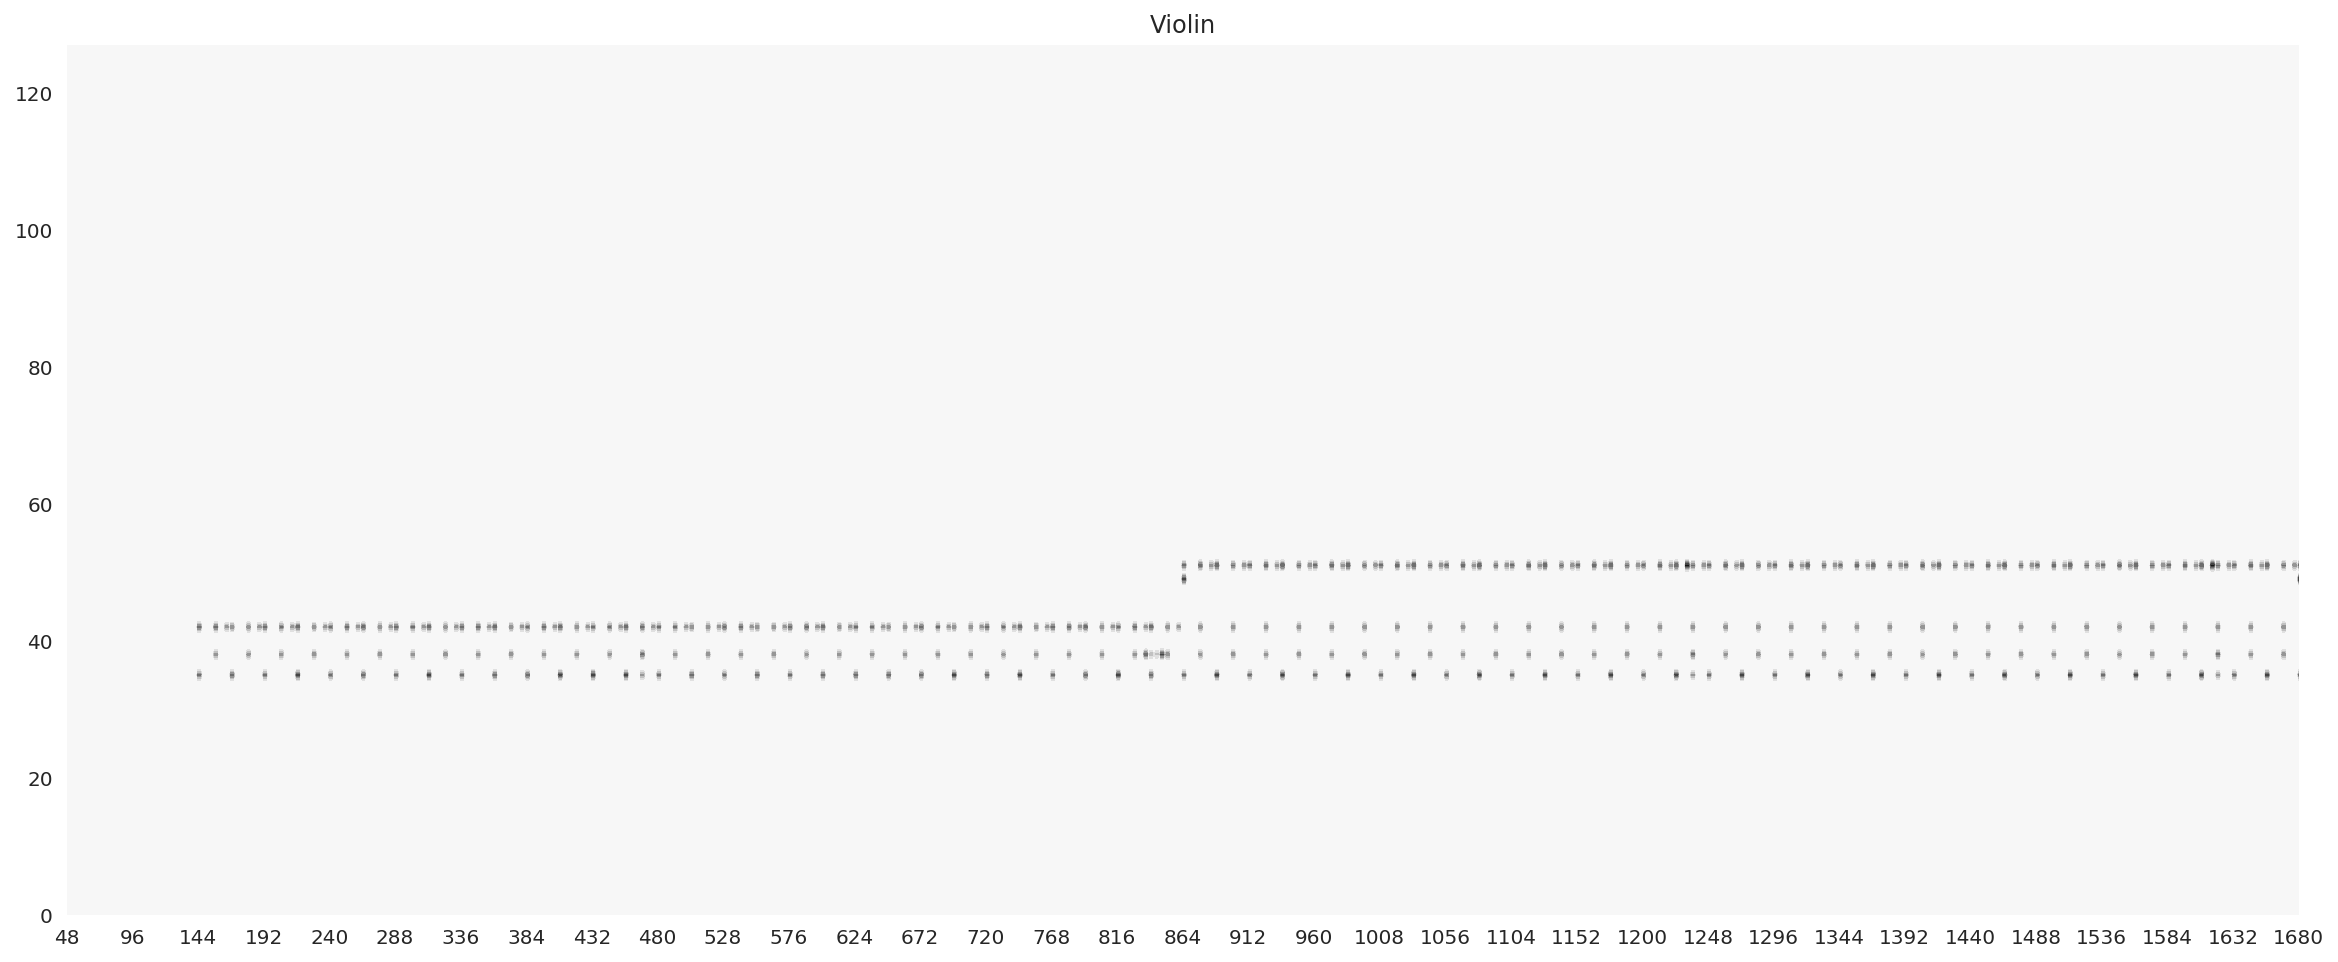

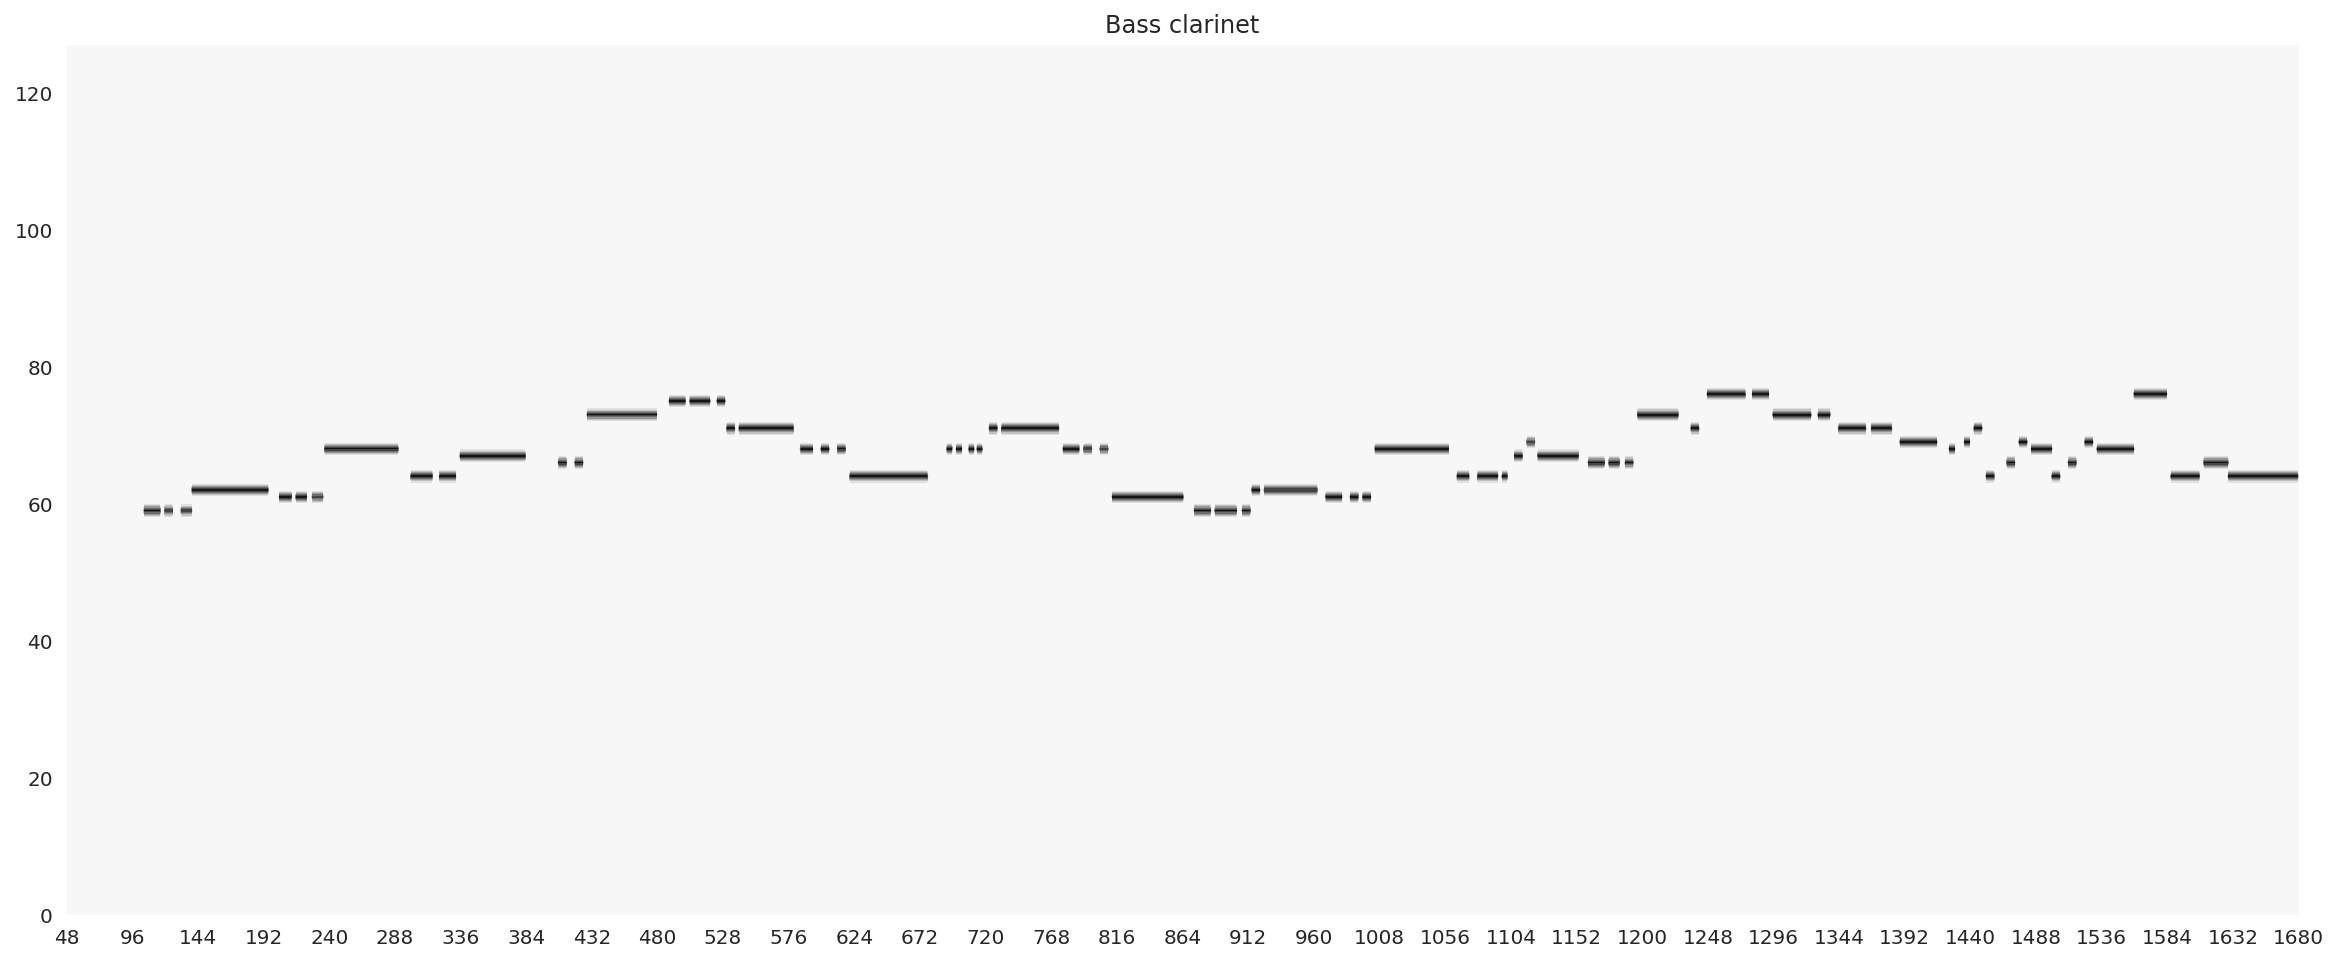

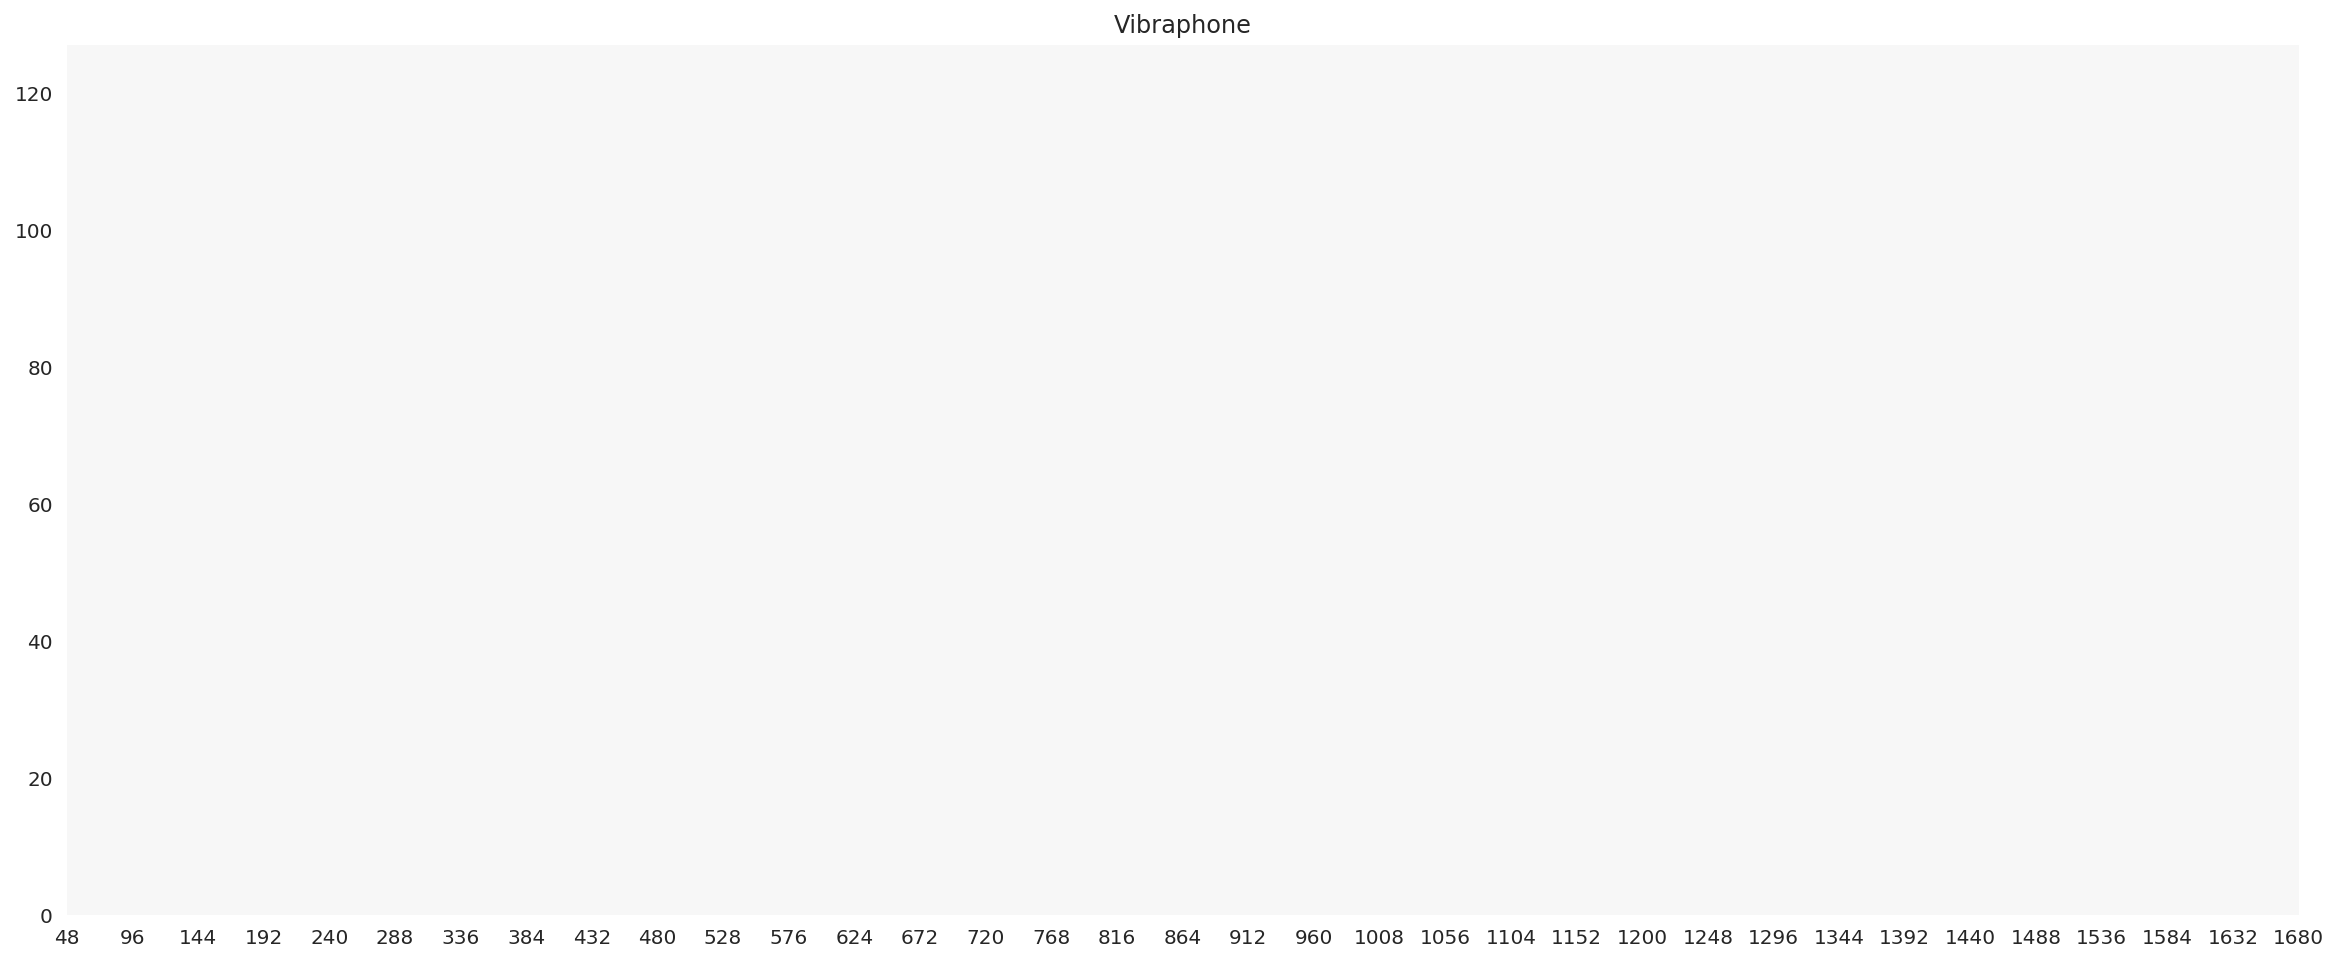

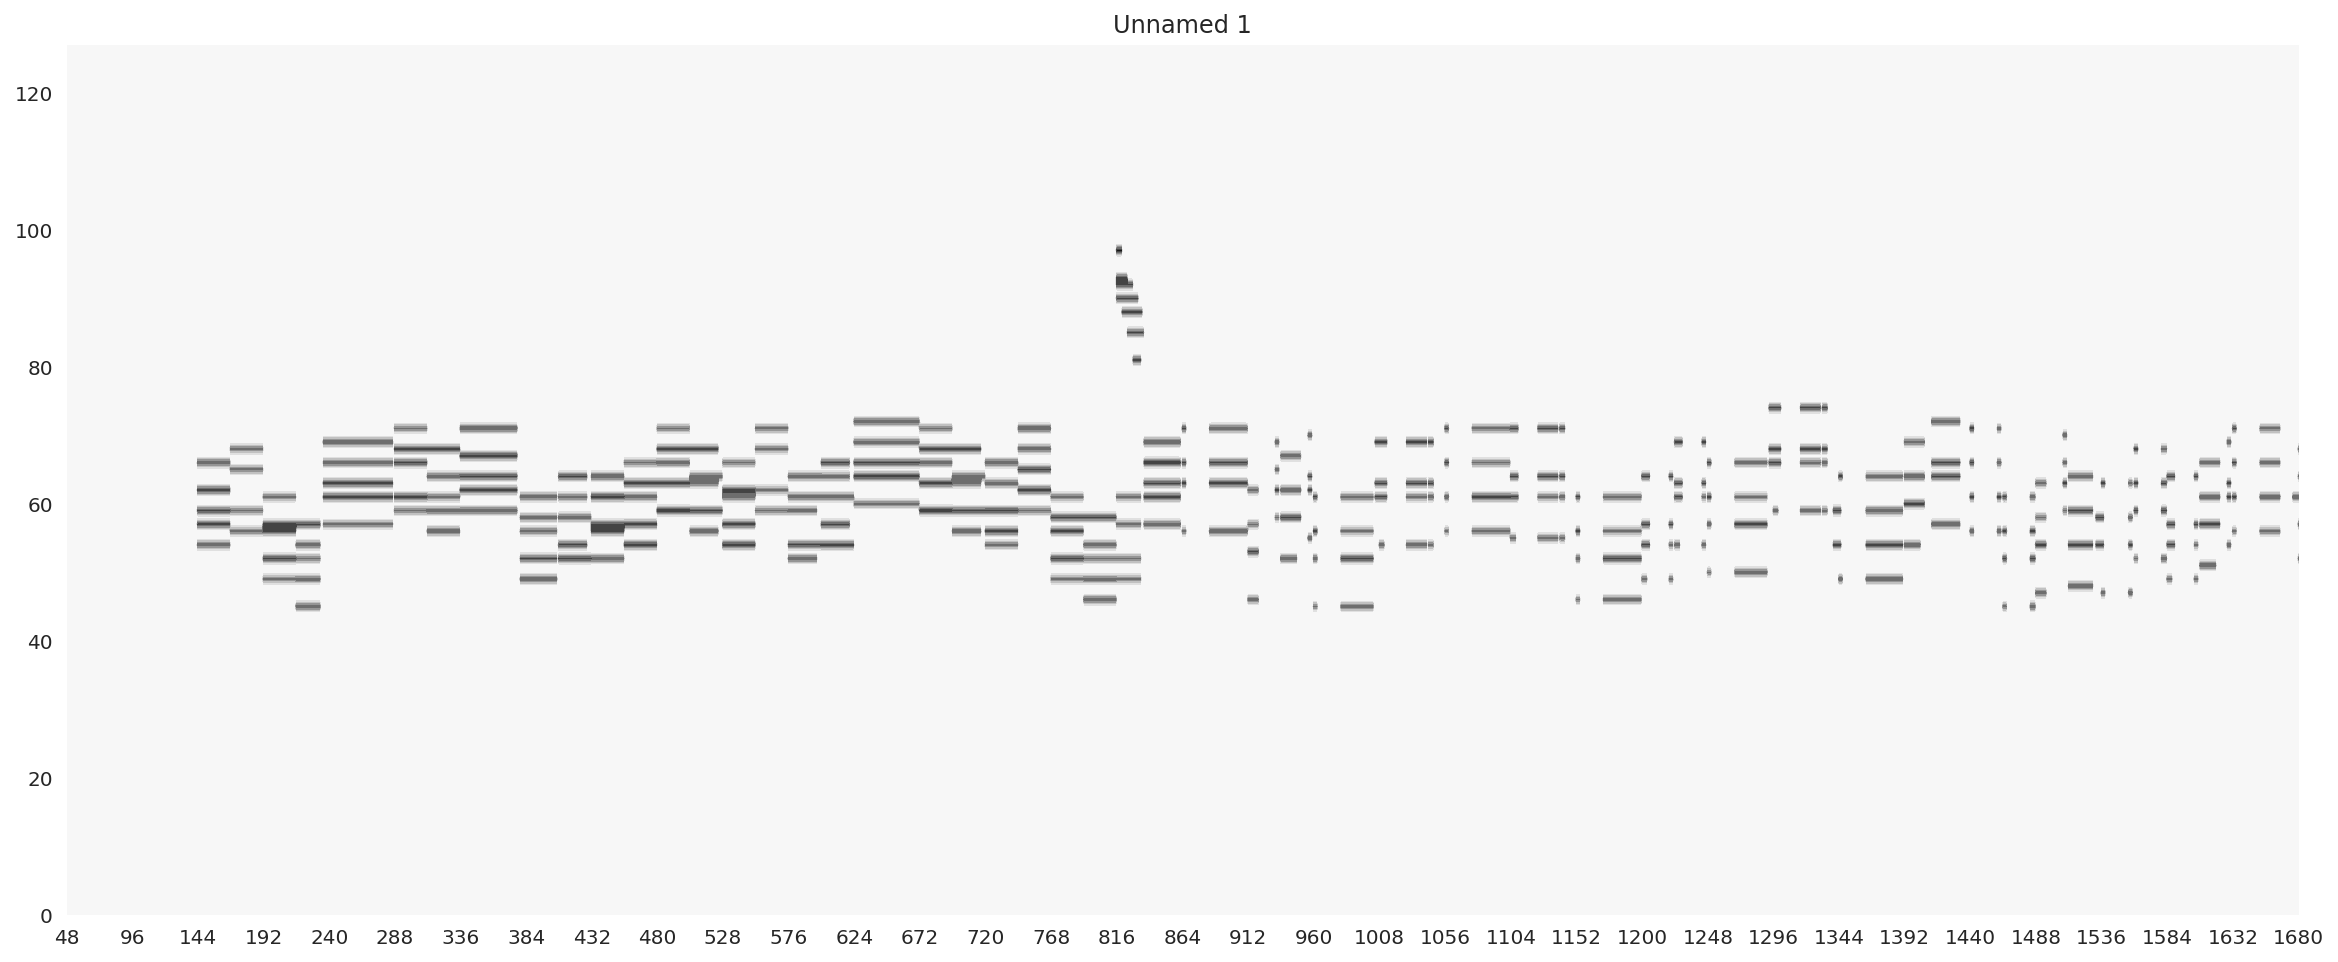

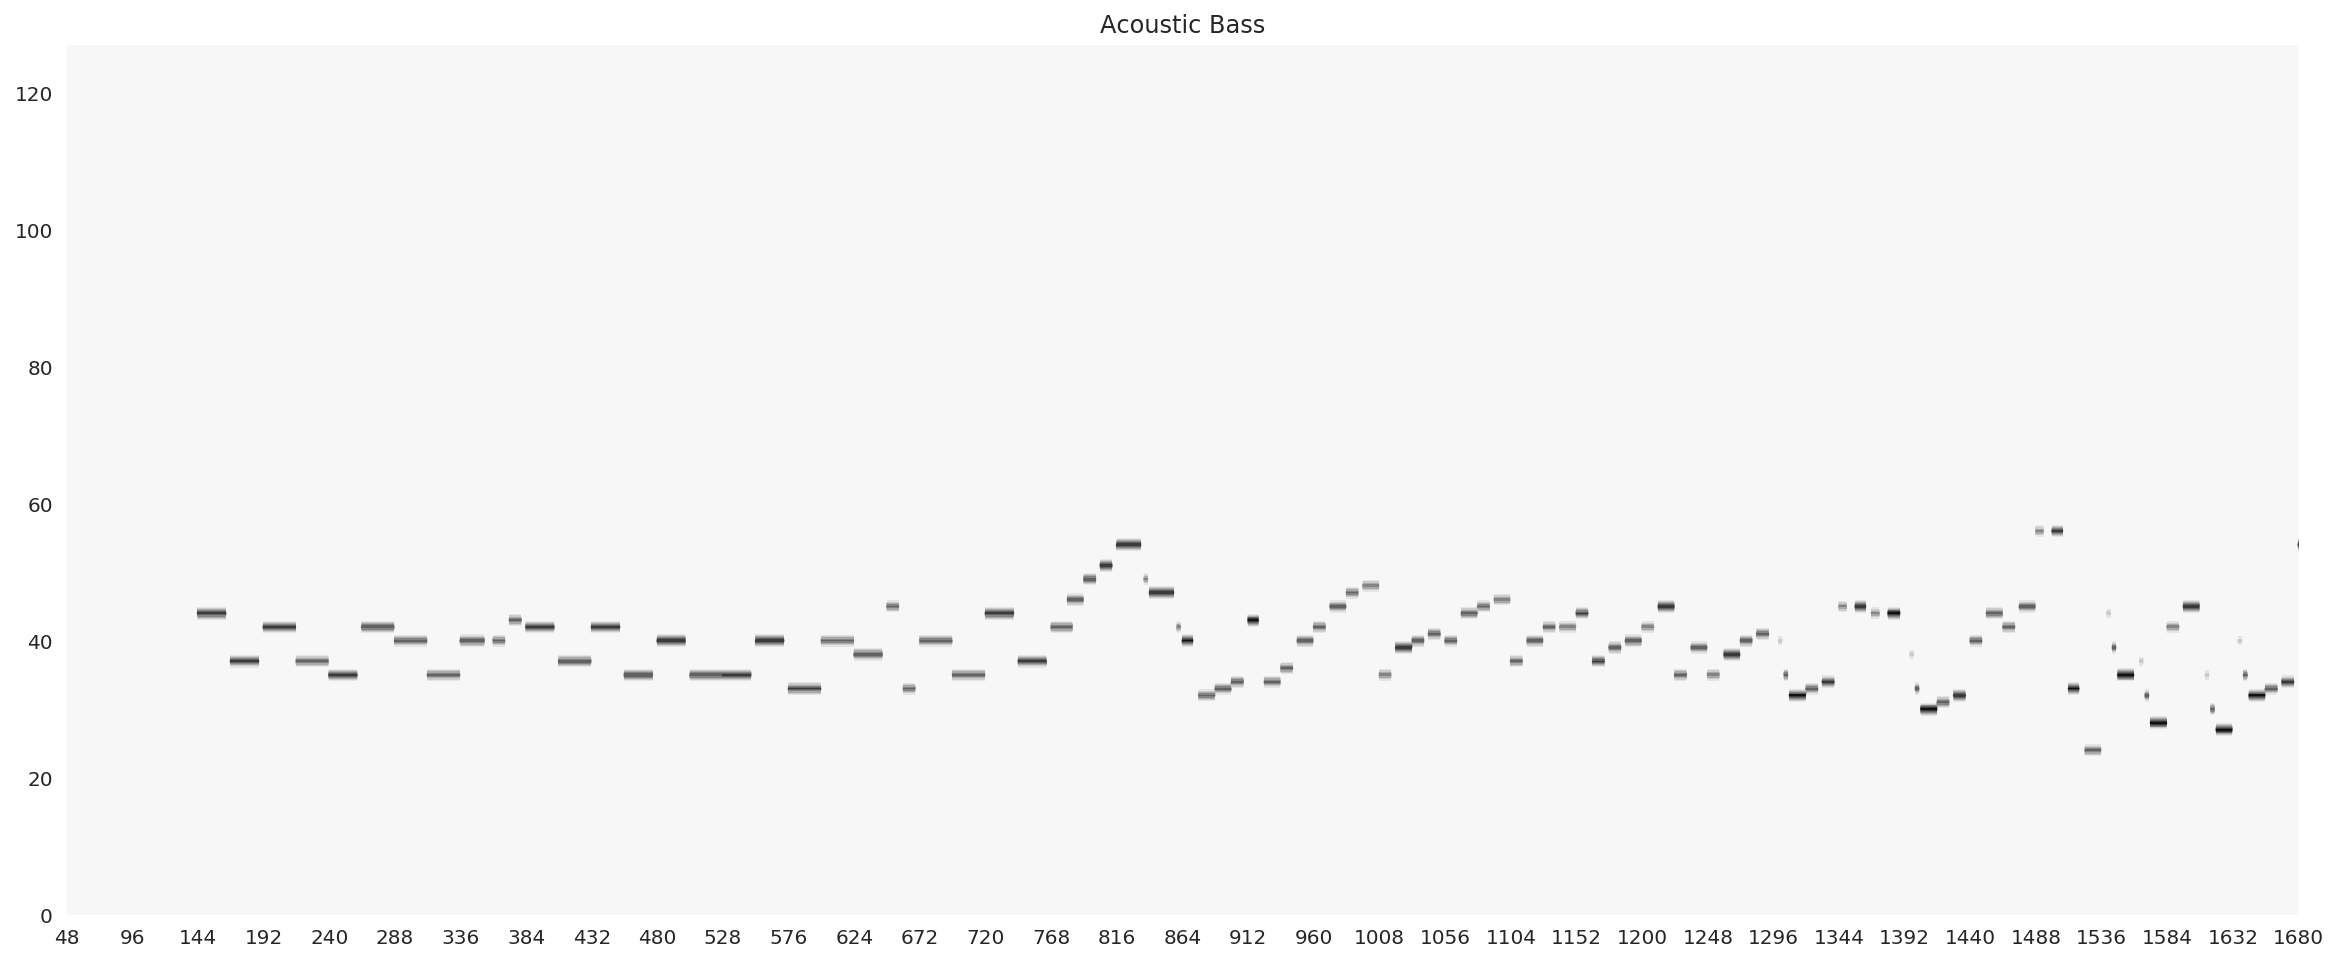

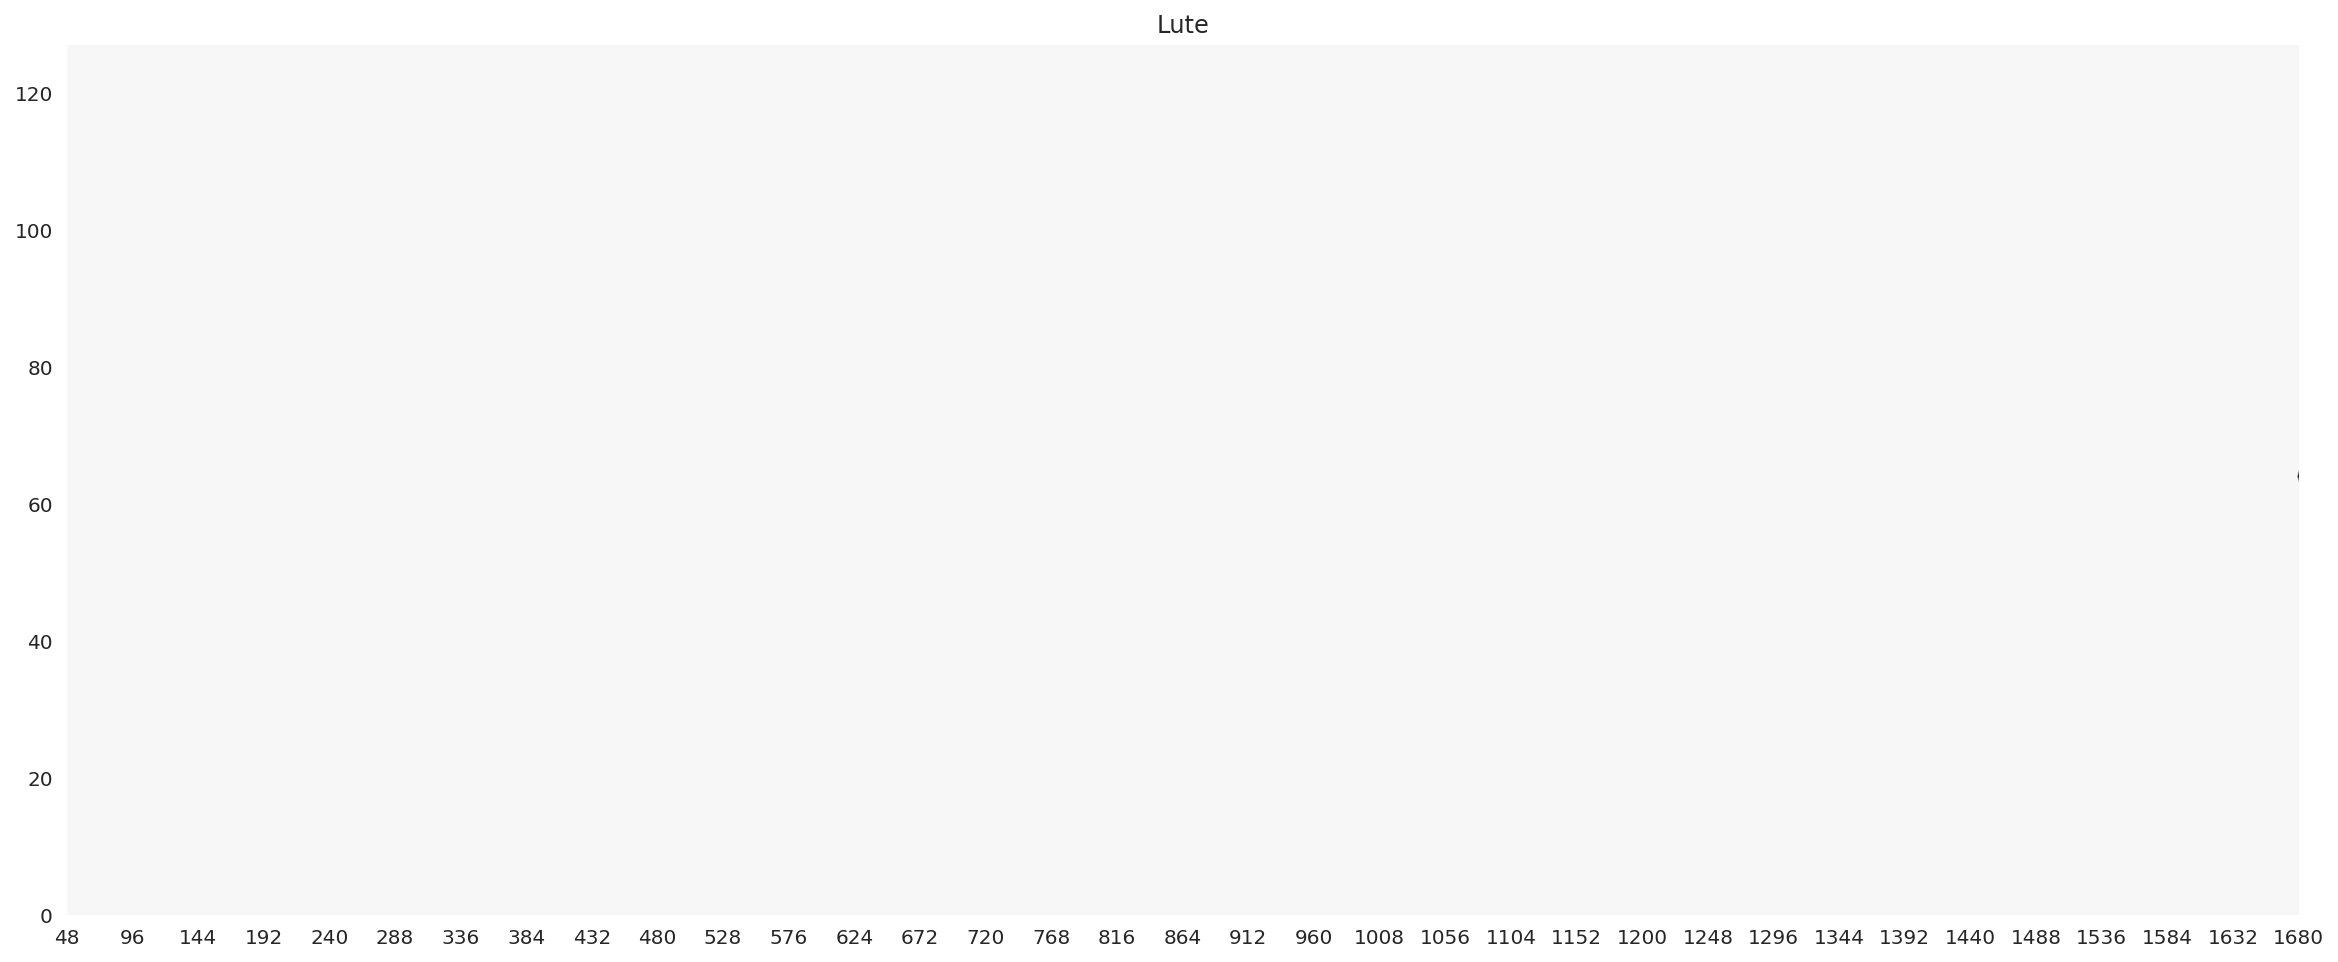

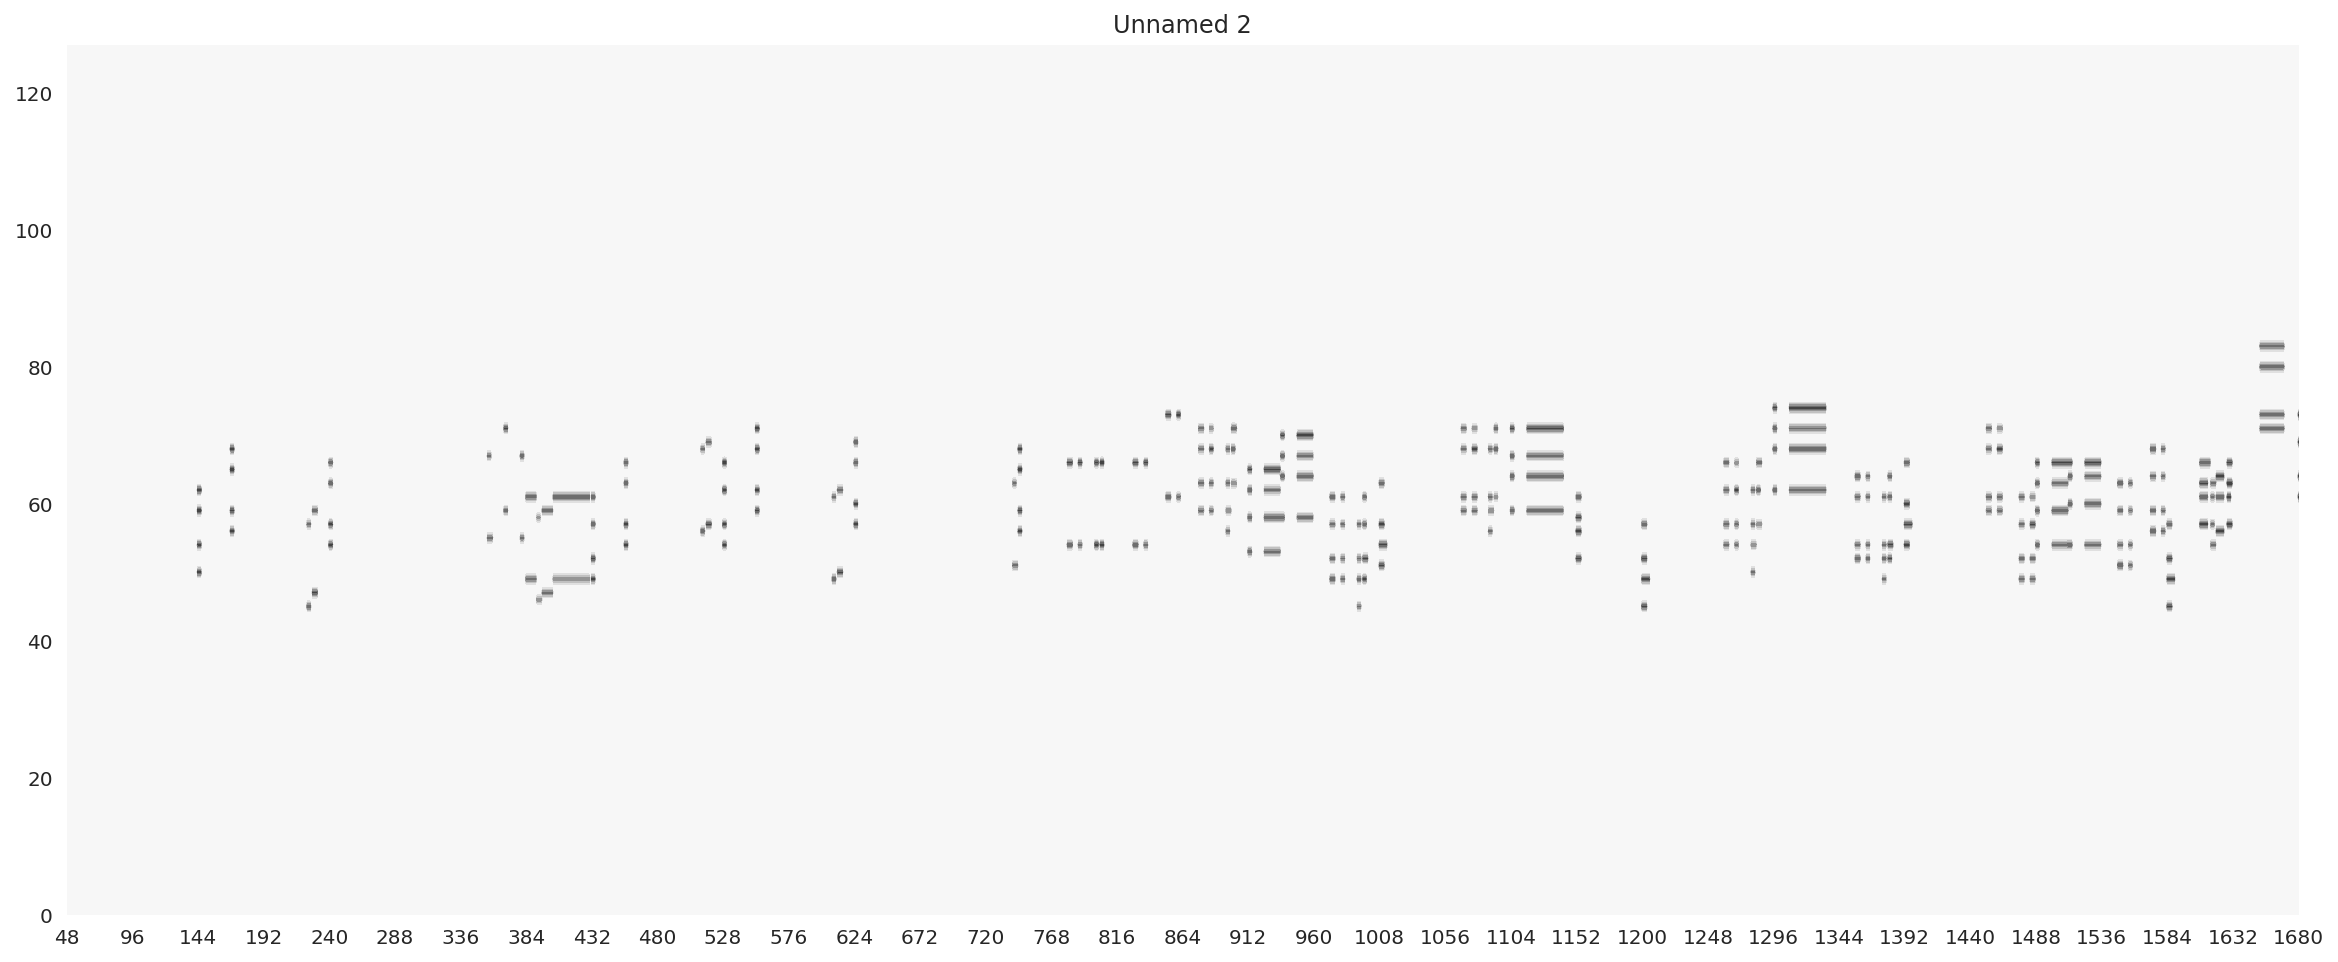

In [22]:
for track, grid in use_songs[18]['instruments'].items():
    plt.figure(figsize=(20,8))
    plt.contourf(grid)
    plt.title(track)
    plt.grid(color='k', axis='x', alpha=0.4)
    plt.xticks(np.arange(0, len(grid[0]), 48));
    plt.xlim(1*48, 35*48)
    # plt.imshow(track_grids['Guitar'], cmap='hot', interpolation='nearest')
    plt.show()

In [18]:
grid

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [11]:
my_midi

<music21.stream.Score 0x7f4b80974080>

In [2]:
f = FloatProgress(min=0, max=1)
display(f)
file_dir = 'midi_files/'
files = os.listdir(file_dir)
try:
    with open('song_grids.pkl', 'rb') as pkl:
        all_grids = pickle.load(pkl)
except:
    all_grids = {}
for i, fn in enumerate(files):
    f.value = i/len(files)
    time.sleep(1)
    if fn.lower().replace('.mid', '') in all_grids.keys():
        print(fn + " already in 'all_grids' dictionary")
        continue
    if fn.lower().endswith('.mid'):
        print('On "' + fn + '"')
        print('Working on it...')
        print('\tLoading MIDI')
        my_midi = KJPM.load_midi(file_dir+fn)
        print('\tCreating Track Grids')
        cur_grid = KJPM.get_track_grids(my_midi)
        all_grids[fn.lower().replace('.mid', '')] = cur_grid
        print('Done!')
        print('-----')
        with open('song_grids.pkl', 'wb') as pkl:
            pickle.dump(all_grids, pkl)

FloatProgress(value=0.0, max=1.0)

502blues.mid already in 'all_grids' dictionary
AFelicidade.mid already in 'all_grids' dictionary
afroBlues.mid already in 'all_grids' dictionary
AintMisbehavin.mid already in 'all_grids' dictionary
airegin.mid already in 'all_grids' dictionary
On "ALICE_IN_Wonderland.MID"
Working on it...
	Loading MIDI


KeyboardInterrupt: 

In [5]:
all_grids

{}

In [97]:
all_grids['502blues'].keys()

dict_keys(['Acoustic Bass', 'Piano', 'Vibraphone', 'Unnamed 1', 'Guitar', 'Violin'])

(0, 6335)

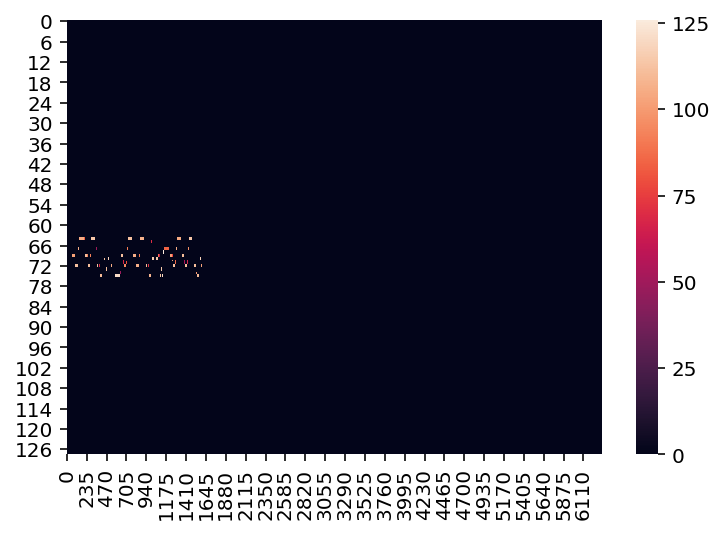

In [98]:
sns.heatmap(all_grids['502blues']['Piano'])
# plt.ylim(20, 60)
plt.xlim(0,max([len(x[0]) for x in all_grids['502blues'].values()]))

In [33]:
# From https://stackoverflow.com/questions/40992288/music21-parsing-notes-and-durations-per-track
piece = converter.parse("midi_files/automnminnewyork.mid")
print('Piece Loaded...')
all_parts = []
for part in piece.parts:
    print(part)
    part_tuples = []
    for event in part:
        for y in event.contextSites():
              if y[0] is part:
                offset = y[1]
        if getattr(event, 'isNote', None) and event.isNote:
            part_tuples.append((event.nameWithOctave, float(event.quarterLength), float(offset)))
        if getattr(event, 'isChord', None) and event.isChord:
            for e in event:
                part_tuples.append((e.nameWithOctave, float(e.quarterLength), float(offset)))
#         if getattr(event, 'isRest', None) and event.isRest:
#             part_tuples.append(('Rest', event.quarterLength, offset))
    all_parts.append(part_tuples)

Piece Loaded...
<music21.stream.Part 0x11507cc50>
<music21.stream.Part 0x114f3a668>
<music21.stream.Part 0x1167201d0>
<music21.stream.Part 0x115452860>
<music21.stream.Part 0x115296908>
<music21.stream.Part 0x1152064e0>
<music21.stream.Part 0x115a1c048>
<music21.stream.Part 0x116160f28>


notes = []
notes_to_parse = None
parts = instrument.partitionByInstrument(midi)

if parts: # file has instrument parts
    notes_to_parse = parts.parts[0].recurse()
else: # file has notes in a flat structure
    notes_to_parse = midi.flat.notes

for element in notes_to_parse:
    if isinstance(element, note.Note):
        notes.append(str(element.pitch))
    elif isinstance(element, chord.Chord):
        notes.append('.'.join(str(n) for n in element.normalOrder))

In [17]:
midi.translate.durationToMidi(element.duration, )

3755

In [18]:
float(element.duration.quarterLength)

3.6666666666666665

In [39]:
x = parts[i].measures(1, 50)

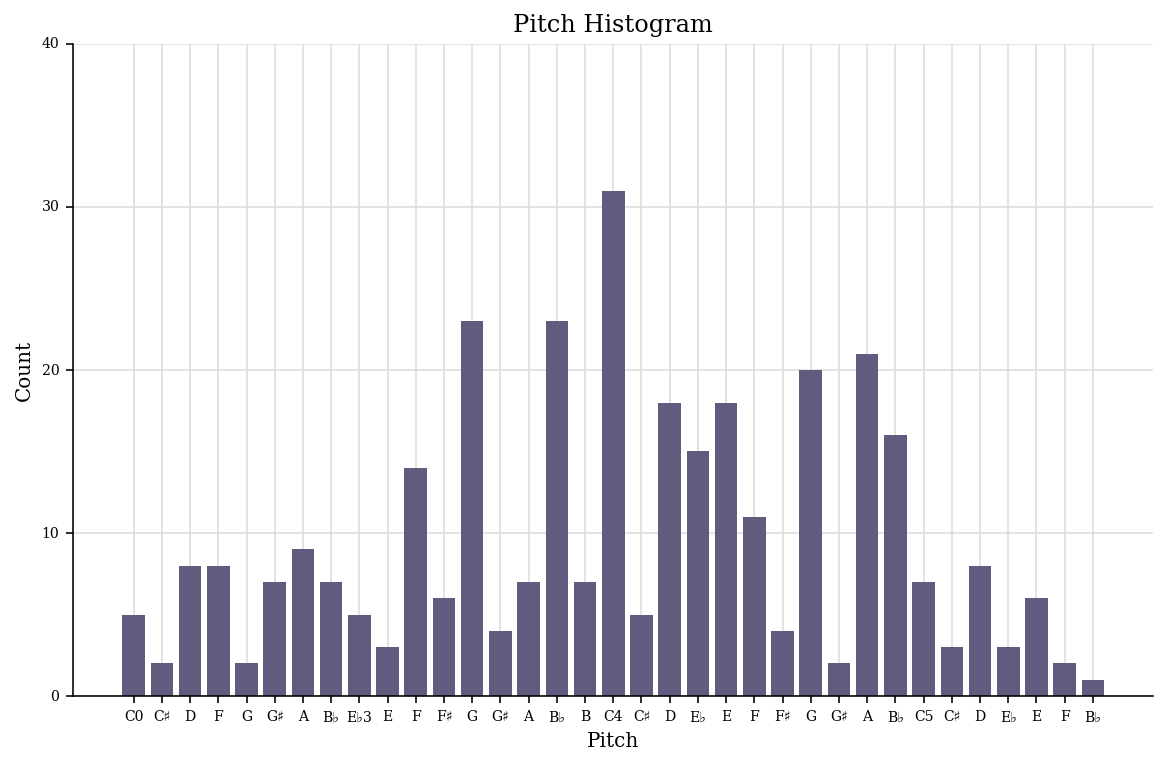

In [51]:
x.plot('histogram', 'pitch')

In [54]:
my_midi.analyze('key')

<music21.key.Key of c minor>

In [13]:
# quarterLength = midi.quarterLength
# for i in range(len(parts)):
my_midi = converter.parse('midi_files/automnminnewyork.mid')

Acoustic Bass
None
Piccolo
Saxophone
Trombone
Guitar
None
None


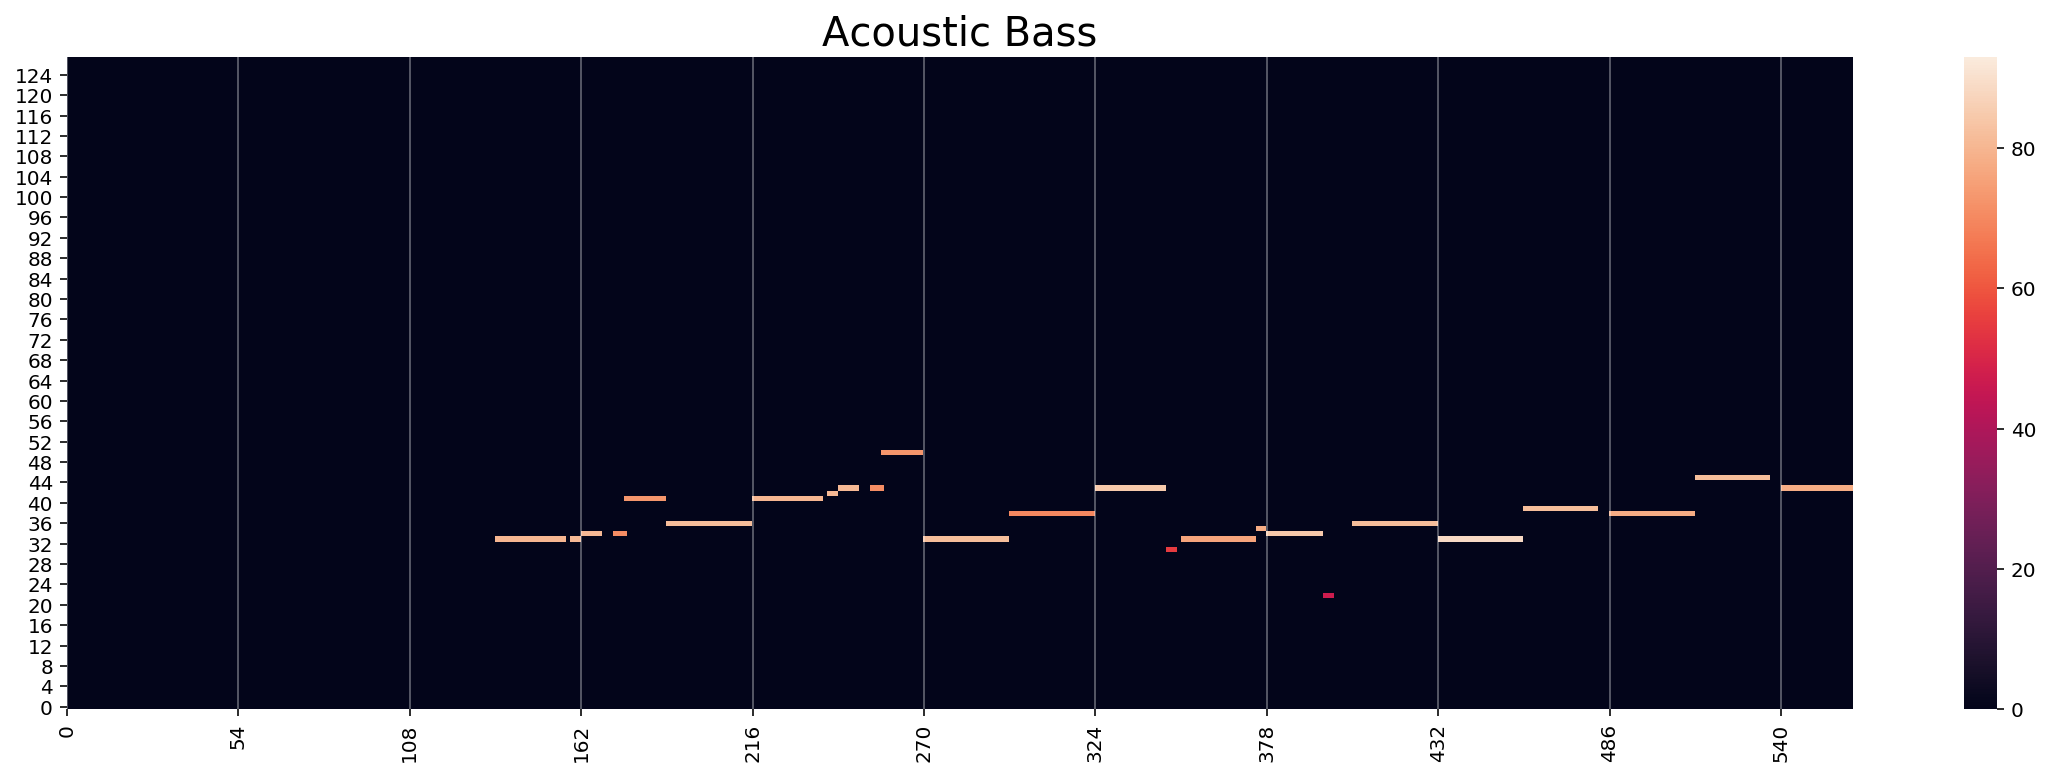

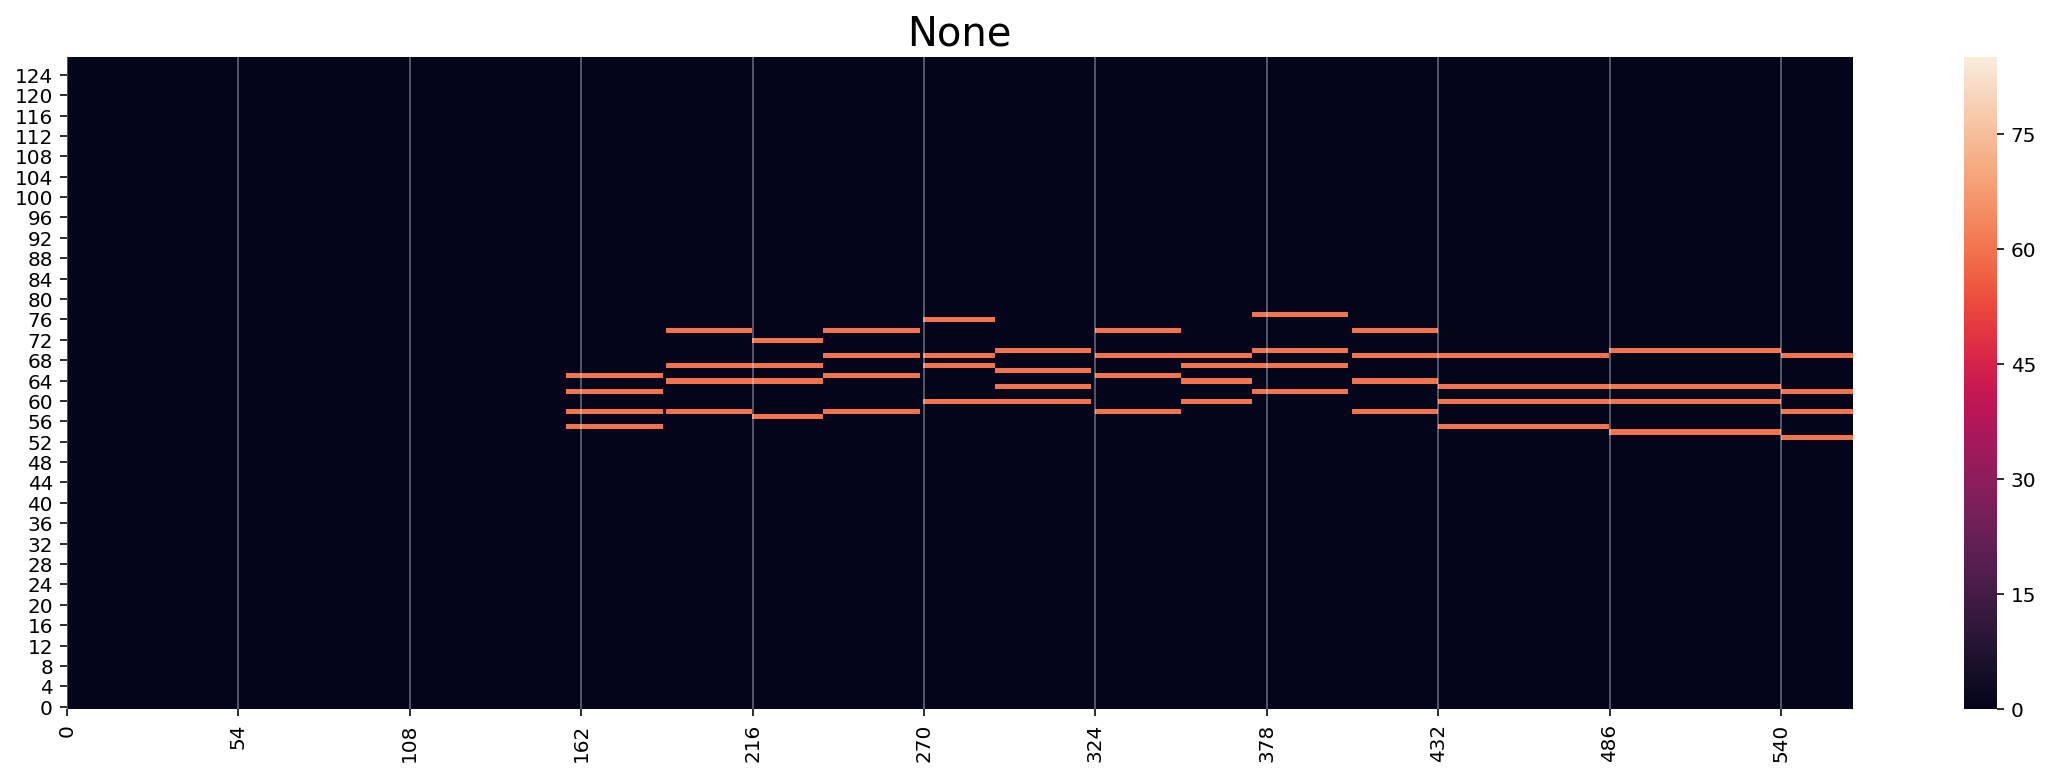

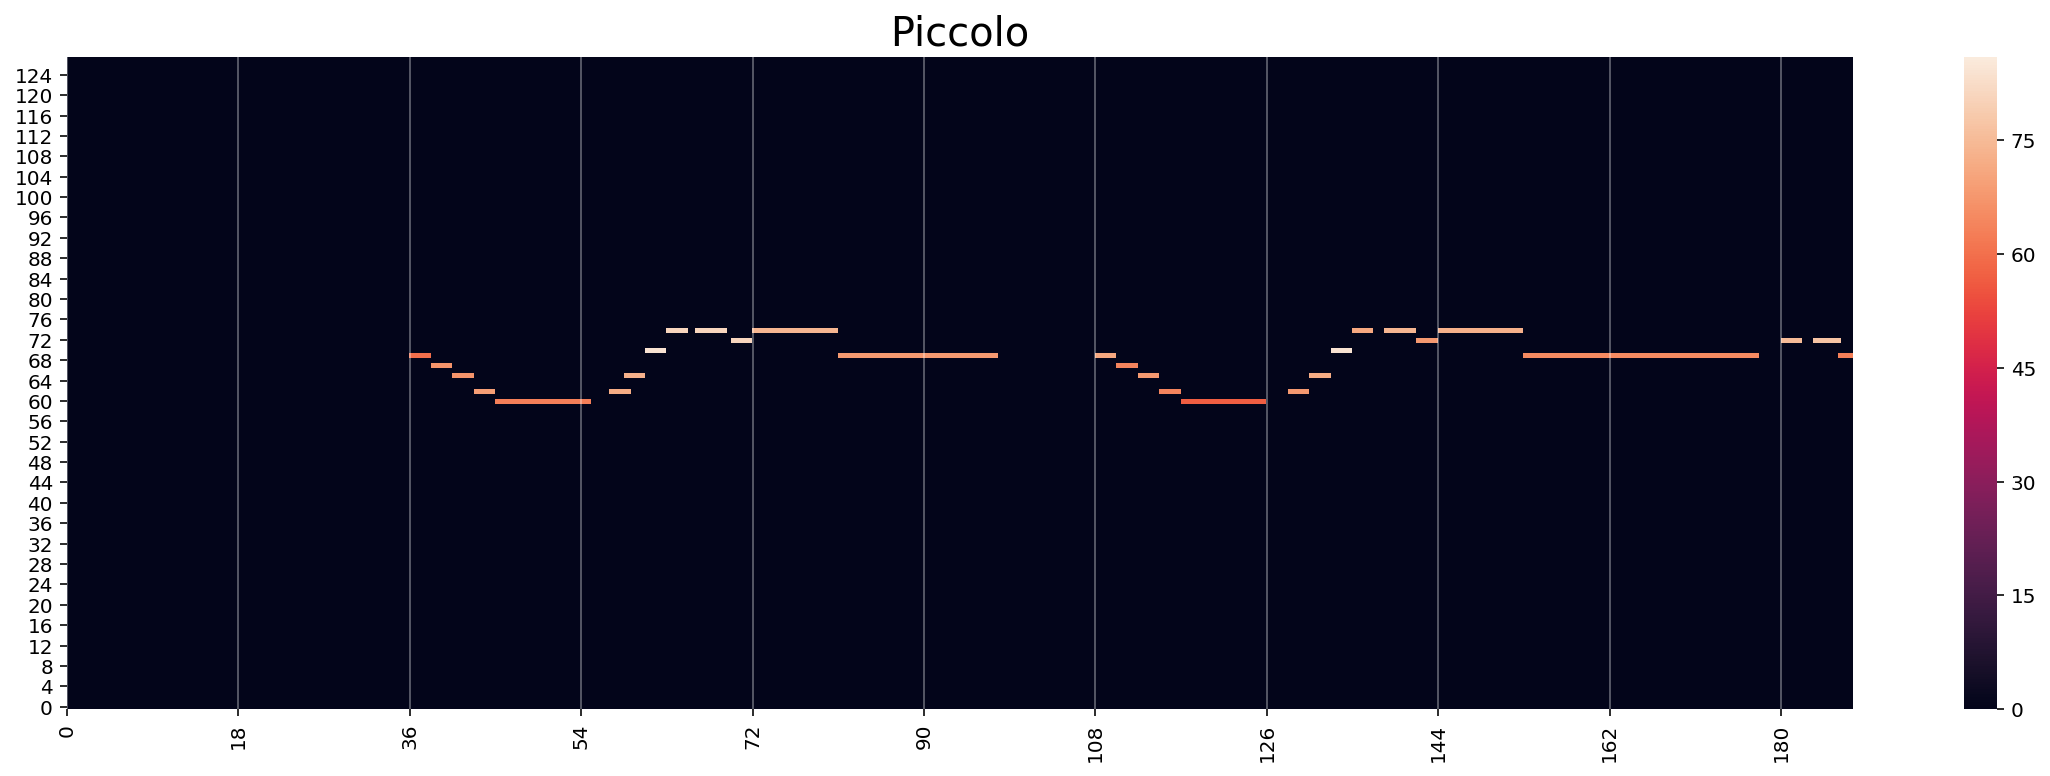

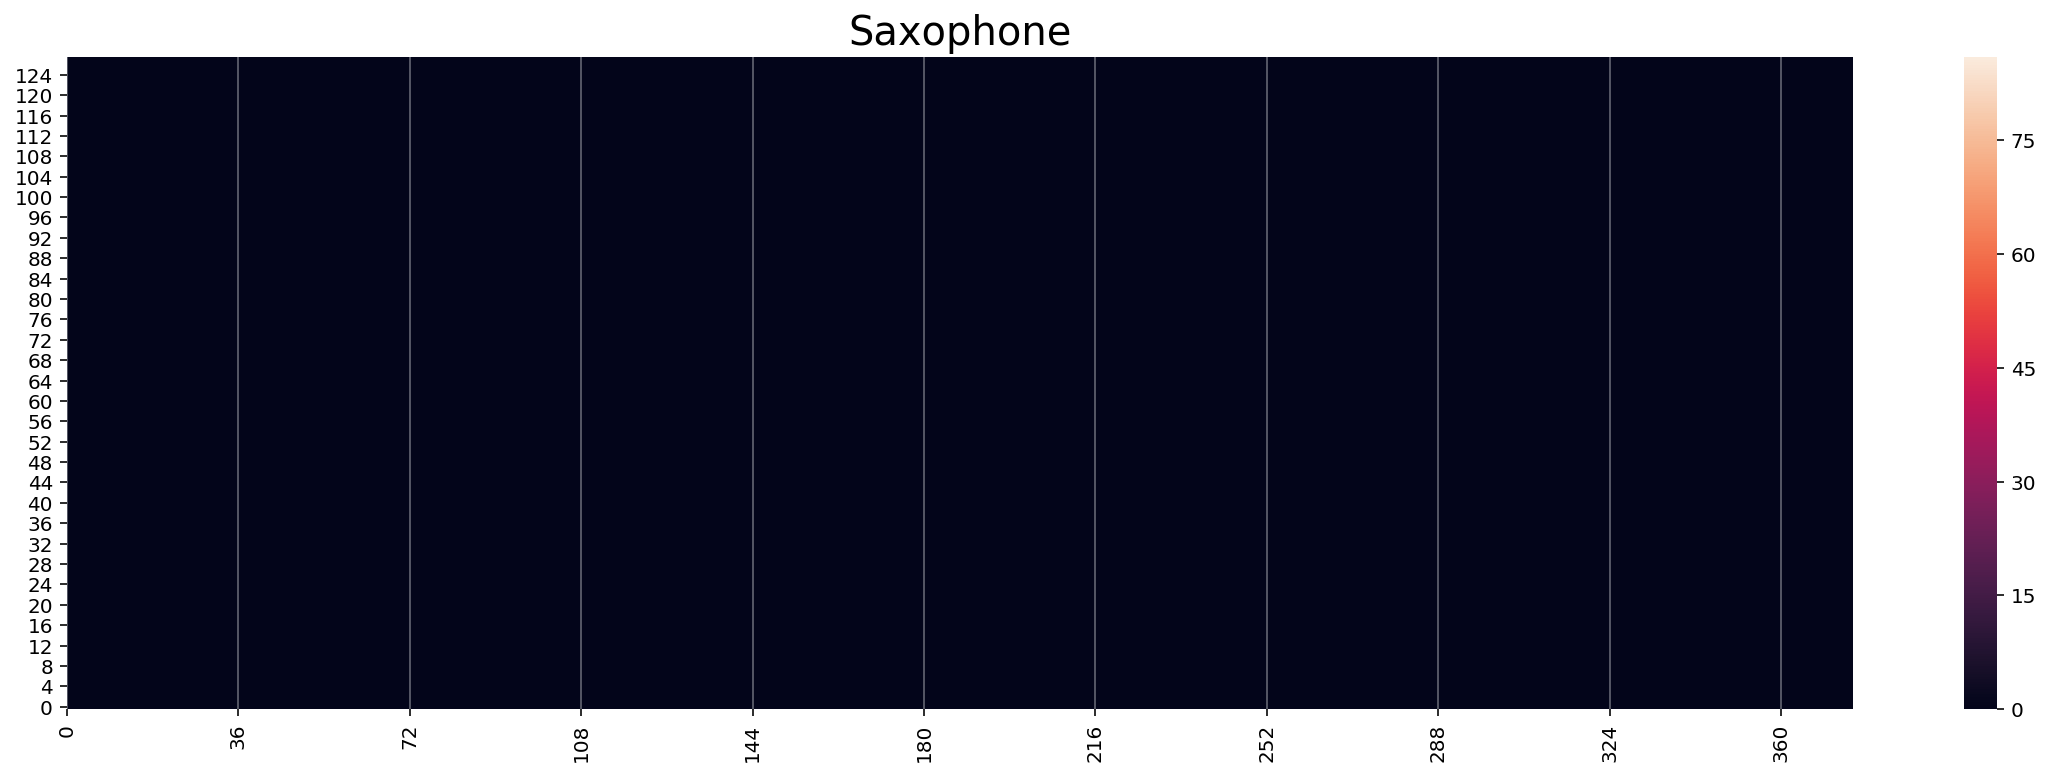

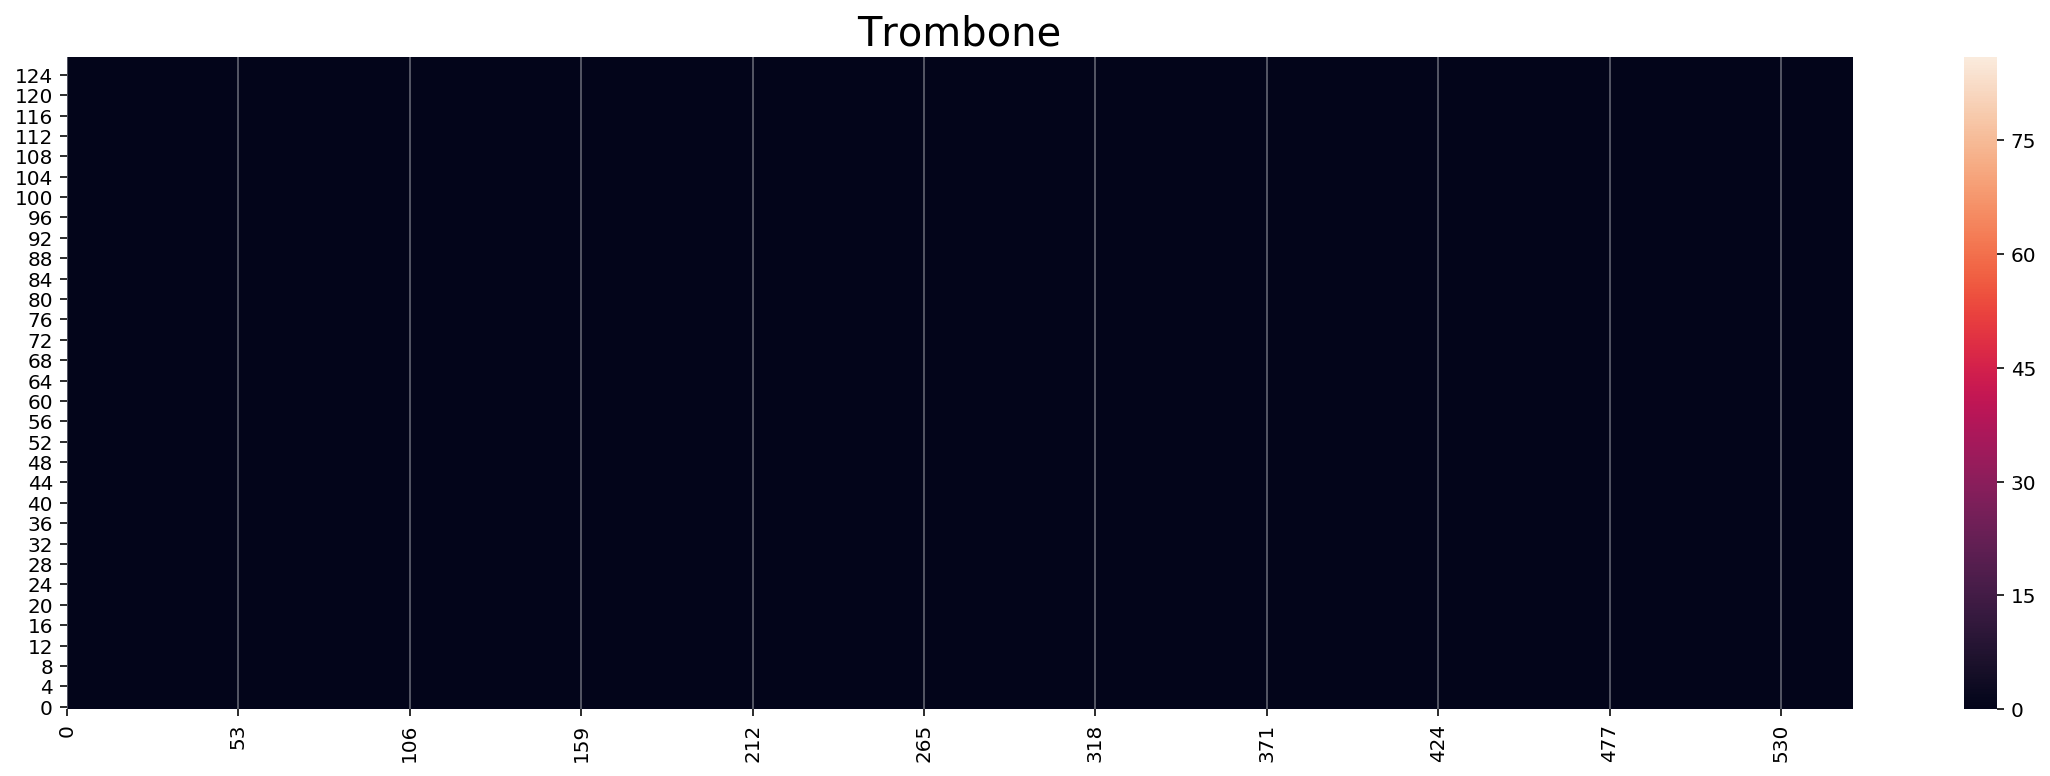

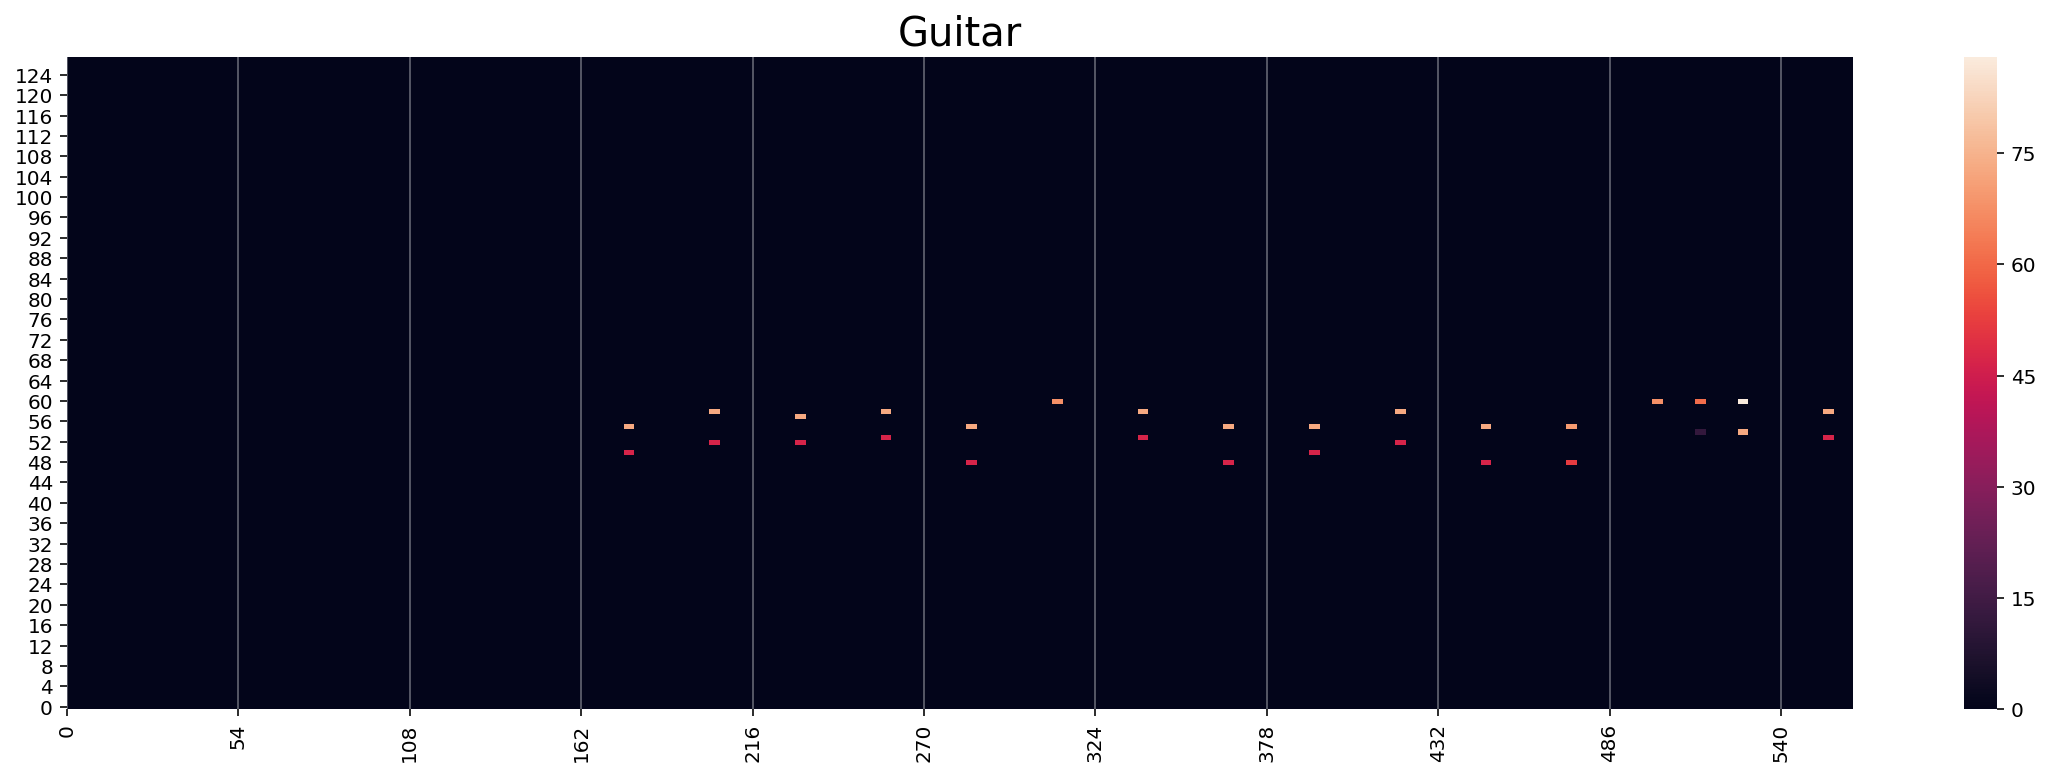

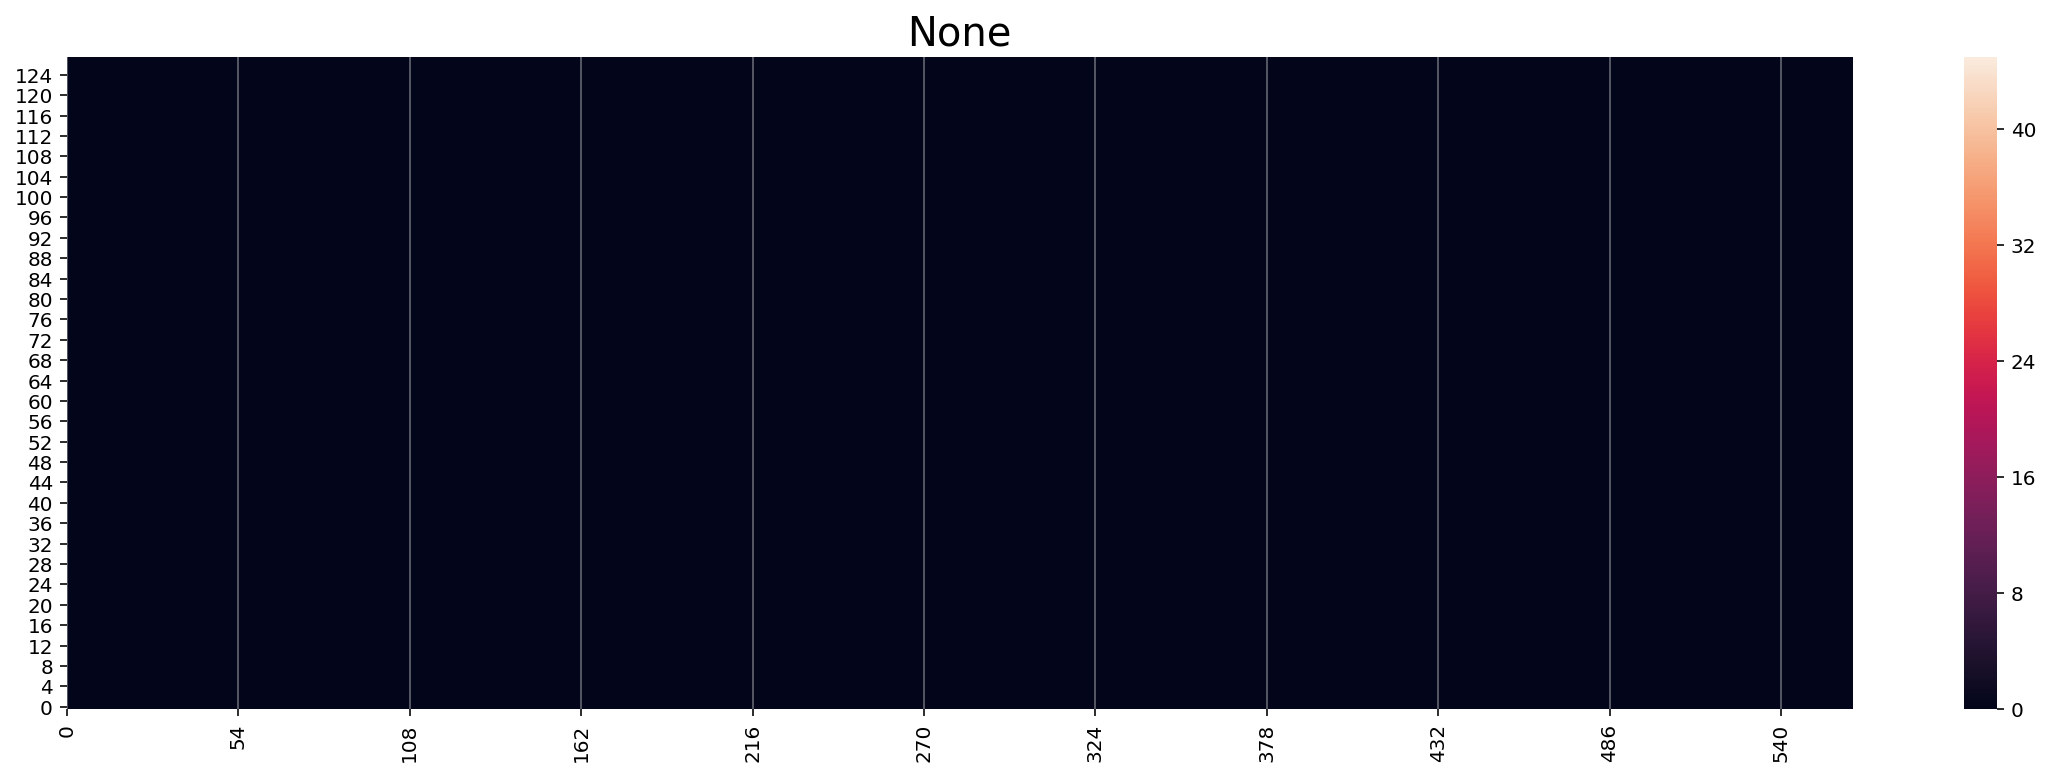

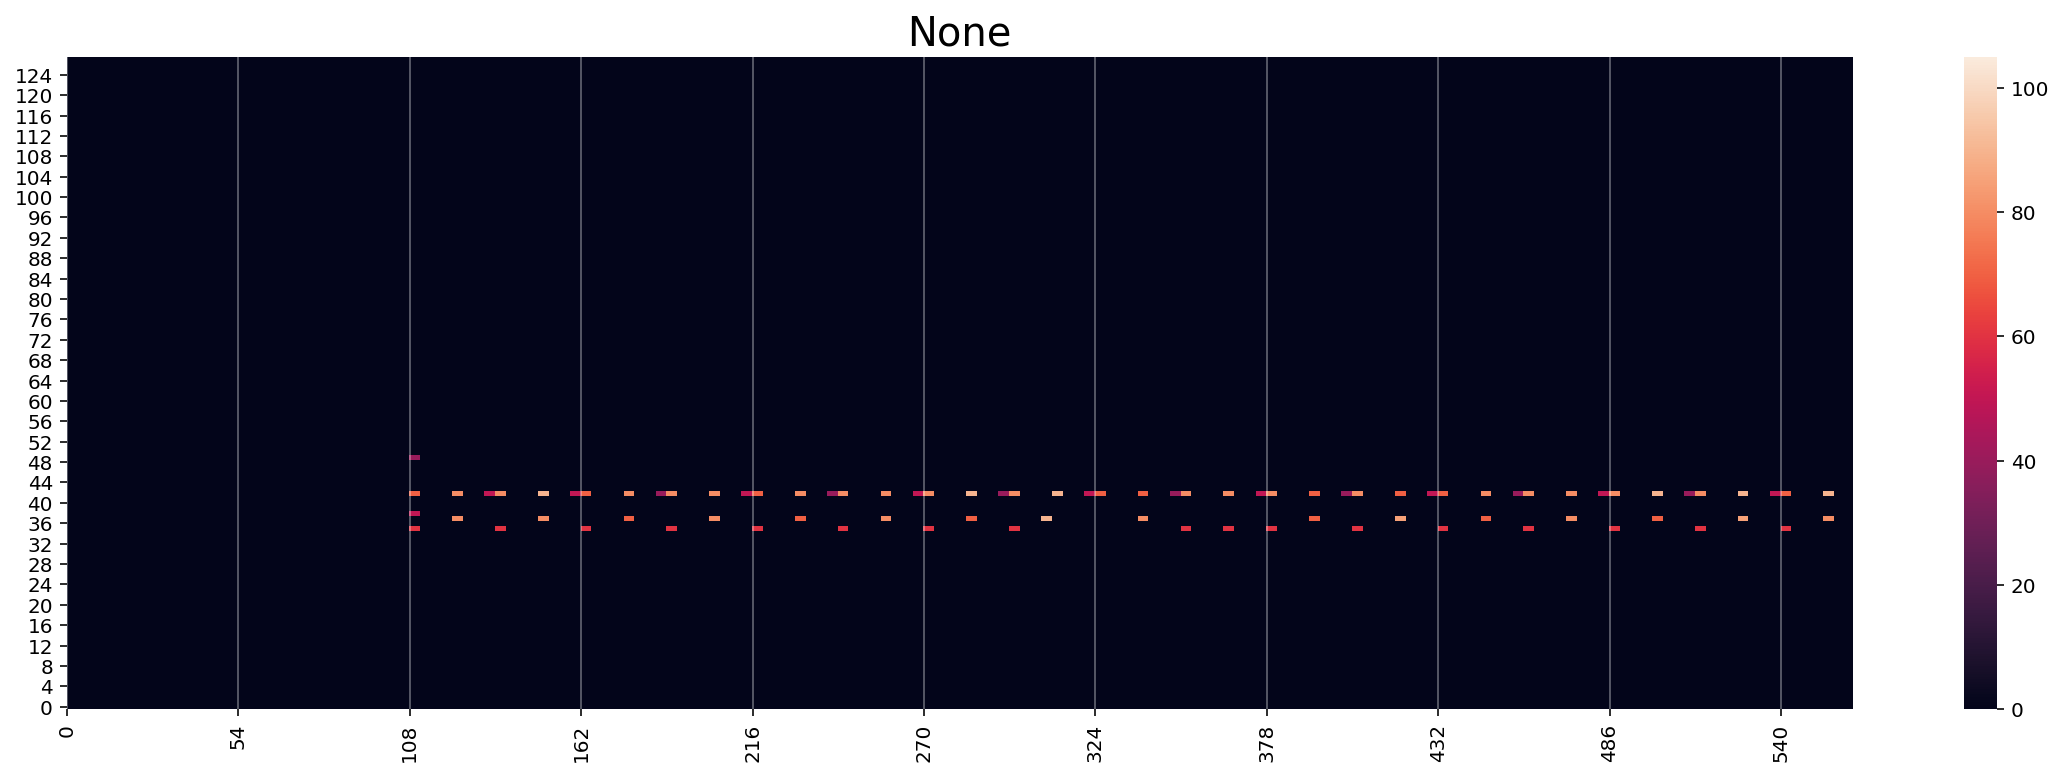

In [14]:
parts = [p for p in my_midi.parts]
for i in range(len(parts)):
    part_name = parts[i].partName
    print(part_name)
    all_notes = []
    for element in parts[i].recurse():
        try:
            if element.isChord:
                all_notes += [[p.pitch.midi, 
                               float(element.offset), 
                               float(element.quarterLength), 
                               p.volume.velocity] for p in element]
            elif element.isNote:
                all_notes.append([element.pitch.midi, 
                                  float(element.offset),
                                  float(element.quarterLength),
                                  element.volume.velocity])
        except:
            continue


    
    note_grid = np.zeros([128, int(max([x[1]*12+x[2]*12 for x in all_notes]))])

    for note in all_notes:
        note_grid[note[0], int(note[1]*12):int(note[1]*12+note[2]*12)] = note[3]
#     note_grid = note_grid[:,::int(my_midi.quarterLength/4)]
    
    plt.figure(figsize=(20,6))
    sns.heatmap(note_grid)
    plt.ylim(0, 128)
    plt.grid(color='w', axis='x', alpha=0.4)
    plt.xticks(np.arange(0, len(note_grid[0]), 48));
    plt.xlim(0, 500)
    plt.title(part_name, fontsize=20)

In [72]:
element.quarterLength

Fraction(11, 3)

In [41]:
all_notes

[[33, 10.0, 1.6666666666666667, 80],
 [33, 11.75, 0.25, 81],
 [34, 12.0, 0.5, 81],
 [34, 12.75, 0.3333333333333333, 71],
 [41, 13.0, 1.0, 73],
 [36, 14.0, 2.0, 82],
 [41, 16.0, 1.6666666666666667, 80],
 [42, 17.75, 0.25, 81],
 [43, 18.0, 0.5, 81],
 [43, 18.75, 0.3333333333333333, 71],
 [50, 19.0, 1.0, 73],
 [33, 20.0, 2.0, 82],
 [38, 22.0, 2.0, 70],
 [43, 24.0, 1.6666666666666667, 85],
 [31, 25.666666666666668, 0.25, 55],
 [33, 26.0, 1.75, 76],
 [35, 27.75, 0.25, 78],
 [34, 28.0, 1.3333333333333333, 85],
 [22, 29.333333333333332, 0.25, 47],
 [34, 29.666666666666668, 0.0, 82],
 [36, 30.0, 2.0, 82],
 [33, 32.0, 2.0, 89],
 [39, 34.0, 1.75, 82],
 [38, 36.0, 2.0, 78],
 [45, 38.0, 1.75, 82],
 [26, 39.75, 0.0, 60],
 [43, 40.0, 2.0, 78],
 [38, 42.0, 1.75, 82],
 [31, 43.75, 0.0, 60],
 [34, 44.0, 1.75, 73],
 [41, 45.75, 0.25, 68],
 [39, 46.0, 2.0, 82],
 [44, 48.0, 2.0, 78],
 [39, 50.0, 1.75, 82],
 [32, 51.75, 0.0, 60],
 [44, 52.0, 2.0, 70],
 [38, 54.0, 1.6666666666666667, 85],
 [26, 55.666666666

In [ ]:
midi_tick_starts = []
midi_tick_ends = []
velocity = []
pitch_freq = []
for element in parts.parts[4].recurse():
    if isinstance(element, note.Note):
        midi_tick_starts.append(float(element.midiTickStart))
        midi_tick_ends.append(float(element.midiTickStart) + float(element.duration.quarterLength)*960)
        velocity.append(element.volume.velocity)
        pitch_freq.append(element.pitch.freq440)

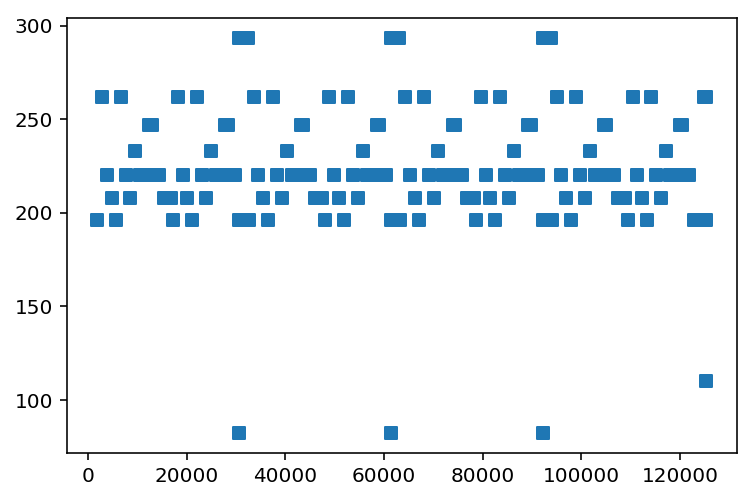

In [59]:
plt.scatter(midi_tick_starts, pitch_freq, marker='s')

In [61]:
p = parts.parts[4]

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

from ipywidgets import FloatProgress
from IPython.display import display

FloatProgress(value=0.0, max=167.0)

(15000, 25000)

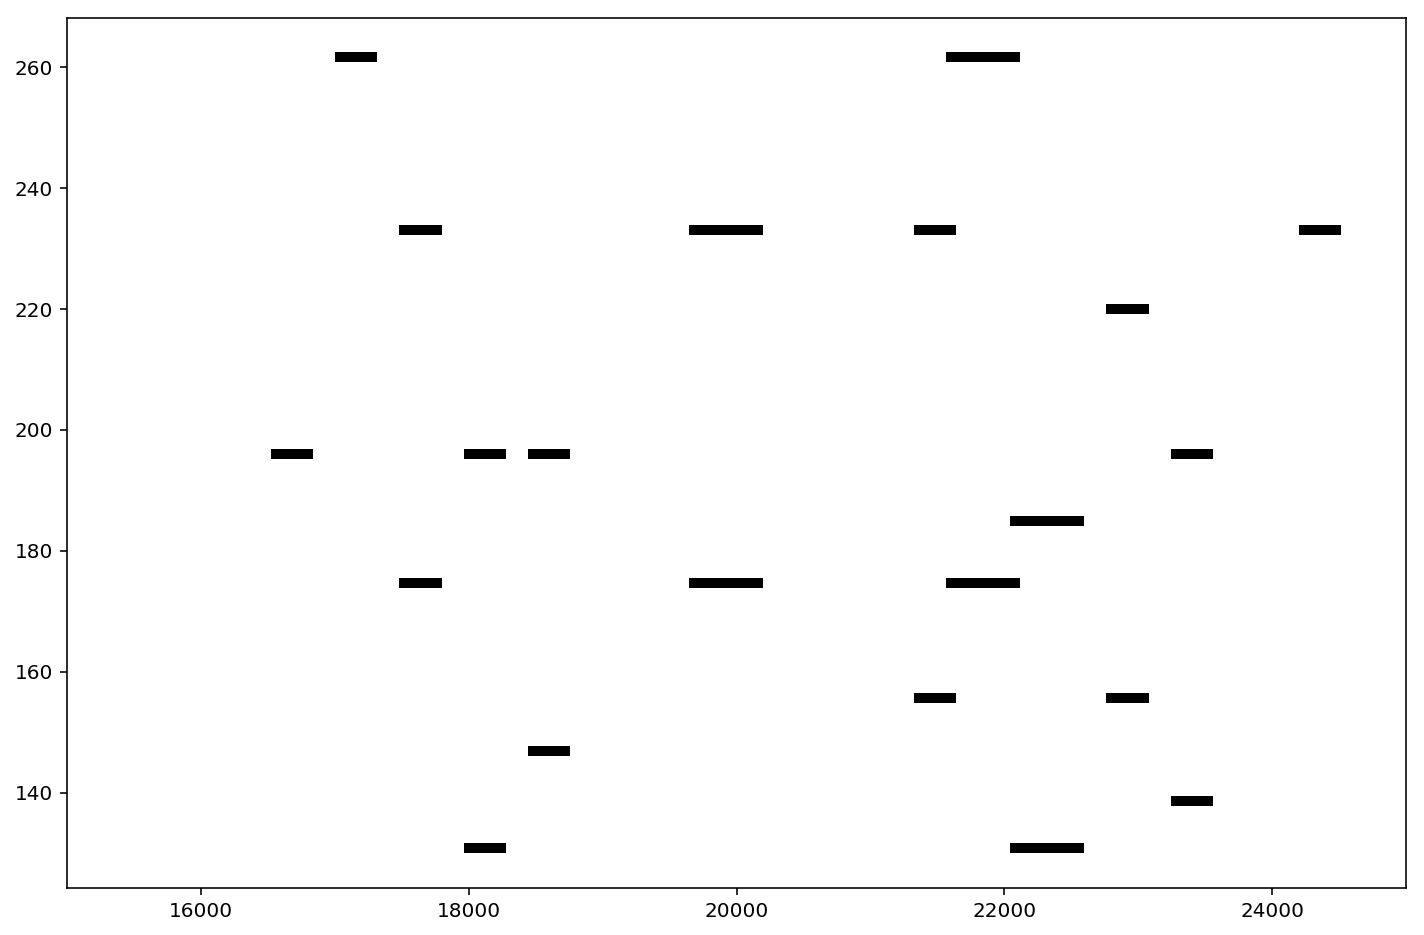

In [26]:
plt.figure(figsize=(12,8))
f = FloatProgress(min=0, max=len(pitch_freq))
display(f)
i = 1
for start, end, freq in zip(midi_tick_starts, midi_tick_ends, pitch_freq):
    f.value = i
    plt.plot([midi_tick_starts, midi_tick_ends], 
             [pitch_freq, pitch_freq],
             'k-',
             lw=5)
    i += 1
plt.xlim(15000, 25000)